-What about electrons? (I don't see any - 2 phys.me)

-1e11 and mDM?

-Compute T(E,z_in, z_dep) by doing a delta function injection

# Full Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs

# np.set_printoptions(threshold=np.nan)

In [3]:
# mDM = 1e11
# sigmav = 1e-24

# def rate_func_swave(rs):
#     return 0*phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

# def test(rs, x1, x2, x3):
#     return 0.3

# test = tla.get_history(
#                 np.array([phys.TCMB(3000), 1, 0, 0]), 0.3, 0.3, 0.3, 
#                 rate_func_swave, np.flipud(np.arange(1, 3001)), reion_switch=False
#             )

# out = np.stack((np.flipud(np.arange(1, 3001)), test[:,0], test[:,1]))
# # pickle.dump(
# #     out, open("/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln.p", "wb")       
# #            )

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

In [5]:
rs = 600
print(xe_std(rs))
print(T_m_std(rs)/phys.kB)
print(phys.TCMB(rs)/phys.kB)

0.0009648017275850074
1625.561215315584
1635.2995445551107


In [6]:
# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,0]/phys.kB)
# plt.plot(np.flipud(np.arange(1, 3001)), phys.TCMB(np.flipud(np.arange(1, 3001)))/phys.kB, 'k:')
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,1])
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

## Photon Transfer Functions

In [7]:
user = 'hongwan'

highengphot_tflist_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
lowengphot_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
lowengelec_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
CMB_engloss_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "rb"))

In [8]:
# print(highengphot_tflist_arr[-1][0].in_eng)
print(highengphot_tflist_arr[-1][0][239].toteng())

2512413325.5473046


In [9]:
photeng = highengphot_tflist_arr[0].eng
eleceng = lowengelec_tflist_arr[0].eng

#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    lowengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengphot_tflist._tflist])
    )
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    lowengelec_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengelec_tflist._tflist])
    )
    
    for engloss in CMB_engloss_arr:
        engloss = np.pad(engloss, ((0,0),(photeng_low.size, 0)), 'constant')


In [10]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)
lowengphot_tf_interp = tflist.TransferFuncInterp(xes, lowengphot_tflist_arr)
lowengelec_tf_interp = tflist.TransferFuncInterp(xes, lowengelec_tflist_arr)


In [31]:
# mDM = 605662.1322589782*2
mDM = 1e9*2

phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      photeng)
phot_spec_init.switch_spec_type()


In [32]:
print(phot_spec_init.toteng(bound_type = 'eng', bound_arr = np.array([1,1e13]))/mDM)

[1.]


In [33]:
%autoreload
phot_spec_init.rs = 3000
end_rs   = 4
#mDM = 1e8
sigmav = 1e-26
tau = 1e25

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)


def evolve(
    in_spec_elec, in_spec_phot, 
    rate_func_N, rate_func_eng, xe_init, T_m_init,
    highengphot_tf_interp, lowengphot_tf_interp, 
    lowengelec_tf_interp, 
    end_rs, coarsen_factor=1, std_soln=False
):
    """
    Main function that computes the temperature and ionization history. 
    
    Parameters
    ----------
    in_spec_elec : Spectrum
        Spectrum per annihilation/decay into electrons. 
    in_spec_phot : Spectrum
        Spectrum per annihilation/decay into photons.
    rate_func_N : function
        Function describing the rate of annihilation/decay, dN/(dV dt)
    rate_func_eng : function
        Function describing the rate of annihilation/decay, dE/(dV dt)
    xe_init : float
        xe at the initial redshift. 
    T_m_init : float
        Matter temperature at the initial redshift. 
    highengphot_tf_interp : TransferFuncInterp
        Interpolation table for high energy photons. 
    lowengphot_tf_interp : TransferFuncInterp
        Interpolation table for low energy photons. 
    lowengelec_tf_interp : TransferFuncInterp
        Interpolation table for low energy electrons. 
    end_rs : float
        Final redshift to evolve to. 
    coarsen_factor : int
        Coarsening to apply to the transfer function matrix. 
    std_soln : bool
        If true, uses the standard TLA solution for f(z). 
    """
    
    # Initialize the next spectrum as None.
    next_highengphot_spec = None
    next_lowengphot_spec  = None
    next_lowengelec_spec  = None
    
    if (
        highengphot_tf_interp.dlnz    != lowengphot_tf_interp.dlnz
        or highengphot_tf_interp.dlnz != lowengelec_tf_interp.dlnz
        or lowengphot_tf_interp.dlnz  != lowengelec_tf_interp.dlnz
    ):
        raise TypeError('TransferFuncInterp objects must all have the same dlnz.')
    
    if in_spec_elec.rs != in_spec_phot.rs:
        raise TypeError('Input spectra must have the same rs.')
    
    # redshift/timestep related quantities. 
    dlnz = highengphot_tf_interp.dlnz
    prev_rs = None
    rs = in_spec_phot.rs
    dt = dlnz/phys.hubble(rs)
    
    # The initial input dN/dE per annihilation to per baryon per dlnz, 
    # based on the specified rate. 
    # dN/(dN_B d lnz dE) = dN/dE * (dN_ann/(dV dt)) * dV/dN_B * dt/dlogz
    
    # ICS for in_spec_elec goes here.
    
    init_inj_spec = (
        in_spec_phot * rate_func_N(rs) * dt / (phys.nB * rs**3)
    )
    
    
    # Initialize the Spectra object that will contain all the 
    # output spectra during the evolution.
    out_highengphot_specs = Spectra([init_inj_spec], spec_type=init_inj_spec.spec_type)
    out_lowengphot_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    out_lowengelec_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    
    # Initialize the xe and T array that will store the solutions.
    xe_arr  = np.array([xe_init])
    T_m_arr = np.array([T_m_init])
    
    # Load the standard TLA solution if necessary. 
#     if std_soln:
    if True:
        soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
        xe_std  = interp1d(soln[0,:], soln[2,:])
        T_m_std = interp1d(soln[0,:], soln[1,:])

    # Define these methods for speed.
    append_highengphot_spec = out_highengphot_specs.append
    append_lowengphot_spec  = out_lowengphot_specs.append
    append_lowengelec_spec  = out_lowengelec_specs.append
    
    # Loop while we are still at a redshift above end_rs.
    while rs > end_rs:
        
        # If prev_rs exists, calculate xe and T_m. 
        if prev_rs is not None:
#             print('here at least?')
            
            # f_continuum, f_lyman, f_ionH, f_ionHe, f_heat
            # f_raw takes in dE/(dV dt)
            if std_soln:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
#                 print("\n SHOULD BE ONE: ", (next_lowengelec_spec.toteng() + next_lowengphot_spec.toteng())/(
#                 np.sum(f_raw) * rate_func_eng(rs) * dt / phys.nB / rs**3), '\n')   
            else:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
                
            std_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
            
            backreaction_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
            
            init_cond = np.array([T_m_arr[-1], xe_arr[-1], 0, 0])

            new_vals = tla.get_history(
                init_cond, f_raw[2], f_raw[1], f_raw[4], 
                rate_func_eng, np.array([prev_rs, rs]),
                reion_switch = False
            )

            T_m_arr = np.append(T_m_arr, new_vals[-1,0])
            xe_arr  = np.append(xe_arr,  new_vals[-1,1])
            
        print('T_m at '+str(rs)+': '+ str(T_m_arr[-1]))
        print('x_e at '+str(rs)+': '+ str(xe_arr[-1]))
        print('Standard x_e at '+str(rs)+': '+str(xe_std(rs)))
        print('Standard T_m at '+str(rs)+': '+str(T_m_std(rs)))
        if prev_rs is not None:
            print('Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', backreaction_f)
            print('Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', std_f)
            
        if std_soln:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_std(rs))
        else:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_arr[-1])
        
#         if coarsen_factor > 1:
#             prop_tf = np.zeros_like(highengphot_tf._grid_vals)
#             for i in np.arange(coarsen_factor):
#                 prop_tf += matrix_power(highengphot_tf._grid_vals, i)
#             lowengphot_tf._grid_vals = np.matmul(prop_tf, lowengphot_tf._grid_vals)
#             lowengelec_tf._grid_vals = np.matmul(prof_tf, lowengelec_tf._grid_vals)
#             highengphot_tf._grid_vals = matrix_power(
#                 highengphot_tf._grid_vals, coarsen_factor
#             )
            
        next_highengphot_spec = highengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengphot_spec  = lowengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1])
        
#         print('\n SHOULD ALSO BE ONE: ', 
#               out_highengphot_specs[-1].toteng(bound_type = 'eng', bound_arr = np.array([100,1e13]))/(
#         next_highengphot_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13])) + 
#             next_lowengphot_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13])) + 
#             next_lowengelec_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13]))), '\n')
        
#         print('ENERGIES:')
#         print(out_highengphot_specs[-1].toteng())
#         for i in np.arange(500):
#             print(i, highengphot_tf.in_eng[i], highengphot_tf[i].toteng())
    
#         print('\n SHOULD ALSO BE ONE: ', 
#               out_highengphot_specs[-1].toteng()/(
#         next_highengphot_spec.toteng()), '\n')
        
#         utils.compare_arr([out_highengphot_specs[-1].N, next_highengphot_spec.N])
        
        # Re-define existing variables.
        prev_rs = rs
        rs = np.exp(np.log(rs) - 0.002)
        
        dt = dlnz/phys.hubble(rs)
        next_highengphot_spec.rs = rs
        next_lowengphot_spec.rs  = rs
        next_lowengelec_spec.rs  = rs
        
        # Add the next injection spectrum to next_highengphot_spec
        next_inj_spec = (
            in_spec_phot * rate_func_N(rs)* dt / (phys.nB * rs**3)
        )

        # This keeps the redshift. 
        next_highengphot_spec.N += next_inj_spec.N
        
        append_highengphot_spec(next_highengphot_spec)
        append_lowengphot_spec(next_lowengphot_spec)
        append_lowengelec_spec(next_lowengelec_spec)
        
        print('************************ END OF LOOP **************************')
        
        
    return (
        xe_arr, T_m_arr, 
        out_highengphot_specs, out_lowengphot_specs, out_lowengelec_specs
    )

In [34]:
#%%prun
# a = evolve(
#         phot_spec_init*0, phot_spec_init, 
#         rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
#         highengphot_tf_interp, lowengphot_tf_interp, 
#         lowengelec_tf_interp, 
#         end_rs, coarsen_factor=1, std_soln=False
#     )

b = evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, xe_std(phot_spec_init.rs), phys.TCMB(phot_spec_init.rs),
        #rate_func_decay_N, rate_func_decay_eng, 2e-4, phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=True
    )

T_m at 3000: 0.70459598745
x_e at 3000: 0.999999999999
Standard x_e at 3000: 0.999999999999
Standard T_m at 3000: 0.70459598745
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000061718777157e-15 1.0000064331823462e-15 1.0000070536415385e-15 1.0000059600034828e-15
Goods:  0.00027743219095758995
Split by photon and electron deposition!
f_phot:  [3.07932219e-04 3.14209886e-06 1.82731717e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.77433910e-19 2.77433973e-19 2.77433524e-19 2.77434314e-19
 2.77432191e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000061718777157e-15 1.0000064331823462e-15 1.0000070536415385e-15 1.0000059600034828e-15
Goods:  0.00027743219095758995
Split by photon and electron deposition!
f_phot:  [3.07932219e-04 3.14209886e-06 1.82731717e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.77433910e-19 2.77433973e-19 2.77433524e-19 2.77434314e-19
 2.77

../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)



x_e at 2988.023968031968: 0.9999999970350104
Standard x_e at 2988.023968031968: 0.9999999970348642
Standard T_m at 2988.023968031968: 0.7017830533974218
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.60553860e-03 7.42104512e-05 1.64281408e-04 9.24839768e-19
 9.24833253e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.60553860e-03 7.42104512e-05 1.64281408e-04 9.24840005e-19
 9.24833253e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000066296434176e-15 1.0000069103289745e-15 1.0000075768074879e-15 1.0000064020544972e-15
Goods:  0.0014950865326483615
Split by photon and electron deposition!
f_phot:  [0.00799849 0.00016121 0.00032459 0.         0.        ]
f_elec:  [1.49509487e-18 1.49509518e-18 1.49509380e-18 1.49509752e-18
 1.49508653e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000066296434176e-15 1.0000069103289745e-15 1.000007576

T_m at 2958.29263278858: 0.6948001912400625
x_e at 2958.29263278858: 0.9999999964512836
Standard x_e at 2958.29263278858: 0.9999999964506467
Standard T_m at 2958.29263278858: 0.6948001912395136
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.84698078e-02 3.11267542e-04 5.73910535e-04 2.50824047e-18
 2.50822004e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.84698078e-02 3.11267542e-04 5.73910535e-04 2.50824122e-18
 2.50822004e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000079389759688e-15 1.0000082750962152e-15 1.0000090732023966e-15 1.0000076664387836e-15
Goods:  0.002587323509838991
Split by photon and electron deposition!
f_phot:  [0.01932443 0.00031724 0.00058298 0.         0.        ]
f_elec:  [2.58734096e-18 2.58734161e-18 2.58733909e-18 2.58734624e-18
 2.58732351e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000079389759688

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000098813411496e-15 1.0000102996976357e-15 1.0000112930707101e-15 1.0000095421241071e-15
Goods:  0.0026980035488221384
Split by photon and electron deposition!
f_phot:  [0.02021898 0.00031379 0.0005787  0.         0.        ]
f_elec:  [2.69802656e-18 2.69802740e-18 2.69802403e-18 2.69803330e-18
 2.69800355e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000095238796686e-15 1.0000099271018669e-15 1.0000108845391503e-15 1.0000091969340077e-15
Goods:  0.0026980035488221384
Split by photon and electron deposition!
f_phot:  [0.02021898 0.00031379 0.0005787  0.         0.        ]
f_elec:  [2.69802572e-18 2.69802654e-18 2.69802329e-18 2.69803223e-18
 2.69800355e-03]
T_m at 2917.1651004037394: 0.6851407565072911
x_e at 2917.1651004037394: 0.9999999954201673
Standard x_e at 2917.1651004037394: 0.9999999954193962
Standard T_m at 2917.1651004037394: 0.6851407565066697
Back Reaction f_cont, 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000123341823786e-15 1.000012856387973e-15 1.0000140963467308e-15 1.000011910761027e-15
Goods:  0.00265890311776022
Split by photon and electron deposition!
f_phot:  [0.01975101 0.00030268 0.00056173 0.         0.        ]
f_elec:  [2.65893153e-18 2.65893257e-18 2.65892837e-18 2.65893981e-18
 2.65890312e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000123341823786e-15 1.000012856387973e-15 1.0000140963467308e-15 1.000011910761027e-15
Goods:  0.00265890311776022
Split by photon and electron deposition!
f_phot:  [0.01975101 0.00030268 0.00056173 0.         0.        ]
f_elec:  [2.65893153e-18 2.65893257e-18 2.65892837e-18 2.65893981e-18
 2.65890312e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000118824408138e-15 1.0000123855204206e-15 1.000013580065278e-15 1.0000114745274447e-15
Goods

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000014870093904e-15 1.000015499665936e-15 1.0000169945619431e-15 1.0000143596162407e-15
Goods:  0.0026172921907211674
Split by photon and electron deposition!
f_phot:  [0.01930873 0.0002933  0.00054704 0.         0.        ]
f_elec:  [2.61732600e-18 2.61732724e-18 2.61732221e-18 2.61733580e-18
 2.61729219e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000014870093904e-15 1.000015499665936e-15 1.0000169945619431e-15 1.0000143596162407e-15
Goods:  0.0026172921907211674
Split by photon and electron deposition!
f_phot:  [0.01930873 0.0002933  0.00054704 0.         0.        ]
f_elec:  [2.61732600e-18 2.61732724e-18 2.61732221e-18 2.61733580e-18
 2.61729219e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000143198631151e-15 1.000014926139227e-15 1.0000163657200445e-15 1.000013828274558e-15
Goods:  0.0026172921907211674
Split by photon and electron deposit

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000186604345019e-15 1.0000194504839969e-15 1.0000213264269018e-15 1.0000180198362573e-15
Goods:  0.00256721488601369
Split by photon and electron deposition!
f_phot:  [0.01877883 0.00028213 0.00052952 0.         0.        ]
f_elec:  [2.56725664e-18 2.56725817e-18 2.56725190e-18 2.56726867e-18
 2.56721489e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000186604345019e-15 1.0000194504839969e-15 1.0000213264269018e-15 1.0000180198362573e-15
Goods:  0.00256721488601369
Split by photon and electron deposition!
f_phot:  [0.01877883 0.00028213 0.00052952 0.         0.        ]
f_elec:  [2.56725664e-18 2.56725817e-18 2.56725190e-18 2.56726867e-18
 2.56721489e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000017961378575e-15 1.000018721831019e-15 1.0000205274970216e-15 1.0000173447786302e-15
Go

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000244111413648e-15 1.0000254446685402e-15 1.0000278987379943e-15 1.000023573123006e-15
Goods:  0.002509291395101941
Split by photon and electron deposition!
f_phot:  [0.018166   0.00026926 0.00050933 0.         0.        ]
f_elec:  [2.50934499e-18 2.50934696e-18 2.50933881e-18 2.50936034e-18
 2.50929140e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000244111413648e-15 1.0000254446685402e-15 1.0000278987379943e-15 1.000023573123006e-15
Goods:  0.002509291395101941
Split by photon and electron deposition!
f_phot:  [0.018166   0.00026926 0.00050933 0.         0.        ]
f_elec:  [2.50934499e-18 2.50934696e-18 2.50933881e-18 2.50936034e-18
 2.50929140e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000234833731988e-15 1.0000244776197438e-15 1.000026838419214e-15 1.0000226772049419e-15
G

Split by photon and electron deposition!
f_phot:  [0.01773196 0.00026017 0.00049506 0.         0.        ]
f_elec:  [2.46832611e-18 2.46832837e-18 2.46831891e-18 2.46834369e-18
 2.46826435e-03]
T_m at 2752.7826936604692: 0.6465330140584079
x_e at 2752.7826936604692: 0.9999999862577653
Standard x_e at 2752.7826936604692: 0.9999999862562562
Standard T_m at 2752.7826936604692: 0.6465330140576893
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.77319621e-02 2.60166126e-04 4.95064712e-04 2.46834369e-18
 2.46826435e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.77319621e-02 2.60166126e-04 4.95064712e-04 2.46834686e-18
 2.46826435e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000308316163125e-15 1.0000321369799943e-15 1.0000352365115421e-15 1.0000297731833402e-15
Goods:  0.002460093800185859
Split by photon and electron deposition!
f_phot:  [0.01764553 0.00025836 0.0004922

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000390551982231e-15 1.0000407087427388e-15 1.000044635010386e-15 1.0000377144476364e-15
Goods:  0.0024032265687160036
Split by photon and electron deposition!
f_phot:  [0.01704399 0.0002458  0.00047253 0.         0.        ]
f_elec:  [2.40330932e-18 2.40331236e-18 2.40329951e-18 2.40333270e-18
 2.40322657e-03]
T_m at 2709.0886550066516: 0.6362707951126237
x_e at 2709.0886550066516: 0.9999999811622783
Standard x_e at 2709.0886550066516: 0.9999999811605006
Standard T_m at 2709.0886550066516: 0.6362707951118816
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.70439883e-02 2.45803293e-04 4.72528123e-04 2.40333270e-18
 2.40322657e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.70439883e-02 2.45803293e-04 4.72528123e-04 2.40333701e-18
 2.40322657e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00004229

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000537979942528e-15 1.0000560757459507e-15 1.0000614841539384e-15 1.0000519511130514e-15
Goods:  0.00234693360751676
Split by photon and electron deposition!
f_phot:  [0.01644862 0.00023342 0.0004531  0.         0.        ]
f_elec:  [2.34704540e-18 2.34704950e-18 2.34703195e-18 2.34707674e-18
 2.34693361e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000537979942528e-15 1.0000560757459507e-15 1.0000614841539384e-15 1.0000519511130514e-15
Goods:  0.00234693360751676
Split by photon and electron deposition!
f_phot:  [0.01644862 0.00023342 0.0004531  0.         0.        ]
f_elec:  [2.34704540e-18 2.34704950e-18 2.34703195e-18 2.34707674e-18
 2.34693361e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000051667268076e-15 1.0000538548046562e-15 1.0000590490029637e-15 1.0000498935367488e-15
Goods:  0.00234693360751676
Split by photon and electron depositi

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000065900175039e-15 1.0000686903377557e-15 1.0000753154283713e-15 1.0000636378109249e-15
Goods:  0.0023070780120736465
Split by photon and electron deposition!
f_phot:  [0.01602716 0.00022469 0.00043939 0.         0.        ]
f_elec:  [2.30721303e-18 2.30721799e-18 2.30719662e-18 2.30725069e-18
 2.30707801e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000065900175039e-15 1.0000686903377557e-15 1.0000753154283713e-15 1.0000636378109249e-15
Goods:  0.0023070780120736465
Split by photon and electron deposition!
f_phot:  [0.01602716 0.00022469 0.00043939 0.         0.        ]
f_elec:  [2.30721303e-18 2.30721799e-18 2.30719662e-18 2.30725069e-18
 2.30707801e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000632632585954e-15 1.000065941772711e-15 1.000072301762233e-15 1.0000610914235974e-15
Goods:  0.0023070780120736465
Split by photon and electron depos

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000809020564469e-15 1.0000843274133682e-15 1.000092460720313e-15 1.0000781246509553e-15
Goods:  0.0022680026951144277
Split by photon and electron deposition!
f_phot:  [0.01561428 0.00021618 0.00042596 0.         0.        ]
f_elec:  [2.26816615e-18 2.26817215e-18 2.26814606e-18 2.26821149e-18
 2.26800270e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000809020564469e-15 1.0000843274133682e-15 1.000092460720313e-15 1.0000781246509553e-15
Goods:  0.0022680026951144277
Split by photon and electron deposition!
f_phot:  [0.01561428 0.00021618 0.00042596 0.         0.        ]
f_elec:  [2.26816615e-18 2.26817215e-18 2.26814606e-18 2.26821149e-18
 2.26800270e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000077630943727e-15 1.0000809177977381e-15 1.000088722241502e-15 1.0000749658421445e-15


T_m at 2592.473109553961: 0.6088818346726714
x_e at 2592.473109553961: 0.9999999538638549
Standard x_e at 2592.473109553961: 0.9999999538605272
Standard T_m at 2592.473109553961: 0.6088818346718399
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.52641490e-02 2.09923433e-04 4.15327375e-04 2.23486033e-18
 2.23461721e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.52641490e-02 2.09923433e-04 4.15327375e-04 2.23487068e-18
 2.23461721e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001037792334989e-15 1.0001081732509003e-15 1.0001186065495498e-15 1.0001002163963556e-15
Goods:  0.0022280623548205057
Split by photon and electron deposition!
f_phot:  [0.01519529 0.00020871 0.00041326 0.         0.        ]
f_elec:  [2.22826892e-18 2.22827649e-18 2.22824327e-18 2.22832593e-18
 2.22806235e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00010377923

T_m at 2561.549345905481: 0.6016189113500565
x_e at 2561.549345905481: 0.9999999406596092
Standard x_e at 2561.549345905481: 0.9999999406556448
Standard T_m at 2561.549345905481: 0.6016189113491991
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.48530010e-02 2.02658230e-04 4.03001638e-04 2.19576438e-18
 2.19545680e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.48530010e-02 2.02658230e-04 4.03001638e-04 2.19577765e-18
 2.19545680e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001335547173426e-15 1.0001392095155342e-15 1.0001526363943933e-15 1.000128969580812e-15
Goods:  0.0021889629921315054
Split by photon and electron deposition!
f_phot:  [0.01478487 0.00020146 0.00040096 0.         0.        ]
f_elec:  [2.18922487e-18 2.18923447e-18 2.18919202e-18 2.18929680e-18
 2.18896299e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000133554717

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001652051520249e-15 1.0001722001636737e-15 1.000188809197746e-15 1.0001595333034506e-15
Goods:  0.0021566200216520757
Split by photon and electron deposition!
f_phot:  [0.01444574 0.00019548 0.00039082 0.         0.        ]
f_elec:  [2.15693991e-18 2.15695164e-18 2.15689945e-18 2.15702742e-18
 2.15662002e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001652051520249e-15 1.0001722001636737e-15 1.000188809197746e-15 1.0001595333034506e-15
Goods:  0.0021566200216520757
Split by photon and electron deposition!
f_phot:  [0.01444574 0.00019548 0.00039082 0.         0.        ]
f_elec:  [2.15693991e-18 2.15695164e-18 2.15689945e-18 2.15702742e-18
 2.15662002e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001582879537932e-15 1.000164990058296e-15 1.0001809036265796e-15 1.0001528536094078e-15

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0002048147903958e-15 1.000213487102557e-15 1.0002340786175395e-15 1.0001977828955382e-15
Goods:  0.002118083721820696
Split by photon and electron deposition!
f_phot:  [0.01404208 0.00018838 0.00037878 0.         0.        ]
f_elec:  [2.11847431e-18 2.11848864e-18 2.11842441e-18 2.11858064e-18
 2.11808372e-03]
T_m at 2500.8040212472474: 0.5873519337174955
x_e at 2500.8040212472474: 0.9999999008697062
Standard x_e at 2500.8040212472474: 0.9999999008644013
Standard T_m at 2500.8040212472474: 0.5873519337165898
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.40420752e-02 1.88383853e-04 3.78779510e-04 2.11858064e-18
 2.11808372e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.40420752e-02 1.88383853e-04 3.78779510e-04 2.11860264e-18
 2.11808372e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000223361

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0002778220280432e-15 1.0002895860643499e-15 1.0003175182603634e-15 1.0002682831744275e-15
Goods:  0.0020798482889308988
Split by photon and electron deposition!
f_phot:  [0.01364202 0.00018137 0.00036688 0.         0.        ]
f_elec:  [2.08037002e-18 2.08038916e-18 2.08030269e-18 2.08051135e-18
 2.07984829e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0002778220280432e-15 1.0002895860643499e-15 1.0003175182603634e-15 1.0002682831744275e-15
Goods:  0.0020798482889308988
Split by photon and electron deposition!
f_phot:  [0.01364202 0.00018137 0.00036688 0.         0.        ]
f_elec:  [2.08037002e-18 2.08038916e-18 2.08030269e-18 2.08051135e-18
 2.07984829e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00026589756263e-15 1.0002771566037926e-15 1.0003038898005693e-15 1.0002567681917815e-1

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0003313498298884e-15 1.000345380817097e-15 1.0003786953345704e-15 1.0003199727767258e-15
Goods:  0.0020482162504173815
Split by photon and electron deposition!
f_phot:  [0.01331143 0.00017559 0.00035706 0.         0.        ]
f_elec:  [2.04883051e-18 2.04885305e-18 2.04875056e-18 2.04899621e-18
 2.04821625e-03]
T_m at 2446.3871135619243: 0.5745712821922155
x_e at 2446.3871135619243: 0.9999998394752637
Standard x_e at 2446.3871135619243: 0.9999998394672637
Standard T_m at 2446.3871135619243: 0.5745712821912549
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33114272e-02 1.75591512e-04 3.57064951e-04 2.04899621e-18
 2.04821625e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33114272e-02 1.75591512e-04 3.57064951e-04 2.04903157e-18
 2.04821625e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00036209

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0004735319687393e-15 1.000493585096274e-15 1.0005411973033136e-15 1.0004572716793823e-15
Goods:  0.002004285611883766
Split by photon and electron deposition!
f_phot:  [0.01285287 0.0001676  0.00034349 0.         0.        ]
f_elec:  [2.00514756e-18 2.00517918e-18 2.00503402e-18 2.00537869e-18
 2.00428561e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00045269420827e-15 1.0004718646958122e-15 1.000517381387579e-15 1.0004371496409325e-15
Goods:  0.002004285611883766
Split by photon and electron deposition!
f_phot:  [0.01285287 0.0001676  0.00034349 0.         0.        ]
f_elec:  [2.00510963e-18 2.00513986e-18 2.00500108e-18 2.00533059e-18
 2.00428561e-03]
T_m at 2412.3763249997287: 0.5665833228412179
x_e at 2412.3763249997287: 0.9999997805605343
Standard x_e at 2412.3763249997287: 0.9999997805505376
Standard T_m at 2412.3763249997287: 0.5665833228402231
Back Reaction f_cont, f_lyma

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0006213962093585e-15 1.0006477130647493e-15 1.0007101958998947e-15 1.0006000566757334e-15
Goods:  0.0019669612719618056
Split by photon and electron deposition!
f_phot:  [0.01246382 0.00016084 0.00033201 0.         0.        ]
f_elec:  [1.96807461e-18 1.96811546e-18 1.96792642e-18 1.96837160e-18
 1.96696127e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0006213962093585e-15 1.0006477130647493e-15 1.0007101958998947e-15 1.0006000566757334e-15
Goods:  0.0019669612719618056
Split by photon and electron deposition!
f_phot:  [0.01246382 0.00016084 0.00033201 0.         0.        ]
f_elec:  [1.96807461e-18 1.96811546e-18 1.96792642e-18 1.96837160e-18
 1.96696127e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0005937115862518e-15 1.0006188556123421e-15 1.0006785540992449e-15 1.0005733231060272e

T_m at 2359.8835831997144: 0.5542545908296154
x_e at 2359.8835831997144: 0.9999996379601908
Standard x_e at 2359.8835831997144: 0.9999996379479515
Standard T_m at 2359.8835831997144: 0.554254590828575
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.21424470e-02 1.55272233e-04 3.22555618e-04 1.93776152e-18
 1.93609181e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.21424470e-02 1.55272233e-04 3.22555618e-04 1.93784021e-18
 1.93609181e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000818265162277e-15 1.0008529231089765e-15 1.0009352074059016e-15 1.0007901616814979e-15
Goods:  0.0019299435500566289
Split by photon and electron deposition!
f_phot:  [0.01207848 0.00015417 0.00032068 0.         0.        ]
f_elec:  [1.93138636e-18 1.93143930e-18 1.93119231e-18 1.93176923e-18
 1.92994355e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000818265

T_m at 2336.402349214271: 0.5487396598591694
x_e at 2336.402349214271: 0.9999995436876654
Standard x_e at 2336.402349214271: 0.9999995436699612
Standard T_m at 2336.402349214271: 0.5487396598580938
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.18236794e-02 1.49765079e-04 3.13197896e-04 1.90750989e-18
 1.90543614e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.18236794e-02 1.49765079e-04 3.13197896e-04 1.90760869e-18
 1.90543614e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0010319681751224e-15 1.00107568233588e-15 1.0011794644711578e-15 1.0009965206172522e-15
Goods:  0.0018993307344270462
Split by photon and electron deposition!
f_phot:  [0.01176024 0.00014867 0.00031134 0.         0.        ]
f_elec:  [1.90112606e-18 1.90119194e-18 1.90088247e-18 1.90160037e-18
 1.89933073e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0010319681751

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0013677315791616e-15 1.0014256785387714e-15 1.0015632440686261e-15 1.0013207415575951e-15
Goods:  0.0018628789826457216
Split by photon and electron deposition!
f_phot:  [0.0113818  0.00014216 0.00030027 0.         0.        ]
f_elec:  [1.86522001e-18 1.86530593e-18 1.86489899e-18 1.86583518e-18
 1.86287898e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0013046431598524e-15 1.001359915471766e-15 1.001491132633166e-15 1.0012598222581087e-15
Goods:  0.0018628789826457216
Split by photon and electron deposition!
f_phot:  [0.0113818  0.00014216 0.00030027 0.         0.        ]
f_elec:  [1.86511203e-18 1.86519398e-18 1.86480583e-18 1.86569882e-18
 1.86287898e-03]
T_m at 2303.9206189701777: 0.5411108230073033
x_e at 2303.9206189701777: 0.9999993665096788
Standard x_e at 2303.9206189701777: 0.9999993664925887
Standard T_m at 2303.9206189701777: 0.5411108230062031
Back Reaction f_cont, f_

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0018192820433273e-15 1.0018963775754583e-15 1.00207938945904e-15 1.0017567620790622e-15
Goods:  0.0018297167300823116
Split by photon and electron deposition!
f_phot:  [0.01104758 0.00013679 0.00029081 0.         0.        ]
f_elec:  [1.83278279e-18 1.83289536e-18 1.83235817e-18 1.83358521e-18
 1.82971673e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0018192820433273e-15 1.0018963775754583e-15 1.00207938945904e-15 1.0017567620790622e-15
Goods:  0.0018297167300823116
Split by photon and electron deposition!
f_phot:  [0.01104758 0.00013679 0.00029081 0.         0.        ]
f_elec:  [1.83278279e-18 1.83289536e-18 1.83235817e-18 1.83358521e-18
 1.82971673e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.001734309611191e-15 1.0018078011104247e-15 1.0019822598071775e-15 1.0016747126813399e-15
G

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0024286756651313e-15 1.0025316271869658e-15 1.0027759949253363e-15 1.0023451842477291e-15
Goods:  0.0017987790205501136
Split by photon and electron deposition!
f_phot:  [0.01073936 0.00013212 0.00028244 0.         0.        ]
f_elec:  [1.80281118e-18 1.80295928e-18 1.80224759e-18 1.80386305e-18
 1.79877902e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0024286756651313e-15 1.0025316271869658e-15 1.0027759949253363e-15 1.0023451842477291e-15
Goods:  0.0017987790205501136
Split by photon and electron deposition!
f_phot:  [0.01073936 0.00013212 0.00028244 0.         0.        ]
f_elec:  [1.80281118e-18 1.80295928e-18 1.80224759e-18 1.80386305e-18
 1.79877902e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0023138431481922e-15 1.0024119212172592e-15 1.002644725170397e-15 1.0022343046677591e-

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


T_m at 2240.3056079201356: 0.5270521263147342
x_e at 2240.3056079201356: 0.9999988107255651
Standard x_e at 2240.3056079201356: 0.9999987613318878
Standard T_m at 2240.3056079201356: 0.5261698530492647
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06374243e-02 1.30578996e-04 2.79681430e-04 1.79383796e-18
 1.78852935e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06374243e-02 1.30578996e-04 2.79681430e-04 1.79410258e-18
 1.78852935e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0028099593282759e-15 1.0029290964566487e-15 1.00321186678821e-15 1.0027133390243947e-15
Goods:  0.001783414105888857
Split by photon and electron deposition!
f_phot:  [0.01058658 0.00012981 0.0002783  0.         0.        ]
f_elec:  [1.78804422e-18 1.78821432e-18 1.78739403e-18 1.78925015e-18
 1.78341411e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0028099593

T_m at 2204.7459540272735: 0.5178181176672187
x_e at 2204.7459540272735: 0.999998167255864
Standard x_e at 2204.7459540272735: 0.9999981672042013
Standard T_m at 2204.7459540272735: 0.5178181176659775
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.02329600e-02 1.24477751e-04 2.68738547e-04 1.75547164e-18
 1.74778144e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.02329600e-02 1.24477751e-04 2.68738547e-04 1.75586165e-18
 1.74778144e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0041644568622747e-15 1.004341143236727e-15 1.00476042229627e-15 1.0040211498173681e-15
Goods:  0.0017427157771772576
Split by photon and electron deposition!
f_phot:  [0.01018277 0.00012372 0.00026738 0.         0.        ]
f_elec:  [1.74943982e-18 1.74968706e-18 1.74848363e-18 1.75118382e-18
 1.74271578e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00416445686

 1.71748017e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0056182771780496e-15 1.005856820260503e-15 1.0064227650162606e-15 1.005424778762533e-15
Goods:  0.0017124516263900171
Split by photon and electron deposition!
f_phot:  [0.0098833  0.00011922 0.00025931 0.         0.        ]
f_elec:  [1.72138424e-18 1.72171297e-18 1.72010164e-18 1.72369406e-18
 1.71245163e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0056182771780496e-15 1.005856820260503e-15 1.0064227650162606e-15 1.005424778762533e-15
Goods:  0.0017124516263900171
Split by photon and electron deposition!
f_phot:  [0.0098833  0.00011922 0.00025931 0.         0.        ]
f_elec:  [1.72138424e-18 1.72171297e-18 1.72010164e-18 1.72369406e-18
 1.71245163e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0053432421056763e-15 1.0055700761363114e-15 1.0061082628770862e-15 1.0051

T_m at 2148.161346681697: 0.5045283459220965
x_e at 2148.161346681697: 0.9999964889967945
Standard x_e at 2148.161346681697: 0.9999964889192692
Standard T_m at 2148.161346681697: 0.5045283459207749
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.58676437e-03 1.14777448e-04 2.51329380e-04 1.69664927e-18
 1.68241078e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.58676437e-03 1.14777448e-04 2.51329380e-04 1.69739208e-18
 1.68241078e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0080063846111922e-15 1.0083467325121158e-15 1.0091539262800662e-15 1.0077302576680635e-15
Goods:  0.0016774257559648083
Split by photon and electron deposition!
f_phot:  [0.00953763 0.00011404 0.00025001 0.         0.        ]
f_elec:  [1.68992559e-18 1.69038627e-18 1.68810984e-18 1.69314707e-18
 1.67742576e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00800638461

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0098259066743457e-15 1.0102439842574108e-15 1.01123526236981e-15 1.009486672715652e-15
Goods:  0.0016525942939230327
Split by photon and electron deposition!
f_phot:  [0.00929318 0.00011039 0.00024345 0.         0.        ]
f_elec:  [1.66773458e-18 1.66829318e-18 1.66551677e-18 1.67162730e-18
 1.65259429e-03]
T_m at 2122.5374613195786: 0.49851017923791585
x_e at 2122.5374613195786: 0.9999952341712651
Standard x_e at 2122.5374613195786: 0.9999952340271868
Standard T_m at 2122.5374613195786: 0.4985101792365433
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.29317823e-03 1.10390670e-04 2.43451383e-04 1.67162730e-18
 1.65259429e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.29317823e-03 1.10390670e-04 2.43451383e-04 1.67263373e-18
 1.65259429e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.010892965

T_m at 2101.4178607058325: 0.4935499135532846
x_e at 2101.4178607058325: 0.9999938360043396
Standard x_e at 2101.4178607058325: 0.9999938358222196
Standard T_m at 2101.4178607058325: 0.49354991355187816
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.05079039e-03 1.06778945e-04 2.36962666e-04 1.65223182e-18
 1.62791938e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.05079039e-03 1.06778945e-04 2.36962666e-04 1.65353204e-18
 1.62791938e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.014122415593724e-15 1.0147245997320204e-15 1.0161515017445634e-15 1.0136336462139059e-15
Goods:  0.0016230032430796057
Split by photon and electron deposition!
f_phot:  [0.00900256 0.00010606 0.00023567 0.         0.        ]
f_elec:  [1.64441885e-18 1.64521101e-18 1.64124755e-18 1.64991304e-18
 1.62300324e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0141224

T_m at 2080.508403629344: 0.4886390032482248
x_e at 2080.508403629344: 0.9999920091237721
Standard x_e at 2080.508403629344: 0.9999920088853825
Standard T_m at 2080.508403629344: 0.48863900324678117
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.81047594e-03 1.03207372e-04 2.30543620e-04 1.63454444e-18
 1.60340165e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.81047594e-03 1.03207372e-04 2.30543620e-04 1.63622939e-18
 1.60340165e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0183626769128005e-15 1.0191473274124002e-15 1.02100543705899e-15 1.0177256187178445e-15
Goods:  0.0015985170211949217
Split by photon and electron deposition!
f_phot:  [0.00876266 0.0001025  0.00022927 0.         0.        ]
f_elec:  [1.62599036e-18 1.62700912e-18 1.62188392e-18 1.63302724e-18
 1.59851702e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.018362676912

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0239481952310664e-15 1.024974364506911e-15 1.0274024247190971e-15 1.0231147305204485e-15
Goods:  0.0015741887312608806
Split by photon and electron deposition!
f_phot:  [8.52485176e-03 9.89747830e-05 2.22933164e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.60953426e-18 1.61084922e-18 1.60419908e-18 1.61857664e-18
 1.57418873e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0239481952310664e-15 1.024974364506911e-15 1.0274024247190971e-15 1.0231147305204485e-15
Goods:  0.0015741887312608806
Split by photon and electron deposition!
f_phot:  [8.52485176e-03 9.89747830e-05 2.22933164e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.60953426e-18 1.61084922e-18 1.60419908e-18 1.61857664e-18
 1.57418873e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0227031216117232e-15 1.023675339359303e-15 1.0

T_m at 2027.1123418819586: 0.47609810954403586
x_e at 2027.1123418819586: 0.9999841445475508
Standard x_e at 2027.1123418819586: 0.999984144293233
Standard T_m at 2027.1123418819586: 0.4760981095425138
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.19544502e-03 9.41107109e-05 2.14182369e-04 1.60051212e-18
 1.54039566e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.19544502e-03 9.41107109e-05 2.14182369e-04 1.60387129e-18
 1.54039566e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.036873795570531e-15 1.0384639146794196e-15 1.0422192830508733e-15 1.0355811906807496e-15
Goods:  0.0015355935451470352
Split by photon and electron deposition!
f_phot:  [8.14872462e-03 9.34223763e-05 2.12943561e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.58882402e-18 1.59081909e-18 1.58065070e-18 1.60243276e-18
 1.53559355e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999

T_m at 2006.942237071122: 0.4713608472667296
x_e at 2006.942237071122: 0.999979287751549
Standard x_e at 2006.942237071122: 0.9999792875162415
Standard T_m at 2006.942237071122: 0.47136084726517546
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.96950643e-03 9.07988221e-05 2.08181457e-04 1.59501821e-18
 1.51710640e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.96950643e-03 9.07988221e-05 2.08181457e-04 1.59943285e-18
 1.51710640e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0485130302632445e-15 1.0506169591189858e-15 1.0555774146762333e-15 1.0468015119082375e-15
Goods:  0.0015130057957930025
Split by photon and electron deposition!
f_phot:  [7.93068273e-03 9.02749894e-05 2.07195418e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.58211096e-18 1.58471804e-18 1.57137834e-18 1.59979206e-18
 1.51300580e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0677792702740559e-15 1.0707460337919232e-15 1.0777214375796884e-15 1.0653631395111244e-15
Goods:  0.001488906882636164
Split by photon and electron deposition!
f_phot:  [7.70316662e-03 8.72379951e-05 2.01498424e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.58402740e-18 1.58765423e-18 1.56904516e-18 1.60844707e-18
 1.48890688e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0640767475054774e-15 1.0668765083555058e-15 1.0734627543983636e-15 1.0617970985515184e-15
Goods:  0.001488906882636164
Split by photon and electron deposition!
f_phot:  [7.70316662e-03 8.72379951e-05 2.01498424e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.57884094e-18 1.58226313e-18 1.56469268e-18 1.60190204e-18
 1.48890688e-03]
T_m at 1979.0408114532509: 0.4648077641102775
x_e at 1979.0408114532509: 0.9999698007610456
Standard x_e at 1979.0408114532509: 0.9999698004798021
Standard T_m at 1979.0408114532509: 0

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0953232885288257e-15 1.0995499463898304e-15 1.1094486980915484e-15 1.0918761114739472e-15
Goods:  0.0014650847561039646
Split by photon and electron deposition!
f_phot:  [7.47922988e-03 8.42593019e-05 1.95908960e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.59684107e-18 1.60193924e-18 1.57574575e-18 1.63086493e-18
 1.46508476e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0953232885288257e-15 1.0995499463898304e-15 1.1094486980915484e-15 1.0918761114739472e-15
Goods:  0.0014650847561039646
Split by photon and electron deposition!
f_phot:  [7.47922988e-03 8.42593019e-05 1.95908960e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.59684107e-18 1.60193924e-18 1.57574575e-18 1.63086493e-18
 1.46508476e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0900084608527547e-15 1.0939896222489416e-15 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999954 1.1274046778616758e-15 1.133137142587599e-15 1.1465021506643357e-15 1.1227224787756786e-15
Goods:  0.0014414302149457054
Split by photon and electron deposition!
f_phot:  [7.25763327e-03 8.13190080e-05 1.90387650e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.61483048e-18 1.62165173e-18 1.58658115e-18 1.65992347e-18
 1.44143021e-03]
T_m at 1932.109263249511: 0.4537851607010349
x_e at 1932.109263249511: 0.9999419821371848
Standard x_e at 1932.109263249511: 0.9999419812895785
Standard T_m at 1932.109263249511: 0.4537851606993083
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.25763327e-03 8.13190080e-05 1.90387650e-04 1.65992347e-18
 1.44143021e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.25763327e-03 8.13190080e-05 1.90387650e-04 1.67321483e-18
 1.44143021e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999999995 1.205590469191586e-15 1.215160347837666e-15 1.2372352989726726e-15 1.1977519865222247e-15
Goods:  0.0014140385143016233
Split by photon and electron deposition!
f_phot:  [7.00199887e-03 7.79369590e-05 1.84031987e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.68852094e-18 1.69973310e-18 1.64240201e-18 1.76130270e-18
 1.41403851e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999999995 1.205590469191586e-15 1.215160347837666e-15 1.2372352989726726e-15 1.1977519865222247e-15
Goods:  0.0014140385143016233
Split by photon and electron deposition!
f_phot:  [7.00199887e-03 7.79369590e-05 1.84031987e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.68852094e-18 1.69973310e-18 1.64240201e-18 1.76130270e-18
 1.41403851e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999999995 1.1934300445010718e-15 1.2023878113711755e-15 1.22308

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999949 1.2804840786853524e-15 1.2939437745624285e-15 1.324688223505408e-15 1.2694394251729198e-15
Goods:  0.001394608587110803
Split by photon and electron deposition!
f_phot:  [6.82132052e-03 7.55532190e-05 1.79549097e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.76378272e-18 1.77937093e-18 1.70015820e-18 1.86345454e-18
 1.39460859e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999949 1.2804840786853524e-15 1.2939437745624285e-15 1.324688223505408e-15 1.2694394251729198e-15
Goods:  0.001394608587110803
Split by photon and electron deposition!
f_phot:  [6.82132052e-03 7.55532190e-05 1.79549097e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.76378272e-18 1.77937093e-18 1.70015820e-18 1.86345454e-18
 1.39460859e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999949 1.2633563536741338e-15 1.275908538438364e-15 1.304643467549076e-15 1.2530600139069586e-15
Goods:  0.00139460858711

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999944 1.387222579241025e-15 1.4065686467786458e-15 1.4501747189927846e-15 1.371323925231847e-15
Goods:  0.0013752920660829709
Split by photon and electron deposition!
f_phot:  [6.64224893e-03 7.31962859e-05 1.75113793e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.87737643e-18 1.89950853e-18 1.78814672e-18 2.01631079e-18
 1.37529207e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999944 1.387222579241025e-15 1.4065686467786458e-15 1.4501747189927846e-15 1.371323925231847e-15
Goods:  0.0013752920660829709
Split by photon and electron deposition!
f_phot:  [6.64224893e-03 7.31962859e-05 1.75113793e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.87737643e-18 1.89950853e-18 1.78814672e-18 2.01631079e-18
 1.37529207e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999948 1.362623971306851e-15 1.380578907103025e-15 1.4211

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999937 1.5428603009243919e-15 1.5714645585509774e-15 1.6347866822105284e-15 1.519340379023682e-15
Goods:  0.0013560893438801197
Split by photon and electron deposition!
f_phot:  [6.46479189e-03 7.08662770e-05 1.70726251e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.04884766e-18 2.08112674e-18 1.92106185e-18 2.24702475e-18
 1.35608934e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999937 1.5428603009243919e-15 1.5714645585509774e-15 1.6347866822105284e-15 1.519340379023682e-15
Goods:  0.0013560893438801197
Split by photon and electron deposition!
f_phot:  [6.46479189e-03 7.08662770e-05 1.70726251e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.04884766e-18 2.08112674e-18 1.92106185e-18 2.24702475e-18
 1.35608934e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999939 1.5066499552781156e-15 1.5330317438398424e-15 1.591671268483084e-15 1.4849572533947462e-15
Goods:  0.00135608934

Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.25398567e-03 6.81059728e-05 1.65524491e-04 2.59548938e-18
 1.33319685e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.25398567e-03 6.81059728e-05 1.65524491e-04 2.69530134e-18
 1.33319685e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999999992 1.9027877864813276e-15 1.955549021996936e-15 2.068187373790792e-15 1.8595311795186515e-15
Goods:  0.001329397466030855
Split by photon and electron deposition!
f_phot:  [6.21907939e-03 6.76497224e-05 1.64664263e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.45356145e-18 2.51170628e-18 2.23216997e-18 2.79712902e-18
 1.32939747e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999999992 1.9027877864813276e-15 1.955549021996936e-15 2.068187373790792e-15 1.8595311795186515e-15
Goods:  0.001329397466030855
Split by photon and electron deposition!
f_phot:  [6.21907939e-03 6.76497224

T_m at 1805.0933152864227: 0.42395348934604404
x_e at 1805.0933152864227: 0.9996299024397995
Standard x_e at 1805.0933152864227: 0.9996298982013965
Standard T_m at 1805.0933152864227: 0.42395348934405563
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04553990e-03 6.53848329e-05 1.60392139e-04 3.31147220e-18
 1.31046861e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04553990e-03 6.53848329e-05 1.60392139e-04 3.48849673e-18
 1.31046861e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.99999999999999 2.4632388206500454e-15 2.5600917301653277e-15 2.7577637130334335e-15 2.3845569888792598e-15
Goods:  0.001306697561933218
Split by photon and electron deposition!
f_phot:  [6.01105419e-03 6.49351835e-05 1.59543698e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.08569683e-18 3.18949774e-18 2.70972106e-18 3.67532690e-18
 1.30669756e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999861 3.2941268033409884e-15 3.468006293370942e-15 3.8056249155068995e-15 3.1550319065872528e-15
Goods:  0.001287917280534763
Split by photon and electron deposition!
f_phot:  [5.83966646e-03 6.27035168e-05 1.55330919e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.01426474e-18 4.19480283e-18 3.39640960e-18 5.00302255e-18
 1.28791728e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999861 3.2941268033409884e-15 3.468006293370942e-15 3.8056249155068995e-15 3.1550319065872528e-15
Goods:  0.001287917280534763
Split by photon and electron deposition!
f_phot:  [5.83966646e-03 6.27035168e-05 1.55330919e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.01426474e-18 4.19480283e-18 3.39640960e-18 5.00302255e-18
 1.28791728e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999872 3.087949485804847e-15 3.241576602107068e-15 3.5431

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999813 4.4275643170698966e-15 4.724071337938946e-15 5.272321673405593e-15 4.194924166300872e-15
Goods:  0.0012692560196715173
Split by photon and electron deposition!
f_phot:  [5.66998044e-03 6.04994327e-05 1.51167057e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.24863373e-18 5.54577639e-18 4.28726844e-18 6.82685890e-18
 1.26925602e-03]
T_m at 1765.8149090351626: 0.4147283443324107
x_e at 1765.8149090351626: 0.999339028002135
Standard x_e at 1765.8149090351626: 0.9993390159060502
Standard T_m at 1765.8149090351626: 0.4147283443301866
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.66998044e-03 6.04994327e-05 1.51167057e-04 6.82685890e-18
 1.26925602e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.66998044e-03 6.04994327e-05 1.51167057e-04 7.48445319e-18
 1.26925602e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999661 7.879572337799897e-15 8.63665414055605e-15 9.918735596600174e-15 7.31094314243171e-15
Goods:  0.0012524727817150854
Split by photon and electron deposition!
f_phot:  [5.52278997e-03 5.86716850e-05 1.47629139e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.98170824e-18 9.69561875e-18 6.91374134e-18 1.26127488e-17
 1.25247278e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999699 7.068080479150021e-15 7.707335690808019e-15 8.807060647222809e-15 6.583798079217771e-15
Goods:  0.0012524727817150854
Split by photon and electron deposition!
f_phot:  [5.52278997e-03 5.86716850e-05 1.47629139e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.09714944e-18 8.70571473e-18 6.29614099e-18 1.12131953e-17
 1.25247278e-03]
T_m at 1748.2447571220669: 0.41060172077300844
x_e at 1748.2447571220669: 0.9991453405773334
Standard x_e at 1748.2447571220669: 0.9991453224215164
Standard T_m at 1748.2447571220669: 0.410601

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999247 1.712303090135756e-14 1.9492310686564564e-14 2.312036764519046e-14 1.5452721253574547e-14
Goods:  0.0012335247268082008
Split by photon and electron deposition!
f_phot:  [5.35964602e-03 5.67308192e-05 1.43832824e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.85844258e-17 2.06406738e-17 1.34110229e-17 2.86754933e-17
 1.23352473e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999352 1.480577114829928e-14 1.6733164087173787e-14 1.9736042596713765e-14 1.343063742632093e-14
Goods:  0.0012335247268082008
Split by photon and electron deposition!
f_phot:  [5.35964602e-03 5.67308192e-05 1.43832824e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.61729076e-17 1.78674484e-17 1.17934463e-17 2.45302278e-17
 1.23352473e-03]
T_m at 1727.3911916714926: 0.4057039365711421
x_e at 1727.3911916714926: 0.9988443366187473
Standard x_e at 1727.3911916714926: 0.9988443067246362
Standard T_m at 1727.3911916714926: 0.4

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999998523 3.291471594292467e-14 3.872967403609521e-14 4.703849089703603e-14 2.902784988294756e-14
Goods:  0.0012178637462127054
Split by photon and electron deposition!
f_phot:  [5.22547652e-03 5.51369020e-05 1.40711531e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.43210355e-17 3.90313891e-17 2.37193913e-17 5.70674299e-17
 1.21786375e-03]
T_m at 1710.2033621341404: 0.40166710760137814
x_e at 1710.2033621341404: 0.9985231257598888
Standard x_e at 1710.2033621341404: 0.9985230995555696
Standard T_m at 1710.2033621341404: 0.4016671075990456
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.22547652e-03 5.51369020e-05 1.40711531e-04 5.70674299e-17
 1.21786375e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.22547652e-03 5.51369020e-05 1.40711531e-04 6.93979685e-17
 1.21786375e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.99999999

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999994739 1.1230462022712135e-13 1.4094420725657463e-13 1.7808911321048836e-13 9.490123249553942e-14
Goods:  0.0012022950380246276
Split by photon and electron deposition!
f_phot:  [5.09263985e-03 5.35609730e-05 1.37622789e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.09974337e-16 1.30687920e-16 7.17305585e-17 2.09322539e-16
 1.20229504e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999995841 8.946579176209538e-14 1.1092711158076226e-13 1.3918407715665842e-13 7.61994281476309e-14
Goods:  0.0012022950380246276
Split by photon and electron deposition!
f_phot:  [5.09263985e-03 5.35609730e-05 1.37622789e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.84250194e-17 1.04231444e-16 5.81628161e-17 1.64190705e-16
 1.20229504e-03]
T_m at 1693.186554358176: 0.3976704459143992
x_e at 1693.186554358176: 0.9981241240439516
Standard x_e at 1693.186554358176: 0.9981240940353179
Standard T_m at 1693.186554358176: 0.39767

Split by photon and electron deposition!
f_phot:  [4.96113635e-03 5.20030604e-05 1.34566744e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.75080148e-16 4.66632264e-16 2.35181380e-16 8.20236617e-16
 1.18681757e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999979914 4.0811066213922025e-13 5.493750812938604e-13 7.210305390481502e-13 3.2985324112879955e-13
Goods:  0.0011868175655888212
Split by photon and electron deposition!
f_phot:  [4.96113635e-03 5.20030604e-05 1.34566744e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.75080148e-16 4.66632264e-16 2.35181380e-16 8.20236617e-16
 1.18681757e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999984984 3.084982150328652e-13 4.0895399020397887e-13 5.32434675538636e-13 2.5175548389139055e-13
Goods:  0.0011868175655888212
Split by photon and electron deposition!
f_phot:  [4.96113635e-03 5.20030604e-05 1.34566744e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.86675672e-16 3.53130095e-16 1.80897723e-16 6.08

T_m at 1659.659214242724: 0.38979602984270645
x_e at 1659.659214242724: 0.9970323837118169
Standard x_e at 1659.659214242724: 0.9970323220949732
Standard T_m at 1659.659214242724: 0.3897960298402196
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.83098362e-03 5.04632551e-05 1.31543611e-04 3.03809534e-15
 1.17143221e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.83098362e-03 5.04632551e-05 1.31543611e-04 4.37412981e-15
 1.17143221e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999849617 2.8201739335259985e-12 4.2282761623312035e-12 5.8569170342436605e-12 2.132977110137213e-12
Goods:  0.0011683663266115949
Split by photon and electron deposition!
f_phot:  [4.80511702e-03 5.01574760e-05 1.30942956e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.37052198e-15 3.15776930e-15 1.43886151e-15 6.37210761e-15
 1.16836633e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999998086488 3.208143567734573e-11 5.522775467357724e-11 8.171840088951938e-11 2.2323754671079258e-11
Goods:  0.0011500504656125445
Split by photon and electron deposition!
f_phot:  [4.65107891e-03 4.83381402e-05 1.27366986e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.42373790e-14 3.51779264e-14 1.45132595e-14 8.44907865e-14
 1.15005047e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999998798356 2.0580830129279476e-11 3.4541738217032624e-11 5.050142140695316e-11 1.4540593190164437e-11
Goods:  0.0011500504656125445
Split by photon and electron deposition!
f_phot:  [4.65107891e-03 4.83381402e-05 1.27366986e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.58107137e-14 2.25913519e-14 9.46649277e-15 5.25525034e-14
 1.15005047e-03]
T_m at 1636.5858754779836: 0.38437689887435195
x_e at 1636.5858754779836: 0.9959745154945615
Standard x_e at 1636.5858754779836: 0.995974431905164
Standard T_m at 1636.5858754779836: 0.3

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999974238303 3.8091771917386287e-10 7.560165800697422e-10 1.1957139183095035e-09 2.4352150349361765e-10
Goods:  0.0011348925933067802
Split by photon and electron deposition!
f_phot:  [4.52425296e-03 4.68421975e-05 1.24423835e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.59131836e-13 4.10356709e-13 1.55870494e-13 1.17876130e-12
 1.13489259e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999985265121 2.2403392942833536e-10 4.312351277016034e-10 6.723663775411201e-10 1.45852687179415e-10
Goods:  0.0011348925933067802
Split by photon and electron deposition!
f_phot:  [4.52425296e-03 4.68421975e-05 1.24423835e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.55454470e-13 2.41617680e-13 9.32137094e-14 6.67745322e-13
 1.13489259e-03]
T_m at 1620.301573933216: 0.3805522788718166
x_e at 1620.301573933216: 0.9950361276996591
Standard x_e at 1620.301573933216: 0.9950360425866043
Standard T_m at 1620.301573933216: 0.380552

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999942296248 7.246554028176115e-09 1.705877975126184e-08 2.9210142325851157e-08 4.188275569115094e-09
Goods:  0.001119832252422764
Split by photon and electron deposition!
f_phot:  [4.39884823e-03 4.53646931e-05 1.21514423e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.36400439e-12 7.66580459e-12 2.67734990e-12 2.73210592e-11
 1.11983221e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999942296248 7.246554028176115e-09 1.705877975126184e-08 2.9210142325851157e-08 4.188275569115094e-09
Goods:  0.001119832252422764
Split by photon and electron deposition!
f_phot:  [4.39884823e-03 4.53646931e-05 1.21514423e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.36400439e-12 7.66580459e-12 2.67734990e-12 2.73210592e-11
 1.11983221e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999703615374 3.858903228627813e-09 8.757664587314946e-09 1.4742934967

Normalized electron heat, lyman, ionH, ionHe, cont:  0.999994756574978 5.08545897126028e-07 1.5336591892613352e-06 2.9470979664553058e-06 2.5412196928163543e-07
Goods:  0.0011018910345844037
Split by photon and electron deposition!
f_phot:  [4.25026774e-03 4.36161601e-05 1.18068018e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.57766689e-10 5.25824131e-10 1.65341916e-10 2.57071339e-09
 1.10188751e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.999994756574978 5.08545897126028e-07 1.5336591892613352e-06 2.9470979664553058e-06 2.5412196928163543e-07
Goods:  0.0011018910345844037
Split by photon and electron deposition!
f_phot:  [4.25026774e-03 4.36161601e-05 1.18068018e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.57766689e-10 5.25824131e-10 1.65341916e-10 2.57071339e-09
 1.10188751e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999976815679689 2.360176895210031e-07 6.805752011322002e-07 1.280760855110111e-06 1.2107828538375854e-07
Goods:  0.00110189103458440

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9995258772057427 3.4799431844360656e-05 0.00013438934840272874 0.0002898860852772651 1.5047928732944033e-05
Goods:  0.0010840959792423666
Split by photon and electron deposition!
f_phot:  [4.10379988e-03 4.18944790e-05 1.14671012e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.48666646e-08 3.51851844e-08 1.00621382e-08 2.36654086e-07
 1.08379921e-03]
T_m at 1566.1373302831548: 0.367830972305847
x_e at 1566.1373302831548: 0.990366141992534
Standard x_e at 1566.1373302831548: 0.9903660655008254
Standard T_m at 1566.1373302831548: 0.367830972302697
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.10381475e-03 4.19296642e-05 1.14681074e-04 2.36654086e-07
 1.08379921e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.10383619e-03 4.19832708e-05 1.14695940e-04 6.41012392e-07
 1.08330493e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.996459462

T_m at 1550.554003475205: 0.36417098943462467
x_e at 1550.554003475205: 0.9884484026296174
Standard x_e at 1550.554003475205: 0.9884482303138225
Standard T_m at 1550.554003475205: 0.36417098943230714
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.98347879e-03 4.07205253e-05 1.11946234e-04 1.48803181e-06
 1.06748971e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.98348021e-03 4.07239950e-05 1.11948058e-04 1.40260870e-06
 1.06756842e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9963969464617662 0.00025142837793210314 0.001039584657675839 0.0022098545559976744 0.00010218594662822073
Goods:  0.0010664505832312834
Split by photon and electron deposition!
f_phot:  [3.95948161e-03 4.01998138e-05 1.11323881e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.77007837e-08 2.46613157e-07 7.14653045e-08 1.32019148e-06
 1.06471461e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9963969464

Normalized electron heat, lyman, ionH, ionHe, cont:  0.99635681397964 0.00027129403073965187 0.0010784696421329578 0.0021828623592822093 0.000110559988205021
Goods:  0.001053102792252207
Split by photon and electron deposition!
f_phot:  [3.85530913e-03 3.90127415e-05 1.08930488e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.03105435e-07 2.59702066e-07 7.90308463e-08 1.04675495e-06
 1.05161420e-03]
T_m at 1532.0585500986717: 0.3598270501357659
x_e at 1532.0585500986717: 0.9857405577056495
Standard x_e at 1532.0585500986717: 0.9857405123157568
Standard T_m at 1532.0585500986717: 0.3598270501287046
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.85541224e-03 3.92724436e-05 1.09009519e-04 1.04675495e-06
 1.05161420e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.85541408e-03 3.92769307e-05 1.09012096e-04 9.93929879e-07
 1.05165812e-03]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.996327735253

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9962072299911776 0.00032531717882384634 0.0011772962951518823 0.0021567162903957833 0.00013344024445087862
Goods:  0.0010354546811723378
Split by photon and electron deposition!
f_phot:  [3.72308403e-03 3.75630983e-05 1.05969422e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.18712229e-07 2.97461902e-07 1.02821576e-07 6.89729364e-07
 1.03424596e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9962072299911776 0.00032531717882384634 0.0011772962951518823 0.0021567162903957833 0.00013344024445087862
Goods:  0.0010354546811723378
Split by photon and electron deposition!
f_phot:  [3.72308403e-03 3.75630983e-05 1.05969422e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.18712229e-07 2.97461902e-07 1.02821576e-07 6.89729364e-07
 1.03424596e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9962308099243234 0.0003172651532374 0.0011631368033030369 0.0021587

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9960663785816976 0.00037291667178660805 0.0012575379054145484 0.002149452520541714 0.00015371432055938866
Goods:  0.0010229811968914726
Split by photon and electron deposition!
f_phot:  [3.63039968e-03 3.65450081e-05 1.03887282e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.32086527e-07 3.29671609e-07 1.25970312e-07 5.34580622e-07
 1.02185889e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9960978254591186 0.0003622977013016222 0.0012401158350705363 0.0021505781042358077 0.00014918290027337688
Goods:  0.0010229811968914726
Split by photon and electron deposition!
f_phot:  [3.63039968e-03 3.65450081e-05 1.03887282e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.28807613e-07 3.21763274e-07 1.20175094e-07 5.60741457e-07
 1.02184971e-03]
T_m at 1495.726868973759: 0.35129400525747445
x_e at 1495.726868973759: 0.9787256041894681
Standard x_e at 1495.726868973759: 0.9787253889973688
Standard T_m at 1495.726868973759: 0.351294

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9958803246451619 0.0004364118705278884 0.0013568006602713623 0.0021455610845996856 0.00018090173943940852
Goods:  0.0010106014522432024
Split by photon and electron deposition!
f_phot:  [3.53900277e-03 3.55394232e-05 1.01829399e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49667536e-07 3.71843693e-07 1.60424714e-07 4.11916586e-07
 1.00950760e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9958803246451619 0.0004364118705278884 0.0013568006602713623 0.0021455610845996856 0.00018090173943940852
Goods:  0.0010106014522432024
Split by photon and electron deposition!
f_phot:  [3.53900277e-03 3.55394232e-05 1.01829399e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49667536e-07 3.71843693e-07 1.60424714e-07 4.11916586e-07
 1.00950760e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9959217637080833 0.0004221434840010926 0.0013351707555696265 0.002146

T_m at 1466.109492597349: 0.34433792273275715
x_e at 1466.109492597349: 0.9708409941940288
Standard x_e at 1466.109492597349: 0.9708408685354475
Standard T_m at 1466.109492597349: 0.344337922730754
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.44908825e-03 3.49607972e-05 9.99968323e-05 3.29958505e-07
 9.97205160e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.44909396e-03 3.49744201e-05 1.00010556e-04 3.13047939e-07
 9.97189018e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9955758570202666 0.0005438646265687133 0.0015094661145057954 0.002143587870596354 0.00022722436806229564
Goods:  0.0009958726901121626
Split by photon and electron deposition!
f_phot:  [3.43106579e-03 3.43493550e-05 9.93925511e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.78814155e-07 4.41389789e-07 2.28753386e-07 2.95641495e-07
 9.94728091e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9955758570202

T_m at 1451.521459404084: 0.34091170851649866
x_e at 1451.521459404084: 0.9660365335696972
Standard x_e at 1451.521459404084: 0.9660361311779437
Standard T_m at 1451.521459404084: 0.3409117085132692
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.36039324e-03 3.40519830e-05 9.80698218e-05 2.46649771e-07
 9.84922103e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.36040104e-03 3.40705047e-05 9.80935500e-05 2.32909370e-07
 9.84885790e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9952242627768156 0.0006734500318791753 0.0016753395220789247 0.002143430153970759 0.0002835175152552296
Goods:  0.0009837094682715623
Split by photon and electron deposition!
f_phot:  [3.34261751e-03 3.33716327e-05 9.73895970e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.13159373e-07 5.22850945e-07 3.31146702e-07 2.18833661e-07
 9.82423478e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9952242627768

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9946140352668504 0.0009084872421062307 0.001946504855550862 0.002144438696944258 0.0003865339385482942
Goods:  0.0009692540203295815
Split by photon and electron deposition!
f_phot:  [3.23835084e-03 3.22153608e-05 9.50201840e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.74125103e-07 6.66550028e-07 6.03250376e-07 1.46458761e-07
 9.67563636e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9946140352668504 0.0009084872421062307 0.001946504855550862 0.002144438696944258 0.0003865339385482942
Goods:  0.0009692540203295815
Split by photon and electron deposition!
f_phot:  [3.23835084e-03 3.22153608e-05 9.50201840e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.74125103e-07 6.66550028e-07 6.03250376e-07 1.46458761e-07
 9.67563636e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9947353410940104 0.0008611174124812774 0.0018936470211947643 0.002144201007

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.99378731427388 0.0012222572808528716 0.0023195868300934703 0.0021458990153490494 0.0005249425998247184
Goods:  0.0009573320096608537
Split by photon and electron deposition!
f_phot:  [3.15308864e-03 3.12661372e-05 9.30748860e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.57967488e-07 8.65106466e-07 1.41813808e-06 1.00388034e-07
 9.54590410e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.99378731427388 0.0012222572808528716 0.0023195868300934703 0.0021458990153490494 0.0005249425998247184
Goods:  0.0009573320096608537
Split by photon and electron deposition!
f_phot:  [3.15308864e-03 3.12661372e-05 9.30748860e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.57967488e-07 8.65106466e-07 1.41813808e-06 1.00388034e-07
 9.54590410e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9939983587498782 0.0011459328424467958 0.0022188024316599597 0.002145580524

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9930777711749336 0.0014552239001790336 0.002665981854674971 0.0021742187460567614 0.0006268043241557351
Goods:  0.0009431851702109138
Split by photon and electron deposition!
f_phot:  [3.05282398e-03 3.01445192e-05 9.07767152e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.26452480e-07 1.03122379e-06 2.09916568e-06 9.11037544e-08
 9.39537224e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9930777711749336 0.0014552239001790336 0.002665981854674971 0.0021742187460567614 0.0006268043241557351
Goods:  0.0009431851702109138
Split by photon and electron deposition!
f_phot:  [3.05282398e-03 3.01445192e-05 9.07767152e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.26452480e-07 1.03122379e-06 2.09916568e-06 9.11037544e-08
 9.39537224e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9931703547019767 0.0014249643122960932 0.0026229575572124346 0.0021681739

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9924213722980647 0.001672436331185835 0.002969560100238481 0.0022145548051298843 0.0007220764653808624
Goods:  0.0009292262808782525
Split by photon and electron deposition!
f_phot:  [2.95492113e-03 2.90422459e-05 8.85194803e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.89484282e-07 1.18249336e-06 2.36416705e-06 9.04389034e-08
 9.25099697e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9924213722980647 0.001672436331185835 0.002969560100238481 0.0022145548051298843 0.0007220764653808624
Goods:  0.0009292262808782525
Split by photon and electron deposition!
f_phot:  [2.95492113e-03 2.90422459e-05 8.85194803e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.89484282e-07 1.18249336e-06 2.36416705e-06 9.04389034e-08
 9.25099697e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9925443632781054 0.0016313972646736059 0.002912868040297894 0.0022073113313

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9915370489947695 0.0019716532623201845 0.003374693380909646 0.002262968297430221 0.000853636064570419
Goods:  0.0009154264088476971
Split by photon and electron deposition!
f_phot:  [2.85928797e-03 2.79572261e-05 8.62945570e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.78038309e-07 1.39485891e-06 2.73243364e-06 9.00716643e-08
 9.10631006e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9915370489947695 0.0019716532623201845 0.003374693380909646 0.002262968297430221 0.000853636064570419
Goods:  0.0009154264088476971
Split by photon and electron deposition!
f_phot:  [2.85928797e-03 2.79572261e-05 8.62945570e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.78038309e-07 1.39485891e-06 2.73243364e-06 9.00716643e-08
 9.10631006e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9917043474299786 0.0019145190461084041 0.0032983779994590298 0.00225426583071

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9905456575048466 0.002314752968314492 0.0038239575368600996 0.0023107858265229053 0.0010048461634557325
Goods:  0.0009040282709732625
Split by photon and electron deposition!
f_phot:  [2.78139240e-03 2.70668016e-05 8.44685399e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.81512664e-07 1.64287212e-06 3.15743929e-06 9.00315126e-08
 8.98456415e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9905456575048466 0.002314752968314492 0.0038239575368600996 0.0023107858265229053 0.0010048461634557325
Goods:  0.0009040282709732625
Split by photon and electron deposition!
f_phot:  [2.78139240e-03 2.70668016e-05 8.44685399e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.81512664e-07 1.64287212e-06 3.15743929e-06 9.00315126e-08
 8.98456415e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9907674548479427 0.002237352899782195 0.0037238687167985766 0.002300612536225 0.0009707109992511796
Goods:  0.0009040282709732625
Split b

f_phot:  [2.71870331e-03 2.63534954e-05 8.29762590e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.76515251e-07 1.86745076e-06 3.51161009e-06 9.57028897e-08
 8.87874621e-04]
T_m at 1339.9231863069074: 0.3147013523804667
x_e at 1339.9231863069074: 0.8937596873881607
Standard x_e at 1339.9231863069074: 0.8937593899235718
Standard T_m at 1339.9231863069074: 0.31470135237578517
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.71947982e-03 2.82209462e-05 8.64878691e-05 9.57028897e-08
 8.87874621e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.71949926e-03 2.82640948e-05 8.65386778e-05 1.01460406e-07
 8.87755466e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9892981996821514 0.0027474792190528667 0.004392655530471927 0.002367170810781904 0.001194494757542009
Goods:  0.0008922144814885583
Split by photon and electron deposition!
f_phot:  [2.70706337e-03 2.62225128e-05 8.27007146e-05 0.00000000e

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9884849833379746 0.003026407061580135 0.004768476128655328 0.0024041004143472017 0.0013160330574424285
Goods:  0.0008827855729068893
Split by photon and electron deposition!
f_phot:  [2.65037925e-03 2.55765435e-05 8.13433174e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.98202438e-07 2.13414389e-06 3.80372089e-06 1.36361550e-07
 8.75813144e-04]
T_m at 1323.9401977976834: 0.310947571500879
x_e at 1323.9401977976834: 0.8749723116638688
Standard x_e at 1323.9401977976834: 0.8749720789960719
Standard T_m at 1323.9401977976834: 0.3109475715130129
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.65127745e-03 2.77106874e-05 8.51470383e-05 1.36361550e-07
 8.75813144e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.65130430e-03 2.77694304e-05 8.52131251e-05 1.46434672e-07
 8.75651386e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.988010834887

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9868942158243319 0.003578574461844836 0.005500048608816224 0.002470274884866991 0.0015568862201401426
Goods:  0.0008717258636938645
Split by photon and electron deposition!
f_phot:  [2.58533408e-03 2.48159722e-05 7.97513754e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.07147276e-06 2.50803545e-06 4.19710225e-06 2.12067339e-07
 8.63737186e-04]
T_m at 1308.1478589647218: 0.30723858413676086
x_e at 1308.1478589647218: 0.8531315057710032
Standard x_e at 1308.1478589647218: 0.8531307511895154
Standard T_m at 1308.1478589647218: 0.30723858413356026
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.58640555e-03 2.73240076e-05 8.39484777e-05 2.12067339e-07
 8.63737186e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.58644389e-03 2.74063594e-05 8.40362271e-05 2.31978125e-07
 8.63508843e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9862341083

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9841941286881287 0.004530616282775668 0.006729358226058247 0.002572940463362394 0.001972956339674966
Goods:  0.0008609635339915614
Split by photon and electron deposition!
f_phot:  [2.52371434e-03 2.40710712e-05 7.82016826e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.38312906e-06 3.16665520e-06 4.85485726e-06 4.33582685e-07
 8.51125310e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9841941286881287 0.004530616282775668 0.006729358226058247 0.002572940463362394 0.001972956339674966
Goods:  0.0008609635339915614
Split by photon and electron deposition!
f_phot:  [2.52371434e-03 2.40710712e-05 7.82016826e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.38312906e-06 3.16665520e-06 4.85485726e-06 4.33582685e-07
 8.51125310e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9846543371953379 0.004367396483785044 0.006521149697532771 0.0025555621968117123 0.0019015544265327247
Goods:  0.0008609635339915614
Split by p

T_m at 1279.6828690353898: 0.3005533550139103
x_e at 1279.6828690353898: 0.8038322870585388
Standard x_e at 1279.6828690353898: 0.8038305220647931
Standard T_m at 1279.6828690353898: 0.3005533550232984
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.47688218e-03 2.71553934e-05 8.22880339e-05 8.40426999e-07
 8.40738472e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.47696359e-03 2.73226405e-05 8.24437955e-05 1.08580041e-06
 8.40088678e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9807063025053746 0.005755165799585943 0.00826013997353116 0.0027690221918503007 0.002509369529658132
Goods:  0.0008505406593128726
Split by photon and electron deposition!
f_phot:  [2.46588640e-03 2.33425742e-05 7.66982064e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.79314866e-06 4.01018221e-06 5.63706912e-06 1.37934415e-06
 8.37720915e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9807063025053

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9778346658544751 0.006811704004882435 0.00954467846195194 0.0028357204367719584 0.002973231241918631
Goods:  0.0008405083117875125
Split by photon and electron deposition!
f_phot:  [2.41224847e-03 2.26312695e-05 7.52453156e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.12839698e-06 4.69540290e-06 6.38033876e-06 1.53426521e-06
 8.25769908e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9783817033092963 0.006609720691139596 0.009301186346032875 0.0028228960350076557 0.002884493618523465
Goods:  0.0008405083117875125
Split by photon and electron deposition!
f_phot:  [2.41224847e-03 2.26312695e-05 7.52453156e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.05922084e-06 4.55383024e-06 6.22486531e-06 1.49900322e-06
 8.26171392e-04]
T_m at 1261.8921345910533: 0.29637510521273097
x_e at 1261.8921345910533: 0.7653781738305763
Standard x_e at 1261.8921345910533: 0.7653775020377708
Standard T_m at 1261.8921345910533: 0.29637510519

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9745751160776401 0.008022344197801064 0.010985994937901278 0.0029108919153225683 0.0035056528713351635
Goods:  0.0008324884887558267
Split by photon and electron deposition!
f_phot:  [2.37104360e-03 2.20522246e-05 7.40765774e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.52021562e-06 5.48386657e-06 7.21698539e-06 1.73091888e-06
 8.15536502e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9745751160776401 0.008022344197801064 0.010985994937901278 0.0029108919153225683 0.0035056528713351635
Goods:  0.0008324884887558267
Split by photon and electron deposition!
f_phot:  [2.37104360e-03 2.20522246e-05 7.40765774e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.52021562e-06 5.48386657e-06 7.21698539e-06 1.73091888e-06
 8.15536502e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9753056836266046 0.007750013021156263 0.0106643178915783 0.0028941794687029

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9701746188136495 0.009672835048006869 0.012908158548956033 0.0030114663078840876 0.004232921281503191
Goods:  0.0008248166764484446
Split by photon and electron deposition!
f_phot:  [2.33324678e-03 2.14860976e-05 7.29489000e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.06526384e-06 6.56182316e-06 8.33490387e-06 2.02491148e-06
 8.04829774e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9701746188136495 0.009672835048006869 0.012908158548956033 0.0030114663078840876 0.004232921281503191
Goods:  0.0008248166764484446
Split by photon and electron deposition!
f_phot:  [2.33324678e-03 2.14860976e-05 7.29489000e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.06526384e-06 6.56182316e-06 8.33490387e-06 2.02491148e-06
 8.04829774e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9711675365606655 0.009299044220940307 0.012476665567008813 0.0029886729115433

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9657031261431611 0.011268042749736862 0.014937699559804986 0.0031794173404802216 0.004911714206816632
Goods:  0.0008157821361858498
Split by photon and electron deposition!
f_phot:  [2.28986983e-03 2.08074392e-05 7.15727684e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.41214615e-06 7.49169907e-06 9.47435618e-06 2.14563393e-06
 7.93258301e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9665429776733832 0.010967579049753543 0.014556380353175176 0.003149071644111126 0.004783991279576924
Goods:  0.0008157821361858498
Split by photon and electron deposition!
f_phot:  [2.28986983e-03 2.08074392e-05 7.15727684e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.34057788e-06 7.30115679e-06 9.23975540e-06 2.11897847e-06
 7.93781668e-04]
T_m at 1222.150838225408: 0.2870417989492202
x_e at 1222.150838225408: 0.6552130859101202
Standard x_e at 1222.150838225408: 0.6552121235917582
Standard T_m at 1222.150838225408: 0.2870417990603334

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9596582077432844 0.013441525835571792 0.017682623321156755 0.003383392442283847 0.005834250657703265
Goods:  0.0008060179991817924
Split by photon and electron deposition!
f_phot:  [2.24715222e-03 2.01264411e-05 7.01655076e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.86641708e-06 8.74047314e-06 1.09985549e-05 2.29616185e-06
 7.80116392e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9596582077432844 0.013441525835571792 0.017682623321156755 0.003383392442283847 0.005834250657703265
Goods:  0.0008060179991817924
Split by photon and electron deposition!
f_phot:  [2.24715222e-03 2.01264411e-05 7.01655076e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.86641708e-06 8.74047314e-06 1.09985549e-05 2.29616185e-06
 7.80116392e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9608000156214493 0.013029613218903786 0.017164133177741646 0.003346650484631925

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9513917442338888 0.016440147232792385 0.02143556439995145 0.0036288797443114243 0.0071036643890558466
Goods:  0.0007966154219636506
Split by photon and electron deposition!
f_phot:  [2.20899261e-03 1.94612581e-05 6.88049810e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.47174486e-06 1.04478724e-05 1.30708544e-05 2.48720929e-06
 7.66137741e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9513917442338888 0.016440147232792385 0.02143556439995145 0.0036288797443114243 0.0071036643890558466
Goods:  0.0007966154219636506
Split by photon and electron deposition!
f_phot:  [2.20899261e-03 1.94612581e-05 6.88049810e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.47174486e-06 1.04478724e-05 1.30708544e-05 2.48720929e-06
 7.66137741e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9529585193498356 0.015869747146330104 0.020724424223988167 0.0035848519843507285 0.006862457295495325
Goods:  0.0007966154219636506
Split by 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9421613017114474 0.019816805783977008 0.025621892923854007 0.0038706000141684534 0.008529399566553181
Goods:  0.000788221280787517
Split by photon and electron deposition!
f_phot:  [2.18025768e-03 1.88580872e-05 6.75824752e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.12035800e-06 1.23326720e-05 1.53429485e-05 2.68334911e-06
 7.52741953e-04]
T_m at 1178.935943266407: 0.27689289849977927
x_e at 1178.935943266407: 0.5017270921414038
Standard x_e at 1178.935943266407: 0.501727133477771
Standard T_m at 1178.935943266407: 0.27689289892708574
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.18537804e-03 3.11907592e-05 8.29254237e-05 2.68334911e-06
 7.52741953e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.18554215e-03 3.16665209e-05 8.34996420e-05 2.73869279e-06
 7.51472519e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.938318097336565 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9276142947948157 0.02494654006212086 0.03228676917133583 0.00435922015254183 0.010793175819185824
Goods:  0.0007801745829264748
Split by photon and electron deposition!
f_phot:  [2.16498288e-03 1.83128203e-05 6.64863144e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.51822513e-06 1.55138592e-05 1.95969202e-05 2.91906167e-06
 7.35626517e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9295901026883473 0.024255976548572717 0.031377556890827905 0.004291972402008185 0.010484391470243888
Goods:  0.0007801745829264748
Split by photon and electron deposition!
f_phot:  [2.16498288e-03 1.83128203e-05 6.64863144e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.30323660e-06 1.50488807e-05 1.89591236e-05 2.88710182e-06
 7.36976240e-04]
T_m at 1162.5458384982267: 0.27304372260309184
x_e at 1162.5458384982267: 0.43923658076080013
Standard x_e at 1162.5458384982267: 0.43923714547038323
Standard T_m at 1162.5458384982267: 0.2730437268122

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9138840793128161 0.02974531435969162 0.0386202169627621 0.004802063438317454 0.012948325926412622
Goods:  0.0007738223192135748
Split by photon and electron deposition!
f_phot:  [2.15631692e-03 1.78607732e-05 6.55932590e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.95685525e-06 1.85679572e-05 2.38550673e-05 3.09157898e-06
 7.20350861e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9164119162645388 0.028861874022015867 0.03745229946839594 0.0047235310768927175 0.012550379168156607
Goods:  0.0007738223192135748
Split by photon and electron deposition!
f_phot:  [2.15631692e-03 1.78607732e-05 6.55932590e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.67319961e-06 1.79686791e-05 2.30160316e-05 3.05595068e-06
 7.22108458e-04]
T_m at 1148.6786579254535: 0.2697870175587233
x_e at 1148.6786579254535: 0.387057386107484
Standard x_e at 1148.6786579254535: 0.387058596556777
Standard T_m at 1148.6786579254535: 0.26978701411920314


Normalized electron heat, lyman, ionH, ionHe, cont:  0.8930744295305271 0.0370154024136708 0.04826352633224124 0.005404638012316423 0.016242003711244707
Goods:  0.0007669826480898561
Split by photon and electron deposition!
f_phot:  [2.14973303e-03 1.73459613e-05 6.45935002e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.02377776e-05 2.32751054e-05 3.05845099e-05 3.31531353e-06
 6.99569942e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8964056074467905 0.035852057780428014 0.04671652606856546 0.005313023983179981 0.015712784721036075
Goods:  0.0007669826480898561
Split by photon and electron deposition!
f_phot:  [2.14973303e-03 1.73459613e-05 6.45935002e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.84769869e-06 2.24764409e-05 2.94347394e-05 3.27631050e-06
 7.01947459e-04]
T_m at 1132.7092037274515: 0.26603653417230033
x_e at 1132.7092037274515: 0.32961368138292324
Standard x_e at 1132.7092037274515: 0.3296154564168923
Standard T_m at 1132.7092037274515: 0.266036534114934

Normalized electron heat, lyman, ionH, ionHe, cont:  0.8756400494659518 0.04315189501524599 0.05634414986717851 0.005860148587691069 0.019003757063932713
Goods:  0.0007624523944078374
Split by photon and electron deposition!
f_phot:  [2.14658462e-03 1.69856090e-05 6.39034252e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.21152704e-05 2.72057193e-05 3.62869132e-05 3.49150881e-06
 6.83352983e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8756400494659518 0.04315189501524599 0.05634414986717851 0.005860148587691069 0.019003757063932713
Goods:  0.0007624523944078374
Split by photon and electron deposition!
f_phot:  [2.14658462e-03 1.69856090e-05 6.39034252e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.21152704e-05 2.72057193e-05 3.62869132e-05 3.49150881e-06
 6.83352983e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8785494608912376 0.042089780847269054 0.05502070913821919 0.005785339798242813 0.018554709325030873
Goods:  0.0007624523944078374
Split by photon a

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8597840715905992 0.04895214692253809 0.06356669312346434 0.006249148089605159 0.02144794027379314
Goods:  0.000758362352128991
Split by photon and electron deposition!
f_phot:  [2.14251485e-03 1.66274920e-05 6.32118628e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.33844633e-05 3.05344892e-05 4.09431707e-05 3.70569729e-06
 6.69794532e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8597840715905992 0.04895214692253809 0.06356669312346434 0.006249148089605159 0.02144794027379314
Goods:  0.000758362352128991
Split by photon and electron deposition!
f_phot:  [2.14251485e-03 1.66274920e-05 6.32118628e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.33844633e-05 3.05344892e-05 4.09431707e-05 3.70569729e-06
 6.69794532e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8631304244805559 0.04772573400420511 0.062042076815724934 0.006169522359641441 0.020932

Normalized electron heat, lyman, ionH, ionHe, cont:  0.8416780516370018 0.055609873959592444 0.07181520590640267 0.0066590873343036735 0.02423778116269954
Goods:  0.0007511668980027175
Split by photon and electron deposition!
f_phot:  [2.11641228e-03 1.62305631e-05 6.23043122e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.47606891e-05 3.42277192e-05 4.61612118e-05 3.92235210e-06
 6.52094926e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8416780516370018 0.055609873959592444 0.07181520590640267 0.0066590873343036735 0.02423778116269954
Goods:  0.0007511668980027175
Split by photon and electron deposition!
f_phot:  [2.11641228e-03 1.62305631e-05 6.23043122e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.47606891e-05 3.42277192e-05 4.61612118e-05 3.92235210e-06
 6.52094926e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8454833804683545 0.05420760830584099 0.07008177866352441 0.006575735215001723 0.023651497347278207
Goods:  0.0007511668980027175
Split by photon 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.8216024427818097 0.06298820097228065 0.08095636998553088 0.0071143662821739236 0.02733861997820503
Goods:  0.0007429965335196665
Split by photon and electron deposition!
f_phot:  [2.08839409e-03 1.58357958e-05 6.13936188e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.63529018e-05 3.83905668e-05 5.18425569e-05 4.15792844e-06
 6.32252580e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8216024427818097 0.06298820097228065 0.08095636998553088 0.0071143662821739236 0.02733861997820503
Goods:  0.0007429965335196665
Split by photon and electron deposition!
f_phot:  [2.08839409e-03 1.58357958e-05 6.13936188e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.63529018e-05 3.83905668e-05 5.18425569e-05 4.15792844e-06
 6.32252580e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.8255029672963395 0.061587372801451205 0.07918225213506053 0.006997929897836171 0.0267294778693124
Goods:  0.0007429965335196665
Split by photon and

T_m at 1077.4663239883316: 0.25306173536474846
x_e at 1077.4663239883316: 0.17096841530051332
Standard x_e at 1077.4663239883316: 0.17097121574883362
Standard T_m at 1077.4663239883316: 0.2530617352374227
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.07845729e-03 5.77851558e-05 1.16224722e-04 4.43140978e-06
 6.13879733e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.07903506e-03 5.89741485e-05 1.17414705e-04 4.51682188e-06
 6.10837574e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.797754794320868 0.0713990335837654 0.09178310204897554 0.007951357893060495 0.031111712153330248
Goods:  0.0007329757065813375
Split by photon and electron deposition!
f_phot:  [2.05451165e-03 1.53683090e-05 6.03101335e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.93983924e-05 4.46336556e-05 5.79856468e-05 4.59106197e-06
 6.06366950e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.79775479432086

Normalized electron heat, lyman, ionH, ionHe, cont:  0.7723560647044309 0.08033699733758264 0.10341100604946259 0.008772867368711287 0.035123064539812496
Goods:  0.0007227504952597135
Split by photon and electron deposition!
f_phot:  [2.02019479e-03 1.49074327e-05 5.92358796e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.22245536e-05 5.05232936e-05 6.46573965e-05 5.02454220e-06
 5.80320709e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.7764613347230022 0.07889705358869746 0.10150269015528288 0.00865494829208925 0.03448397324092809
Goods:  0.0007227504952597135
Split by photon and electron deposition!
f_phot:  [2.02019479e-03 1.49074327e-05 5.92358796e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.18677351e-05 4.96906660e-05 6.33373092e-05 4.94359665e-06
 5.82911188e-04]
T_m at 1062.4868961108286: 0.2495432443065144
x_e at 1062.4868961108286: 0.14027739559359448
Standard x_e at 1062.4868961108286: 0.14028002019757
Standard T_m at 1062.4868961108286: 0.24954324416817045
Ba

T_m at 1049.8132473335838: 0.24656622069993267
x_e at 1049.8132473335838: 0.118105540511516
Standard x_e at 1049.8132473335838: 0.11810697787738318
Standard T_m at 1049.8132473335838: 0.24656622050390906
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.00889690e-03 6.84105010e-05 1.28630721e-04 5.35206553e-06
 5.58851013e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.00927434e-03 6.92938877e-05 1.30075226e-04 5.43765928e-06
 5.56060089e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.7420447966790553 0.09096012875842018 0.11753094769484292 0.0096181388905595 0.03984598797712206
Goods:  0.0007105431978741657
Split by photon and electron deposition!
f_phot:  [1.97930172e-03 1.43778996e-05 5.79930905e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.43753662e-05 5.55778930e-05 7.31692994e-05 5.50807907e-06
 5.51912560e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.7420447966790553

Normalized electron heat, lyman, ionH, ionHe, cont:  0.7189958505201739 0.09903731315979485 0.12829177295889807 0.010236781614187552 0.04343828174694555
Goods:  0.0006998334721003122
Split by photon and electron deposition!
f_phot:  [1.94496176e-03 1.39416648e-05 5.69577918e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.58965618e-05 5.91843030e-05 7.94231487e-05 5.84642379e-06
 5.29483035e-04]
T_m at 1035.218265130269: 0.24313769775241845
x_e at 1035.218265130269: 0.0964494821373102
Standard x_e at 1035.218265130269: 0.09645092311620986
Standard T_m at 1035.218265130269: 0.24313769786058004
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.97085832e-03 7.31259677e-05 1.36380941e-04 5.84642379e-06
 5.29483035e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.97130325e-03 7.42160767e-05 1.37704639e-04 5.93243686e-06
 5.26538285e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.7107096619978959 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.6850572083389666 0.1112722437531226 0.14378942737519065 0.011271378144688754 0.04860974238803145
Goods:  0.0006880909883187396
Split by photon and electron deposition!
f_phot:  [1.91709272e-03 1.35517015e-05 5.59880198e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.90276277e-05 6.69988588e-05 8.86763863e-05 6.42353046e-06
 4.96964585e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.6894077749338132 0.10970061742315426 0.14180382822283505 0.011140357895022856 0.04794742152517453
Goods:  0.0006880909883187396
Split by photon and electron deposition!
f_phot:  [1.91709272e-03 1.35517015e-05 5.59880198e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.85551599e-05 6.58265754e-05 8.72803832e-05 6.33409170e-06
 5.00094778e-04]
T_m at 1020.8261890210201: 0.23975660900471815
x_e at 1020.8261890210201: 0.07867442461285085
Standard x_e at 1020.8261890210201: 0.07867547050938795
Standard T_m at 1020.8261890210201: 0.23975660574582916

Normalized electron heat, lyman, ionH, ionHe, cont:  0.6628820467862309 0.11929837203102708 0.15390463806315752 0.011932004899997918 0.051982938219586626
Goods:  0.0006781631291904774
Split by photon and electron deposition!
f_phot:  [1.89283325e-03 1.32261954e-05 5.51710947e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.09389369e-05 7.18639419e-05 9.42688429e-05 6.76185928e-06
 4.74329548e-04]
T_m at 1008.6494811203177: 0.23689574972487276
x_e at 1008.6494811203177: 0.06604468028649174
Standard x_e at 1008.6494811203177: 0.06604613642018105
Standard T_m at 1008.6494811203177: 0.23689576001956753
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.92377219e-03 8.50901372e-05 1.49439938e-04 6.76185928e-06
 4.74329548e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.92426447e-03 8.63256175e-05 1.50884920e-04 6.85344808e-06
 4.71065213e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.65384364386

Normalized electron heat, lyman, ionH, ionHe, cont:  0.6355107743616054 0.12924240804280235 0.16637531704504344 0.012731087028287156 0.05614041352226171
Goods:  0.00066994648307279
Split by photon and electron deposition!
f_phot:  [1.87178784e-03 1.29577137e-05 5.44941428e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.34863461e-05 7.83813457e-05 1.01683914e-04 7.21438163e-06
 4.49180496e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.6401187044435235 0.12756534381095838 0.16427716393176348 0.0125978127028009 0.05544097511095365
Goods:  0.00066994648307279
Split by photon and electron deposition!
f_phot:  [1.87178784e-03 1.29577137e-05 5.44941428e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.29805072e-05 7.70991369e-05 1.00208113e-04 7.12154995e-06
 4.52537176e-04]
T_m at 998.6132510943562: 0.23453760074951036
x_e at 998.6132510943562: 0.057083063291923364
Standard x_e at 998.6132510943562: 0.057084410793167194
Standard T_m at 998.6132510943562: 0.2345376217956286
Back Re

Normalized electron heat, lyman, ionH, ionHe, cont:  0.612685337984399 0.13756151440109488 0.17675352728347954 0.013383740384544698 0.0596158799464818
Goods:  0.0006611566604644741
Split by photon and electron deposition!
f_phot:  [1.82725868e-03 1.26246875e-05 5.36225971e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.55401181e-05 8.36657254e-05 1.07574191e-04 7.58009941e-06
 4.26796526e-04]
T_m at 986.7015054954229: 0.2317385109927214
x_e at 986.7015054954229: 0.04793195147700491
Standard x_e at 986.7015054954229: 0.04793297662025888
Standard T_m at 986.7015054954229: 0.23173851222576794
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.86279879e-03 9.62904129e-05 1.61196788e-04 7.58009941e-06
 4.26796526e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.86323844e-03 9.72933418e-05 1.62406310e-04 7.67866839e-06
 4.24045862e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.6053711222552205 0.

Normalized electron heat, lyman, ionH, ionHe, cont:  0.5906708992040557 0.14551634283209672 0.18667244649874773 0.014000539873023748 0.06313977159207622
Goods:  0.0006515481181689786
Split by photon and electron deposition!
f_phot:  [1.77678136e-03 1.22911257e-05 5.27302869e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.76372127e-05 8.84075685e-05 1.13176767e-04 8.05774041e-06
 4.04268830e-04]
T_m at 974.9318466183094: 0.22897247493128733
x_e at 974.9318466183094: 0.04027044333984903
Standard x_e at 974.9318466183094: 0.04027068823053371
Standard T_m at 974.9318466183094: 0.2289724554702863
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.81441857e-03 1.00698694e-04 1.65907054e-04 8.05774041e-06
 4.04268830e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.81486509e-03 1.01713556e-04 1.67124985e-04 8.15913766e-06
 4.01488120e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.5833002224884883 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.5722308308621219 0.15218409142422706 0.19497578137857038 0.01450936551577443 0.0660999308193061
Goods:  0.0006435309206948069
Split by photon and electron deposition!
f_phot:  [1.73485028e-03 1.20165513e-05 5.19919345e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.93796015e-05 9.23300383e-05 1.17783709e-04 8.46109527e-06
 3.85576476e-04]
T_m at 965.2311126612277: 0.22669236162676779
x_e at 965.2311126612277: 0.034852250414740604
Standard x_e at 965.2311126612277: 0.03485289836544107
Standard T_m at 965.2311126612277: 0.22669236109127996
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.77422988e-03 1.04346590e-04 1.69775644e-04 8.46109527e-06
 3.85576476e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.77467922e-03 1.05364621e-04 1.70992891e-04 8.56436549e-06
 3.82788587e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.564853080600471 0

Normalized electron heat, lyman, ionH, ionHe, cont:  0.5432849809194483 0.16273133288114025 0.2079836232205678 0.015239456445003621 0.07076060653383988
Goods:  0.000632323328746817
Split by photon and electron deposition!
f_phot:  [1.67642267e-03 1.16373306e-05 5.09663341e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.21495327e-05 9.86350797e-05 1.25344918e-04 8.89025748e-06
 3.57303541e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.5432849809194483 0.16273133288114025 0.2079836232205678 0.015239456445003621 0.07076060653383988
Goods:  0.000632323328746817
Split by photon and electron deposition!
f_phot:  [1.67642267e-03 1.16373306e-05 5.09663341e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.21495327e-05 9.86350797e-05 1.25344918e-04 8.89025748e-06
 3.57303541e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.5466632667188592 0.1614662995957567 0.20647501625965942 0.015179370676432843 0.07021604674929194
Goods:  0.000632323328746817
Split by photon and electro

T_m at 942.3413419048857: 0.22131082771764465
x_e at 942.3413419048857: 0.024725445375020028
Standard x_e at 942.3413419048857: 0.024726052606596424
Standard T_m at 942.3413419048857: 0.22131082696548277
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.67807241e-03 1.12516114e-04 1.78866667e-04 8.64379950e-06
 3.42730950e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.67846867e-03 1.13465520e-04 1.80096044e-04 8.61141018e-06
 3.40188299e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.5230970814265589 0.1703105296314819 0.21697962587455258 0.015592171961938302 0.07402059110546841
Goods:  0.000622735150709151
Split by photon and electron deposition!
f_phot:  [1.62660072e-03 1.13171019e-05 5.00947593e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.38613075e-05 1.02776101e-04 1.30743702e-04 8.55599886e-06
 3.36798041e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.5230970814265589

T_m at 929.2404831097791: 0.2182295992407868
x_e at 929.2404831097791: 0.020303213661736708
Standard x_e at 929.2404831097791: 0.020303622433727422
Standard T_m at 929.2404831097791: 0.21822959828865748
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.62213062e-03 1.16833969e-04 1.83963643e-04 8.26510598e-06
 3.19218454e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.62251852e-03 1.17766559e-04 1.85169713e-04 8.24267196e-06
 3.16714322e-04]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4999908511431876 0.17903181711784236 0.22716403857022074 0.016030721369124257 0.0777825717996249
Goods:  0.0006115714700575289
Split by photon and electron deposition!
f_phot:  [1.56877374e-03 1.09491298e-05 4.90866660e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.57941733e-05 1.07442747e-04 1.36595788e-04 8.26775045e-06
 3.13471011e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4999908511431876

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.48249405416843966 0.18587828050046715 0.2341271011233003 0.016551899525995062 0.08094866468179787
Goods:  0.000602023006480054
Split by photon and electron deposition!
f_phot:  [1.51946068e-03 1.06385554e-05 4.82300643e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.76963641e-05 1.11645415e-04 1.39026445e-04 8.86383047e-06
 2.94790952e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.48249405416843966 0.18587828050046715 0.2341271011233003 0.016551899525995062 0.08094866468179787
Goods:  0.000602023006480054
Split by photon and electron deposition!
f_phot:  [1.51946068e-03 1.06385554e-05 4.82300643e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.76963641e-05 1.11645415e-04 1.39026445e-04 8.86383047e-06
 2.94790952e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4853840324429945 0.18474320610314984 0.2329854091068895 0.016464819143078076 0.08042253

Normalized electron heat, lyman, ionH, ionHe, cont:  0.46399465007072876 0.1931435452231129 0.24164420533666608 0.0169962832295477 0.08422131613994434
Goods:  0.0005912600824883945
Split by photon and electron deposition!
f_phot:  [1.46617035e-03 1.03077540e-05 4.72979339e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.94204096e-05 1.14928601e-04 1.41755299e-04 9.27313902e-06
 2.75882634e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.46633094963518734 0.1922328008079599 0.2406427275589055 0.01696113688859654 0.08383238510935075
Goods:  0.0005912600824883945
Split by photon and electron deposition!
f_phot:  [1.46617035e-03 1.03077540e-05 4.72979339e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.91340587e-05 1.14451456e-04 1.40963040e-04 9.24818530e-06
 2.77463342e-04]
T_m at 903.5826357367225: 0.21219178428054875
x_e at 903.5826357367225: 0.013833164566505018
Standard x_e at 903.5826357367225: 0.01383353616250847
Standard T_m at 903.5826357367225: 0.21219178287205365
Back 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4434874253417237 0.20115627745889764 0.25040897796360295 0.017309318811668327 0.08763800042410748
Goods:  0.0005782568570422389
Split by photon and electron deposition!
f_phot:  [1.40839701e-03 9.96223502e-06 4.62661314e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.07910198e-05 1.16418861e-04 1.45435503e-04 9.28253740e-06
 2.56328936e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4434874253417237 0.20115627745889764 0.25040897796360295 0.017309318811668327 0.08763800042410748
Goods:  0.0005782568570422389
Split by photon and electron deposition!
f_phot:  [1.40839701e-03 9.96223502e-06 4.62661314e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.07910198e-05 1.16418861e-04 1.45435503e-04 9.28253740e-06
 2.56328936e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.44571118238298657 0.2002852968481709 0.2494602933393611 0.017276154329749056 0.087267

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.42754228300019215 0.20728346985953616 0.25721240801091577 0.017636248146167523 0.09032559098318851
Goods:  0.000566932285411598
Split by photon and electron deposition!
f_phot:  [1.35490166e-03 9.65970826e-06 4.53521545e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.16971504e-05 1.18015632e-04 1.48110177e-04 9.21442875e-06
 2.39894897e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.42754228300019215 0.20728346985953616 0.25721240801091577 0.017636248146167523 0.09032559098318851
Goods:  0.000566932285411598
Split by photon and electron deposition!
f_phot:  [1.35490166e-03 9.65970826e-06 4.53521545e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.16971504e-05 1.18015632e-04 1.48110177e-04 9.21442875e-06
 2.39894897e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.42936043701777216 0.20659696425630505 0.2564370337147492 0.0175896167548563 0.0900159

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4134626408373565 0.21261440004072688 0.26319454874092685 0.017994605551139187 0.09273380482985061
Goods:  0.0005555649635446263
Split by photon and electron deposition!
f_phot:  [1.29752965e-03 9.35969986e-06 4.44332542e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.23113281e-05 1.19674192e-04 1.50134013e-04 9.08222998e-06
 2.24363200e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4134626408373565 0.21261440004072688 0.26319454874092685 0.017994605551139187 0.09273380482985061
Goods:  0.0005555649635446263
Split by photon and electron deposition!
f_phot:  [1.29752965e-03 9.35969986e-06 4.44332542e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.23113281e-05 1.19674192e-04 1.50134013e-04 9.08222998e-06
 2.24363200e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4151726670248227 0.21196550315804233 0.26247018429440017 0.01795134101137396 0.092440

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4002907449724574 0.21762685908074048 0.2687523336506085 0.01832547978578446 0.09500458251040893
Goods:  0.0005442391253400504
Split by photon and electron deposition!
f_phot:  [1.24101404e-03 9.06468392e-06 4.35223500e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.27619592e-05 1.20946585e-04 1.51658209e-04 8.93341948e-06
 2.09938952e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4002907449724574 0.21762685908074048 0.2687523336506085 0.01832547978578446 0.09500458251040893
Goods:  0.0005442391253400504
Split by photon and electron deposition!
f_phot:  [1.24101404e-03 9.06468392e-06 4.35223500e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.27619592e-05 1.20946585e-04 1.51658209e-04 8.93341948e-06
 2.09938952e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.40188470969415563 0.21701891330065634 0.2680818971637212 0.01828566271004229 0.0947288171

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3880855399637218 0.22229526716481426 0.2738652739824589 0.018628361186185174 0.09712555770281975
Goods:  0.0005329676592934426
Split by photon and electron deposition!
f_phot:  [1.18538363e-03 8.77467177e-06 4.26195253e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.30483817e-05 1.21827707e-04 1.52680107e-04 8.77091877e-06
 1.96640545e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3880855399637218 0.22229526716481426 0.2738652739824589 0.018628361186185174 0.09712555770281975
Goods:  0.0005329676592934426
Split by photon and electron deposition!
f_phot:  [1.18538363e-03 8.77467177e-06 4.26195253e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.30483817e-05 1.21827707e-04 1.52680107e-04 8.77091877e-06
 1.96640545e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.38955618159406596 0.221731477583072 0.27325119907903095 0.018592052199029298 0.09686908

Normalized electron heat, lyman, ionH, ionHe, cont:  0.376544645502222 0.22704019999912872 0.27835085768595075 0.018750136203922425 0.099314160608776
Goods:  0.0005203537280837253
Split by photon and electron deposition!
f_phot:  [1.12387099e-03 8.45440437e-06 4.16135347e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.30349767e-05 1.21864532e-04 1.52892593e-04 8.48692439e-06
 1.84074702e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3777463015745291 0.2265370959732362 0.2778937673167767 0.01874174935583443 0.09908108577962349
Goods:  0.0005203537280837253
Split by photon and electron deposition!
f_phot:  [1.12387099e-03 8.45440437e-06 4.16135347e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.29055543e-05 1.21564096e-04 1.52493124e-04 8.49633734e-06
 1.84894616e-04]
T_m at 817.595379102152: 0.19190496799502896
x_e at 817.595379102152: 0.004316083206069132
Standard x_e at 817.595379102152: 0.004316141759949308
Standard T_m at 817.595379102152: 0.19190496091587997
Back React

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3674109309012029 0.23087507003901322 0.28180719965884504 0.01881263168972698 0.10109416771121174
Goods:  0.0005092013609585778
Split by photon and electron deposition!
f_phot:  [1.07016090e-03 8.17506781e-06 4.07279655e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.28527309e-05 1.21470764e-04 1.52588064e-04 8.22570667e-06
 1.74064096e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3674109309012029 0.23087507003901322 0.28180719965884504 0.01881263168972698 0.10109416771121174
Goods:  0.0005092013609585778
Split by photon and electron deposition!
f_phot:  [1.07016090e-03 8.17506781e-06 4.07279655e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.28527309e-05 1.21470764e-04 1.52588064e-04 8.22570667e-06
 1.74064096e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3685054716971562 0.23041452626712264 0.28139474826222954 0.018805179428232472 0.1008800

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3591073557486023 0.23437620820657817 0.2849185005546664 0.018873159013765888 0.10272477647638727
Goods:  0.0004984984238090678
Split by photon and electron deposition!
f_phot:  [1.01997271e-03 7.91602521e-06 3.98900307e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.25885602e-05 1.20885363e-04 1.52033169e-04 7.98374273e-06
 1.65007588e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3591073557486023 0.23437620820657817 0.2849185005546664 0.018873159013765888 0.10272477647638727
Goods:  0.0004984984238090678
Split by photon and electron deposition!
f_phot:  [1.01997271e-03 7.91602521e-06 3.98900307e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.25885602e-05 1.20885363e-04 1.52033169e-04 7.98374273e-06
 1.65007588e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.36010206395405386 0.23395632809410744 0.28454767285229254 0.018865001086590064 0.102528

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.35187397841699003 0.2374755525693205 0.28754378796074037 0.018939386332482735 0.10416729472046632
Goods:  0.0004886978385270451
Split by photon and electron deposition!
f_phot:  [9.77886670e-04 7.70622069e-06 3.91656213e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.24850403e-05 1.20472225e-04 1.50699794e-04 7.89654114e-06
 1.57144239e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.35187397841699003 0.2374755525693205 0.28754378796074037 0.018939386332482735 0.10416729472046632
Goods:  0.0004886978385270451
Split by photon and electron deposition!
f_phot:  [9.77886670e-04 7.70622069e-06 3.91656213e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.24850403e-05 1.20472225e-04 1.50699794e-04 7.89654114e-06
 1.57144239e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.35266352113596217 0.2371235165128816 0.2872705508975515 0.01893781251971341 0.1040045

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.34588302795655856 0.2401534256144765 0.2896019943160131 0.01895360169221776 0.10540795042073407
Goods:  0.00047898287300387945
Split by photon and electron deposition!
f_phot:  [9.36699348e-04 7.50006342e-06 3.84470222e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.26203362e-05 1.20256083e-04 1.47880460e-04 8.00038834e-06
 1.50225605e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.34588302795655856 0.2401534256144765 0.2896019943160131 0.01895360169221776 0.10540795042073407
Goods:  0.00047898287300387945
Split by photon and electron deposition!
f_phot:  [9.36699348e-04 7.50006342e-06 3.84470222e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.26203362e-05 1.20256083e-04 1.47880460e-04 8.00038834e-06
 1.50225605e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.34660165106201646 0.2398315933243586 0.28935652634513226 0.018951672154652044 0.1052585

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3404333551352821 0.24259943280847654 0.291450760864475 0.018970446361931473 0.10654600482983484
Goods:  0.000469316541255432
Split by photon and electron deposition!
f_phot:  [8.96170990e-04 7.29688309e-06 3.77331099e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.26289965e-05 1.19788603e-04 1.45004220e-04 8.08519062e-06
 1.43809531e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3404333551352821 0.24259943280847654 0.291450760864475 0.018970446361931473 0.10654600482983484
Goods:  0.000469316541255432
Split by photon and electron deposition!
f_phot:  [8.96170990e-04 7.29688309e-06 3.77331099e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.26289965e-05 1.19788603e-04 1.45004220e-04 8.08519062e-06
 1.43809531e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3410872622329921 0.24230543708557897 0.29123012285315225 0.018968208230100373 0.10640896959

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3354682649703734 0.24483608692190414 0.2931152946539668 0.01898956011146897 0.10759079334228679
Goods:  0.00045969726813891115
Split by photon and electron deposition!
f_phot:  [8.56311030e-04 7.09669106e-06 3.70239115e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.25225749e-05 1.19096098e-04 1.42086430e-04 8.15153712e-06
 1.37840628e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3354682649703734 0.24483608692190414 0.2931152946539668 0.01898956011146897 0.10759079334228679
Goods:  0.00045969726813891115
Split by photon and electron deposition!
f_phot:  [8.56311030e-04 7.09669106e-06 3.70239115e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.25225749e-05 1.19096098e-04 1.42086430e-04 8.15153712e-06
 1.37840628e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3360647205655035 0.24456699519740369 0.2929163450753698 0.01898705694208761 0.107464882

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3310967118231358 0.24687859184053407 0.29452323179824674 0.018999235232643456 0.10850222930543987
Goods:  0.00045012550073306396
Split by photon and electron deposition!
f_phot:  [8.17132670e-04 6.89949709e-06 3.63194576e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.21279129e-05 1.18027974e-04 1.39674013e-04 8.02397019e-06
 1.32271630e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3310967118231358 0.24687859184053407 0.29452323179824674 0.018999235232643456 0.10850222930543987
Goods:  0.00045012550073306396
Split by photon and electron deposition!
f_phot:  [8.17132670e-04 6.89949709e-06 3.63194576e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.21279129e-05 1.18027974e-04 1.39674013e-04 8.02397019e-06
 1.32271630e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.33159415184874425 0.24663350512323096 0.2943714070597265 0.018999929836966738 0.108

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3273157548241302 0.24874489745864492 0.29567244835828854 0.018994733839348927 0.10927216551958736
Goods:  0.0004406017652792
Split by photon and electron deposition!
f_phot:  [7.78648024e-04 6.70531045e-06 3.56197776e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.14080632e-05 1.16563669e-04 1.37904788e-04 7.66353444e-06
 1.27061711e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3273157548241302 0.24874489745864492 0.29567244835828854 0.018994733839348927 0.10927216551958736
Goods:  0.0004406017652792
Split by photon and electron deposition!
f_phot:  [7.78648024e-04 6.70531045e-06 3.56197776e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.14080632e-05 1.16563669e-04 1.37904788e-04 7.66353444e-06
 1.27061711e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3277713273718884 0.24851970028010203 0.29553442578258365 0.01899520405165166 0.109179342513

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3238446020043249 0.2504636749548501 0.2967200449396198 0.01899178845144347 0.10997988964976187
Goods:  0.0004311266202246751
Split by photon and electron deposition!
f_phot:  [7.40868004e-04 6.51414003e-06 3.49248995e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.06435227e-05 1.14982607e-04 1.36005389e-04 7.32927299e-06
 1.22165828e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3238446020043249 0.2504636749548501 0.2967200449396198 0.01899178845144347 0.10997988964976187
Goods:  0.0004311266202246751
Split by photon and electron deposition!
f_phot:  [7.40868004e-04 6.51414003e-06 3.49248995e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.06435227e-05 1.14982607e-04 1.36005389e-04 7.32927299e-06
 1.22165828e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3242639107804611 0.2502557741727117 0.29659387710238605 0.018992084953521685 0.109894352990

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3206482307843949 0.2520509949610528 0.2976783787599351 0.01899005461788485 0.11063234087673243
Goods:  0.00042180600605567695
Split by photon and electron deposition!
f_phot:  [7.03826743e-04 6.32693378e-06 3.42383630e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.98536448e-05 1.13329994e-04 1.34029068e-04 7.01977981e-06
 1.17573520e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3206482307843949 0.2520509949610528 0.2976783787599351 0.01899005461788485 0.11063234087673243
Goods:  0.00042180600605567695
Split by photon and electron deposition!
f_phot:  [7.03826743e-04 6.32693378e-06 3.42383630e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.98536448e-05 1.13329994e-04 1.34029068e-04 7.01977981e-06
 1.17573520e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3210349823355646 0.25185869810422506 0.2975627466925673 0.018990215325411203 0.1105533575

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.31773734286578426 0.25344862162724574 0.29855694802818794 0.0189742833668534 0.11128280411192865
Goods:  0.00041352856223099134
Split by photon and electron deposition!
f_phot:  [6.73772152e-04 6.17853581e-06 3.36545776e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.91177341e-05 1.11734349e-04 1.32055146e-04 6.79077085e-06
 1.13830563e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.31773734286578426 0.25344862162724574 0.29855694802818794 0.0189742833668534 0.11128280411192865
Goods:  0.00041352856223099134
Split by photon and electron deposition!
f_phot:  [6.73772152e-04 6.17853581e-06 3.36545776e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.91177341e-05 1.11734349e-04 1.32055146e-04 6.79077085e-06
 1.13830563e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3180864467537936 0.25328558164106946 0.2984509213551913 0.01897754430259918 0.1111995

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3150644236309145 0.2546992432453457 0.2993644277585835 0.01894932631982109 0.11192257904533505
Goods:  0.0004053573608920591
Split by photon and electron deposition!
f_phot:  [6.44838200e-04 6.03427477e-06 3.30781231e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.83463746e-05 1.10014358e-04 1.29894126e-04 6.60402392e-06
 1.10498478e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3150644236309145 0.2546992432453457 0.2993644277585835 0.01894932631982109 0.11192257904533505
Goods:  0.0004053573608920591
Split by photon and electron deposition!
f_phot:  [6.44838200e-04 6.03427477e-06 3.30781231e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.83463746e-05 1.10014358e-04 1.29894126e-04 6.60402392e-06
 1.10498478e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3153894938017688 0.2545469294036169 0.29926663382155505 0.018952360872567187 0.111844582100

Normalized electron heat, lyman, ionH, ionHe, cont:  0.312573277549154 0.2558684971221259 0.3001100908968316 0.01892607114851237 0.11252206328337613
Goods:  0.00039723001591098644
Split by photon and electron deposition!
f_phot:  [6.16445000e-04 5.89177626e-06 3.25044690e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.75589536e-05 1.08254658e-04 1.27697110e-04 6.42347773e-06
 1.07295817e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.312573277549154 0.2558684971221259 0.3001100908968316 0.01892607114851237 0.11252206328337613
Goods:  0.00039723001591098644
Split by photon and electron deposition!
f_phot:  [6.16445000e-04 5.89177626e-06 3.25044690e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.75589536e-05 1.08254658e-04 1.27697110e-04 6.42347773e-06
 1.07295817e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3128770107920644 0.25572574508763635 0.3000195337320704 0.018928906813845195 0.11244880357438373
Goods:  0.00039723001591098644
Split by photon and electro

Normalized electron heat, lyman, ionH, ionHe, cont:  0.31024488828501995 0.2569645823382575 0.30080098051179005 0.018904326221758864 0.1130852226431737
Goods:  0.0003891426192954845
Split by photon and electron deposition!
f_phot:  [5.88583559e-04 5.75104261e-06 3.19336049e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.67571429e-05 1.06459391e-04 1.25468235e-04 6.24840709e-06
 1.04209444e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.31024488828501995 0.2569645823382575 0.30080098051179005 0.018904326221758864 0.1130852226431737
Goods:  0.0003891426192954845
Split by photon and electron deposition!
f_phot:  [5.88583559e-04 5.75104261e-06 3.19336049e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.67571429e-05 1.06459391e-04 1.25468235e-04 6.24840709e-06
 1.04209444e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3105292226622137 0.2568305651776224 0.30071692625583774 0.018906982493744742 0.1130163034105812
Goods:  0.0003891426192954845
Split by photon and elect

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3080617417549994 0.25799513092669807 0.3014434323579915 0.018883919747439495 0.11361577521287147
Goods:  0.00038109540054048215
Split by photon and electron deposition!
f_phot:  [5.61255284e-04 5.61207669e-06 3.13655369e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.59429179e-05 1.04633362e-04 1.23212438e-04 6.07825346e-06
 1.01228430e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3080617417549994 0.25799513092669807 0.3014434323579915 0.018883919747439495 0.11361577521287147
Goods:  0.00038109540054048215
Split by photon and electron deposition!
f_phot:  [5.61255284e-04 5.61207669e-06 3.13655369e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.59429179e-05 1.04633362e-04 1.23212438e-04 6.07825346e-06
 1.01228430e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3083289946181636 0.2578688273289105 0.30136506410458835 0.018886419065215578 0.113550

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.30600964908280875 0.258966321683703 0.3020425869047859 0.01886471476789272 0.1141167275608095
Goods:  0.00037308879309239817
Split by photon and electron deposition!
f_phot:  [5.34461701e-04 5.47488123e-06 3.08002721e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.51179573e-05 1.02780644e-04 1.20933894e-04 5.91256285e-06
 9.83437355e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.30600964908280875 0.258966321683703 0.3020425869047859 0.01886471476789272 0.1141167275608095
Goods:  0.00037308879309239817
Split by photon and electron deposition!
f_phot:  [5.34461701e-04 5.47488123e-06 3.08002721e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.51179573e-05 1.02780644e-04 1.20933894e-04 5.91256285e-06
 9.83437355e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3062614636180008 0.2588470150549784 0.30196931129765253 0.0188670728866053 0.11405513714276

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3040759231769048 0.2598837160335671 0.30260297265392994 0.0188465907997729 0.11459079733582517
Goods:  0.00036512324715659377
Split by photon and electron deposition!
f_phot:  [5.08204271e-04 5.33945890e-06 3.02378173e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.42837652e-05 1.00904884e-04 1.18636303e-04 5.75094327e-06
 9.55473524e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3040759231769048 0.2598837160335671 0.30260297265392994 0.0188465907997729 0.11459079733582517
Goods:  0.00036512324715659377
Split by photon and electron deposition!
f_phot:  [5.08204271e-04 5.33945890e-06 3.02378173e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.42837652e-05 1.00904884e-04 1.18636303e-04 5.75094327e-06
 9.55473524e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.30431371113654243 0.25977078886822313 0.3025342832927392 0.018848821060100215 0.114532395

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3022493065751497 0.2607522756857886 0.30312855801111005 0.018829442267125813 0.11504041746082569
Goods:  0.0003571992221456644
Split by photon and electron deposition!
f_phot:  [4.82484399e-04 5.20581237e-06 2.96781796e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.34416843e-05 9.90093305e-05 1.16322935e-04 5.59305674e-06
 9.28322158e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3022493065751497 0.2607522756857886 0.30312855801111005 0.018829442267125813 0.11504041746082569
Goods:  0.0003571992221456644
Split by photon and electron deposition!
f_phot:  [4.82484399e-04 5.20581237e-06 2.96781796e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.34416843e-05 9.90093305e-05 1.16322935e-04 5.59305674e-06
 9.28322158e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.30247447849565995 0.2606451021396289 0.30306396539460356 0.018831557846204983 0.1149848

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.30067658646275514 0.26152587245524067 0.30355092645818 0.018840564226954456 0.11540605039686967
Goods:  0.000349977306722534
Split by photon and electron deposition!
f_phot:  [4.60702122e-04 5.09208803e-06 2.91795520e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.26807530e-05 9.72914819e-05 1.14199946e-04 5.47014551e-06
 9.03349808e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.30067658646275514 0.26152587245524067 0.30355092645818 0.018840564226954456 0.11540605039686967
Goods:  0.000349977306722534
Split by photon and electron deposition!
f_phot:  [4.60702122e-04 5.09208803e-06 2.91795520e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.26807530e-05 9.72914819e-05 1.14199946e-04 5.47014551e-06
 9.03349808e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.30085628964222805 0.2614349241266608 0.30350557752776824 0.01883664311231719 0.115366565591

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29929595389921804 0.2622253369160261 0.30389833625464063 0.01887070911819837 0.1157096638119169
Goods:  0.0003430400642074405
Split by photon and electron deposition!
f_phot:  [4.40888482e-04 4.98725627e-06 2.87043985e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.19488192e-05 9.56347089e-05 1.12139726e-04 5.36685848e-06
 8.79499513e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29929595389921804 0.2622253369160261 0.30389833625464063 0.01887070911819837 0.1157096638119169
Goods:  0.0003430400642074405
Split by photon and electron deposition!
f_phot:  [4.40888482e-04 4.98725627e-06 2.87043985e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.19488192e-05 9.56347089e-05 1.12139726e-04 5.36685848e-06
 8.79499513e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29946685348261814 0.2621386854042736 0.30385542864240367 0.01886697570327819 0.1156720567

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29798350199694595 0.2628914449238499 0.30422694651487925 0.018899400914145378 0.11599870565017957
Goods:  0.00033614472955938895
Split by photon and electron deposition!
f_phot:  [4.21466588e-04 4.88343777e-06 2.82308514e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.12117081e-05 9.39653454e-05 1.10074122e-04 5.26333050e-06
 8.56302239e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29798350199694595 0.2628914449238499 0.30422694651487925 0.018899400914145378 0.11599870565017957
Goods:  0.00033614472955938895
Split by photon and electron deposition!
f_phot:  [4.21466588e-04 4.88343777e-06 2.82308514e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.12117081e-05 9.39653454e-05 1.10074122e-04 5.26333050e-06
 8.56302239e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2981463557292629 0.26280872901956526 0.30418625858301107 0.01889583868170377 0.1159

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.296733622620081 0.26352687072947595 0.3045383965429058 0.018926761570162102 0.11627434853737514
Goods:  0.00032928329553919564
Split by photon and electron deposition!
f_phot:  [4.02414895e-04 4.78062477e-06 2.77588657e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.04692515e-05 9.22830554e-05 1.08002007e-04 5.15948841e-06
 8.33694935e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.296733622620081 0.26352687072947595 0.3045383965429058 0.018926761570162102 0.11627434853737514
Goods:  0.00032928329553919564
Split by photon and electron deposition!
f_phot:  [4.02414895e-04 4.78062477e-06 2.77588657e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.04692515e-05 9.22830554e-05 1.08002007e-04 5.15948841e-06
 8.33694935e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29688917281973304 0.26344773343805944 0.3044997154321051 0.018923354368789853 0.1162400

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29554162114232113 0.26413384977599996 0.3048340631904158 0.018952892832912422 0.11653757305835082
Goods:  0.0003224556863608139
Split by photon and electron deposition!
f_phot:  [3.83733777e-04 4.67881882e-06 2.72884430e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.97221610e-05 9.05895024e-05 1.05924748e-04 5.05540141e-06
 8.11638735e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29554162114232113 0.26413384977599996 0.3048340631904158 0.018952892832912422 0.11653757305835082
Goods:  0.0003224556863608139
Split by photon and electron deposition!
f_phot:  [3.83733777e-04 4.67881882e-06 2.72884430e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.97221610e-05 9.05895024e-05 1.05924748e-04 5.05540141e-06
 8.11638735e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29569031710017657 0.26405808018427035 0.3047972529892789 0.018949630949372475 0.11650

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2944029233472694 0.2647145778800672 0.30511526393220506 0.01897789367492243 0.1167893411655358
Goods:  0.0003156622504081306
Split by photon and electron deposition!
f_phot:  [3.65423982e-04 4.57802114e-06 2.68195875e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.89711585e-05 8.88863730e-05 1.03843766e-04 4.95114293e-06
 7.90098098e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2944029233472694 0.2647145778800672 0.30511526393220506 0.01897789367492243 0.1167893411655358
Goods:  0.0003156622504081306
Split by photon and electron deposition!
f_phot:  [3.65423982e-04 4.57802114e-06 2.68195875e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.89711585e-05 8.88863730e-05 1.03843766e-04 4.95114293e-06
 7.90098098e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29454534839093816 0.2646418943925661 0.3050801587875113 0.018974764473463898 0.116757833955

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2933136595510904 0.2652709105992489 0.3053831162991911 0.019001847548896108 0.11703046600157352
Goods:  0.0003089033582362432
Split by photon and electron deposition!
f_phot:  [3.47486253e-04 4.47823293e-06 2.63523031e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.82168819e-05 8.71751573e-05 1.01760319e-04 4.84677825e-06
 7.69042223e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2933136595510904 0.2652709105992489 0.3053831162991911 0.019001847548896108 0.11703046600157352
Goods:  0.0003089033582362432
Split by photon and electron deposition!
f_phot:  [3.47486253e-04 4.47823293e-06 2.63523031e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.82168819e-05 8.71751573e-05 1.01760319e-04 4.84677825e-06
 7.69042223e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29345029942593365 0.2652010791358861 0.30534957752639685 0.018998840537810955 0.117000203

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2922704178399523 0.2658044855655774 0.30563860361137735 0.01902482781243804 0.11726166517065491
Goods:  0.00030217938814399467
Split by photon and electron deposition!
f_phot:  [3.29921316e-04 4.37945543e-06 2.58865940e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.74599080e-05 8.54572027e-05 9.96755417e-05 4.74236670e-06
 7.48443690e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2922704178399523 0.2658044855655774 0.30563860361137735 0.01902482781243804 0.11726166517065491
Goods:  0.00030217938814399467
Split by photon and electron deposition!
f_phot:  [3.29921316e-04 4.37945543e-06 2.58865940e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.74599080e-05 8.54572027e-05 9.96755417e-05 4.74236670e-06
 7.48443690e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2924016128828168 0.26573734452153597 0.3056065307231165 0.019021935701567842 0.1172325761709629
Goods:  0.00030217938814399467
Split by photon and elec

Normalized electron heat, lyman, ionH, ionHe, cont:  0.29126986621296597 0.26631691341177854 0.305882670680197 0.019046906078854803 0.11748364361620373
Goods:  0.0002958935560433941
Split by photon and electron deposition!
f_phot:  [3.14165011e-04 4.28937446e-06 2.54517877e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.67510784e-05 8.38484184e-05 9.77242911e-05 4.64483565e-06
 7.29249325e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29126986621296597 0.26631691341177854 0.305882670680197 0.019046906078854803 0.11748364361620373
Goods:  0.0002958935560433941
Split by photon and electron deposition!
f_phot:  [3.14165011e-04 4.28937446e-06 2.54517877e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.67510784e-05 8.38484184e-05 9.77242911e-05 4.64483565e-06
 7.29249325e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29139608815709844 0.26625223235877093 0.30585193322303683 0.019044118679521913 0.11745562758157195
Goods:  0.0002958935560433941
Split by photon and el

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2903092849737658 0.2668095033527525 0.3061160963176923 0.01906814050067017 0.11769697485511907
Goods:  0.00029006157570224715
Split by photon and electron deposition!
f_phot:  [3.00680675e-04 4.20988535e-06 2.50514395e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.60928846e-05 8.23544842e-05 9.59119929e-05 4.55445926e-06
 7.11477547e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2903092849737658 0.2668095033527525 0.3061160963176923 0.01906814050067017 0.11769697485511907
Goods:  0.00029006157570224715
Split by photon and electron deposition!
f_phot:  [3.00680675e-04 4.20988535e-06 2.50514395e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.60928846e-05 8.23544842e-05 9.59119929e-05 4.55445926e-06
 7.11477547e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.29043083654981816 0.26674713696806507 0.30608660704569524 0.019065451344143735 0.11766996

Normalized electron heat, lyman, ionH, ionHe, cont:  0.28938597191224313 0.26728356598087516 0.3063396409388959 0.019088588898921146 0.11790223226906463
Goods:  0.0002842735204827689
Split by photon and electron deposition!
f_phot:  [2.87495780e-04 4.13098985e-06 2.46520732e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.54348707e-05 8.08605008e-05 9.41047864e-05 4.46439125e-06
 6.94089714e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28938597191224313 0.26728356598087516 0.3063396409388959 0.019088588898921146 0.11790223226906463
Goods:  0.0002842735204827689
Split by photon and electron deposition!
f_phot:  [2.87495780e-04 4.13098985e-06 2.46520732e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.54348707e-05 8.08605008e-05 9.41047864e-05 4.46439125e-06
 6.94089714e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28950324186733256 0.26722332358293865 0.3063112934153837 0.019085989604172442 0.1178761515301724
Goods:  0.0002842735204827689
Split by photon and el

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2884977056679393 0.2677401741999092 0.3065539359405875 0.019108298524839456 0.11809988566672437
Goods:  0.0002785143490336216
Split by photon and electron deposition!
f_phot:  [2.74565415e-04 4.05265156e-06 2.42535656e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.47754590e-05 7.93628892e-05 9.22981128e-05 4.37437115e-06
 6.77035169e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2884977056679393 0.2677401741999092 0.3065539359405875 0.019108298524839456 0.11809988566672437
Goods:  0.0002785143490336216
Split by photon and electron deposition!
f_phot:  [2.74565415e-04 4.05265156e-06 2.42535656e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.47754590e-05 7.93628892e-05 9.22981128e-05 4.37437115e-06
 6.77035169e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28861092777317593 0.2676819435895784 0.3065266627424461 0.019105784131256853 0.1180746817

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2876422959363526 0.26818039281090283 0.3067595944543748 0.019127316015930818 0.11829040078243905
Goods:  0.00027278346857020127
Split by photon and electron deposition!
f_phot:  [2.61889172e-04 3.97487157e-06 2.38559141e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.41148890e-05 7.78622162e-05 9.04923556e-05 4.28441832e-06
 6.60295895e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2876422959363526 0.26818039281090283 0.3067595944543748 0.019127316015930818 0.11829040078243905
Goods:  0.00027278346857020127
Split by photon and electron deposition!
f_phot:  [2.61889172e-04 3.97487157e-06 2.38559141e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.41148890e-05 7.78622162e-05 9.04923556e-05 4.28441832e-06
 6.60295895e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28775172973344204 0.2681240476532917 0.306733323158566 0.019124880982957018 0.1182660

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2870210955722998 0.2685003878247458 0.3069085068647618 0.01914115053287677 0.1184288592053159
Goods:  0.0002685040246789975
Split by photon and electron deposition!
f_phot:  [2.52548993e-04 3.91690331e-06 2.35582387e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.36188951e-05 7.67351559e-05 8.91390172e-05 4.21701801e-06
 6.47939385e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2870210955722998 0.2685003878247458 0.3069085068647618 0.01914115053287677 0.1184288592053159
Goods:  0.0002685040246789975
Split by photon and electron deposition!
f_phot:  [2.52548993e-04 3.91690331e-06 2.35582387e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.36188951e-05 7.67351559e-05 8.91390172e-05 4.21701801e-06
 6.47939385e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28712786790000533 0.26844536847680917 0.3068829379085457 0.019138771166033464 0.1184050545486

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2862185826472779 0.26891416372713767 0.3071003375301317 0.019159054442108473 0.11860786165334421
Goods:  0.00026282328969210887
Split by photon and electron deposition!
f_phot:  [2.40318410e-04 3.84010172e-06 2.31620912e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.29570538e-05 7.52308941e-05 8.73363427e-05 4.12726190e-06
 6.31717371e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2862185826472779 0.26891416372713767 0.3071003375301317 0.019159054442108473 0.11860786165334421
Goods:  0.00026282328969210887
Split by photon and electron deposition!
f_phot:  [2.40318410e-04 3.84010172e-06 2.31620912e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.29570538e-05 7.52308941e-05 8.73363427e-05 4.12726190e-06
 6.31717371e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2863219668310711 0.26886083462627675 0.3070756593752037 0.019156745911650206 0.118584

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2854439440583908 0.2693139762634055 0.3072849210071274 0.019176371805560425 0.11878078686551581
Goods:  0.0002571716175959716
Split by photon and electron deposition!
f_phot:  [2.28343037e-04 3.76385994e-06 2.27668066e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.22948858e-05 7.37255169e-05 8.55362166e-05 4.03766060e-06
 6.15773377e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2854439440583908 0.2693139762634055 0.3072849210071274 0.019176371805560425 0.11878078686551581
Goods:  0.0002571716175959716
Split by photon and electron deposition!
f_phot:  [2.28343037e-04 3.76385994e-06 2.27668066e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.22948858e-05 7.37255169e-05 8.55362166e-05 4.03766060e-06
 6.15773377e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28554413516064103 0.2692622422584566 0.3072610794800842 0.01917412997388029 0.11875841312

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2846955518413945 0.26970062318977867 0.3074627045047675 0.019193137112181978 0.1189479833518773
Goods:  0.00025156203077078613
Split by photon and electron deposition!
f_phot:  [2.16643884e-04 3.68828326e-06 2.23729724e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.16342855e-05 7.22233641e-05 8.37435211e-05 3.94847284e-06
 6.00123872e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2846955518413945 0.26970062318977867 0.3074627045047675 0.019193137112181978 0.1189479833518773
Goods:  0.00025156203077078613
Split by photon and electron deposition!
f_phot:  [2.16643884e-04 3.68828326e-06 2.23729724e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.16342855e-05 7.22233641e-05 8.37435211e-05 3.94847284e-06
 6.00123872e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2847928120523281 0.2696503538424875 0.30743963032265137 0.0191909563236444 0.1189262474

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2841560163133126 0.2699795990436328 0.30759053998780894 0.019205245779973085 0.11906859887527257
Goods:  0.0002472391797454608
Split by photon and electron deposition!
f_phot:  [2.08354008e-04 3.63223429e-06 2.20697996e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.11215486e-05 7.10569825e-05 8.23551656e-05 3.87955062e-06
 5.88259324e-05]
T_m at 462.3709854454879: 0.10675902804206794
x_e at 462.3709854454879: 0.0006148146510908115
Standard x_e at 462.3709854454879: 0.0006147215423666946
Standard T_m at 462.3709854454879: 0.10675874478804939
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.39475556e-04 7.46892168e-05 1.04424965e-04 3.87955062e-06
 5.88259324e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.39481435e-04 7.47032494e-05 1.04435601e-04 3.88019046e-06
 5.87947460e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2839721235906

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28335842657858346 0.27039236177040776 0.3077790055633343 0.019223181403421656 0.11924702468425276
Goods:  0.00024237987633907556
Split by photon and electron deposition!
f_phot:  [1.99388741e-04 3.56972271e-06 2.17274534e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.05554528e-05 6.97703810e-05 8.08130192e-05 3.80332279e-06
 5.74377005e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28335842657858346 0.27039236177040776 0.3077790055633343 0.019223181403421656 0.11924702468425276
Goods:  0.00024237987633907556
Split by photon and electron deposition!
f_phot:  [1.99388741e-04 3.56972271e-06 2.17274534e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.05554528e-05 6.97703810e-05 8.08130192e-05 3.80332279e-06
 5.74377005e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2834506074779339 0.2703446353255067 0.30775725504358903 0.019221106282789266 0.1192

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2826781946469876 0.2707447252060212 0.3079392566259105 0.01923851290589078 0.11939931061518992
Goods:  0.00023754888952004944
Split by photon and electron deposition!
f_phot:  [1.90603058e-04 3.50751023e-06 2.13855991e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.99840952e-05 6.84708681e-05 7.92644922e-05 3.72670299e-06
 5.61027309e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2826781946469876 0.2707447252060212 0.3079392566259105 0.01923851290589078 0.11939931061518992
Goods:  0.00023754888952004944
Split by photon and electron deposition!
f_phot:  [1.90603058e-04 3.50751023e-06 2.13855991e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.99840952e-05 6.84708681e-05 7.92644922e-05 3.72670299e-06
 5.61027309e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28276786021970907 0.270698260380619 0.3079181584425441 0.01923649007103522 0.119379230886

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2820193126975341 0.27108632277287986 0.30809405289297914 0.019253395282581343 0.11954691635402537
Goods:  0.00023274144233588985
Split by photon and electron deposition!
f_phot:  [1.81989692e-04 3.44559774e-06 2.10442075e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.94129025e-05 6.71714557e-05 7.77188493e-05 3.65025313e-06
 5.47879817e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2820193126975341 0.27108632277287986 0.30809405289297914 0.019253395282581343 0.11954691635402537
Goods:  0.00023274144233588985
Split by photon and electron deposition!
f_phot:  [1.81989692e-04 3.44559774e-06 2.10442075e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.94129025e-05 6.71714557e-05 7.77188493e-05 3.65025313e-06
 5.47879817e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28210662377434104 0.2710410397268824 0.3080735642881689 0.0192514212974559 0.119527

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2813807250396686 0.27141767404994616 0.3082436814812411 0.019267850651809998 0.11969006877733407
Goods:  0.00022795749742997613
Split by photon and electron deposition!
f_phot:  [1.73548737e-04 3.38398560e-06 2.07032784e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.88420166e-05 6.58724782e-05 7.61763457e-05 3.57398708e-06
 5.34926698e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2813807250396686 0.27141767404994616 0.3082436814812411 0.019267850651809998 0.11969006877733407
Goods:  0.00022795749742997613
Split by photon and electron deposition!
f_phot:  [1.73548737e-04 3.38398560e-06 2.07032784e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.88420166e-05 6.58724782e-05 7.61763457e-05 3.57398708e-06
 5.34926698e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28146582937459563 0.27137349935283 0.3082237632847966 0.019265922360723792 0.11967098

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.280761447357066 0.2717392642250881 0.30838840911227344 0.019281899610749928 0.11982897969482233
Goods:  0.0002231972709508857
Split by photon and electron deposition!
f_phot:  [1.65280410e-04 3.32267405e-06 2.03628134e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.82716028e-05 6.45743227e-05 7.46373077e-05 3.49792285e-06
 5.22161149e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.280761447357066 0.2717392642250881 0.30838840911227344 0.019281899610749928 0.11982897969482233
Goods:  0.0002231972709508857
Split by photon and electron deposition!
f_phot:  [1.65280410e-04 3.32267405e-06 2.03628134e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.82716028e-05 6.45743227e-05 7.46373077e-05 3.49792285e-06
 5.22161149e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2808444826599226 0.2716961293262851 0.30836902497037727 0.019280014070960406 0.1198103489

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28016056567120656 0.2720515443483882 0.3085284827475215 0.019295561252920767 0.11996384597996299
Goods:  0.00021846099180302292
Split by photon and electron deposition!
f_phot:  [1.57184930e-04 3.26166335e-06 2.00228143e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.77018190e-05 6.32773589e-05 7.31020487e-05 3.42207782e-06
 5.09576874e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28016056567120656 0.2720515443483882 0.3085284827475215 0.019295561252920767 0.11996384597996299
Goods:  0.00021846099180302292
Split by photon and electron deposition!
f_phot:  [1.57184930e-04 3.26166335e-06 2.00228143e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.77018190e-05 6.32773589e-05 7.31020487e-05 3.42207782e-06
 5.09576874e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2802416569402049 0.27200938700135463 0.3085095996921546 0.01929371579637651 0.1199456

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27957728438744345 0.27235490607095225 0.30866411879371924 0.019308852064886636 0.12009483868299846
Goods:  0.00021374889314607897
Split by photon and electron deposition!
f_phot:  [1.49262515e-04 3.20095372e-06 1.96832829e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.71328126e-05 6.19819314e-05 7.15708628e-05 3.34646836e-06
 4.97168180e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27957728438744345 0.27235490607095225 0.30866411879371924 0.019308852064886636 0.12009483868299846
Goods:  0.00021374889314607897
Split by photon and electron deposition!
f_phot:  [1.49262515e-04 3.20095372e-06 1.96832829e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.71328126e-05 6.19819314e-05 7.15708628e-05 3.34646836e-06
 4.97168180e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27965648720314207 0.2723136998751446 0.3086457203592521 0.019307045593497645 0.12

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27901069460337424 0.2726498019431558 0.308795557259808 0.01932179120251557 0.12022215499114629
Goods:  0.00020941274298408565
Split by photon and electron deposition!
f_phot:  [1.42293100e-04 3.14538308e-06 1.93679419e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.66097090e-05 6.07910644e-05 7.01631762e-05 3.27716549e-06
 4.85716280e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27901069460337424 0.2726498019431558 0.308795557259808 0.01932179120251557 0.12022215499114629
Goods:  0.00020941274298408565
Split by photon and electron deposition!
f_phot:  [1.42293100e-04 3.14538308e-06 1.93679419e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.66097090e-05 6.07910644e-05 7.01631762e-05 3.27716549e-06
 4.85716280e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27908816493371746 0.2726094680534116 0.30877760396338205 0.01932002031935721 0.1202047427

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.278460128214823 0.27293656102744057 0.30892297971696037 0.01933439241419749 0.1203459386265785
Goods:  0.0002053645113976088
Split by photon and electron deposition!
f_phot:  [1.36266458e-04 3.09426907e-06 1.90717509e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.61214119e-05 5.96794047e-05 6.88489649e-05 3.21266038e-06
 4.75020694e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.278460128214823 0.27293656102744057 0.30892297971696037 0.01933439241419749 0.1203459386265785
Goods:  0.0002053645113976088
Split by photon and electron deposition!
f_phot:  [1.36266458e-04 3.09426907e-06 1.90717509e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.61214119e-05 5.96794047e-05 6.88489649e-05 3.21266038e-06
 4.75020694e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27853593391886383 0.27289706623016446 0.3089054528342726 0.01933265572158035 0.120328891295

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2779247975923081 0.27321557623601006 0.3090465931679953 0.019346672261472964 0.12046636074221356
Goods:  0.00020134469895203257
Split by photon and electron deposition!
f_phot:  [1.30370316e-04 3.04331326e-06 1.87758741e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.56349320e-05 5.85717022e-05 6.75412420e-05 3.14852541e-06
 4.64482974e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2779247975923081 0.27321557623601006 0.3090465931679953 0.019346672261472964 0.12046636074221356
Goods:  0.00020134469895203257
Split by photon and electron deposition!
f_phot:  [1.30370316e-04 3.04331326e-06 1.87758741e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.56349320e-05 5.85717022e-05 6.75412420e-05 3.14852541e-06
 4.64482974e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2779990845415309 0.2731768464776166 0.30902945621226974 0.019344966563454195 0.120449

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27740416329988 0.2734871126161887 0.3091665452103601 0.019358641692733904 0.12058353718083718
Goods:  0.00019734442105395194
Split by photon and electron deposition!
f_phot:  [1.24589945e-04 2.99251318e-06 1.84802484e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.51491966e-05 5.74655119e-05 6.62370344e-05 3.08459328e-06
 4.54080849e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27740416329988 0.2734871126161887 0.3091665452103601 0.019358641692733904 0.12058353718083718
Goods:  0.00019734442105395194
Split by photon and electron deposition!
f_phot:  [1.24589945e-04 2.99251318e-06 1.84802484e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.51491966e-05 5.74655119e-05 6.62370344e-05 3.08459328e-06
 4.54080849e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27747695044548676 0.2734491398234594 0.3091497912416527 0.01935696669535038 0.1205671517940

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27689751331648477 0.2737515265248144 0.30928302138657243 0.019370315691556058 0.12069762308057222
Goods:  0.00019336332847041818
Split by photon and electron deposition!
f_phot:  [1.18925213e-04 2.94186916e-06 1.81848711e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.46642456e-05 5.63609310e-05 6.49363718e-05 3.02086573e-06
 4.43809143e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27689751331648477 0.2737515265248144 0.30928302138657243 0.019370315691556058 0.12069762308057222
Goods:  0.00019336332847041818
Split by photon and electron deposition!
f_phot:  [1.18925213e-04 2.94186916e-06 1.81848711e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.46642456e-05 5.63609310e-05 6.49363718e-05 3.02086573e-06
 4.43809143e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2769689052273406 0.27371425783122344 0.3092666239339065 0.01936866912580347 0.12068

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2764680081521534 0.2739612966712422 0.3094019028327373 0.01936723116573631 0.12080156117813094
Goods:  0.0001894015687573471
Split by photon and electron deposition!
f_phot:  [1.13376235e-04 2.89138130e-06 1.78897431e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.41855363e-05 5.52506649e-05 6.36007592e-05 2.96182673e-06
 4.34027816e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2764680081521534 0.2739612966712422 0.3094019028327373 0.01936723116573631 0.12080156117813094
Goods:  0.0001894015687573471
Split by photon and electron deposition!
f_phot:  [1.13376235e-04 2.89138130e-06 1.78897431e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.41855363e-05 5.52506649e-05 6.36007592e-05 2.96182673e-06
 4.34027816e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27652855080082905 0.2739318529508571 0.3093849749107944 0.01936777893913355 0.1207868423983

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27605295323045526 0.2741631782386359 0.3095178673657884 0.0193634969774544 0.12090250418766595
Goods:  0.00018545931218996926
Split by photon and electron deposition!
f_phot:  [1.07943133e-04 2.84104973e-06 1.75948656e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.37078039e-05 5.41425970e-05 6.22693724e-05 2.90301645e-06
 4.24365225e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27605295323045526 0.2741631782386359 0.3095178673657884 0.0193634969774544 0.12090250418766595
Goods:  0.00018545931218996926
Split by photon and electron deposition!
f_phot:  [1.07943133e-04 2.84104973e-06 1.75948656e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.37078039e-05 5.41425970e-05 6.22693724e-05 2.90301645e-06
 4.24365225e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2761124486503942 0.2741342368540276 0.3095012538279808 0.01936402999658686 0.120888030671

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2756484392685966 0.2743599792966357 0.30963074247546085 0.019359892746450717 0.12100094621285613
Goods:  0.00018153673223028093
Split by photon and electron deposition!
f_phot:  [1.02626028e-04 2.79087454e-06 1.73002400e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.32308519e-05 5.30373307e-05 6.09444346e-05 2.84420503e-06
 4.14799100e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2756484392685966 0.2743599792966357 0.30963074247546085 0.019359892746450717 0.12100094621285613
Goods:  0.00018153673223028093
Split by photon and electron deposition!
f_phot:  [1.02626028e-04 2.79087454e-06 1.73002400e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.32308519e-05 5.30373307e-05 6.09444346e-05 2.84420503e-06
 4.14799100e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27570695130962364 0.2743315096251861 0.3096144241350565 0.019360411963338132 0.120986

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2752540421985073 0.27455190246499867 0.30974065794112576 0.019356411602586575 0.12109698579278153
Goods:  0.00017766358352182162
Split by photon and electron deposition!
f_phot:  [9.76754633e-05 2.74273737e-06 1.70146076e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.27584550e-05 5.19432688e-05 5.96338444e-05 2.78572971e-06
 4.05422856e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2752540421985073 0.27455190246499867 0.30974065794112576 0.019356411602586575 0.12109698579278153
Goods:  0.00017766358352182162
Split by photon and electron deposition!
f_phot:  [9.76754633e-05 2.74273737e-06 1.70146076e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.27584550e-05 5.19432688e-05 5.96338444e-05 2.78572971e-06
 4.05422856e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2753116403789201 0.2745238710865213 0.30972461415851954 0.0193569179802385 0.121082

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.274869418051399 0.27473911166374326 0.30984772032324576 0.019353047659580673 0.12119070230203133
Goods:  0.0001740605742334005
Split by photon and electron deposition!
f_phot:  [9.36255713e-05 2.69982985e-06 1.67542634e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.23190116e-05 5.09252070e-05 5.84123679e-05 2.73125156e-06
 3.96727362e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.274869418051399 0.27473911166374326 0.30984772032324576 0.019353047659580673 0.12119070230203133
Goods:  0.0001740605742334005
Split by photon and electron deposition!
f_phot:  [9.36255713e-05 2.69982985e-06 1.67542634e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.23190116e-05 5.09252070e-05 5.84123679e-05 2.73125156e-06
 3.96727362e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2749261205041248 0.2747115101330547 0.3098319448779945 0.019353541676529012 0.121176882

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2744941453271905 0.2749218088078344 0.3099520569399544 0.01934979460319285 0.12128219432182766
Goods:  0.00017048966820790436
Split by photon and electron deposition!
f_phot:  [8.96828617e-05 2.65701539e-06 1.64941913e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.18822583e-05 4.99141599e-05 5.72018399e-05 2.67706232e-06
 3.88143477e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2744941453271905 0.2749218088078344 0.3099520569399544 0.01934979460319285 0.12128219432182766
Goods:  0.00017048966820790436
Split by photon and electron deposition!
f_phot:  [8.96828617e-05 2.65701539e-06 1.64941913e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.18822583e-05 4.99141599e-05 5.72018399e-05 2.67706232e-06
 3.88143477e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27455001731156337 0.2748946057136674 0.3099365305842091 0.01935027712219869 0.12126856926

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2741278718552399 0.27510016231659234 0.3100537750211017 0.019346646959511053 0.12137154384755505
Goods:  0.0001669353858512374
Split by photon and electron deposition!
f_phot:  [8.58173702e-05 2.61427832e-06 1.62342647e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.14462360e-05 4.89056237e-05 5.59968491e-05 2.62286669e-06
 3.79638103e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2741278718552399 0.27510016231659234 0.3100537750211017 0.019346646959511053 0.12137154384755505
Goods:  0.0001669353858512374
Split by photon and electron deposition!
f_phot:  [8.58173702e-05 2.61427832e-06 1.62342647e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.14462360e-05 4.89056237e-05 5.59968491e-05 2.62286669e-06
 3.79638103e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27418297568351585 0.2750733276488595 0.31003847943301516 0.019347118786978108 0.1213580

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2737702917950792 0.275274318270434 0.3101529682327249 0.019343599857781946 0.1214588218439797
Goods:  0.00016339690178321007
Split by photon and electron deposition!
f_phot:  [8.20286471e-05 2.57161908e-06 1.59744768e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.10108897e-05 4.78994442e-05 5.47971185e-05 2.56865808e-06
 3.71207913e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2737702917950792 0.275274318270434 0.3101529682327249 0.019343599857781946 0.1214588218439797
Goods:  0.00016339690178321007
Split by photon and electron deposition!
f_phot:  [8.20286471e-05 2.57161908e-06 1.59744768e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.10108897e-05 4.78994442e-05 5.47971185e-05 2.56865808e-06
 3.71207913e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27382465871918465 0.27524783711677914 0.310137893801279 0.01934406150830863 0.1214455488544

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2734642601508766 0.2754233958894668 0.31023777533736313 0.01934101209334755 0.12153355652894589
Goods:  0.00016031379805704559
Split by photon and electron deposition!
f_phot:  [7.87765336e-05 2.53435613e-06 1.57472771e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.06305737e-05 4.70210782e-05 5.37517193e-05 2.52122540e-06
 3.63892014e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.273518036449218 0.27539719791276046 0.31022287868394716 0.01934146548595817 0.12152042146811613
Goods:  0.00016031379805704559
Split by photon and electron deposition!
f_phot:  [7.87765336e-05 2.53435613e-06 1.57472771e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.06273888e-05 4.70158275e-05 5.37516397e-05 2.52037766e-06
 3.63985645e-05]
T_m at 331.08249292037533: 0.0740880871835533
x_e at 331.08249292037533: 0.0004458397263673586
Standard x_e at 331.08249292037533: 0.0004456812601413948
Standard T_m at 331.08249292037533: 0.074086971052511

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2731221091118565 0.275590098655646 0.3103324976434729 0.019338140619233165 0.12161715396979142
Goods:  0.00015680535959870914
Split by photon and electron deposition!
f_phot:  [7.51319141e-05 2.49184297e-06 1.54877527e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.01966913e-05 4.60196894e-05 5.25620392e-05 2.46702790e-06
 3.55599119e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2731221091118565 0.275590098655646 0.3103324976434729 0.019338140619233165 0.12161715396979142
Goods:  0.00015680535959870914
Split by photon and electron deposition!
f_phot:  [7.51319141e-05 2.49184297e-06 1.54877527e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.01966913e-05 4.60196894e-05 5.25620392e-05 2.46702790e-06
 3.55599119e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27317522852054327 0.27556421573816564 0.3103177983841774 0.019338584924639888 0.121604172

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2727877656640822 0.2757530281278397 0.3104249627415418 0.019335356614044556 0.12169888685249175
Goods:  0.0001533132259985316
Split by photon and electron deposition!
f_phot:  [7.15642452e-05 2.44940779e-06 1.52283711e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.97636961e-05 4.50210610e-05 5.13778373e-05 2.41285552e-06
 3.47377761e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2727877656640822 0.2757530281278397 0.3104249627415418 0.019335356614044556 0.12169888685249175
Goods:  0.0001533132259985316
Split by photon and electron deposition!
f_phot:  [7.15642452e-05 2.44940779e-06 1.52283711e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.97636961e-05 4.50210610e-05 5.13778373e-05 2.41285552e-06
 3.47377761e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27284026754821966 0.2757274413418653 0.31041044921589367 0.019335792358220638 0.121686049

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27246094635421697 0.2759123202077954 0.3105152558282299 0.019332656038017287 0.1217788215717404
Goods:  0.00014983759947070495
Split by photon and electron deposition!
f_phot:  [6.80735926e-05 2.40705063e-06 1.49691341e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.93316611e-05 4.40253338e-05 5.01991973e-05 2.35872148e-06
 3.39226858e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27246094635421697 0.2759123202077954 0.3105152558282299 0.019332656038017287 0.1217788215717404
Goods:  0.00014983759947070495
Split by photon and electron deposition!
f_phot:  [6.80735926e-05 2.40705063e-06 1.49691341e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.93316611e-05 4.40253338e-05 5.01991973e-05 2.35872148e-06
 3.39226858e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27251287658162787 0.27588700743572575 0.3105009146430524 0.019333083783005706 0.1217661

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27214139406264465 0.27606809812089894 0.3106034543348635 0.019330035202708203 0.12185701827888475
Goods:  0.00014688639726300118
Split by photon and electron deposition!
f_phot:  [6.52410200e-05 2.36967665e-06 1.47396589e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.89667103e-05 4.31832132e-05 4.92010309e-05 2.31363540e-06
 3.32218075e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27214139406264465 0.27606809812089894 0.3106034543348635 0.019330035202708203 0.12185701827888475
Goods:  0.00014688639726300118
Split by photon and electron deposition!
f_phot:  [6.52410200e-05 2.36967665e-06 1.47396589e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.89667103e-05 4.31832132e-05 4.92010309e-05 2.31363540e-06
 3.32218075e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2721927924359998 0.27604304018123516 0.3105892738351202 0.01933045544351841 0.12184

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27182885962406556 0.2762204813603599 0.31068963304986097 0.019327490605843142 0.12193353535987035
Goods:  0.0001440085936407924
Split by photon and electron deposition!
f_phot:  [6.26012249e-05 2.33305228e-06 1.45139382e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.86103027e-05 4.23611409e-05 4.82277918e-05 2.26964297e-06
 3.25397153e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27182885962406556 0.2762204813603599 0.31068963304986097 0.019327490605843142 0.12193353535987035
Goods:  0.0001440085936407924
Split by photon and electron deposition!
f_phot:  [6.26012249e-05 2.33305228e-06 1.45139382e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.86103027e-05 4.23611409e-05 4.82277918e-05 2.26964297e-06
 3.25397153e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27187976474715014 0.2761956596378952 0.31067560196780686 0.019327903812494142 0.12192

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27152310163472587 0.2763695857719034 0.3107738642016247 0.019325018920276042 0.12200842947146986
Goods:  0.0001411462158195938
Split by photon and electron deposition!
f_phot:  [6.00136235e-05 2.29646390e-06 1.42883186e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.82549535e-05 4.15420571e-05 4.72598103e-05 2.22572716e-06
 3.18636677e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27152310163472587 0.2763695857719034 0.3107738642016247 0.019325018920276042 0.12200842947146986
Goods:  0.0001411462158195938
Split by photon and electron deposition!
f_phot:  [6.00136235e-05 2.29646390e-06 1.42883186e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.82549535e-05 4.15420571e-05 4.72598103e-05 2.22572716e-06
 3.18636677e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2715735537324769 0.2763449808436657 0.3107599708762711 0.0193254255617505 0.12199606898

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2713110306521875 0.2764730178096916 0.3108322403923423 0.0193233148167832 0.12206039632899533
Goods:  0.00013865216692321195
Split by photon and electron deposition!
f_phot:  [5.77908948e-05 2.26447926e-06 1.40909662e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.79420312e-05 4.08229494e-05 4.64164018e-05 2.18660867e-06
 3.12841759e-05]
T_m at 296.594998757147: 0.06527165894795825
x_e at 296.594998757147: 0.0004136917571159193
Standard x_e at 296.594998757147: 0.00041350874232770423
Standard T_m at 296.594998757147: 0.06527009621711466
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.57329260e-05 4.30874286e-05 6.05073680e-05 2.18660867e-06
 3.12841759e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [7.57355329e-05 4.30916980e-05 6.05073606e-05 2.18732619e-06
 3.12765895e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27122388668952685 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2709673023219958 0.2766406874665193 0.31092677812222924 0.019320570461710262 0.12214466162754554
Goods:  0.00013581382172935254
Split by photon and electron deposition!
f_phot:  [5.52979776e-05 2.22795994e-06 1.38654935e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.75907203e-05 4.00124275e-05 4.54565608e-05 2.14347396e-06
 3.06106392e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2709673023219958 0.2766406874665193 0.31092677812222924 0.019320570461710262 0.12214466162754554
Goods:  0.00013581382172935254
Split by photon and electron deposition!
f_phot:  [5.52979776e-05 2.22795994e-06 1.38654935e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.75907203e-05 4.00124275e-05 4.54565608e-05 2.14347396e-06
 3.06106392e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2710169918478052 0.2766164471408431 0.3109131177678679 0.01932096583969327 0.12213247

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2706798218219869 0.2767809434336157 0.3110057704392038 0.019318291883602616 0.12221517242159101
Goods:  0.00013298837540250355
Split by photon and electron deposition!
f_phot:  [5.28555950e-05 2.19147752e-06 1.36400994e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.72376208e-05 3.92000261e-05 4.45011120e-05 2.09966616e-06
 2.99499503e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2706798218219869 0.2767809434336157 0.3110057704392038 0.019318291883602616 0.12221517242159101
Goods:  0.00013298837540250355
Split by photon and electron deposition!
f_phot:  [5.28555950e-05 2.19147752e-06 1.36400994e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.72376208e-05 3.92000261e-05 4.45011120e-05 2.09966616e-06
 2.99499503e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2707291385736022 0.27675688124260456 0.3109922243122472 0.01931868169395048 0.122203074

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2703982889121145 0.27691831862014477 0.31108306229695315 0.01931607507969364 0.12228425509109403
Goods:  0.00013017594326304523
Split by photon and electron deposition!
f_phot:  [5.04637835e-05 2.15503201e-06 1.34147845e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.68853861e-05 3.83901032e-05 4.35500959e-05 2.05591168e-06
 2.92944464e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2703982889121145 0.27691831862014477 0.31108306229695315 0.01931607507969364 0.12228425509109403
Goods:  0.00013017594326304523
Split by photon and electron deposition!
f_phot:  [5.04637835e-05 2.15503201e-06 1.34147845e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.68853861e-05 3.83901032e-05 4.35500959e-05 2.05591168e-06
 2.92944464e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27044726971967287 0.2768944167422276 0.3110696198387234 0.01931645972044265 0.1222722

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2701225124597034 0.2770529048966135 0.31115871042929305 0.019313917555581865 0.12235195465880805
Goods:  0.00012737664279243962
Split by photon and electron deposition!
f_phot:  [4.81225789e-05 2.11862343e-06 1.31895495e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.65340602e-05 3.75827436e-05 4.26035605e-05 2.01221886e-06
 2.86440597e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2701225124597034 0.2770529048966135 0.31115871042929305 0.019313917555581865 0.12235195465880805
Goods:  0.00012737664279243962
Split by photon and electron deposition!
f_phot:  [4.81225789e-05 2.11862343e-06 1.31895495e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.65340602e-05 3.75827436e-05 4.26035605e-05 2.01221886e-06
 2.86440597e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.27017119281059365 0.2770291461522785 0.3111453614903655 0.01931429740401543 0.1223400

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2698523198628605 0.27718478518006945 0.31123276621354423 0.019311817030527995 0.12241831171299776
Goods:  0.00012473427474882687
Split by photon and electron deposition!
f_phot:  [4.60337197e-05 2.08448411e-06 1.29771894e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.62024290e-05 3.68205852e-05 4.17096816e-05 1.97102301e-06
 2.80305560e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2698523198628605 0.27718478518006945 0.31123276621354423 0.019311817030527995 0.12241831171299776
Goods:  0.00012473427474882687
Split by photon and electron deposition!
f_phot:  [4.60337197e-05 2.08448411e-06 1.29771894e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.62024290e-05 3.68205852e-05 4.17096816e-05 1.97102301e-06
 2.80305560e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26990072364609285 0.27716115803896524 0.31121950386043284 0.019312192364538926 0.12

T_m at 269.9853147354554: 0.058386147752367515
x_e at 269.9853147354554: 0.00039115509464299203
Standard x_e at 269.9853147354554: 0.000390949216320292
Standard T_m at 269.9853147354554: 0.05838415192073519
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04090457e-05 3.82499799e-05 5.37809635e-05 1.93675715e-06
 2.75348334e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04112932e-05 3.82536414e-05 5.37809077e-05 1.93739188e-06
 2.75283455e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.269587538488261 0.2773140424861531 0.31130528078337466 0.01930977128647522 0.1224833669557359
Goods:  0.00012226382789548676
Split by photon and electron deposition!
f_phot:  [4.42610762e-05 2.05279460e-06 1.27784935e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.58925045e-05 3.61081628e-05 4.08735249e-05 1.93260625e-06
 2.74570295e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26958753848826

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2693279767734033 0.27744076915295396 0.3113763102080029 0.019307778020211074 0.12254716584542882
Goods:  0.00011981103641629673
Split by photon and electron deposition!
f_phot:  [4.25271453e-05 2.02112041e-06 1.25799149e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.55842207e-05 3.53998974e-05 4.00435047e-05 1.89436967e-06
 2.68890439e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2693279767734033 0.27744076915295396 0.3113763102080029 0.019307778020211074 0.12254716584542882
Goods:  0.00011981103641629673
Split by photon and electron deposition!
f_phot:  [4.25271453e-05 2.02112041e-06 1.25799149e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.55842207e-05 3.53998974e-05 4.00435047e-05 1.89436967e-06
 2.68890439e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26937591256154525 0.27741736401145434 0.31136319665508083 0.019308145233319526 0.1225

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2690734901421237 0.2775650346553517 0.3114458974648059 0.019305835346369152 0.12260974239134967
Goods:  0.0001173692468268976
Split by photon and electron deposition!
f_phot:  [4.08261925e-05 1.98946236e-06 1.23813939e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.52767217e-05 3.46938266e-05 3.92172733e-05 1.85618398e-06
 2.63252412e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2690734901421237 0.2775650346553517 0.3114458974648059 0.019305835346369152 0.12260974239134967
Goods:  0.0001173692468268976
Split by photon and electron deposition!
f_phot:  [4.08261925e-05 1.98946236e-06 1.23813939e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.52767217e-05 3.46938266e-05 3.92172733e-05 1.85618398e-06
 2.63252412e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26912123928137155 0.2775417175573641 0.3114328448798118 0.019306198974678963 0.1225979993

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2688239406564234 0.2776869052926291 0.31151408351740745 0.019303941478788323 0.12267112905475161
Goods:  0.00011493815581449141
Split by photon and electron deposition!
f_phot:  [3.91581448e-05 1.95782054e-06 1.21829271e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49699877e-05 3.39898945e-05 3.83947271e-05 1.81804753e-06
 2.57654990e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2688239406564234 0.2776869052926291 0.31151408351740745 0.019303941478788323 0.12267112905475161
Goods:  0.00011493815581449141
Split by photon and electron deposition!
f_phot:  [3.91581448e-05 1.95782054e-06 1.21829271e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49699877e-05 3.39898945e-05 3.83947271e-05 1.81804753e-06
 2.57654990e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2688715109020731 0.2776636725498763 0.311501089489251 0.019304301649514556 0.12265942

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26860949847268467 0.27779164338130513 0.3115726365765488 0.01930232280115706 0.12272389876830442
Goods:  0.00011281979914633434
Split by photon and electron deposition!
f_phot:  [3.77256100e-05 1.93014728e-06 1.20093137e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.47022498e-05 3.33757589e-05 3.76780506e-05 1.78472381e-06
 2.52790161e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26865693716288264 0.2777684723277699 0.3115596867379802 0.019302680188064473 0.12271222358330282
Goods:  0.00011281979914633434
Split by photon and electron deposition!
f_phot:  [3.77256100e-05 1.93014728e-06 1.20093137e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.47001961e-05 3.33724237e-05 3.76781289e-05 1.78413525e-06
 2.52849152e-05]
T_m at 253.24757502173648: 0.05401756645059619
x_e at 253.24757502173648: 0.0003778368917718433
Standard x_e at 253.24757502173648: 0.00037761507911875135
Standard T_m at 253.24757502173648: 0.05401515231

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2683687669988977 0.2779092354615035 0.31163832349746207 0.019300515284854058 0.12278315875728271
Goods:  0.00011040903203648878
Split by photon and electron deposition!
f_phot:  [3.61193099e-05 1.89853595e-06 1.18109505e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.43970422e-05 3.26760129e-05 3.68625180e-05 1.74669777e-06
 2.47267611e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2683687669988977 0.2779092354615035 0.31163832349746207 0.019300515284854058 0.12278315875728271
Goods:  0.00011040903203648878
Split by photon and electron deposition!
f_phot:  [3.61193099e-05 1.89853595e-06 1.18109505e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.43970422e-05 3.26760129e-05 3.68625180e-05 1.74669777e-06
 2.47267611e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2684160818178099 0.2778861220584489 0.3116254166948321 0.019300869745086807 0.1227715

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2681325457131479 0.2780246384791156 0.31170273421850203 0.01929875146523306 0.1228413301240014
Goods:  0.00010800926705176376
Split by photon and electron deposition!
f_phot:  [3.45459702e-05 1.86694090e-06 1.16126437e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.40926976e-05 3.19785956e-05 3.60507889e-05 1.70874007e-06
 2.41784448e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2681325457131479 0.2780246384791156 0.31170273421850203 0.01929875146523306 0.1228413301240014
Goods:  0.00010800926705176376
Split by photon and electron deposition!
f_phot:  [3.45459702e-05 1.86694090e-06 1.16126437e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.40926976e-05 3.19785956e-05 3.60507889e-05 1.70874007e-06
 2.41784448e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26817975682089945 0.278001572959713 0.3116898647144137 0.01929910320482757 0.122829702300

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2679007006809376 0.2781379170105751 0.31176590790590003 0.019297029754391553 0.12289844464819585
Goods:  0.00010565934769558683
Split by photon and electron deposition!
f_phot:  [3.30265344e-05 1.83569344e-06 1.14166459e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.37943430e-05 3.12951491e-05 3.52562503e-05 1.67155523e-06
 2.36420502e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2679007006809376 0.2781379170105751 0.31176590790590003 0.019297029754391553 0.12289844464819585
Goods:  0.00010565934769558683
Split by photon and electron deposition!
f_phot:  [3.30265344e-05 1.83569344e-06 1.14166459e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.37943430e-05 3.12951491e-05 3.52562503e-05 1.67155523e-06
 2.36420502e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26794782867536765 0.27811488938791834 0.3117530698628454 0.019297378978036087 0.12288

f_elec:  [1.35623890e-05 3.07646899e-05 3.46421364e-05 1.64248877e-06
 2.32311314e-05]
T_m at 238.02306188427417: 0.05002011955549678
x_e at 238.02306188427417: 0.0003662276041717649
Standard x_e at 238.02306188427417: 0.00036598949118096737
Standard T_m at 238.02306188427417: 0.050017408787972506
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.55298893e-05 3.25762199e-05 4.59063472e-05 1.64248877e-06
 2.32311314e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.55317816e-05 3.25792839e-05 4.59062516e-05 1.64303820e-06
 2.32257213e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2676731014002149 0.27824913400733975 0.3118278826325534 0.01929534862696189 0.12295453333293008
Goods:  0.0001035855995928658
Split by photon and electron deposition!
f_phot:  [3.18200195e-05 1.80807921e-06 1.12424519e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.35316831e-05 3.06930407e-05 3.45550907e-05 1.639001

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26747733447915406 0.2783448062283983 0.3118811562132103 0.01929390977527412 0.12300279330396333
Goods:  0.00010179142945044436
Split by photon and electron deposition!
f_phot:  [3.07981416e-05 1.78392575e-06 1.10901843e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.33041460e-05 3.01716570e-05 3.39487099e-05 1.61082316e-06
 2.27560933e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26747733447915406 0.2783448062283983 0.3118811562132103 0.01929390977527412 0.12300279330396333
Goods:  0.00010179142945044436
Split by photon and electron deposition!
f_phot:  [3.07981416e-05 1.78392575e-06 1.10901843e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.33041460e-05 3.01716570e-05 3.39487099e-05 1.61082316e-06
 2.27560933e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2675243740867751 0.27832181689161034 0.3118683582432368 0.019294254905521103 0.12299119

Split by photon and electron deposition!
f_phot:  [2.97928181e-05 1.75977692e-06 1.09379587e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.30772715e-05 2.96520089e-05 3.33450354e-05 1.58270510e-06
 2.23480028e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2672846385002555 0.2784389868274954 0.31193356411518236 0.019292499932099978 0.1230503106249667
Goods:  0.00010000502368192859
Split by photon and electron deposition!
f_phot:  [2.97928181e-05 1.75977692e-06 1.09379587e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.30772715e-05 2.96520089e-05 3.33450354e-05 1.58270510e-06
 2.23480028e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2673316731661002 0.27841599769094966 0.3119207747470506 0.019292843468919293 0.12303871092698035
Goods:  0.00010000502368192859
Split by photon and electron deposition!
f_phot:  [2.97928181e-05 1.75977692e-06 1.09379587e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.30754445e-05 2.96490546e-05 3.33451378e-05 1.58217145e-06
 2.2353

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26714198987077725 0.2785087125015618 0.3119723414090656 0.01929146035883113 0.12308549585976408
Goods:  9.822540828155918e-05
Split by photon and electron deposition!
f_phot:  [2.88037664e-05 1.73563299e-06 1.07857648e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.28491417e-05 2.91309124e-05 3.27438278e-05 1.55410335e-06
 2.19474230e-05]
T_m at 227.77711104000915: 0.04731835397234065
x_e at 227.77711104000915: 0.00035865980527061136
Standard x_e at 227.77711104000915: 0.00035841002963323535
Standard T_m at 227.77711104000915: 0.04731546023607482
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.16529081e-05 3.08665454e-05 4.35295927e-05 1.55410335e-06
 2.19474230e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.16547053e-05 3.08694497e-05 4.35294874e-05 1.55462971e-06
 2.19423004e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26706811

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2668817666366618 0.2786359205579375 0.3120430380785817 0.01928957290823189 0.12314970181858696
Goods:  9.619986052591525e-05
Split by photon and electron deposition!
f_phot:  [2.76933458e-05 1.70804592e-06 1.06118672e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.25929480e-05 2.85433978e-05 3.20593956e-05 1.52259875e-06
 2.14815203e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2668817666366618 0.2786359205579375 0.3120430380785817 0.01928957290823189 0.12314970181858696
Goods:  9.619986052591525e-05
Split by photon and electron deposition!
f_phot:  [2.76933458e-05 1.70804592e-06 1.06118672e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.25929480e-05 2.85433978e-05 3.20593956e-05 1.52259875e-06
 2.14815203e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2669288081987677 0.27861292345144056 0.3120302619663974 0.019289913253880027 0.123138093129

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.266672291338959 0.27873833276976323 0.31209990850184194 0.019288061931648986 0.12320140545778674
Goods:  9.418324820032569e-05
Split by photon and electron deposition!
f_phot:  [2.66041875e-05 1.68046525e-06 1.04380111e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.23357000e-05 2.79549453e-05 3.13781808e-05 1.49063111e-06
 2.10237910e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.266672291338959 0.27873833276976323 0.31209990850184194 0.019288061931648986 0.12320140545778674
Goods:  9.418324820032569e-05
Split by photon and electron deposition!
f_phot:  [2.66041875e-05 1.68046525e-06 1.04380111e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.23357000e-05 2.79549453e-05 3.13781808e-05 1.49063111e-06
 2.10237910e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26671936249709505 0.27871531881932016 0.3120871322002465 0.019288400812426203 0.1231897

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2664664127086951 0.27883899684475055 0.3121557684723101 0.019286584166577733 0.12325223780766643
Goods:  9.217566617366428e-05
Split by photon and electron deposition!
f_phot:  [2.55363023e-05 1.65289101e-06 1.02641971e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.20792215e-05 2.73685113e-05 3.07001138e-05 1.45873209e-06
 2.05690875e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2664664127086951 0.27883899684475055 0.3121557684723101 0.019286584166577733 0.12325223780766643
Goods:  9.217566617366428e-05
Split by photon and electron deposition!
f_phot:  [2.55363023e-05 1.65289101e-06 1.02641971e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.20792215e-05 2.73685113e-05 3.07001138e-05 1.45873209e-06
 2.05690875e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2665135488082451 0.2788159488173666 0.3121429822522952 0.019286921867319035 0.123240598

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.266264065721247 0.27893794399800675 0.3122106374485816 0.019285138752474205 0.12330221407969043
Goods:  9.017721151896493e-05
Split by photon and electron deposition!
f_phot:  [2.44897006e-05 1.62532319e-06 1.00904261e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.18235366e-05 2.67841445e-05 3.00252310e-05 1.42690630e-06
 2.01173932e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.266264065721247 0.27893794399800675 0.3122106374485816 0.019285138752474205 0.12330221407969043
Goods:  9.017721151896493e-05
Split by photon and electron deposition!
f_phot:  [2.44897006e-05 1.62532319e-06 1.00904261e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.18235366e-05 2.67841445e-05 3.00252310e-05 1.42690630e-06
 2.01173932e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2663112668706853 0.27891486188564163 0.3121978411545737 0.019285475302140618 0.1232905547

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2660651265841999 0.279035234212511 0.31226455073214654 0.0192837244299937 0.12335136404114888
Goods:  8.828892906842973e-05
Split by photon and electron deposition!
f_phot:  [2.35443320e-05 1.59924404e-06 9.92576786e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.15819669e-05 2.62320182e-05 2.93875082e-05 1.39687507e-06
 1.96905607e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2660651265841999 0.279035234212511 0.31226455073214654 0.0192837244299937 0.12335136404114888
Goods:  8.828892906842973e-05
Split by photon and electron deposition!
f_phot:  [2.35443320e-05 1.59924404e-06 9.92576786e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.15819669e-05 2.62320182e-05 2.93875082e-05 1.39687507e-06
 1.96905607e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26611242007543284 0.27901210471117543 0.31225173684776564 0.019284060049322753 0.123339678316

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26586950660310366 0.27913091034070064 0.3123175340082259 0.019282340212679872 0.12339970883528967
Goods:  8.654892024481659e-05
Split by photon and electron deposition!
f_phot:  [2.27478809e-05 1.57509921e-06 9.77299713e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.13595594e-05 2.57235557e-05 2.87998807e-05 1.36931408e-06
 1.92966103e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26586950660310366 0.27913091034070064 0.3123175340082259 0.019282340212679872 0.12339970883528967
Goods:  8.654892024481659e-05
Split by photon and electron deposition!
f_phot:  [2.27478809e-05 1.57509921e-06 9.77299713e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.13595594e-05 2.57235557e-05 2.87998807e-05 1.36931408e-06
 1.92966103e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26591691633954234 0.27910772179868376 0.3123046959508738 0.019282675094836093 0.12338

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26570100154909104 0.2792133320043123 0.31236314905661505 0.019281153023785413 0.12344136436619615
Goods:  8.503718496546323e-05
Split by photon and electron deposition!
f_phot:  [2.20646154e-05 1.55397329e-06 9.63940189e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.11660963e-05 2.52814336e-05 2.82895000e-05 1.34533875e-06
 1.89548162e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26570100154909104 0.2792133320043123 0.31236314905661505 0.019281153023785413 0.12344136436619615
Goods:  8.503718496546323e-05
Split by photon and electron deposition!
f_phot:  [2.20646154e-05 1.55397329e-06 9.63940189e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.11660963e-05 2.52814336e-05 2.82895000e-05 1.34533875e-06
 1.89548162e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2657485223821179 0.27919008724237937 0.31235028722687647 0.019281487344962912 0.12342961580366323
Goods:  8.503718496546323e-05
Split by photon and e

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26551139046557254 0.2793060853152574 0.31241445085950376 0.019279822833963303 0.12348825052570288
Goods:  8.331650836621806e-05
Split by photon and electron deposition!
f_phot:  [2.12965326e-05 1.52983120e-06 9.48675592e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.09456085e-05 2.47777478e-05 2.77086690e-05 1.31799346e-06
 1.85664895e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26551139046557254 0.2793060853152574 0.31241445085950376 0.019279822833963303 0.12348825052570288
Goods:  8.331650836621806e-05
Split by photon and electron deposition!
f_phot:  [2.12965326e-05 1.52983120e-06 9.48675592e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.09456085e-05 2.47777478e-05 2.77086690e-05 1.31799346e-06
 1.85664895e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2655590473657901 0.2792827718828075 0.3124015593120478 0.0192801565970329 0.123476464

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26532485312077064 0.2793973432079924 0.3124648934395025 0.01927852008510079 0.12353439014663366
Goods:  8.160299458570868e-05
Split by photon and electron deposition!
f_phot:  [2.05420494e-05 1.50569110e-06 9.33414236e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.07257404e-05 2.42756823e-05 2.71303483e-05 1.29070263e-06
 1.81805210e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26532485312077064 0.2793973432079924 0.3124648934395025 0.01927852008510079 0.12353439014663366
Goods:  8.160299458570868e-05
Split by photon and electron deposition!
f_phot:  [2.05420494e-05 1.50569110e-06 9.33414236e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.07257404e-05 2.42756823e-05 2.71303483e-05 1.29070263e-06
 1.81805210e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26537266516187347 0.279373951806123 0.3124519669294665 0.019278853442309424 0.12352256266

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26516408190204954 0.2794760022649279 0.3125083465492618 0.019277401951006773 0.12357416733275386
Goods:  8.010958563294978e-05
Split by photon and electron deposition!
f_phot:  [1.98930360e-05 1.48457016e-06 9.20063230e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.05338769e-05 2.38377287e-05 2.66263919e-05 1.26687051e-06
 1.78447176e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26516408190204954 0.2794760022649279 0.3125083465492618 0.019277401951006773 0.12357416733275386
Goods:  8.010958563294978e-05
Split by photon and electron deposition!
f_phot:  [1.98930360e-05 1.48457016e-06 9.20063230e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.05338769e-05 2.38377287e-05 2.66263919e-05 1.26687051e-06
 1.78447176e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26521205365889283 0.2794525309378141 0.3124953829045975 0.019277735133818447 0.12356229

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2650055592322304 0.2795535670437486 0.31255117209282 0.019276303678925848 0.1236133979522751
Goods:  7.862175053164897e-05
Split by photon and electron deposition!
f_phot:  [1.92544420e-05 1.46345076e-06 9.06714769e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.03425125e-05 2.34010641e-05 2.61243910e-05 1.24308505e-06
 1.75106978e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2650055592322304 0.2795535670437486 0.31255117209282 0.019276303678925848 0.1236133979522751
Goods:  7.862175053164897e-05
Split by photon and electron deposition!
f_phot:  [1.92544420e-05 1.46345076e-06 9.06714769e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.03425125e-05 2.34010641e-05 2.61243910e-05 1.24308505e-06
 1.75106978e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2650536947530119 0.27953001383130865 0.3125381701661921 0.019276636727034915 0.1236014845224523

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26484923070766103 0.27963006389561257 0.3125933856247578 0.01927522470882355 0.1236520950631451
Goods:  7.713954106138582e-05
Split by photon and electron deposition!
f_phot:  [1.86262713e-05 1.44233289e-06 8.93368893e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.01516601e-05 2.29657142e-05 2.56243647e-05 1.21934880e-06
 1.71784533e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26484923070766103 0.27963006389561257 0.3125933856247578 0.01927522470882355 0.1236520950631451
Goods:  7.713954106138582e-05
Split by photon and electron deposition!
f_phot:  [1.86262713e-05 1.44233289e-06 8.93368893e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.01516601e-05 2.29657142e-05 2.56243647e-05 1.21934880e-06
 1.71784533e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.264897537097795 0.2796064253407545 0.3125803434463712 0.01927555768229769 0.12364013643278168
Goods:  7.713954106138582e-05
Split by photon and electron 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2646731804400357 0.27971621796842705 0.3126409017820985 0.01927401448734235 0.12369568532209634
Goods:  7.545254374071369e-05
Split by photon and electron deposition!
f_phot:  [1.79211301e-05 1.41820009e-06 8.78119684e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.93418640e-06 2.24698146e-05 2.50553489e-05 1.19228523e-06
 1.68009087e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2646731804400357 0.27971621796842705 0.3126409017820985 0.01927401448734235 0.12369568532209634
Goods:  7.545254374071369e-05
Split by photon and electron deposition!
f_phot:  [1.79211301e-05 1.41820009e-06 8.78119684e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.93418640e-06 2.24698146e-05 2.50553489e-05 1.19228523e-06
 1.68009087e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26472170272300455 0.27969247181444085 0.3126278079801886 0.01927434752964007 0.1236836699

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2644998539963436 0.27980104598256617 0.31268765916291424 0.019272828018617596 0.12373861283955824
Goods:  7.39190759605485e-05
Split by photon and electron deposition!
f_phot:  [1.73143019e-05 1.39603165e-06 8.64107392e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.73673696e-06 2.20194443e-05 2.45383483e-05 1.16782208e-06
 1.64567244e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2644998539963436 0.27980104598256617 0.31268765916291424 0.019272828018617596 0.12373861283955824
Goods:  7.39190759605485e-05
Split by photon and electron deposition!
f_phot:  [1.73143019e-05 1.39603165e-06 8.64107392e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.73673696e-06 2.20194443e-05 2.45383483e-05 1.16782208e-06
 1.64567244e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26454860662114404 0.2797771851800976 0.31267450978472594 0.01927316124035169 0.12372653

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26435036276570734 0.2798742142381175 0.31272796785311674 0.019271808709651502 0.12377564643340683
Goods:  7.264893879973658e-05
Split by photon and electron deposition!
f_phot:  [1.68419915e-05 1.37751784e-06 8.52398632e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.57323430e-06 2.16464887e-05 2.41102504e-05 1.14761970e-06
 1.61713458e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26435036276570734 0.2798742142381175 0.31272796785311674 0.019271808709651502 0.12377564643340683
Goods:  7.264893879973658e-05
Split by photon and electron deposition!
f_phot:  [1.68419915e-05 1.37751784e-06 8.52398632e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.57323430e-06 2.16464887e-05 2.41102504e-05 1.14761970e-06
 1.61713458e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26439934007990346 0.2798502418088653 0.31271476356607036 0.019272142254653308 0.12376351229050754
Goods:  7.264893879973658e-05
Split by photon and e

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2641819624519901 0.2799566435633173 0.31277335436360304 0.019270664900405507 0.12381737472068398
Goods:  7.120576662445383e-05
Split by photon and electron deposition!
f_phot:  [1.63110888e-05 1.35635891e-06 8.39023285e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.38725730e-06 2.12224138e-05 2.36239686e-05 1.12463654e-06
 1.58474903e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2641819624519901 0.2799566435633173 0.31277335436360304 0.019270664900405507 0.12381737472068398
Goods:  7.120576662445383e-05
Split by photon and electron deposition!
f_phot:  [1.63110888e-05 1.35635891e-06 8.39023285e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.38725730e-06 2.12224138e-05 2.36239686e-05 1.12463654e-06
 1.58474903e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26423119499867964 0.279932544339011 0.31276008770317365 0.019270998812589934 0.12380517

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2640160938723735 0.28003783987922864 0.31281803701330146 0.019269542870707534 0.12385848636438879
Goods:  6.97686631367169e-05
Split by photon and electron deposition!
f_phot:  [1.57888310e-05 1.33520016e-06 8.25650972e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.20184192e-06 2.07997746e-05 2.31398265e-05 1.10170799e-06
 1.55255121e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2640160938723735 0.28003783987922864 0.31281803701330146 0.019269542870707534 0.12385848636438879
Goods:  6.97686631367169e-05
Split by photon and electron deposition!
f_phot:  [1.57888310e-05 1.33520016e-06 8.25650972e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.20184192e-06 2.07997746e-05 2.31398265e-05 1.10170799e-06
 1.55255121e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26406559544130703 0.280013607127048 0.3128047042243219 0.019269877251747673 0.123846215

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2638729784050748 0.280107902996667 0.3128565731596967 0.019268578406768763 0.12389396703179265
Goods:  6.851604327937426e-05
Split by photon and electron deposition!
f_phot:  [1.53389348e-05 1.31668645e-06 8.13952493e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.04005175e-06 2.04311116e-05 2.27179105e-05 1.08168897e-06
 1.52452805e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2638729784050748 0.280107902996667 0.3128565731596967 0.019268578406768763 0.12389396703179265
Goods:  6.851604327937426e-05
Split by photon and electron deposition!
f_phot:  [1.53389348e-05 1.31668645e-06 8.13952493e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.04005175e-06 2.04311116e-05 2.27179105e-05 1.08168897e-06
 1.52452805e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26392273401616934 0.2800835442916073 0.3128431774580684 0.01926891332966924 0.12388163090448563
Goods:  6.851604327937426e-05
Split by photon and electron 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2637116797432833 0.28018687328815606 0.3128999864244753 0.019267495453751855 0.12393396509033337
Goods:  6.709006138464099e-05
Split by photon and electron deposition!
f_phot:  [1.48328610e-05 1.29552812e-06 8.00585456e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.85567250e-06 2.00111153e-05 2.22376899e-05 1.05886208e-06
 1.49267216e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2637116797432833 0.28018687328815606 0.3128999864244753 0.019267495453751855 0.12393396509033337
Goods:  6.709006138464099e-05
Split by photon and electron deposition!
f_phot:  [1.48328610e-05 1.29552812e-06 8.00585456e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.85567250e-06 2.00111153e-05 2.22376899e-05 1.05886208e-06
 1.49267216e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26376173785308776 0.28016236469445316 0.3128865155210135 0.01926783108314219 0.12392155

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26355274415963575 0.2802646922852384 0.3129427440052248 0.01926643255793419 0.12397338699196667
Goods:  6.567009493868167e-05
Split by photon and electron deposition!
f_phot:  [1.43354229e-05 1.27437003e-06 7.87221298e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.67186553e-06 1.95925683e-05 2.17595916e-05 1.03609330e-06
 1.46099762e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26355274415963575 0.2802646922852384 0.3129427440052248 0.01926643255793419 0.12397338699196667
Goods:  6.567009493868167e-05
Split by photon and electron deposition!
f_phot:  [1.43354229e-05 1.27437003e-06 7.87221298e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.67186553e-06 1.95925683e-05 2.17595916e-05 1.03609330e-06
 1.46099762e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2636031101195679 0.28024003119577934 0.31292919643434924 0.019266768934730855 0.123960893

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2633960979641263 0.2803413957966697 0.31298486661242847 0.019265389038992872 0.12401225058778276
Goods:  6.425620771469153e-05
Split by photon and electron deposition!
f_phot:  [1.38466235e-05 1.25321216e-06 7.73860072e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.48864570e-06 1.91755004e-05 2.12836388e-05 1.01338564e-06
 1.42950372e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2633960979641263 0.2803413957966697 0.31298486661242847 0.019265389038992872 0.12401225058778276
Goods:  6.425620771469153e-05
Split by photon and electron deposition!
f_phot:  [1.38466235e-05 1.25321216e-06 7.73860072e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.48864570e-06 1.91755004e-05 2.12836388e-05 1.01338564e-06
 1.42950372e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2634467929242627 0.2803165718671818 0.31297123666402316 0.019265726308500604 0.12399967

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2632608768530771 0.28040761262099584 0.31302121274903116 0.019264491489006087 0.1240458062878898
Goods:  6.303448037177337e-05
Split by photon and electron deposition!
f_phot:  [1.34287126e-05 1.23479417e-06 7.62237100e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.33020237e-06 1.88149305e-05 2.08725302e-05 9.93758536e-07
 1.40230588e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2633118665998276 0.28038264283068365 0.3130075088479415 0.019264829588219876 0.12403315213332736
Goods:  6.303448037177337e-05
Split by photon and electron deposition!
f_phot:  [1.34287126e-05 1.23479417e-06 7.62237100e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.32889839e-06 1.88128501e-05 2.08726754e-05 9.93357098e-07
 1.40266994e-05]
T_m at 162.4495622848244: 0.030009156416394286
x_e at 162.4495622848244: 0.0003140339927079072
Standard x_e at 162.4495622848244: 0.0003136842023570934
Standard T_m at 162.4495622848244: 0.03000485243258049

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2631083867999333 0.28048229072567415 0.3130621837330929 0.01926348291531169 0.12408365582598808
Goods:  6.180943512806528e-05
Split by photon and electron deposition!
f_phot:  [1.30435499e-05 1.21617079e-06 7.50473553e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.17164993e-06 1.84539121e-05 2.04604205e-05 9.74227994e-07
 1.37492245e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2631083867999333 0.28048229072567415 0.3130621837330929 0.01926348291531169 0.12408365582598808
Goods:  6.180943512806528e-05
Split by photon and electron deposition!
f_phot:  [1.30435499e-05 1.21617079e-06 7.50473553e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.17164993e-06 1.84539121e-05 2.04604205e-05 9.74227994e-07
 1.37492245e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2631597328550104 0.2804571447410342 0.3130483900860764 0.01926382209354204 0.124070910224

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26297672565122093 0.2805467724837571 0.31309754403940865 0.019262615172846612 0.12411634265276646
Goods:  6.075143933419358e-05
Split by photon and electron deposition!
f_phot:  [1.27183046e-05 1.19993329e-06 7.40225055e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.03461592e-06 1.81419749e-05 2.01046759e-05 9.57367346e-07
 1.35128054e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26297672565122093 0.2805467724837571 0.31309754403940865 0.019262615172846612 0.12411634265276646
Goods:  6.075143933419358e-05
Split by photon and electron deposition!
f_phot:  [1.27183046e-05 1.19993329e-06 7.40225055e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.03461592e-06 1.81419749e-05 2.01046759e-05 9.57367346e-07
 1.35128054e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26302838631169445 0.2805214709472047 0.3130836710944266 0.01926295531528509 0.12410351633138893
Goods:  6.075143933419358e-05
Split by photon and ele

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26282821241351245 0.28061951215767156 0.31313741435568326 0.019261639772367264 0.12415322130076548
Goods:  5.9547718373584974e-05
Split by photon and electron deposition!
f_phot:  [1.23517962e-05 1.18137567e-06 7.28515995e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.87855638e-06 1.77868389e-05 1.97000301e-05 9.38159726e-07
 1.32441332e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26282821241351245 0.28061951215767156 0.31313741435568326 0.019261639772367264 0.12415322130076548
Goods:  5.9547718373584974e-05
Split by photon and electron deposition!
f_phot:  [1.23517962e-05 1.18137567e-06 7.28515995e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.87855638e-06 1.77868389e-05 1.97000301e-05 9.38159726e-07
 1.32441332e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2628802533530261 0.2805940227014273 0.3131234452113926 0.019261981153990127 0.124

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26269994543004316 0.280682339339416 0.31317183569702195 0.019260800251244686 0.12418507928227428
Goods:  5.8498434234928425e-05
Split by photon and electron deposition!
f_phot:  [1.20355575e-05 1.16513745e-06 7.18272601e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.74238673e-06 1.74770606e-05 1.93473716e-05 9.21392105e-07
 1.30102232e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26269994543004316 0.280682339339416 0.31317183569702195 0.019260800251244686 0.12418507928227428
Goods:  5.8498434234928425e-05
Split by photon and electron deposition!
f_phot:  [1.20355575e-05 1.16513745e-06 7.18272601e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.74238673e-06 1.74770606e-05 1.93473716e-05 9.21392105e-07
 1.30102232e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2627523297499942 0.2806566802488345 0.31315777952082624 0.019261142786907316 0.124172

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26257322096366614 0.2807444144486 0.3132058307265782 0.019259973469688323 0.12421656039146725
Goods:  5.745283766479208e-05
Split by photon and electron deposition!
f_phot:  [1.17234769e-05 1.14889893e-06 7.08031056e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.60657438e-06 1.71681825e-05 1.89960191e-05 9.04661311e-07
 1.27774004e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26257322096366614 0.2807444144486 0.3132058307265782 0.019259973469688323 0.12421656039146725
Goods:  5.745283766479208e-05
Split by photon and electron deposition!
f_phot:  [1.17234769e-05 1.14889893e-06 7.08031056e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.60657438e-06 1.71681825e-05 1.89960191e-05 9.04661311e-07
 1.27774004e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2626259520169399 0.2807185840855536 0.3131916866180327 0.01926031718094635 0.1242034600985275

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26244799981778183 0.2808057565473692 0.3132394104167631 0.019259159075468178 0.12424767414261777
Goods:  5.641095884922319e-05
Split by photon and electron deposition!
f_phot:  [1.14155555e-05 1.13266013e-06 6.97791383e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.47112643e-06 1.68602189e-05 1.86459835e-05 8.87968796e-07
 1.25456612e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26244799981778183 0.2808057565473692 0.3132394104167631 0.019259159075468178 0.12424767414261777
Goods:  5.641095884922319e-05
Split by photon and electron deposition!
f_phot:  [1.14155555e-05 1.13266013e-06 6.97791383e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.47112643e-06 1.68602189e-05 1.86459835e-05 8.87968796e-07
 1.25456612e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26250108856658083 0.2807797495456897 0.31322517543639217 0.01925950403301971 0.12423448

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26232425211040994 0.2808663801411498 0.31327258322212403 0.019258356781195685 0.12427842774512067
Goods:  5.537283076813518e-05
Split by photon and electron deposition!
f_phot:  [1.11117943e-05 1.11642105e-06 6.87553611e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.33605009e-06 1.65531844e-05 1.82972768e-05 8.71315991e-07
 1.23150035e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26232425211040994 0.2808663801411498 0.31327258322212403 0.019258356781195685 0.12427842774512067
Goods:  5.537283076813518e-05
Split by photon and electron deposition!
f_phot:  [1.11117943e-05 1.11642105e-06 6.87553611e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.33605009e-06 1.65531844e-05 1.82972768e-05 8.71315991e-07
 1.23150035e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2623777086366724 0.2808401915649659 0.31325825466965285 0.019258703049318617 0.1242651420793902
Goods:  5.537283076813518e-05
Split by photon and ele

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26216726257803963 0.2809432934794229 0.3133146502926652 0.019257342568523312 0.12431745108134885
Goods:  5.4043660185415346e-05
Split by photon and electron deposition!
f_phot:  [1.07273590e-05 1.09554181e-06 6.74393597e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.16293824e-06 1.61598149e-05 1.78509118e-05 8.49965920e-07
 1.20200292e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26216726257803963 0.2809432934794229 0.3133146502926652 0.019257342568523312 0.12431745108134885
Goods:  5.4043660185415346e-05
Split by photon and electron deposition!
f_phot:  [1.07273590e-05 1.09554181e-06 6.74393597e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.16293824e-06 1.61598149e-05 1.78509118e-05 8.49965920e-07
 1.20200292e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2622212090334377 0.28091686308987013 0.3133001968652286 0.01925769062962951 0.1243040

Normalized electron heat, lyman, ionH, ionHe, cont:  0.262046773873461 0.2810023276315092 0.3133469238326125 0.01925656689333441 0.12434740776908282
Goods:  5.302571397808765e-05
Split by photon and electron deposition!
f_phot:  [1.04389487e-05 1.07955451e-06 6.64303858e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.03027088e-06 1.58584129e-05 1.75090317e-05 8.33596293e-07
 1.17944023e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.262046773873461 0.2810023276315092 0.3133469238326125 0.01925656689333441 0.12434740776908282
Goods:  5.302571397808765e-05
Split by photon and electron deposition!
f_phot:  [1.04389487e-05 1.07955451e-06 6.64303858e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.03027088e-06 1.58584129e-05 1.75090317e-05 8.33596293e-07
 1.17944023e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26210110873895043 0.28097570556393586 0.3133323713180546 0.019256916393967646 0.12433389798509147
Goods:  5.302571397808765e-05
Split by photon and electron 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26193878329747083 0.28105911597078537 0.3133739741316066 0.0192569491859798 0.1243711774141573
Goods:  5.210430366059077e-05
Split by photon and electron deposition!
f_phot:  [1.02030253e-05 1.06531271e-06 6.55274631e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.90908315e-06 1.55848909e-05 1.72012324e-05 8.18171560e-07
 1.15909257e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26193878329747083 0.28105911597078537 0.3133739741316066 0.0192569491859798 0.1243711774141573
Goods:  5.210430366059077e-05
Split by photon and electron deposition!
f_phot:  [1.02030253e-05 1.06531271e-06 6.55274631e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.90908315e-06 1.55848909e-05 1.72012324e-05 8.18171560e-07
 1.15909257e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26198358385164566 0.28103370269523686 0.31336364602380284 0.019256275826904905 0.1243627916

T_m at 138.15380142654212: 0.023674059215340364
x_e at 138.15380142654212: 0.00029852138991565136
Standard x_e at 138.15380142654212: 0.00029811765875260225
Standard T_m at 138.15380142654212: 0.023669256330710254
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.67603705e-05 1.63633791e-05 2.33595831e-05 8.02558151e-07
 1.13928150e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.67604387e-05 1.63644365e-05 2.33612504e-05 8.02374438e-07
 1.13902059e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2618287062832894 0.2811215631057279 0.31339934511165823 0.019258604579052877 0.12439178092027146
Goods:  5.106275718907361e-05
Split by photon and electron deposition!
f_phot:  [9.93971113e-06 1.04903489e-06 6.44967373e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.77075528e-06 1.52746740e-05 1.68555850e-05 8.00126484e-07
 1.13616164e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26182

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2617335403774528 0.28117555746777356 0.3134212728506595 0.019260036786902437 0.1244095925172117
Goods:  5.01553699021147e-05
Split by photon and electron deposition!
f_phot:  [9.71214768e-06 1.03479133e-06 6.35951418e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.65024280e-06 1.50043284e-05 1.65543809e-05 7.84440464e-07
 1.11619774e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2617335403774528 0.28117555746777356 0.3134212728506595 0.019260036786902437 0.1244095925172117
Goods:  5.01553699021147e-05
Split by photon and electron deposition!
f_phot:  [9.71214768e-06 1.03479133e-06 6.35951418e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.65024280e-06 1.50043284e-05 1.65543809e-05 7.84440464e-07
 1.11619774e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2617790729040708 0.2811497229032931 0.31341078218014606 0.019259351418738132 0.124401070593

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2616260704368899 0.28123653986736674 0.3134460284306354 0.019261655345872066 0.12442970591923569
Goods:  4.9122163461852095e-05
Split by photon and electron deposition!
f_phot:  [9.45525190e-06 1.01851251e-06 6.25649730e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.51301685e-06 1.46963950e-05 1.62113075e-05 7.66616376e-07
 1.09348277e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2616260704368899 0.28123653986736674 0.3134460284306354 0.019261655345872066 0.12442970591923569
Goods:  4.9122163461852095e-05
Split by photon and electron deposition!
f_phot:  [9.45525190e-06 1.01851251e-06 6.25649730e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.51301685e-06 1.46963950e-05 1.62113075e-05 7.66616376e-07
 1.09348277e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2616720060694867 0.2812104733791962 0.31343544814377766 0.019260963375431393 0.12442110903210803
Goods:  4.9122163461852095e-05
Split by photon and e

 0.00000000e+00]
f_elec:  [6.39338412e-06 1.44278599e-05 1.59121364e-05 7.51109833e-07
 1.07369488e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2615794355793696 0.28126300453968295 0.3134567683427325 0.019262358084106767 0.12443843345410815
Goods:  4.822143901415069e-05
Split by photon and electron deposition!
f_phot:  [9.23324736e-06 1.00426815e-06 6.16637716e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.39331926e-06 1.44268394e-05 1.59105152e-05 7.51287195e-07
 1.07394779e-05]
T_m at 131.9426775985118: 0.022083575100387387
x_e at 131.9426775985118: 0.00029460077593790324
Standard x_e at 131.9426775985118: 0.0002941809887540266
Standard T_m at 131.9426775985118: 0.02207866642924033
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.56265666e-05 1.54311076e-05 2.20768924e-05 7.51287195e-07
 1.07394779e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.56266315e-05 1.54321280e-05 2.20785136e-05 7.51109833e-07
 1.07369488e-05]
************************ E

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2614878829951424 0.28131496354900665 0.3134778485389571 0.019263738374383155 0.1244555665425108
Goods:  4.732385854947127e-05
Split by photon and electron deposition!
f_phot:  [9.01383740e-06 9.90023414e-07 6.07627574e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.27410310e-06 1.41591746e-05 1.56123239e-05 7.35862631e-07
 1.05423944e-05]
T_m at 130.10835036335922: 0.021616938834402976
x_e at 130.10835036335922: 0.0002934448299919956
Standard x_e at 130.10835036335922: 0.0002930200994269225
Standard T_m at 130.10835036335922: 0.021612016273103742
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.52879405e-05 1.51491980e-05 2.16885996e-05 7.35862631e-07
 1.05423944e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.52880044e-05 1.51502070e-05 2.16902065e-05 7.35687232e-07
 1.05398900e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26142816

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2613973288923684 0.2813663612488565 0.31349869339441877 0.019265104511421733 0.12447251195293461
Goods:  4.642945781324558e-05
Split by photon and electron deposition!
f_phot:  [8.79702258e-06 9.75778310e-07 5.98619345e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.15530751e-06 1.38923818e-05 1.53151136e-05 7.20522395e-07
 1.03461325e-05]
T_m at 128.29952478140075: 0.0211582943884954
x_e at 128.29952478140075: 0.00029230557168336
Standard x_e at 128.29952478140075: 0.00029187587716091197
Standard T_m at 128.29952478140075: 0.021153377184429417
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.49523301e-05 1.48681601e-05 2.13013071e-05 7.20522395e-07
 1.03461325e-05]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.49523930e-05 1.48691576e-05 2.13028995e-05 7.20348978e-07
 1.03436530e-05]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2613373771

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2612603318155559 0.2814441296948315 0.3135302187982268 0.019267173014039875 0.12449814667734589
Goods:  4.553827335527586e-05
Split by photon and electron deposition!
f_phot:  [8.58280347e-06 9.61532837e-07 5.89613070e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.03699950e-06 1.36274602e-05 1.50204780e-05 7.05095498e-07
 1.01482401e-05]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26130775432475023 0.2814172082161891 0.3135193074539822 0.019266456754111774 0.12448927325096663
Goods:  4.553827335527586e-05
Split by photon and electron deposition!
f_phot:  [8.58280347e-06 9.61532837e-07 5.89613070e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.03693763e-06 1.36264743e-05 1.50189002e-05 7.05266917e-07
 1.01506943e-05]
T_m at 126.51584631703167: 0.02070756172578884
x_e at 126.51584631703167: 0.00029118261613558793
Standard x_e at 126.51584631703167: 0.0002907479285498475
Standard T_m at 126.51584631703167: 0.02070263556256

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26121914080971137 0.28146751477114196 0.31353969514901875 0.019267795355252637 0.12450585391487524
Goods:  4.465258592054089e-05
Split by photon and electron deposition!
f_phot:  [8.37159556e-06 9.47309936e-07 5.80624639e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.91929775e-06 1.33621428e-05 1.47244699e-05 6.90137003e-07
 9.95653849e-06]
T_m at 124.75696536356277: 0.02026466024997654
x_e at 124.75696536356277: 0.0002900755900221985
Standard x_e at 124.75696536356277: 0.00028963588297186235
Standard T_m at 124.75696536356277: 0.020259700465868075
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.42908933e-05 1.43094527e-05 2.05307163e-05 6.90137003e-07
 9.95653849e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.42909542e-05 1.43104271e-05 2.05322794e-05 6.89967594e-07
 9.95410958e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26115

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2611314709957612 0.2815172905978479 0.31355986064420005 0.019269120551428293 0.12452225721076259
Goods:  4.388228729026946e-05
Split by photon and electron deposition!
f_phot:  [8.19721014e-06 9.34717525e-07 5.72687090e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.81700596e-06 1.31324505e-05 1.44689385e-05 6.77003364e-07
 9.78688892e-06]
T_m at 123.02253717469635: 0.01982950886396527
x_e at 123.02253717469635: 0.00028898414228251124
Standard x_e at 123.02253717469635: 0.0002885393885621324
Standard T_m at 123.02253717469635: 0.019824489161829235
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.40142161e-05 1.40671680e-05 2.01958094e-05 6.77003364e-07
 9.78688892e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.40142761e-05 1.40681332e-05 2.01973610e-05 6.76835553e-07
 9.78447995e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2610707

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26104472833652514 0.2815665449290965 0.31357980791290946 0.0192704325678733 0.12453848625359559
Goods:  4.312480111160674e-05
Split by photon and electron deposition!
f_phot:  [8.02919723e-06 9.22226257e-07 5.64820186e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.71641835e-06 1.29065508e-05 1.42177072e-05 6.64124548e-07
 9.62000026e-06]
T_m at 121.3122217969549: 0.01940202593830595
x_e at 121.3122217969549: 0.000287907931761866
Standard x_e at 121.3122217969549: 0.00028745808986872676
Standard T_m at 121.3122217969549: 0.01939704621626342
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.37456156e-05 1.38287770e-05 1.98659090e-05 6.64124548e-07
 9.62000026e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.37456748e-05 1.38297331e-05 1.98674494e-05 6.63958307e-07
 9.61761089e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26098374591611

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2609588957836135 0.28161528728832264 0.31359954103807464 0.01927173163821356 0.12455454425177581
Goods:  4.2370772143096236e-05
Split by photon and electron deposition!
f_phot:  [7.86286196e-06 9.09734563e-07 5.56956279e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.61628960e-06 1.26816266e-05 1.39675854e-05 6.51331838e-07
 9.45393867e-06]
T_m at 119.62568400304905: 0.018982129289701
x_e at 119.62568400304905: 0.0002868466182341378
Standard x_e at 119.62568400304905: 0.0002863916542380028
Standard T_m at 119.62568400304905: 0.018977144268067264
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.34791516e-05 1.35913611e-05 1.95371482e-05 6.51331838e-07
 9.45393867e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.34792100e-05 1.35923080e-05 1.95386772e-05 6.51167178e-07
 9.45156907e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.260897631

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26087395665327784 0.2816635269974122 0.3136190640129735 0.019273017991350744 0.12457043434498553
Goods:  4.161931694694787e-05
Split by photon and electron deposition!
f_phot:  [7.69813232e-06 8.97242532e-07 5.49094030e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.51650164e-06 1.24574110e-05 1.37182605e-05 6.38606938e-07
 9.28853687e-06]
T_m at 117.96259322617196: 0.018569736235930775
x_e at 117.96259322617196: 0.00028579987101301496
Standard x_e at 117.96259322617196: 0.0002853397699919096
Standard T_m at 117.96259322617196: 0.018564679488973973
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.32146340e-05 1.33546535e-05 1.92092008e-05 6.38606938e-07
 9.28853687e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.32146916e-05 1.33555912e-05 1.92107181e-05 6.38443880e-07
 9.28618734e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.260812

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2607400382727935 0.2817395931251956 0.3136498351194419 0.019275047737384452 0.12459548574518445
Goods:  4.087038711024095e-05
Split by photon and electron deposition!
f_phot:  [7.53500677e-06 8.84750170e-07 5.41233350e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.41710495e-06 1.22348193e-05 1.34712227e-05 6.25787175e-07
 9.12145300e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26078989465719976 0.28171127315900857 0.3136383807343827 0.019274291850968402 0.12458615959844052
Goods:  4.087038711024095e-05
Split by photon and electron deposition!
f_phot:  [7.53500677e-06 8.84750170e-07 5.41233350e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.41704816e-06 1.22338909e-05 1.34697171e-05 6.25948621e-07
 9.12378234e-06]
T_m at 116.32262349520727: 0.018164763618759492
x_e at 116.32262349520727: 0.00028476736895294286
Standard x_e at 116.32262349520727: 0.00028430206772547416
Standard T_m at 116.32262349520727: 0.01815975556

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2607066938952579 0.28175853466041045 0.313657495004462 0.01927555343561326 0.12460172300425632
Goods:  4.01240056051066e-05
Split by photon and electron deposition!
f_phot:  [7.37348558e-06 8.72257478e-07 5.33374259e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.31793240e-06 1.20110749e-05 1.32219654e-05 6.13357120e-07
 8.95967583e-06]
T_m at 114.70545337083755: 0.017767127827542285
x_e at 114.70545337083755: 0.0002837488001494193
Standard x_e at 114.70545337083755: 0.0002832782796828798
Standard T_m at 114.70545337083755: 0.017762110786132893
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.26914180e-05 1.28833324e-05 1.85557080e-05 6.13357120e-07
 8.95967583e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.26914740e-05 1.28842513e-05 1.85572017e-05 6.13197308e-07
 8.95736699e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2606445286

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26057361709387095 0.2818341371550257 0.3136880582402788 0.01927757290736246 0.12462661460346208
Goods:  3.9380200467202075e-05
Split by photon and electron deposition!
f_phot:  [7.21356904e-06 8.59764456e-07 5.25516787e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.21921346e-06 1.17898823e-05 1.29764989e-05 6.00674623e-07
 8.79393111e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2606243388443111 0.2818053201797441 0.3136764105335467 0.01927680295883808 0.12461712748356014
Goods:  3.9380200467202075e-05
Split by photon and electron deposition!
f_phot:  [7.21356904e-06 8.59764456e-07 5.25516787e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.21915828e-06 1.17889730e-05 1.29750173e-05 6.00832775e-07
 8.79621910e-06]
T_m at 113.11076588254129: 0.017376744824486437
x_e at 113.11076588254129: 0.0002827438616151423
Standard x_e at 113.11076588254129: 0.0002822681092169595
Standard T_m at 113.11076588254129: 0.01737168513837

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2604916479180316 0.2818807105147252 0.3137068780402784 0.019278817797814825 0.12464194572914987
Goods:  3.8639000540013225e-05
Split by photon and electron deposition!
f_phot:  [7.05525746e-06 8.47271106e-07 5.17660967e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.12078420e-06 1.15684952e-05 1.27303545e-05 5.88219470e-07
 8.63114716e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2604916479180316 0.2818807105147252 0.3137068780402784 0.019278817797814825 0.12464194572914987
Goods:  3.8639000540013225e-05
Split by photon and electron deposition!
f_phot:  [7.05525746e-06 8.47271106e-07 5.17660967e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.12078420e-06 1.15684952e-05 1.27303545e-05 5.88219470e-07
 8.63114716e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26054281434722715 0.28185163819200176 0.3136951309428727 0.019278040629341898 0.1246323

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2604104946050012 0.28192682460103535 0.31372550621286005 0.019280051042453814 0.1246571235386495
Goods:  3.790043529290471e-05
Split by photon and electron deposition!
f_phot:  [6.89855113e-06 8.34777428e-07 5.09806829e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.02270469e-06 1.13478427e-05 1.24850379e-05 5.75832259e-07
 8.46901773e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2604104946050012 0.28192682460103535 0.31372550621286005 0.019280051042453814 0.1246571235386495
Goods:  3.790043529290471e-05
Split by photon and electron deposition!
f_phot:  [6.89855113e-06 8.34777428e-07 5.09806829e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.02270469e-06 1.13478427e-05 1.24850379e-05 5.75832259e-07
 8.46901773e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2604621056020584 0.2818974969750085 0.3137136597672602 0.019279266651109003 0.124647471

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2603301292033464 0.28197249516907896 0.31374394930567767 0.01928127304589188 0.12467215327600505
Goods:  3.7210787984271886e-05
Split by photon and electron deposition!
f_phot:  [6.75593438e-06 8.23051519e-07 5.02440985e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.93112832e-06 1.11418490e-05 1.22560826e-05 5.64276217e-07
 8.31745180e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2603301292033464 0.28197249516907896 0.31374394930567767 0.01928127304589188 0.12467215327600505
Goods:  3.7210787984271886e-05
Split by photon and electron deposition!
f_phot:  [6.75593438e-06 8.23051519e-07 5.02440985e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.93112832e-06 1.11418490e-05 1.22560826e-05 5.64276217e-07
 8.31745180e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2603821983024803 0.2819429045294336 0.31373200042307225 0.01928048122124923 0.1246624

Normalized electron heat, lyman, ionH, ionHe, cont:  0.26025055314974693 0.2820177212779745 0.3137622071170265 0.019282483766609435 0.12468703468864246
Goods:  3.657619108037937e-05
Split by photon and electron deposition!
f_phot:  [6.62962464e-06 8.12100109e-07 4.95582657e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.84686617e-06 1.09523658e-05 1.20456767e-05 5.53666514e-07
 8.17761594e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26025055314974693 0.2820177212779745 0.3137622071170265 0.019282483766609435 0.12468703468864246
Goods:  3.657619108037937e-05
Split by photon and electron deposition!
f_phot:  [6.62962464e-06 8.12100109e-07 4.95582657e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.84686617e-06 1.09523658e-05 1.20456767e-05 5.53666514e-07
 8.17761594e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2603030796231961 0.28198786801854714 0.31375015598233913 0.0192816845149765 0.12467721186094104
Goods:  3.657619108037937e-05
Split by photon and elect

T_m at 105.46377907371088: 0.015530654222811266
x_e at 105.46377907371088: 0.0002779136747174116
Standard x_e at 105.46377907371088: 0.00027741125664287967
Standard T_m at 105.46377907371088: 0.015525654277466371
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.12676633e-05 1.15643940e-05 1.67225489e-05 5.43304969e-07
 8.04089515e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.12677148e-05 1.15652599e-05 1.67239752e-05 5.43154405e-07
 8.03870204e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2601605411679733 0.28206888345886116 0.3137828543798993 0.019283854131684538 0.12470386686158161
Goods:  3.585595131030002e-05
Split by photon and electron deposition!
f_phot:  [6.48676100e-06 7.99583648e-07 4.87750134e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.75123425e-06 1.07372700e-05 1.18068869e-05 5.41657402e-07
 8.01890283e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.260160

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26008259117052873 0.282113193924017 0.3138007305796997 0.019285041606305512 0.12471844271944889
Goods:  3.5228010735667735e-05
Split by photon and electron deposition!
f_phot:  [6.36281430e-06 7.88631453e-07 4.80898261e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.66785745e-06 1.05496926e-05 1.15986566e-05 5.31208093e-07
 7.88059594e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26008259117052873 0.282113193924017 0.3138007305796997 0.019285041606305512 0.12471844271944889
Goods:  3.5228010735667735e-05
Split by photon and electron deposition!
f_phot:  [6.36281430e-06 7.88631453e-07 4.80898261e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.66785745e-06 1.05496926e-05 1.15986566e-05 5.31208093e-07
 7.88059594e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2601361329482056 0.28208275782301695 0.3137884523173502 0.0192842258872329 0.1247084310

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26000537959959014 0.2821570885035625 0.31381843355852457 0.019286218514611722 0.12473287982371109
Goods:  3.4602028361846974e-05
Split by photon and electron deposition!
f_phot:  [6.23985147e-06 7.77678997e-07 4.74047585e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.58474049e-06 1.03626573e-05 1.13910344e-05 5.20810129e-07
 7.74278600e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26000537959959014 0.2821570885035625 0.31381843355852457 0.019286218514611722 0.12473287982371109
Goods:  3.4602028361846974e-05
Split by photon and electron deposition!
f_phot:  [6.23985147e-06 7.77678997e-07 4.74047585e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.58474049e-06 1.03626573e-05 1.13910344e-05 5.20810129e-07
 7.74278600e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26005940603110594 0.2821263742114896 0.313806046846716 0.01928539493761926 0.124722

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2599834132590523 0.28216957701542217 0.3138234692707181 0.01928655346404787 0.12473698699075955
Goods:  3.3978013111535036e-05
Split by photon and electron deposition!
f_phot:  [6.11787256e-06 7.66726280e-07 4.67198102e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.50183531e-06 1.01753269e-05 1.11826299e-05 5.10609777e-07
 7.60761114e-06]
T_m at 100.92398075465121: 0.014457192824399239
x_e at 100.92398075465121: 0.00027503327667910415
Standard x_e at 100.92398075465121: 0.00027451372895902036
Standard T_m at 100.92398075465121: 0.01445213652018566
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06197079e-05 1.09420532e-05 1.58546110e-05 5.10609777e-07
 7.60761114e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06197572e-05 1.09428941e-05 1.58560056e-05 5.10463557e-07
 7.60547253e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.259918

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2599081421609322 0.28221237321639703 0.31384072255961937 0.01928770163924802 0.12475106042380346
Goods:  3.335599440560354e-05
Split by photon and electron deposition!
f_phot:  [5.99687035e-06 7.55773166e-07 4.60349768e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.41924542e-06 9.98940162e-06 1.09762555e-05 5.00313629e-07
 7.47077827e-06]
T_m at 99.52088957939405: 0.014129166748670827
x_e at 99.52088957939405: 0.00027414043710616287
Standard x_e at 99.52088957939405: 0.0002736152957654982
Standard T_m at 99.52088957939405: 0.01412420333633096
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.04161158e-05 1.07451748e-05 1.55797532e-05 5.00313629e-07
 7.47077827e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.04161645e-05 1.07460075e-05 1.55811374e-05 5.00168822e-07
 7.46865740e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25984236552

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2598335805462632 0.2822547696399385 0.3138578096157126 0.019288839632193057 0.1247650005658925
Goods:  3.273597723660794e-05
Split by photon and electron deposition!
f_phot:  [5.87685193e-06 7.44819775e-07 4.53502639e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.33692152e-06 9.80403492e-06 1.07705088e-05 4.90069225e-07
 7.33444274e-06]
T_m at 98.13730481709607: 0.013807523904920646
x_e at 98.13730481709607: 0.00027325861922550265
Standard x_e at 98.13730481709607: 0.0002727279743219081
Standard T_m at 98.13730481709607: 0.013802508523303189
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.02137734e-05 1.05488547e-05 1.53055352e-05 4.90069225e-07
 7.33444274e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.02138215e-05 1.05496790e-05 1.53069086e-05 4.89925882e-07
 7.33234034e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.259767407779

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2597597164970829 0.28229677295999717 0.31387473327531457 0.019289967608206036 0.1247788096593994
Goods:  3.2117984997549634e-05
Split by photon and electron deposition!
f_phot:  [5.75781862e-06 7.33866133e-07 4.46656751e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.25486685e-06 9.61923500e-06 1.05653997e-05 4.79876882e-07
 7.19860656e-06]
T_m at 96.7729552807145: 0.01349217759962295
x_e at 96.7729552807145: 0.0002723876015383042
Standard x_e at 96.7729552807145: 0.00027185134817830735
Standard T_m at 96.7729552807145: 0.013487203362617127
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.00126855e-05 1.03531011e-05 1.50319672e-05 4.79876882e-07
 7.19860656e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.00127328e-05 1.03539170e-05 1.50333297e-05 4.79735012e-07
 7.19652275e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25969312755001

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2596865383770281 0.2823383896936616 0.3138914963068163 0.019291085728803593 0.1247924898936904
Goods:  3.151595983668645e-05
Split by photon and electron deposition!
f_phot:  [5.64298432e-06 7.23160651e-07 4.39964920e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.17493789e-06 9.43920415e-06 1.03655924e-05 4.69964349e-07
 7.06626107e-06]
T_m at 95.42757355337247: 0.013183041114258026
x_e at 95.42757355337247: 0.0002715271691268728
Standard x_e at 95.42757355337247: 0.00027098527698129175
Standard T_m at 95.42757355337247: 0.013178116301292241
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.81792222e-06 1.01623648e-05 1.47652416e-05 4.69964349e-07
 7.06626107e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.81796892e-06 1.01631725e-05 1.47665933e-05 4.69823927e-07
 7.06419533e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.259619535493

T_m at 94.10089593594437: 0.012880027787519868
x_e at 94.10089593594437: 0.0002706771246296369
Standard x_e at 94.10089593594437: 0.00027012967039308325
Standard T_m at 94.10089593594437: 0.012875037749206343
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.64762713e-06 9.98916281e-06 1.45232271e-05 4.60933319e-07
 6.94602165e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.64767337e-06 9.98996346e-06 1.45245698e-05 4.60794212e-07
 6.94397122e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25954661313272775 0.28241797544212766 0.31392353961080116 0.019293225429570286 0.12481864638477311
Goods:  3.0891087337136126e-05
Split by photon and electron deposition!
f_phot:  [5.53150289e-06 7.12190682e-07 4.33077612e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.09203736e-06 9.25319857e-06 1.01594241e-05 4.59516509e-07
 6.92691082e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2595466

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2594846240150615 0.28245323723531224 0.31393773128120206 0.01929417407589809 0.12483023339252601
Goods:  3.0426680999816125e-05
Split by photon and electron deposition!
f_phot:  [5.44879424e-06 7.03962787e-07 4.27917676e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.03039360e-06 9.11434461e-06 1.00052376e-05 4.51879554e-07
 6.82482566e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2595421981033549 0.28242048679861886 0.31392455046089707 0.019293292979937638 0.1248194716571914
Goods:  3.0426680999816125e-05
Split by photon and electron deposition!
f_phot:  [5.44879424e-06 7.03962787e-07 4.27917676e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.03034783e-06 9.11355088e-06 1.00039039e-05 4.52017368e-07
 6.82686101e-06]
T_m at 92.79266239537: 0.012583050977982629
x_e at 92.79266239537: 0.0002698372695935092
Standard x_e at 92.79266239537: 0.00026928410179461777
Standard T_m at 92.79266239537: 0.012578117210720798
Back Re

T_m at 91.50261651368731: 0.012292024104983989
x_e at 91.50261651368731: 0.00026900740570828807
Standard x_e at 91.50261651368731: 0.00026844847658804487
Standard T_m at 91.50261651368731: 0.012287155809208075
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.31153741e-06 9.64644105e-06 1.40436066e-05 4.43151729e-07
 6.70818139e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.31158273e-06 9.64722775e-06 1.40449311e-05 4.43015226e-07
 6.70616138e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2594027131119688 0.28249983510495363 0.3139564800214796 0.019295428278449486 0.12484554348314834
Goods:  2.9809693640017903e-05
Split by photon and electron deposition!
f_phot:  [5.33920872e-06 6.92992022e-07 4.21039694e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.94849756e-06 8.92983406e-06 9.80036632e-06 4.41752422e-07
 6.68924327e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25940271

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25933173352861016 0.28254021780942035 0.3139727231892941 0.019296515734566682 0.12485880973810866
Goods:  2.9271610613235062e-05
Split by photon and electron deposition!
f_phot:  [5.24396311e-06 6.83392397e-07 4.15022728e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.87707552e-06 8.76888521e-06 9.62166345e-06 4.32937053e-07
 6.57104938e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25933173352861016 0.28254021780942035 0.3139727231892941 0.019296515734566682 0.12485880973810866
Goods:  2.9271610613235062e-05
Split by photon and electron deposition!
f_phot:  [5.24396311e-06 6.83392397e-07 4.15022728e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.87707552e-06 8.76888521e-06 9.62166345e-06 4.32937053e-07
 6.57104938e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2593904497113887 0.2825068119395828 0.31395928664357164 0.019295616120243046 0.1248

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2593206327911776 0.2825465336908619 0.31397526322116154 0.019296685858636073 0.12486088443816284
Goods:  2.8735183854163524e-05
Split by photon and electron deposition!
f_phot:  [5.14931627e-06 6.73792581e-07 4.09006922e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.80582964e-06 8.60762941e-06 9.44217850e-06 4.24297777e-07
 6.45524853e-06]
T_m at 88.79830550371011: 0.011688028727507483
x_e at 88.79830550371011: 0.0002672618765959256
Standard x_e at 88.79830550371011: 0.00026669063981423435
Standard T_m at 88.79830550371011: 0.011683153892799475
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.95514591e-06 9.28142199e-06 1.35322477e-05 4.24297777e-07
 6.45524853e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.95519024e-06 9.28219302e-06 1.35335515e-05 4.24164196e-07
 6.45326297e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.259251359

 6.33588623e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25918170007424424 0.28262558763597906 0.31400704664158446 0.0192988162866175 0.1248868493615747
Goods:  2.8124176807145815e-05
Split by photon and electron deposition!
f_phot:  [5.04188173e-06 6.62821131e-07 4.02133160e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.72477407e-06 8.42556557e-06 9.24049494e-06 4.14190504e-07
 6.31915172e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25918170007424424 0.28262558763597906 0.31400704664158446 0.0192988162866175 0.1248868493615747
Goods:  2.8124176807145815e-05
Split by photon and electron deposition!
f_phot:  [5.04188173e-06 6.62821131e-07 4.02133160e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.72477407e-06 8.42556557e-06 9.24049494e-06 4.14190504e-07
 6.31915172e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2592416026710564 0.2825915010039761 0.3139933443341082 0.0192978974487

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2591126515187242 0.2826648814985244 0.31402283817568427 0.019299875935102937 0.12489975287196407
Goods:  2.7591363998320445e-05
Split by photon and electron deposition!
f_phot:  [4.94851819e-06 6.53220908e-07 3.96119910e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.65405391e-06 8.26609703e-06 9.06345740e-06 4.05509737e-07
 6.20224593e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2591126515187242 0.2826648814985244 0.31402283817568427 0.019299875935102937 0.12489975287196407
Goods:  2.7591363998320445e-05
Split by photon and electron deposition!
f_phot:  [4.94851819e-06 6.53220908e-07 3.96119910e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.65405391e-06 8.26609703e-06 9.06345740e-06 4.05509737e-07
 6.20224593e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25917310578775754 0.2826304782692647 0.3140090123371889 0.01929894814771062 0.1248884

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25904420032318115 0.28270383844711594 0.31403849008384893 0.019300926969168398 0.12491254417668568
Goods:  2.7060270144487687e-05
Split by photon and electron deposition!
f_phot:  [4.85575363e-06 6.43620497e-07 3.90107890e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.58356285e-06 8.10711386e-06 8.88696682e-06 3.96872402e-07
 6.08575422e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25904420032318115 0.28270383844711594 0.31403849008384893 0.019300926969168398 0.12491254417668568
Goods:  2.7060270144487687e-05
Split by photon and electron deposition!
f_phot:  [4.85575363e-06 6.43620497e-07 3.90107890e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.58356285e-06 8.10711386e-06 8.88696682e-06 3.96872402e-07
 6.08575422e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2591052096170635 0.2826691166879441 0.3140245399705402 0.019299990175108164 0.124

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25897631808322547 0.28274247456936336 0.3140540089401635 0.019301969812058402 0.12492522859518906
Goods:  2.653517911322068e-05
Split by photon and electron deposition!
f_phot:  [4.76413168e-06 6.34069345e-07 3.84131120e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.51387107e-06 7.94991194e-06 8.71249479e-06 3.88352282e-07
 5.97054904e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25897631808322547 0.28274247456936336 0.3140540089401635 0.019301969812058402 0.12492522859518906
Goods:  2.653517911322068e-05
Split by photon and electron deposition!
f_phot:  [4.76413168e-06 6.34069345e-07 3.84131120e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.51387107e-06 7.94991194e-06 8.71249479e-06 3.88352282e-07
 5.97054904e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2590379047015008 0.28270742156313317 0.31403992947729464 0.019301023662995014 0.12491

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25890901704156316 0.28278078282102165 0.3140693920231259 0.01930300426306082 0.12493780385122825
Goods:  2.6072980528325137e-05
Split by photon and electron deposition!
f_phot:  [4.68641277e-06 6.25622981e-07 3.78845651e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.45253801e-06 7.81161833e-06 8.55906156e-06 3.80855496e-07
 5.86890714e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25890901704156316 0.28278078282102165 0.3140693920231259 0.01930300426306082 0.12493780385122825
Goods:  2.6072980528325137e-05
Split by photon and electron deposition!
f_phot:  [4.68641277e-06 6.25622981e-07 3.78845651e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.45253801e-06 7.81161833e-06 8.55906156e-06 3.80855496e-07
 5.86890714e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2589711826782631 0.28274539757724376 0.3140551828479112 0.0193020487269761 0.12492618

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25884228800614 0.2828187683586193 0.31408464151056126 0.019304030450854718 0.12495027167382461
Goods:  2.561678598313898e-05
Split by photon and electron deposition!
f_phot:  [4.61001132e-06 6.17211745e-07 3.73587432e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.39200501e-06 7.67511358e-06 8.40767152e-06 3.73478894e-07
 5.76851698e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25884228800614 0.2828187683586193 0.31408464151056126 0.019304030450854718 0.12495027167382461
Goods:  2.561678598313898e-05
Split by photon and electron deposition!
f_phot:  [4.61001132e-06 6.17211745e-07 3.73587432e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.39200501e-06 7.67511358e-06 8.40767152e-06 3.73478894e-07
 5.76851698e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25890503558824846 0.2827830491850285 0.3140703019783663 0.019303065476778812 0.124938547771

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25877612204357153 0.2828564361936788 0.3140997595188689 0.019305048500491705 0.12496263374338895
Goods:  2.5162482378820936e-05
Split by photon and electron deposition!
f_phot:  [4.53398340e-06 6.08800343e-07 3.68331241e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.33172401e-06 7.53915276e-06 8.25690165e-06 3.66147380e-07
 5.66855659e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25877612204357153 0.2828564361936788 0.3140997595188689 0.019305048500491705 0.12496263374338895
Goods:  2.5162482378820936e-05
Split by photon and electron deposition!
f_phot:  [4.53398340e-06 6.08800343e-07 3.68331241e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.33172401e-06 7.53915276e-06 8.25690165e-06 3.66147380e-07
 5.66855659e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25883945468416775 0.2828203812919736 0.31408528894262855 0.019304074034568547 0.12495

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25871051022244224 0.2828937913387801 0.31411474816175305 0.019306058537334858 0.12497489173968973
Goods:  2.4709593065381384e-05
Split by photon and electron deposition!
f_phot:  [4.45831665e-06 6.00388798e-07 3.63076186e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.27163146e-06 7.40359142e-06 8.10658203e-06 3.58851427e-07
 5.56893673e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25871051022244224 0.2828937913387801 0.31411474816175305 0.019306058537334858 0.12497489173968973
Goods:  2.4709593065381384e-05
Split by photon and electron deposition!
f_phot:  [4.45831665e-06 6.00388798e-07 3.63076186e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.27163146e-06 7.40359142e-06 8.10658203e-06 3.58851427e-07
 5.56893673e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25877443135300826 0.28285739872926086 0.3141001457817816 0.01930507452077876 0.1249

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2586454432601364 0.28293083900862065 0.3141296096309177 0.01930706069249586 0.12498704740782936
Goods:  2.4258093433663035e-05
Split by photon and electron deposition!
f_phot:  [4.38301080e-06 5.91977114e-07 3.57822205e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.21172415e-06 7.26842269e-06 7.95670465e-06 3.51590457e-07
 5.46965148e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2586454432601364 0.28293083900862065 0.3141296096309177 0.01930706069249586 0.12498704740782936
Goods:  2.4258093433663035e-05
Split by photon and electron deposition!
f_phot:  [4.38301080e-06 5.91977114e-07 3.57822205e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.21172415e-06 7.26842269e-06 7.95670465e-06 3.51590457e-07
 5.46965148e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25870995715348905 0.2828941062323804 0.31411487449553216 0.01930606705352564 0.12497499

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25858091231932767 0.2829675841665014 0.3141443460141611 0.019308055090568346 0.12499910240944134
Goods:  2.3807998040252555e-05
Split by photon and electron deposition!
f_phot:  [4.30806586e-06 5.83565289e-07 3.52569313e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.15200408e-06 7.13365158e-06 7.80727551e-06 3.44364668e-07
 5.37070221e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25858091231932767 0.2829675841665014 0.3141443460141611 0.019308055090568346 0.12499910240944134
Goods:  2.3807998040252555e-05
Split by photon and electron deposition!
f_phot:  [4.30806586e-06 5.83565289e-07 3.52569313e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.15200408e-06 7.13365158e-06 7.80727551e-06 3.44364668e-07
 5.37070221e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25864602381592017 0.2829305084411427 0.314129477042314 0.019307051748600184 0.1249869

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25851690377432374 0.28300403450466893 0.3141589604903496 0.019309041930316042 0.1250110593003416
Goods:  2.3359324287441756e-05
Split by photon and electron deposition!
f_phot:  [4.23348188e-06 5.75153326e-07 3.47317532e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.09247361e-06 6.99928404e-06 7.65830169e-06 3.37174308e-07
 5.27209065e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25851690377432374 0.28300403450466893 0.3141589604903496 0.019309041930316042 0.1250110593003416
Goods:  2.3359324287441756e-05
Split by photon and electron deposition!
f_phot:  [4.23348188e-06 5.75153326e-07 3.47317532e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.09247361e-06 6.99928404e-06 7.65830169e-06 3.37174308e-07
 5.27209065e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25858262323753517 0.2829666099022703 0.31414395534042205 0.019308028719530357 0.12499

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25845340874192124 0.28304019501722966 0.314173455152974 0.019310021337802408 0.12502291975007268
Goods:  2.291209011369869e-05
Split by photon and electron deposition!
f_phot:  [4.15925889e-06 5.66741223e-07 3.42066884e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.03313520e-06 6.86532609e-06 7.50979038e-06 3.30019643e-07
 5.17381880e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25845340874192124 0.28304019501722966 0.314173455152974 0.019310021337802408 0.12502291975007268
Goods:  2.291209011369869e-05
Split by photon and electron deposition!
f_phot:  [4.15925889e-06 5.66741223e-07 3.42066884e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.03313520e-06 6.86532609e-06 7.50979038e-06 3.30019643e-07
 5.17381880e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.258519747477688 0.2830024150720694 0.3141583112691775 0.019308998077645703 0.1250105281

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2583994021547732 0.28307095388368503 0.31418578177948914 0.019310854767212504 0.12503300741484022
Goods:  2.2529906246119303e-05
Split by photon and electron deposition!
f_phot:  [4.09592652e-06 5.59530739e-07 3.37567246e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.98242845e-06 6.75083549e-06 7.38286839e-06 3.23915722e-07
 5.08985820e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2583994021547732 0.28307095388368503 0.31418578177948914 0.019310854767212504 0.12503300741484022
Goods:  2.2529906246119303e-05
Split by photon and electron deposition!
f_phot:  [4.09592652e-06 5.59530739e-07 3.37567246e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.98242845e-06 6.75083549e-06 7.38286839e-06 3.23915722e-07
 5.08985820e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2584662657778768 0.28303287270768346 0.3141705203518522 0.019309822979680428 0.1250

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2583457514773624 0.2831015118993872 0.3141980253427481 0.01931168305135442 0.1250430282291478
Goods:  2.2165971406371017e-05
Split by photon and electron deposition!
f_phot:  [4.03567918e-06 5.52600973e-07 3.33248625e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.93414708e-06 6.64183093e-06 7.26209283e-06 3.18116394e-07
 5.00978418e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2583457514773624 0.2831015118993872 0.3141980253427481 0.01931168305135442 0.1250430282291478
Goods:  2.2165971406371017e-05
Split by photon and electron deposition!
f_phot:  [4.03567918e-06 5.52600973e-07 3.33248625e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.93414708e-06 6.64183093e-06 7.26209283e-06 3.18116394e-07
 5.00978418e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25841315918421004 0.28306311853891974 0.3141826420089767 0.01931064243554205 0.125030437832

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25829246925116 0.28313186188325734 0.3142101830188421 0.019312505990192935 0.12505297985654765
Goods:  2.1835206024386563e-05
Split by photon and electron deposition!
f_phot:  [3.98239697e-06 5.46285945e-07 3.29311746e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.89027283e-06 6.54279992e-06 7.15238670e-06 3.12848314e-07
 4.93689827e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25829246925116 0.28313186188325734 0.3142101830188421 0.019312505990192935 0.12505297985654765
Goods:  2.1835206024386563e-05
Split by photon and electron deposition!
f_phot:  [3.98239697e-06 5.46285945e-07 3.29311746e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.89027283e-06 6.54279992e-06 7.15238670e-06 3.12848314e-07
 4.93689827e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2583604240062887 0.2830931546290292 0.31419467712180116 0.0193114564956143 0.125040287747

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25824834503817856 0.2831569967681674 0.31422024970511647 0.019313187743576477 0.12506122074496107
Goods:  2.1561842306952108e-05
Split by photon and electron deposition!
f_phot:  [3.93822271e-06 5.41023259e-07 3.26034574e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.85401413e-06 6.46095269e-06 7.06175433e-06 3.08506397e-07
 4.87661476e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25824834503817856 0.2831569967681674 0.31422024970511647 0.019313187743576477 0.12506122074496107
Goods:  2.1561842306952108e-05
Split by photon and electron deposition!
f_phot:  [3.93822271e-06 5.41023259e-07 3.26034574e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.85401413e-06 6.46095269e-06 7.06175433e-06 3.08506397e-07
 4.87661476e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2583167587696346 0.28311802615255244 0.3142046409788895 0.019312130798491353 0.1250

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2582733459792431 0.2831427550967289 0.3142145460348917 0.0193128014307539 0.12505655145838235
Goods:  2.1289348462386257e-05
Split by photon and electron deposition!
f_phot:  [3.89416279e-06 5.35760510e-07 3.22758459e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.81783293e-06 6.37869656e-06 6.97025642e-06 3.04297296e-07
 4.81826525e-06]
T_m at 70.83601569755: 0.007917806597914172
x_e at 70.83601569755: 0.00025538882848452626
Standard x_e at 70.83601569755: 0.00025472033584671876
Standard T_m at 70.83601569755: 0.007913372723803496
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.71199572e-06 6.91445707e-06 1.01978410e-05 3.04297296e-07
 4.81826525e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.71203415e-06 6.91511840e-06 1.01989955e-05 3.04184637e-07
 4.81652368e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2581957355522978 0.2831

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2581434868656097 0.2832167331127654 0.3142441675592071 0.019314808827922702 0.1250808036344951
Goods:  2.0908921813520315e-05
Split by photon and electron deposition!
f_phot:  [3.83266415e-06 5.28392572e-07 3.18172878e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.76741347e-06 6.26542928e-06 6.84527442e-06 2.98160145e-07
 4.73264450e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2581434868656097 0.2832167331127654 0.3142441675592071 0.019314808827922702 0.1250808036344951
Goods:  2.0908921813520315e-05
Split by photon and electron deposition!
f_phot:  [3.83266415e-06 5.28392572e-07 3.18172878e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.76741347e-06 6.26542928e-06 6.84527442e-06 2.98160145e-07
 4.73264450e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2582129872763264 0.28317713883963735 0.3142283154874258 0.019313734218184754 0.1250678241

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25809159229226164 0.2832462993884417 0.3142560019968231 0.019315611599307777 0.1250904947231658
Goods:  2.058378101565521e-05
Split by photon and electron deposition!
f_phot:  [3.78012267e-06 5.22077115e-07 3.14243182e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.72428912e-06 6.16804356e-06 6.73745935e-06 2.93019444e-07
 4.66096954e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25809159229226164 0.2832462993884417 0.3142560019968231 0.019315611599307777 0.1250904947231658
Goods:  2.058378101565521e-05
Split by photon and electron deposition!
f_phot:  [3.78012267e-06 5.22077115e-07 3.14243182e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.72428912e-06 6.16804356e-06 6.73745935e-06 2.93019444e-07
 4.66096954e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25816163575381046 0.2832063934212424 0.31424002834592224 0.019314528154856136 0.125077414

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2580314662271837 0.28328055761145116 0.31426971148237465 0.01931654211477177 0.12510172256421861
Goods:  2.0205550704443396e-05
Split by photon and electron deposition!
f_phot:  [3.71902451e-06 5.14708988e-07 3.09659472e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.67412421e-06 6.05474102e-06 6.61203018e-06 2.87048953e-07
 4.57760634e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2580314662271837 0.28328055761145116 0.31426971148237465 0.01931654211477177 0.12510172256421861
Goods:  2.0205550704443396e-05
Split by photon and electron deposition!
f_phot:  [3.71902451e-06 5.14708988e-07 3.09659472e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.67412421e-06 6.05474102e-06 6.61203018e-06 2.87048953e-07
 4.57760634e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2581021681821645 0.28324027376906374 0.31425359032744515 0.01931544797145974 0.125088

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25797180335058134 0.2833145542127346 0.31428331310229485 0.019317465896564755 0.1251128634378243
Goods:  1.982851936258633e-05
Split by photon and electron deposition!
f_phot:  [3.65814200e-06 5.07340758e-07 3.05076784e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.62411930e-06 5.94178117e-06 6.48698851e-06 2.81107770e-07
 4.49452262e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25797180335058134 0.2833145542127346 0.31428331310229485 0.019317465896564755 0.1251128634378243
Goods:  1.982851936258633e-05
Split by photon and electron deposition!
f_phot:  [3.65814200e-06 5.07340758e-07 3.05076784e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.62411930e-06 5.94178117e-06 6.48698851e-06 2.81107770e-07
 4.49452262e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25804317078803307 0.2832738884842074 0.3142670428766311 0.01931636093967325 0.125099536

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25791259760970187 0.2833482925879257 0.3142968082900771 0.019318383029215028 0.1251239184830801
Goods:  1.94527022009413e-05
Split by photon and electron deposition!
f_phot:  [3.59747516e-06 4.99972427e-07 3.00495139e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.57427644e-06 5.82916905e-06 6.36234035e-06 2.75196128e-07
 4.41172023e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25791259760970187 0.2833482925879257 0.3142968082900771 0.019318383029215028 0.1251239184830801
Goods:  1.94527022009413e-05
Split by photon and electron deposition!
f_phot:  [3.59747516e-06 4.99972427e-07 3.00495139e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.57427644e-06 5.82916905e-06 6.36234035e-06 2.75196128e-07
 4.41172023e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2579846369712768 0.2833072412737414 0.3142803875522234 0.01931726715240262 0.12511046705035

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2578538435474112 0.283381775794561 0.3143101983421014 0.01931929358823402 0.12513488872769238
Goods:  1.907811481989562e-05
Split by photon and electron deposition!
f_phot:  [3.53702400e-06 4.92603995e-07 2.95914556e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.52459775e-06 5.71690981e-06 6.23809186e-06 2.69314272e-07
 4.32920113e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2578538435474112 0.283381775794561 0.3143101983421014 0.01931929358823402 0.12513488872769238
Goods:  1.907811481989562e-05
Split by photon and electron deposition!
f_phot:  [3.53702400e-06 4.92603995e-07 2.95914556e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.52459775e-06 5.71690981e-06 6.23809186e-06 2.69314272e-07
 4.32920113e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2579265602543924 0.2833403357762807 0.31429362588354814 0.019318166700885615 0.12512131138489

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25779553617306666 0.2834150066255437 0.31432348444718594 0.019320197642095693 0.12514577511210792
Goods:  1.870588403499939e-05
Split by photon and electron deposition!
f_phot:  [3.47689402e-06 4.85247209e-07 2.91343683e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.47523280e-06 5.60534450e-06 6.11463322e-06 2.63481321e-07
 4.24719220e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25779553617306666 0.2834150066255437 0.31432348444718594 0.019320197642095693 0.12514577511210792
Goods:  1.870588403499939e-05
Split by photon and electron deposition!
f_phot:  [3.47689402e-06 4.85247209e-07 2.91343683e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.47523280e-06 5.60534450e-06 6.11463322e-06 2.63481321e-07
 4.24719220e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25786893427876856 0.28337317556407843 0.31430675937141295 0.01931905967474318 0.12513

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25773767097891526 0.28344798759969525 0.3143366676829545 0.019321095251963797 0.12515657848647113
Goods:  1.8382586491650087e-05
Split by photon and electron deposition!
f_phot:  [3.42499297e-06 4.78742474e-07 2.87311253e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.43236654e-06 5.50851471e-06 6.00761876e-06 2.58433156e-07
 4.17565332e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25773767097891526 0.28344798759969525 0.3143366676829545 0.019321095251963797 0.12515657848647113
Goods:  1.8382586491650087e-05
Split by photon and electron deposition!
f_phot:  [3.42499297e-06 4.78742474e-07 2.87311253e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.43236654e-06 5.50851471e-06 6.00761876e-06 2.58433156e-07
 4.17565332e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2578117537611065 0.28340576359788733 0.3143197892702235 0.019319946147142393 0.1251

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2576802438385954 0.2834807210195064 0.3143497490390588 0.019321986473248835 0.12516729962959036
Goods:  1.806369293483651e-05
Split by photon and electron deposition!
f_phot:  [3.37393702e-06 4.72291185e-07 2.83312520e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.39008736e-06 5.41300089e-06 5.90207963e-06 2.53466725e-07
 4.10505834e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2576802438385954 0.2834807210195064 0.3143497490390588 0.019321986473248835 0.12516729962959036
Goods:  1.806369293483651e-05
Split by photon and electron deposition!
f_phot:  [3.37393702e-06 4.72291185e-07 2.83312520e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.39008736e-06 5.41300089e-06 5.90207963e-06 2.53466725e-07
 4.10505834e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2577550139616227 0.2834381025298547 0.314332716709352 0.019320826183006897 0.125153340616

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2576232507458329 0.2835132091200116 0.314362729476771 0.019322871359651307 0.12517793929773305
Goods:  1.7746207647637846e-05
Split by photon and electron deposition!
f_phot:  [3.32301408e-06 4.65839807e-07 2.79315593e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.34799586e-06 5.31789773e-06 5.79701137e-06 2.48532360e-07
 4.03477034e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2576232507458329 0.2835132091200116 0.314362729476771 0.019322871359651307 0.12517793929773305
Goods:  1.7746207647637846e-05
Split by photon and electron deposition!
f_phot:  [3.32301408e-06 4.65839807e-07 2.79315593e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.34799586e-06 5.31789773e-06 5.79701137e-06 2.48532360e-07
 4.03477034e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25769870902066966 0.2834701956515428 0.3143455430721406 0.019321699864812813 0.1251638523

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2575666879899609 0.28354545396869313 0.3143756098890514 0.019323749960429376 0.1251884981918652
Goods:  1.742974113444907e-05
Split by photon and electron deposition!
f_phot:  [3.27221903e-06 4.59388354e-07 2.75319641e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.30604024e-06 5.22308703e-06 5.69227453e-06 2.43622466e-07
 3.96471686e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2575666879899609 0.28354545396869313 0.3143756098890514 0.019323749960429376 0.1251884981918652
Goods:  1.742974113444907e-05
Split by photon and electron deposition!
f_phot:  [3.27221903e-06 4.59388354e-07 2.75319641e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.30604024e-06 5.22308703e-06 5.69227453e-06 2.43622466e-07
 3.96471686e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25764283312686004 0.2835020462282369 0.3143582697296823 0.019322567274487983 0.1251742836

f_elec:  [2.26421750e-06 5.12856217e-06 5.58786132e-06 2.38736561e-07
 3.89489300e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2575873805662235 0.2835336574708954 0.31437089802965523 0.0193234284926448 0.12518463544058106
Goods:  1.711427053974459e-05
Split by photon and electron deposition!
f_phot:  [3.22155174e-06 4.52936827e-07 2.71324600e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.26418203e-06 5.12797011e-06 5.58680547e-06 2.38835676e-07
 3.89647725e-06]
T_m at 60.00138034159202: 0.005889986446381473
x_e at 60.00138034159202: 0.00024787427099925985
Standard x_e at 60.00138034159202: 0.0002471294672565626
Standard T_m at 60.00138034159202: 0.005885842939501428
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.48573377e-06 5.58090694e-06 8.30005147e-06 2.38835676e-07
 3.89647725e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.48576924e-06 5.58149899e-06 8.30110732e-06 2.38736561e-07
 3.89489300e-06]
************************ END OF LOOP *******

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2574547817822875 0.28360925460672237 0.3144010871484472 0.019325489387113697 0.12520938707542928
Goods:  1.6799805937408783e-05
Split by photon and electron deposition!
f_phot:  [3.17101222e-06 4.46485226e-07 2.67330483e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.22252902e-06 5.03432694e-06 5.48377653e-06 2.33874718e-07
 3.82529872e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2575323457255507 0.28356503253421045 0.31438342929559493 0.019324283598523066 0.12519490884612094
Goods:  1.6799805937408783e-05
Split by photon and electron deposition!
f_phot:  [3.17101222e-06 4.46485226e-07 2.67330483e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.22249376e-06 5.03374028e-06 5.48272849e-06 2.33972771e-07
 3.82687064e-06]
T_m at 59.16721380722594: 0.0057429319700249915
x_e at 59.16721380722594: 0.0002472801755786236
Standard x_e at 59.16721380722594: 0.00024652844177631224
Standard T_m at 59.16721380722594: 0.005738960568

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25747772308972405 0.283596174518095 0.3143958648275382 0.019325132670026304 0.12520510489461634
Goods:  1.6486359773565202e-05
Split by photon and electron deposition!
f_phot:  [3.12060048e-06 4.40033550e-07 2.63337306e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.18094143e-06 4.93980396e-06 5.37898441e-06 2.29134162e-07
 3.75749581e-06]
T_m at 58.34464423618129: 0.005599279274464408
x_e at 58.34464423618129: 0.00024669180871239593
Standard x_e at 58.34464423618129: 0.00024593319999183857
Standard T_m at 58.34464423618129: 0.0055954325125041615
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.30154191e-06 5.37983751e-06 8.01235747e-06 2.29134162e-07
 3.75749581e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.30157696e-06 5.38041859e-06 8.01339737e-06 2.29037205e-07
 3.75593674e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25739156

T_m at 57.533510402188796: 0.005458960883052697
x_e at 57.533510402188796: 0.00024610908078642746
Standard x_e at 57.533510402188796: 0.00024534368922653584
Standard T_m at 57.533510402188796: 0.0054551763667355455
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.20984330e-06 5.27974716e-06 7.86902913e-06 2.24320051e-07
 3.68835441e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.20987812e-06 5.28032246e-06 7.87006050e-06 2.24224226e-07
 3.68680875e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25733666788031756 0.2836766031022175 0.31442796918837335 0.019327326987690966 0.1252314328414006
Goods:  1.612939912130123e-05
Split by photon and electron deposition!
f_phot:  [3.06314354e-06 4.32660117e-07 2.58774846e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.13365651e-06 4.83338742e-06 5.26186398e-06 2.23538673e-07
 3.67695254e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2573

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25728218297831273 0.2837076733763962 0.3144403666973016 0.019328175241322278 0.12524160170666726
Goods:  1.5818178897436785e-05
Split by photon and electron deposition!
f_phot:  [3.01300565e-06 4.26208285e-07 2.54783737e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.09240113e-06 4.74008838e-06 5.15884149e-06 2.18753979e-07
 3.60809392e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25728218297831273 0.2837076733763962 0.3144403666973016 0.019328175241322278 0.12524160170666726
Goods:  1.5818178897436785e-05
Split by photon and electron deposition!
f_phot:  [3.01300565e-06 4.26208285e-07 2.54783737e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.09240113e-06 4.74008838e-06 5.15884149e-06 2.18753979e-07
 3.60809392e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2573620375402187 0.28366213658081885 0.3144221959363589 0.01932693214369464 0.1252266

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2572281072508136 0.28373851219335655 0.314452669269517 0.01932901749057805 0.12525169379573475
Goods:  1.5533086054965873e-05
Split by photon and electron deposition!
f_phot:  [2.96742209e-06 4.20271132e-07 2.51111389e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.05461687e-06 4.65465170e-06 5.06452013e-06 2.14376433e-07
 3.54492092e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2572281072508136 0.28373851219335655 0.314452669269517 0.01932901749057805 0.12525169379573475
Goods:  1.5533086054965873e-05
Split by photon and electron deposition!
f_phot:  [2.96742209e-06 4.20271132e-07 2.51111389e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.05461687e-06 4.65465170e-06 5.06452013e-06 2.14376433e-07
 3.54492092e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25730867592006035 0.28369256541345034 0.314434338718007 0.019327762737135074 0.1252366572

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2571744166877743 0.2837691332042283 0.31446488240893133 0.019329854102034985 0.1252617135970312
Goods:  1.5264061389799777e-05
Split by photon and electron deposition!
f_phot:  [2.92458533e-06 4.14623449e-07 2.47621835e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.01896633e-06 4.57404727e-06 4.97557524e-06 2.10255291e-07
 3.48521726e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2571744166877743 0.2837691332042283 0.31446488240893133 0.019329854102034985 0.1252617135970312
Goods:  1.5264061389799777e-05
Split by photon and electron deposition!
f_phot:  [2.92458533e-06 4.14623449e-07 2.47621835e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.01896633e-06 4.57404727e-06 4.97557524e-06 2.10255291e-07
 3.48521726e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2572557067220348 0.28372277227250553 0.3144463904422248 0.01932858757312231 0.125246542

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25712105575232497 0.2837995680458661 0.3144770187858101 0.019330685934516256 0.12527167148148255
Goods:  1.4996589861041522e-05
Split by photon and electron deposition!
f_phot:  [2.88183380e-06 4.08975687e-07 2.44134709e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.98352261e-06 4.49390209e-06 4.88716179e-06 2.06167723e-07
 3.42583565e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25712105575232497 0.2837995680458661 0.3144770187858101 0.019330685934516256 0.12527167148148255
Goods:  1.4996589861041522e-05
Split by photon and electron deposition!
f_phot:  [2.88183380e-06 4.08975687e-07 2.44134709e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.98352261e-06 4.49390209e-06 4.88716179e-06 2.06167723e-07
 3.42583565e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.257203125257963 0.28375275979156117 0.31445835221556284 0.01932940671754472 0.1252563

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2570680942939481 0.2838297768414415 0.314489062551188 0.01933151189247752 0.12528155442094493
Goods:  1.4730010527476375e-05
Split by photon and electron deposition!
f_phot:  [2.83915753e-06 4.03327870e-07 2.40648543e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.94819788e-06 4.41401481e-06 4.79904158e-06 2.02101089e-07
 3.36665517e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2570680942939481 0.2838297768414415 0.314489062551188 0.01933151189247752 0.12528155442094493
Goods:  1.4730010527476375e-05
Split by photon and electron deposition!
f_phot:  [2.83915753e-06 4.03327870e-07 2.40648543e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.94819788e-06 4.41401481e-06 4.79904158e-06 2.02101089e-07
 3.36665517e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2571509266647293 0.28378253070490655 0.3144702251834076 0.019330220239172437 0.125266097207

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25701553400934046 0.2838597585822089 0.3145010133600141 0.01933233194209721 0.12529136210633934
Goods:  1.4464266890753261e-05
Split by photon and electron deposition!
f_phot:  [2.79655632e-06 3.97679998e-07 2.37163195e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.91298464e-06 4.33436845e-06 4.71119458e-06 1.98054280e-07
 3.30766493e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25701553400934046 0.2838597585822089 0.3145010133600141 0.01933233194209721 0.12529136210633934
Goods:  1.4464266890753261e-05
Split by photon and electron deposition!
f_phot:  [2.79655632e-06 3.97679998e-07 2.37163195e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.91298464e-06 4.33436845e-06 4.71119458e-06 1.98054280e-07
 3.30766493e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2570991061447581 0.28381208771039573 0.31448201047527896 0.019331028205911528 0.1252757

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25696334906821633 0.283889527962998 0.3145128771246645 0.019333146479293104 0.12530109936482794
Goods:  1.419936419914027e-05
Split by photon and electron deposition!
f_phot:  [2.75403015e-06 3.92032073e-07 2.33678667e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.87788364e-06 4.25496500e-06 4.62362326e-06 1.94027339e-07
 3.24886496e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25696334906821633 0.283889527962998 0.3145128771246645 0.019333146479293104 0.12530109936482794
Goods:  1.419936419914027e-05
Split by photon and electron deposition!
f_phot:  [2.75403015e-06 3.92032073e-07 2.33678667e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.87788364e-06 4.25496500e-06 4.62362326e-06 1.94027339e-07
 3.24886496e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2570476589771151 0.2838414334630916 0.3144937092023308 0.01933183068462722 0.125285367672

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2569114588698537 0.2839191309294064 0.31452467220273184 0.019333956756124072 0.12531078124188388
Goods:  1.3935312278499532e-05
Split by photon and electron deposition!
f_phot:  [2.71157903e-06 3.86384093e-07 2.30194973e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.84289622e-06 4.17580817e-06 4.53633234e-06 1.90020340e-07
 3.19025520e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2569114588698537 0.2839191309294064 0.31452467220273184 0.019333956756124072 0.12531078124188388
Goods:  1.3935312278499532e-05
Split by photon and electron deposition!
f_phot:  [2.71157903e-06 3.86384093e-07 2.30194973e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.84289622e-06 4.17580817e-06 4.53633234e-06 1.90020340e-07
 3.19025520e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2569965805162698 0.2838705705759469 0.31450532245765805 0.019332627741159434 0.125294

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2568673070752199 0.2839443205486285 0.3145347069586656 0.0193346464636263 0.12531901895385966
Goods:  1.370966697826719e-05
Split by photon and electron deposition!
f_phot:  [2.67525210e-06 3.81542926e-07 2.27209623e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.81299843e-06 4.10815770e-06 4.46173668e-06 1.86601863e-07
 3.14017231e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25695308897101515 0.28389538113461993 0.3145152094637649 0.01933330666603832 0.1253030137645617
Goods:  1.370966697826719e-05
Split by photon and electron deposition!
f_phot:  [2.67525210e-06 3.81542926e-07 2.27209623e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.81296512e-06 4.10762885e-06 4.46077445e-06 1.86688393e-07
 3.14161016e-06]
T_m at 50.722396958138454: 0.004335451197997256
x_e at 50.722396958138454: 0.00024110512252145666
Standard x_e at 50.722396958138454: 0.00024027768933341782
Standard T_m at 50.722396958138454: 0.004331955143391

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2569026831741752 0.2839241375675029 0.3145266668265998 0.01933409382411414 0.12531241860760783
Goods:  1.3447222458674642e-05
Split by photon and electron deposition!
f_phot:  [2.63294037e-06 3.75894847e-07 2.23727512e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.77819244e-06 4.02894337e-06 4.37402135e-06 1.82717953e-07
 3.08334734e-06]
T_m at 50.01723107954646: 0.004224962935779653
x_e at 50.01723107954646: 0.00024057445807706967
Standard x_e at 50.01723107954646: 0.00023974046331324926
Standard T_m at 50.01723107954646: 0.004221292577543348
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.41113282e-06 4.40483821e-06 6.61129647e-06 1.82717953e-07
 3.08334734e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.41116594e-06 4.40536132e-06 6.61224986e-06 1.82632556e-07
 3.08192312e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2568088699

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2567652806875252 0.2840025337208249 0.31455789073673934 0.0193362411893418 0.12533805366556872
Goods:  1.3188683079481507e-05
Split by photon and electron deposition!
f_phot:  [2.59101608e-06 3.70285941e-07 2.20273392e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.74397163e-06 3.95194647e-06 4.28954362e-06 1.78733262e-07
 3.02448809e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2568526332059311 0.28395269260571715 0.31453804174625977 0.01933487574276162 0.1253217566993305
Goods:  1.3188683079481507e-05
Split by photon and electron deposition!
f_phot:  [2.59101608e-06 3.70285941e-07 2.20273392e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.74393866e-06 3.95142849e-06 4.28859799e-06 1.78817631e-07
 3.02590031e-06]
T_m at 49.321868738368934: 0.004117126342837335
x_e at 49.321868738368934: 0.0002400485885697412
Standard x_e at 49.321868738368934: 0.00023920693954273116
Standard T_m at 49.321868738368934: 0.0041137230847

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2567147880410026 0.2840313457557669 0.3145693619505511 0.019337030903795696 0.12534747334888366
Goods:  1.2962029793676722e-05
Split by photon and electron deposition!
f_phot:  [2.55450719e-06 3.65331378e-07 2.17223276e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.71395148e-06 3.88402827e-06 4.21472755e-06 1.75320395e-07
 2.97400209e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2568029359197004 0.28398104801025414 0.3145493349718955 0.01933565246494602 0.12533102863320392
Goods:  1.2962029793676722e-05
Split by photon and electron deposition!
f_phot:  [2.55450719e-06 3.65331378e-07 2.17223276e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.71391861e-06 3.88351460e-06 4.21378840e-06 1.75403872e-07
 2.97540431e-06]
T_m at 48.6361736413609: 0.004011884889276929
x_e at 48.6361736413609: 0.00023952745991656643
Standard x_e at 48.6361736413609: 0.00023867863443568504
Standard T_m at 48.6361736413609: 0.004008534340297403


Normalized electron heat, lyman, ionH, ionHe, cont:  0.2567606167601198 0.28400519497558574 0.31455895038125187 0.019336314120479422 0.12533892376256306
Goods:  1.2770059546100962e-05
Split by photon and electron deposition!
f_phot:  [2.52337838e-06 3.61094095e-07 2.14618134e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.68849354e-06 3.82599434e-06 4.15046481e-06 1.72522533e-07
 2.93258432e-06]
T_m at 48.0560273968698: 0.0039237012502704605
x_e at 48.0560273968698: 0.0002390845081581272
Standard x_e at 48.0560273968698: 0.00023823007615453545
Standard T_m at 48.0560273968698: 0.003920170735855288
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.21187193e-06 4.18708843e-06 6.29664615e-06 1.72522533e-07
 2.93258432e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.21190468e-06 4.18759808e-06 6.29757912e-06 1.72439868e-07
 2.93119161e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25666469863

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25662192924521054 0.2840843369430065 0.314590454026875 0.019338484078624027 0.1253647957062839
Goods:  1.2547007191481094e-05
Split by photon and electron deposition!
f_phot:  [2.48710345e-06 3.56150556e-07 2.11580125e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.65898518e-06 3.75966110e-06 4.07782275e-06 1.69099296e-07
 2.88143886e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2567115657307791 0.28403318452060605 0.3145700939601007 0.019337081312319045 0.12534807447619506
Goods:  1.2547007191481094e-05
Split by photon and electron deposition!
f_phot:  [2.48710345e-06 3.56150556e-07 2.11580125e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.65895253e-06 3.75915557e-06 4.07689593e-06 1.69181108e-07
 2.88282206e-06]
T_m at 47.3879306030822: 0.0038231323888291515
x_e at 47.3879306030822: 0.0002385720241690481
Standard x_e at 47.3879306030822: 0.0002377098205385619
Standard T_m at 47.3879306030822: 0.0038198555684919033


************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25657242152893794 0.2841125914706015 0.31460169709549846 0.01933925928839138 0.1253740306165705
Goods:  1.2324671143270424e-05
Split by photon and electron deposition!
f_phot:  [2.45087225e-06 3.51206977e-07 2.08542893e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.62953957e-06 3.69302562e-06 4.00448342e-06 1.65775404e-07
 2.83184712e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25657242152893794 0.2841125914706015 0.31460169709549846 0.01933925928839138 0.1253740306165705
Goods:  1.2324671143270424e-05
Split by photon and electron deposition!
f_phot:  [2.45087225e-06 3.51206977e-07 2.08542893e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.62953957e-06 3.69302562e-06 4.00448342e-06 1.65775404e-07
 2.83184712e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25666285685517054 0.2840609803446542 0.3145811583310514 0.019337843455109076 0.12535716

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2566213756601065 0.28408465287068213 0.3145905797529473 0.0193384927451327 0.1253648989711314
Goods:  1.2134649769731074e-05
Split by photon and electron deposition!
f_phot:  [2.41985171e-06 3.46969592e-07 2.05940120e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.60434176e-06 3.63557264e-06 3.94088945e-06 1.63019303e-07
 2.79082662e-06]
T_m at 46.17172361052742: 0.0036427908998352444
x_e at 46.17172361052742: 0.00023763231977019794
Standard x_e at 46.17172361052742: 0.00023675691561555594
Standard T_m at 46.17172361052742: 0.0036394647933247733
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.02419347e-06 3.98254223e-06 6.00029065e-06 1.63019303e-07
 2.79082662e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.02422589e-06 3.98303916e-06 6.00120420e-06 1.62939237e-07
 2.78946379e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.256523274

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25648131897445015 0.2841645886551277 0.3146223822756924 0.019340686623087477 0.1253910234716421
Goods:  1.1913607559685693e-05
Split by photon and electron deposition!
f_phot:  [2.38370165e-06 3.42025941e-07 2.02904217e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.57510122e-06 3.56980961e-06 3.86889067e-06 1.59645420e-07
 2.74016065e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2565732915637084 0.28411209491993505 0.31460149952605165 0.019339245662372592 0.12537386832793226
Goods:  1.1913607559685693e-05
Split by photon and electron deposition!
f_phot:  [2.38370165e-06 3.42025941e-07 2.02904217e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.57506891e-06 3.56931718e-06 3.86798403e-06 1.59724564e-07
 2.74151287e-06]
T_m at 45.52982326672476: 0.0035490490501443686
x_e at 45.52982326672476: 0.00023713269702446693
Standard x_e at 45.52982326672476: 0.000236249609864456
Standard T_m at 45.52982326672476: 0.00354588833215

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2565323400537476 0.2841354674972276 0.31461079837886985 0.01933988712779354 0.12538150694236136
Goods:  1.1724705011253748e-05
Split by photon and electron deposition!
f_phot:  [2.35275067e-06 3.37788494e-07 2.00302593e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.55005293e-06 3.51269025e-06 3.80567965e-06 1.56913513e-07
 2.69936867e-06]
T_m at 44.986730461453774: 0.0034705228465756136
x_e at 44.986730461453774: 0.00023670793737018414
Standard x_e at 44.986730461453774: 0.00023581934939424776
Standard T_m at 44.986730461453774: 0.003467101516570869
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.90280360e-06 3.85047874e-06 5.80870558e-06 1.56913513e-07
 2.69936867e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.90283577e-06 3.85096665e-06 5.80960509e-06 1.56835264e-07
 2.69802732e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2564

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2563913594637935 0.28421593863471867 0.31464280288812474 0.019342097091964834 0.12540780192139822
Goods:  1.1504981677661226e-05
Split by photon and electron deposition!
f_phot:  [2.31668177e-06 3.32844770e-07 1.97268050e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.52098817e-06 3.44730190e-06 3.73410357e-06 1.53571918e-07
 2.64901612e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25648486720212477 0.28416256338949986 0.31462157673322905 0.019340631011932896 0.1253903616632134
Goods:  1.1504981677661226e-05
Split by photon and electron deposition!
f_phot:  [2.31668177e-06 3.32844770e-07 1.97268050e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.52095609e-06 3.44681849e-06 3.73321098e-06 1.53649244e-07
 2.65034687e-06]
T_m at 44.361304432454915: 0.0033809921461106602
x_e at 44.361304432454915: 0.00023621640005905276
Standard x_e at 44.361304432454915: 0.000235319678921111
Standard T_m at 44.361304432454915: 0.00337787

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2563433857708785 0.28424332470928765 0.31465369076794264 0.019342849692804767 0.1254167490590864
Goods:  1.128598008116902e-05
Split by photon and electron deposition!
f_phot:  [2.28065656e-06 3.27901007e-07 1.94234254e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49198754e-06 3.38163548e-06 3.66186664e-06 1.50325251e-07
 2.60016516e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2563433857708785 0.28424332470928765 0.31465369076794264 0.019342849692804767 0.1254167490590864
Goods:  1.128598008116902e-05
Split by photon and electron deposition!
f_phot:  [2.28065656e-06 3.27901007e-07 1.94234254e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49198754e-06 3.38163548e-06 3.66186664e-06 1.50325251e-07
 2.60016516e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25643771799887527 0.2841894759764722 0.3146322802264238 0.019341370110154413 0.12539915

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2562957407924526 0.2842705245868165 0.3146645026383374 0.019343597429822324 0.12542563455257114
Goods:  1.1070164993807847e-05
Split by photon and electron deposition!
f_phot:  [2.24540439e-06 3.23052341e-07 1.91251018e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.46341640e-06 3.31692648e-06 3.59062952e-06 1.47127415e-07
 2.55206518e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2562957407924526 0.2842705245868165 0.3146645026383374 0.019343597429822324 0.12542563455257114
Goods:  1.1070164993807847e-05
Split by photon and electron deposition!
f_phot:  [2.24540439e-06 3.23052341e-07 1.91251018e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.46341640e-06 3.31692648e-06 3.59062952e-06 1.47127415e-07
 2.55206518e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2563908886792676 0.28421620737780384 0.3146429097420327 0.019342104476093212 0.12540788

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25624833167663313 0.284297591249245 0.3146752595955253 0.01934434175550138 0.1254344757230952
Goods:  1.0874315946273004e-05
Split by photon and electron deposition!
f_phot:  [2.21427748e-06 3.18726456e-07 1.88578204e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.43751032e-06 3.25823743e-06 3.52586769e-06 1.44210167e-07
 2.50849034e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25624833167663313 0.284297591249245 0.3146752595955253 0.01934434175550138 0.1254344757230952
Goods:  1.0874315946273004e-05
Split by photon and electron deposition!
f_phot:  [2.21427748e-06 3.18726456e-07 1.88578204e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.43751032e-06 3.25823743e-06 3.52586769e-06 1.44210167e-07
 2.50849034e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2563443766181451 0.28424275906326096 0.3146534659043572 0.019342834145616612 0.125416564268

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25630475971279815 0.284265375695472 0.3146624561209366 0.019343455865081082 0.12542395260571224
Goods:  1.0708094408027394e-05
Split by photon and electron deposition!
f_phot:  [2.18763804e-06 3.15018493e-07 1.86290615e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.41549205e-06 3.20796163e-06 3.47007261e-06 1.41816301e-07
 2.47275181e-06]
T_m at 42.02932410560857: 0.0030557985339731827
x_e at 42.02932410560857: 0.00023435996255577463
Standard x_e at 42.02932410560857: 0.00023343521769543703
Standard T_m at 42.02932410560857: 0.003052549868097727
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.60313009e-06 3.52298013e-06 5.33297876e-06 1.41816301e-07
 2.47275181e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.60316208e-06 3.52344535e-06 5.33384248e-06 1.41742924e-07
 2.47146425e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25620135

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2561611912424568 0.28434734492487107 0.3146950278318311 0.019345710621797893 0.1254507253790431
Goods:  1.0514917118421498e-05
Split by photon and electron deposition!
f_phot:  [2.15658266e-06 3.10692506e-07 1.83622927e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.38997296e-06 3.15053509e-06 3.40710468e-06 1.38880775e-07
 2.42842360e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25625882924479776 0.2842915978874012 0.31467287785468434 0.0193441769181316 0.12543251809498496
Goods:  1.0514917118421498e-05
Split by photon and electron deposition!
f_phot:  [2.15658266e-06 3.10692506e-07 1.83622927e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.38994088e-06 3.15007380e-06 3.40624713e-06 1.38953203e-07
 2.42970210e-06]
T_m at 41.445013287568585: 0.0029764845460752212
x_e at 41.445013287568585: 0.00023388866218043702
Standard x_e at 41.445013287568585: 0.00023295550102847229
Standard T_m at 41.445013287568585: 0.0029735489

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2561147548370973 0.2843738602160342 0.31470556024860497 0.0193464404803275 0.12545938421793595
Goods:  1.0322373251153357e-05
Split by photon and electron deposition!
f_phot:  [2.12555252e-06 3.06366491e-07 1.80956050e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.36450625e-06 3.09282713e-06 3.34348285e-06 1.36033197e-07
 2.38552382e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2561147548370973 0.2843738602160342 0.31470556024860497 0.0193464404803275 0.12545938421793595
Goods:  1.0322373251153357e-05
Split by photon and electron deposition!
f_phot:  [2.12555252e-06 3.06366491e-07 1.80956050e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.36450625e-06 3.09282713e-06 3.34348285e-06 1.36033197e-07
 2.38552382e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25621320695704314 0.28431764546648636 0.3146832283739127 0.01934489340250164 0.1254410258

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2561743448058995 0.2843398344603687 0.3146920441810242 0.019345503933008296 0.12544827261969943
Goods:  1.0157831060759716e-05
Split by photon and electron deposition!
f_phot:  [2.09897533e-06 3.02658455e-07 1.78670772e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.34271150e-06 3.04305488e-06 3.28827142e-06 1.33674183e-07
 2.35011908e-06]
T_m at 40.38133073537906: 0.002834371387409978
x_e at 40.38133073537906: 0.00023302399529112616
Standard x_e at 40.38133073537906: 0.00023207673318940294
Standard T_m at 40.38133073537906: 0.002831481085694805
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.44168684e-06 3.34571333e-06 5.07497914e-06 1.33674183e-07
 2.35011908e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.44171904e-06 3.34616631e-06 5.07582333e-06 1.33603683e-07
 2.34886020e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.256068526

Normalized electron heat, lyman, ionH, ionHe, cont:  0.256029195451097 0.2844227184122331 0.31472496282167217 0.01934778598175997 0.1254753373332377
Goods:  9.966449369856558e-06
Split by photon and electron deposition!
f_phot:  [2.06799204e-06 2.98332387e-07 1.76005344e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.31743190e-06 2.98613859e-06 3.22588126e-06 1.30782640e-07
 2.30621498e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25612928572156274 0.28436556290092796 0.31470226458643813 0.01934621206290027 0.12545667472817087
Goods:  9.966449369856558e-06
Split by photon and electron deposition!
f_phot:  [2.06799204e-06 2.98332387e-07 1.76005344e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.31739964e-06 2.98569037e-06 3.22504481e-06 1.30852053e-07
 2.30746250e-06]
T_m at 39.819931072223774: 0.0027605589864290237
x_e at 39.819931072223774: 0.0002325640176079058
Standard x_e at 39.819931072223774: 0.00023160945778683567
Standard T_m at 39.819931072223774: 0.0027575845443

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25598353237549676 0.2844487959568495 0.31473531613963246 0.019348504465650052 0.1254838510623712
Goods:  9.7757048582268e-06
Split by photon and electron deposition!
f_phot:  [2.03703399e-06 2.94006290e-07 1.73340718e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.29220504e-06 2.92895555e-06 3.16286035e-06 1.27976033e-07
 2.26370789e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25608452506188295 0.28439112222313345 0.3147124160650074 0.019346915763299267 0.1254650208866768
Goods:  9.7757048582268e-06
Split by photon and electron deposition!
f_phot:  [2.03703399e-06 2.94006290e-07 1.73340718e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.29217271e-06 2.92851193e-06 3.16203135e-06 1.28044382e-07
 2.26494449e-06]
T_m at 39.266336243036356: 0.002688587923596704
x_e at 39.266336243036356: 0.00023210790095606892
Standard x_e at 39.266336243036356: 0.0002311454498386571
Standard T_m at 39.266336243036356: 0.0026857062529071

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2559381745261738 0.2844747005049857 0.3147455989842862 0.01934921841572197 0.12549230756883234
Goods:  9.585606210480366e-06
Split by photon and electron deposition!
f_phot:  [2.00610116e-06 2.89680165e-07 1.70676910e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.26706424e-06 2.87196119e-06 3.10005561e-06 1.25184054e-07
 2.22134111e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2559381745261738 0.2844747005049857 0.3147455989842862 0.01934921841572197 0.12549230756883234
Goods:  9.585606210480366e-06
Split by photon and electron deposition!
f_phot:  [2.00610116e-06 2.89680165e-07 1.70676910e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.26706424e-06 2.87196119e-06 3.10005561e-06 1.25184054e-07
 2.22134111e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2560400594920132 0.2844165143056983 0.3147224993982592 0.01934761508186072 0.12547331172216

Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.22515932e-06 3.10879862e-06 4.72952644e-06 1.22868975e-07
 2.18635446e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.22519177e-06 3.10923326e-06 4.73034075e-06 1.22802677e-07
 2.18513935e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2558931333401136 0.28450042549769283 0.31475580878950365 0.019349927646853376 0.12550070472583627
Goods:  9.396162301873304e-06
Split by photon and electron deposition!
f_phot:  [1.97519356e-06 2.85354011e-07 1.68013936e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.24201068e-06 2.81515829e-06 3.03747036e-06 1.22406854e-07
 2.17911611e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2558931333401136 0.28450042549769283 0.31475580878950365 0.019349927646853376 0.12550070472583627
Goods:  9.396162301873304e-06
Split by photon and electron deposition!
f_phot:  [1.97519356e-06 2.85354011e-07 1.6801393

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25585470677008937 0.28452237361420735 0.31476451822836155 0.019350532931805088 0.1255078684555366
Goods:  9.242372882135046e-06
Split by photon and electron deposition!
f_phot:  [1.94980317e-06 2.81791285e-07 1.65827998e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.22167429e-06 2.76905732e-06 2.98672647e-06 1.20159598e-07
 2.14475521e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2559582523320914 0.28446323360731846 0.3147410474041129 0.019348902350232417 0.12548856430624492
Goods:  9.242372882135046e-06
Split by photon and electron deposition!
f_phot:  [1.94980317e-06 2.81791285e-07 1.65827998e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.22164178e-06 2.76862728e-06 2.98591966e-06 1.20224845e-07
 2.14595932e-06]
T_m at 37.72668117651361: 0.0024927282250819813
x_e at 37.72668117651361: 0.0002308255315511265
Standard x_e at 37.72668117651361: 0.00022984092675581194
Standard T_m at 37.72668117651361: 0.00248993784793

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25581018537629013 0.2845478040880807 0.314774607935174 0.019351234462246462 0.1255161681382087
Goods:  9.08308074418977e-06
Split by photon and electron deposition!
f_phot:  [1.92301588e-06 2.78007385e-07 1.63522982e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.20061419e-06 2.72133642e-06 2.93429300e-06 1.17839972e-07
 2.10899716e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25581018537629013 0.2845478040880807 0.314774607935174 0.019351234462246462 0.1255161681382087
Goods:  9.08308074418977e-06
Split by photon and electron deposition!
f_phot:  [1.92301588e-06 2.78007385e-07 1.63522982e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.20061419e-06 2.72133642e-06 2.93429300e-06 1.17839972e-07
 2.10899716e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25591461409949906 0.2844881567348041 0.314750939748734 0.019349589371777772 0.125496700045185

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2557722171615903 0.2845694924038668 0.31478321156070965 0.01935183293831056 0.12552324593552244
Goods:  8.947725294442392e-06
Split by photon and electron deposition!
f_phot:  [1.90007423e-06 2.74764004e-07 1.61549758e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.18271923e-06 2.68078686e-06 2.88976525e-06 1.15875335e-07
 2.07857862e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25587743761056975 0.2845093903191348 0.3147593663592652 0.01935017485843479 0.12550363085259553
Goods:  8.947725294442392e-06
Split by photon and electron deposition!
f_phot:  [1.90007423e-06 2.74764004e-07 1.61549758e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.18268670e-06 2.68036394e-06 2.88896967e-06 1.15938935e-07
 2.07976605e-06]
T_m at 36.75842928475921: 0.0023728444598236746
x_e at 36.75842928475921: 0.0002300081926080999
Standard x_e at 36.75842928475921: 0.00022900912816459964
Standard T_m at 36.75842928475921: 0.00237008696370543

Normalized electron heat, lyman, ionH, ionHe, cont:  0.255840469333173 0.2845305058542364 0.31476774493443144 0.01935075724507618 0.12551052263308288
Goods:  8.81281742636268e-06
Split by photon and electron deposition!
f_phot:  [1.87714336e-06 2.71520607e-07 1.59577183e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.16485122e-06 2.63994914e-06 2.84459870e-06 1.13983386e-07
 2.04943498e-06]
T_m at 36.31996418550623: 0.0023194017687643968
x_e at 36.31996418550623: 0.00022963517980406634
Standard x_e at 36.31996418550623: 0.00022862918916830805
Standard T_m at 36.31996418550623: 0.002316715003268583
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.04199458e-06 2.91146975e-06 4.44037054e-06 1.13983386e-07
 2.04943498e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.04202713e-06 2.91188939e-06 4.44116094e-06 1.13920542e-07
 2.04825523e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25572819163

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2556844356093735 0.2846196387522349 0.3148030995431751 0.019353217324002733 0.12553960877121365
Goods:  8.633501007223027e-06
Split by photon and electron deposition!
f_phot:  [1.84658540e-06 2.67196054e-07 1.56947717e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.14117777e-06 2.58664131e-06 2.78640776e-06 1.11326974e-07
 2.00794720e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2556844356093735 0.2846196387522349 0.3148030995431751 0.019353217324002733 0.12553960877121365
Goods:  8.633501007223027e-06
Split by photon and electron deposition!
f_phot:  [1.84658540e-06 2.67196054e-07 1.56947717e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.14117777e-06 2.58664131e-06 2.78640776e-06 1.11326974e-07
 2.00794720e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25579149892287045 0.2845584781046096 0.31477884240978715 0.01935152898488338 0.1255196515

f_phot:  [1.82367932e-06 2.63952621e-07 1.54976064e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.12345333e-06 2.54646635e-06 2.74230986e-06 1.09391252e-07
 1.97780654e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2557550091625322 0.28457932230993027 0.3147871106150238 0.01935210424257726 0.12552645366993656
Goods:  8.49942733029132e-06
Split by photon and electron deposition!
f_phot:  [1.82367932e-06 2.63952621e-07 1.54976064e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.12342076e-06 2.54605472e-06 2.74153225e-06 1.09452269e-07
 1.97896733e-06]
T_m at 35.31711065662429: 0.0021991702299726506
x_e at 35.31711065662429: 0.0002287749762116542
Standard x_e at 35.31711065662429: 0.0002277530737459794
Standard T_m at 35.31711065662429: 0.002196537836946185
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.94710008e-06 2.81000734e-06 4.29129289e-06 1.09452269e-07
 1.97896733e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.94713265e-06 2.81041897e-06 4.29

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2556039245181325 0.28466563606404427 0.31482133616584884 0.019354487939657043 0.12555461531231735
Goods:  8.343460143428526e-06
Split by photon and electron deposition!
f_phot:  [1.79696897e-06 2.60168597e-07 1.52676289e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.10283500e-06 2.49972727e-06 2.69101296e-06 1.07143257e-07
 1.94274166e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2556039245181325 0.28466563606404427 0.31482133616584884 0.019354487939657043 0.12555461531231735
Goods:  8.343460143428526e-06
Split by photon and electron deposition!
f_phot:  [1.79696897e-06 2.60168597e-07 1.52676289e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.10283500e-06 2.49972727e-06 2.69101296e-06 1.07143257e-07
 1.94274166e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25571269293275173 0.2846034958554607 0.3147966980167027 0.019352771572814745 0.125534

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2556766384916019 0.2846240931937119 0.3148048658471912 0.01935334033978684 0.12554106212770805
Goods:  8.210165346108815e-06
Split by photon and electron deposition!
f_phot:  [1.77408589e-06 2.56925132e-07 1.50705476e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.08518167e-06 2.45937588e-06 2.64641054e-06 1.05284539e-07
 1.91391272e-06]
T_m at 34.41070017634424: 0.0020929218623879082
x_e at 34.41070017634424: 0.00022798869817564071
Standard x_e at 34.41070017634424: 0.00022695172403989987
Standard T_m at 34.41070017634424: 0.0020903758944285458
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.85926757e-06 2.71630101e-06 4.15346530e-06 1.05284539e-07
 1.91391272e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.85930016e-06 2.71670496e-06 4.15423054e-06 1.05225262e-07
 1.91277021e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.255560895

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2556348251451968 0.28464798153972226 0.314814337312609 0.01935400016898344 0.1255488558334883
Goods:  8.055116180388947e-06
Split by photon and electron deposition!
f_phot:  [1.74740239e-06 2.53141069e-07 1.48406692e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.06468555e-06 2.41290950e-06 2.59542835e-06 1.03056420e-07
 1.87903637e-06]
T_m at 33.93230694025874: 0.0020377810013330845
x_e at 33.93230694025874: 0.00022757019445784898
Standard x_e at 33.93230694025874: 0.00022652615811035324
Standard T_m at 33.93230694025874: 0.0020350075461819015
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.81208794e-06 2.66605057e-06 4.07949526e-06 1.03056420e-07
 1.87903637e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.81212050e-06 2.66644987e-06 4.08025286e-06 1.02998160e-07
 1.87790518e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2555182344

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25547570272321174 0.2847388997941236 0.3148503715889318 0.019356513285387466 0.12557851260834532
Goods:  7.878532438111493e-06
Split by photon and electron deposition!
f_phot:  [1.71692467e-06 2.48816402e-07 1.45780173e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.04137589e-06 2.36037994e-06 2.53811998e-06 1.00466704e-07
 1.83818992e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25547570272321174 0.2847388997941236 0.3148503715889318 0.019356513285387466 0.12557851260834532
Goods:  7.878532438111493e-06
Split by photon and electron deposition!
f_phot:  [1.71692467e-06 2.48816402e-07 1.45780173e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.04137589e-06 2.36037994e-06 2.53811998e-06 1.00466704e-07
 1.83818992e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25558736486448796 0.28467509737781865 0.31482508661264175 0.01935474938789993 0.1255577

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25543965572280125 0.2847594983125225 0.3148585325101941 0.019357083062735803 0.1255852303917462
Goods:  7.753473307575651e-06
Split by photon and electron deposition!
f_phot:  [1.69540078e-06 2.45754352e-07 1.43917943e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.02484866e-06 2.32290161e-06 2.49699365e-06 9.86760523e-08
 1.81005334e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2555519958546539 0.2846953059507243 0.3148330964595259 0.01935530792450392 0.125564293810592
Goods:  7.753473307575651e-06
Split by photon and electron deposition!
f_phot:  [1.69540078e-06 2.45754352e-07 1.43917943e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.02481607e-06 2.32251089e-06 2.49625012e-06 9.87323779e-08
 1.81116385e-06]
T_m at 32.995380527436915: 0.0019316794438762278
x_e at 32.995380527436915: 0.00022674322199595087
Standard x_e at 32.995380527436915: 0.0002256833186144557
Standard T_m at 32.995380527436915: 0.0019288704167060

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25539154441334694 0.284786992086107 0.31486942351516556 0.01935784380328221 0.12559419618209816
Goods:  7.59852306073404e-06
Split by photon and electron deposition!
f_phot:  [1.66892950e-06 2.41972038e-07 1.41612015e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.00437743e-06 2.27647836e-06 2.44602974e-06 9.64592762e-08
 1.77517826e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25539154441334694 0.284786992086107 0.31486942351516556 0.01935784380328221 0.12559419618209816
Goods:  7.59852306073404e-06
Split by photon and electron deposition!
f_phot:  [1.66892950e-06 2.41972038e-07 1.41612015e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.00437743e-06 2.27647836e-06 2.44602974e-06 9.64592762e-08
 1.77517826e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25550513767700467 0.2847220802432094 0.3148437070245161 0.019356048149108306 0.125573026906

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2553499995713505 0.28481073455798345 0.31487882692607616 0.019358500961631143 0.12560193798295866
Goods:  7.46398145346427e-06
Split by photon and electron deposition!
f_phot:  [1.64577862e-06 2.38662486e-07 1.39596579e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.86602706e-07 2.23616768e-06 2.40179836e-06 9.45406547e-08
 1.74487206e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2553499995713505 0.28481073455798345 0.31487882692607616 0.019358500961631143 0.12560193798295866
Goods:  7.46398145346427e-06
Split by photon and electron deposition!
f_phot:  [1.64577862e-06 2.38662486e-07 1.39596579e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.86602706e-07 2.23616768e-06 2.40179836e-06 9.45406547e-08
 1.74487206e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2554644161834232 0.28474534922941175 0.31485292690940414 0.019356691667695297 0.1255806

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2553143231467174 0.28483112416173223 0.3148869012179913 0.01935906547631879 0.1256085859972402
Goods:  7.349031544750819e-06
Split by photon and electron deposition!
f_phot:  [1.62594157e-06 2.35825714e-07 1.37869605e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.71416599e-07 2.20172545e-06 2.36401312e-06 9.29041799e-08
 1.71897220e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2553143231467174 0.28483112416173223 0.3148869012179913 0.01935906547631879 0.1256085859972402
Goods:  7.349031544750819e-06
Split by photon and electron deposition!
f_phot:  [1.62594157e-06 2.35825714e-07 1.37869605e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.71416599e-07 2.20172545e-06 2.36401312e-06 9.29041799e-08
 1.71897220e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2554297175320185 0.2847651774879853 0.3148607823440959 0.01935724018116703 0.12558708245473

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25538947319458116 0.28478817574145115 0.31486989234730434 0.019357876560488627 0.12559458215617478
Goods:  7.215315794619379e-06
Split by photon and electron deposition!
f_phot:  [1.60280598e-06 2.32516134e-07 1.35855310e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.53718572e-07 2.16128047e-06 2.31934105e-06 9.10567143e-08
 1.68991899e-06]
T_m at 31.198423592287696: 0.0017352822840821375
x_e at 31.198423592287696: 0.00022512849838129956
Standard x_e at 31.198423592287696: 0.00022403462463914907
Standard T_m at 31.198423592287696: 0.0017327904399822638
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.55652455e-06 2.39379661e-06 3.67789414e-06 9.10567143e-08
 1.68991899e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.55655750e-06 2.39417298e-06 3.67861403e-06 9.10038570e-08
 1.68884264e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25534948207277464 0.28481103031028543 0.31487894405195127 0.01935850914889632 0.12560203441609216
Goods:  7.08202374854338e-06
Split by photon and electron deposition!
f_phot:  [1.57967860e-06 2.29206538e-07 1.33841556e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.36109684e-07 2.12133977e-06 2.27553820e-06 8.91649456e-08
 1.65987115e-06]
T_m at 30.76468888922748: 0.001689293193177485
x_e at 30.76468888922748: 0.00022473277044016138
Standard x_e at 30.76468888922748: 0.00022363035452038768
Standard T_m at 30.76468888922748: 0.001686856011616433
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.51578828e-06 2.35054630e-06 3.61395376e-06 8.91649456e-08
 1.65987115e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.51582132e-06 2.35091889e-06 3.61466734e-06 8.91129873e-08
 1.65880391e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.255226290

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2551913782988434 0.2849013951522829 0.3149147201664407 0.019361012155635085 0.12563149422679779
Goods:  6.949160544647634e-06
Split by photon and electron deposition!
f_phot:  [1.55655944e-06 2.25896927e-07 1.31828354e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.18590844e-07 2.08189344e-06 2.23258730e-06 8.72316803e-08
 1.62885728e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2551913782988434 0.2849013951522829 0.3149147201664407 0.019361012155635085 0.12563149422679779
Goods:  6.949160544647634e-06
Split by photon and electron deposition!
f_phot:  [1.55655944e-06 2.25896927e-07 1.31828354e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.18590844e-07 2.08189344e-06 2.23258730e-06 8.72316803e-08
 1.62885728e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2553097415951952 0.28483374264469874 0.3148879380589593 0.019359137983338902 0.1256094397

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2552758758870145 0.2848530982438344 0.3148956017370165 0.01935967402425877 0.12561575010787576
Goods:  6.835623304239116e-06
Split by photon and electron deposition!
f_phot:  [1.53674955e-06 2.23060106e-07 1.30103198e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.03559050e-07 2.04749874e-06 2.19457572e-06 8.56770801e-08
 1.60431271e-06]
T_m at 29.975115905670837: 0.0016070044253653627
x_e at 29.975115905670837: 0.00022400605305655796
Standard x_e at 29.975115905670837: 0.00022288911800288428
Standard T_m at 29.975115905670837: 0.001604375857330596
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.44030860e-06 2.27055885e-06 3.49560769e-06 8.56770801e-08
 1.60431271e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.44034174e-06 2.27092376e-06 3.49630828e-06 8.56268873e-08
 1.60326426e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.255150

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25511634281628554 0.2849442875361945 0.31493169405613675 0.019362201242599613 0.12564547434878368
Goods:  6.703571268986242e-06
Split by photon and electron deposition!
f_phot:  [1.51364565e-06 2.19750468e-07 1.28091044e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.86148015e-07 2.00828296e-06 2.15188685e-06 8.37635348e-08
 1.57348991e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2552365941402287 0.2848755502369772 0.3149044901682397 0.019360295984195062 0.12562306947035942
Goods:  6.703571268986242e-06
Split by photon and electron deposition!
f_phot:  [1.51364565e-06 2.19750468e-07 1.28091044e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.86114754e-07 2.00792159e-06 2.15119215e-06 8.38128541e-08
 1.57452991e-06]
T_m at 29.55838818357671: 0.0015643223193286468
x_e at 29.55838818357671: 0.00022361909314638773
Standard x_e at 29.55838818357671: 0.00022249205877199692
Standard T_m at 29.55838818357671: 0.00156204754626

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25507638607956484 0.2849671293848661 0.3149407313325766 0.019362834744826463 0.12565291845816598
Goods:  6.571964197670793e-06
Split by photon and electron deposition!
f_phot:  [1.49054997e-06 2.16440814e-07 1.26079469e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.68762811e-07 1.96883211e-06 2.10864671e-06 8.19101231e-08
 1.54381244e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25519755580363856 0.28489786407676376 0.3149133225911248 0.019360914294326386 0.12563034323414624
Goods:  6.571964197670793e-06
Split by photon and electron deposition!
f_phot:  [1.49054997e-06 2.16440814e-07 1.26079469e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.68729506e-07 1.96847516e-06 2.10795957e-06 8.19584490e-08
 1.54484152e-06]
T_m at 29.147454000193434: 0.0015227434831682374
x_e at 29.147454000193434: 0.00022323513017435959
Standard x_e at 29.147454000193434: 0.00022210051963949198
Standard T_m at 29.147454000193434: 0.001520307

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2550365166118443 0.2849899223551235 0.3149497479035767 0.019363467077149282 0.12566034605230617
Goods:  6.453061598004809e-06
Split by photon and electron deposition!
f_phot:  [1.46979338e-06 2.13455775e-07 1.24263207e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.53064249e-07 1.93320653e-06 2.06957322e-06 8.02349097e-08
 1.51698269e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2550365166118443 0.2849899223551235 0.3149497479035767 0.019363467077149282 0.12566034605230617
Goods:  6.453061598004809e-06
Split by photon and electron deposition!
f_phot:  [1.46979338e-06 2.13455775e-07 1.24263207e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.53064249e-07 1.93320653e-06 2.06957322e-06 8.02349097e-08
 1.51698269e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25515875909203 0.2849200407654537 0.31492209942730187 0.019361528979406063 0.125637571735

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25500253796054795 0.2850093484017487 0.3149574314907643 0.019364006149468024 0.12566667599747106
Goods:  6.355100720575296e-06
Split by photon and electron deposition!
f_phot:  [1.45256955e-06 2.10974610e-07 1.22756269e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.40132534e-07 1.90386096e-06 2.03740413e-06 7.88583380e-08
 1.49484476e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25512569685177905 0.2849389403124111 0.3149295782525284 0.019362052968079618 0.12564373161520184
Goods:  6.355100720575296e-06
Split by photon and electron deposition!
f_phot:  [1.45256955e-06 2.10974610e-07 1.22756269e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.40098959e-07 1.90351016e-06 2.03672733e-06 7.89050974e-08
 1.49585917e-06]
T_m at 28.399387205145448: 0.0014483608637536661
x_e at 28.399387205145448: 0.00022252992421528672
Standard x_e at 28.399387205145448: 0.00022137851953923617
Standard T_m at 28.399387205145448: 0.0014461362

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2549633508757873 0.2850317530888682 0.31496629198962783 0.019364628046779353 0.12567397599893737
Goods:  6.241382321222877e-06
Split by photon and electron deposition!
f_phot:  [1.43247978e-06 2.08079904e-07 1.20999375e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.25120768e-07 1.86979299e-06 2.00007002e-06 7.72640465e-08
 1.46913449e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2549633508757873 0.2850317530888682 0.31496629198962783 0.019364628046779353 0.12567397599893737
Goods:  6.241382321222877e-06
Split by photon and electron deposition!
f_phot:  [1.43247978e-06 2.08079904e-07 1.20999375e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.25120768e-07 1.86979299e-06 2.00007002e-06 7.72640465e-08
 1.46913449e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2550873464743993 0.28496086361514755 0.31493825244500795 0.019362660949683287 0.1256508

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25492400116888136 0.2850542517335922 0.3149751883206471 0.01936525273323845 0.1256813060436409
Goods:  6.128036595641783e-06
Split by photon and electron deposition!
f_phot:  [1.41239465e-06 2.05185186e-07 1.19243036e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.10158484e-07 1.83583536e-06 1.96286429e-06 7.56777881e-08
 1.44350067e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25492400116888136 0.2850542517335922 0.3149751883206471 0.01936525273323845 0.1256813060436409
Goods:  6.128036595641783e-06
Split by photon and electron deposition!
f_phot:  [1.41239465e-06 2.05185186e-07 1.19243036e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.10158484e-07 1.83583536e-06 1.96286429e-06 7.56777881e-08
 1.44350067e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25504923322802886 0.284982652285059 0.31494687211675204 0.019363265367593495 0.125657977002

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25488513023417303 0.2850764775994891 0.31498397548664797 0.019365870024325528 0.12568854665536433
Goods:  6.015038181347274e-06
Split by photon and electron deposition!
f_phot:  [1.39231416e-06 2.02290458e-07 1.17487165e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.95242158e-07 1.80197862e-06 1.92577442e-06 7.40993392e-08
 1.41794364e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25488513023417303 0.2850764775994891 0.31498397548664797 0.019365870024325528 0.12568854665536433
Goods:  6.015038181347274e-06
Split by photon and electron deposition!
f_phot:  [1.39231416e-06 2.02290458e-07 1.17487165e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.95242158e-07 1.80197862e-06 1.92577442e-06 7.40993392e-08
 1.41794364e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2550113548015728 0.28500430762612916 0.31495543780723495 0.019363866255093252 0.12566

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25485202728455103 0.28509540616665935 0.3149914580191044 0.019366395877792857 0.1256947126518924
Goods:  5.918460468907906e-06
Split by photon and electron deposition!
f_phot:  [1.37510599e-06 1.99809254e-07 1.15982507e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.82493573e-07 1.77303987e-06 1.89407690e-06 7.27525614e-08
 1.39609757e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2549790727341229 0.2850227642113723 0.3149627372694922 0.019364378516724193 0.12567104726828843
Goods:  5.918460468907906e-06
Split by photon and electron deposition!
f_phot:  [1.37510599e-06 1.99809254e-07 1.15982507e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.82459554e-07 1.77270299e-06 1.89342386e-06 7.27959256e-08
 1.39707814e-06]
T_m at 26.90649124313133: 0.001305014548466714
x_e at 26.90649124313133: 0.00022109724059404812
Standard x_e at 26.90649124313133: 0.00021991358389062774
Standard T_m at 26.90649124313133: 0.0013026270585569

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2548133717366267 0.2851175106398256 0.3150001948103471 0.019367010124221616 0.12570191268897887
Goods:  5.806114722540409e-06
Split by photon and electron deposition!
f_phot:  [1.35503411e-06 1.96914506e-07 1.14227514e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.67663779e-07 1.73937480e-06 1.85720881e-06 7.11884958e-08
 1.37067884e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2548133717366267 0.2851175106398256 0.3150001948103471 0.019367010124221616 0.12570191268897887
Goods:  5.806114722540409e-06
Split by photon and electron deposition!
f_phot:  [1.35503411e-06 1.96914506e-07 1.14227514e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.67663779e-07 1.73937480e-06 1.85720881e-06 7.11884958e-08
 1.37067884e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2549416243173365 0.28504417537553095 0.31497120412856816 0.019364972935508932 0.125678023

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25477519500602036 0.2851393422403199 0.3150088224923086 0.019367616960897602 0.12570902330045353
Goods:  5.694126810382436e-06
Split by photon and electron deposition!
f_phot:  [1.33496686e-06 1.94019746e-07 1.12473007e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.52881317e-07 1.70581400e-06 1.82046076e-06 6.96324025e-08
 1.34533833e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25477519500602036 0.2851393422403199 0.3150088224923086 0.019367616960897602 0.12570902330045353
Goods:  5.694126810382436e-06
Split by photon and electron deposition!
f_phot:  [1.33496686e-06 1.94019746e-07 1.12473007e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.52881317e-07 1.70581400e-06 1.82046076e-06 6.96324025e-08
 1.34533833e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2549044041945683 0.28506545689417045 0.31497961852847883 0.0193655639180826 0.125684956

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2547425625545436 0.2851580040431581 0.3150161965050582 0.01936813582549646 0.12571510107174363
Goods:  5.598425497447308e-06
Split by photon and electron deposition!
f_phot:  [1.31777005e-06 1.91538516e-07 1.10969535e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.40248844e-07 1.67713245e-06 1.78906080e-06 6.83049154e-08
 1.32367849e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25487268122332307 0.2850835959753674 0.3149867895170962 0.019366067764403857 0.12569086551980935
Goods:  5.598425497447308e-06
Split by photon and electron deposition!
f_phot:  [1.31777005e-06 1.91538516e-07 1.10969535e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.40214473e-07 1.67680616e-06 1.78842598e-06 6.83457053e-08
 1.32463319e-06]
T_m at 25.851472631045162: 0.0012078581559322823
x_e at 25.851472631045162: 0.00022006290243892224
Standard x_e at 25.851472631045162: 0.00021885367528297288
Standard T_m at 25.851472631045162: 0.001205585341

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25470456606517444 0.2851797342758282 0.31502478182656296 0.019368740162039946 0.12572217767039442
Goods:  5.487114544540124e-06
Split by photon and electron deposition!
f_phot:  [1.29771140e-06 1.88643737e-07 1.09215949e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.25556093e-07 1.64377102e-06 1.75254398e-06 6.67636019e-08
 1.29847985e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25470456606517444 0.2851797342758282 0.31502478182656296 0.019368740162039946 0.12572217767039442
Goods:  5.487114544540124e-06
Split by photon and electron deposition!
f_phot:  [1.29771140e-06 1.88643737e-07 1.09215949e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.25556093e-07 1.64377102e-06 1.75254398e-06 6.67636019e-08
 1.29847985e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2548358790932915 0.2851046401013275 0.3149951078867466 0.01936665245202137 0.12569772

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2546723732155892 0.2851981461171923 0.31503205512967947 0.019369252345027684 0.12572817319251142
Goods:  5.403134636261828e-06
Split by photon and electron deposition!
f_phot:  [1.28246144e-06 1.86436361e-07 1.07881220e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.14472778e-07 1.61861179e-06 1.72503119e-06 6.56050114e-08
 1.27941386e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2548045118796642 0.2851225771216755 0.3150021971565568 0.019367150938107522 0.125703562903996
Goods:  5.403134636261828e-06
Split by photon and electron deposition!
f_phot:  [1.28246144e-06 1.86436361e-07 1.07881220e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.14438179e-07 1.61829203e-06 1.72440767e-06 6.56442064e-08
 1.28035255e-06]
T_m at 25.18799690248759: 0.0011485376890849424
x_e at 25.18799690248759: 0.0002194024648131676
Standard x_e at 25.18799690248759: 0.00021817649347052726
Standard T_m at 25.18799690248759: 0.001146336012141918

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25463491215642287 0.28521957179772234 0.31504051788568715 0.019369848522079396 0.12573514963808827
Goods:  5.307399553354415e-06
Split by photon and electron deposition!
f_phot:  [1.26498821e-06 1.83905020e-07 1.06351658e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.01838742e-07 1.58993274e-06 1.69368298e-06 6.42879302e-08
 1.25765716e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25463491215642287 0.28521957179772234 0.31504051788568715 0.019369848522079396 0.12573514963808827
Goods:  5.307399553354415e-06
Split by photon and electron deposition!
f_phot:  [1.26498821e-06 1.83905020e-07 1.06351658e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.01838742e-07 1.58993274e-06 1.69368298e-06 6.42879302e-08
 1.25765716e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2547681239430978 0.2851433859730369 0.3150104204076251 0.019367729380395306 0.12571

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25473711045618497 0.28516112204774297 0.31501742846249975 0.019368222529402238 0.12571611650416997
Goods:  5.225749686339946e-06
Split by photon and electron deposition!
f_phot:  [1.25001341e-06 1.81735290e-07 1.05041521e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.91028682e-07 1.56515838e-06 1.66634225e-06 6.32049697e-08
 1.24001541e-06]
T_m at 24.541549219050218: 0.0010920722335305397
x_e at 24.541549219050218: 0.0002187512341559894
Standard x_e at 24.541549219050218: 0.00021750754520539055
Standard T_m at 24.541549219050218: 0.0010900524186099696
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.94104209e-06 1.74689367e-06 2.71675746e-06 6.32049697e-08
 1.24001541e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.94107694e-06 1.74720788e-06 2.71737142e-06 6.31671823e-08
 1.23909017e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2547011317730609 0.28518169839625557 0.3150255577631386 0.01936879479434621 0.12572281727319856
Goods:  5.130782182472454e-06
Split by photon and electron deposition!
f_phot:  [1.23254522e-06 1.79203932e-07 1.03513487e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.78495831e-07 1.53670971e-06 1.63526502e-06 6.19029650e-08
 1.21840866e-06]
T_m at 24.200361417311612: 0.0010628037771700353
x_e at 24.200361417311612: 0.00021840432493919204
Standard x_e at 24.200361417311612: 0.0002171525023215966
Standard T_m at 24.200361417311612: 0.0010606593371850165
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.91104105e-06 1.71591364e-06 2.67039989e-06 6.19029650e-08
 1.21840866e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.91107600e-06 1.71622442e-06 2.67100784e-06 6.18659890e-08
 1.21749196e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25456

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2545290360605587 0.285280131954546 0.31506443156435987 0.019371534531441716 0.1257548658890936
Goods:  5.0361089455371736e-06
Split by photon and electron deposition!
f_phot:  [1.21507963e-06 1.76672565e-07 1.01985878e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.66036882e-07 1.50865473e-06 1.60488997e-06 6.05712080e-08
 1.19595615e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25466537051482846 0.2852021512120715 0.3150336371608761 0.01936936377554161 0.12572947733668216
Goods:  5.0361089455371736e-06
Split by photon and electron deposition!
f_phot:  [1.21507963e-06 1.76672565e-07 1.01985878e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.66001832e-07 1.50834730e-06 1.60428790e-06 6.06073799e-08
 1.19686453e-06]
T_m at 23.86391696388473: 0.001034304754176114
x_e at 23.86391696388473: 0.00021806000496882305
Standard x_e at 23.86391696388473: 0.00021679947759123858
Standard T_m at 23.86391696388473: 0.0010321083535626

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544922262708367 0.2853011884816667 0.31507274401216756 0.01937212106307959 0.12576172017224954
Goods:  4.9417316833998795e-06
Split by photon and electron deposition!
f_phot:  [1.19761664e-06 1.74141191e-07 1.00458694e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.53582106e-07 1.48037617e-06 1.57400853e-06 5.92828308e-08
 1.17448205e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544922262708367 0.2853011884816667 0.31507274401216756 0.01937212106307959 0.12576172017224954
Goods:  4.9417316833998795e-06
Split by photon and electron deposition!
f_phot:  [1.19761664e-06 1.74141191e-07 1.00458694e-06 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.53582106e-07 1.48037617e-06 1.57400853e-06 5.92828308e-08
 1.17448205e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25462982462820316 0.28522248165471775 0.31504166713397275 0.019369929502713597 0.125736

Goods:  4.861075224297354e-06
Split by photon and electron deposition!
f_phot:  [1.18265043e-06 1.71971435e-07 9.91500221e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.42902710e-07 1.45590547e-06 1.54702755e-06 5.82184380e-08
 1.15702105e-06]
T_m at 23.251451673422448: 0.000983353230846895
x_e at 23.251451673422448: 0.00021742732305246593
Standard x_e at 23.251451673422448: 0.00021614900895077616
Standard T_m at 23.251451673422448: 0.000981295783336894
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.82555314e-06 1.62787691e-06 2.53852777e-06 5.82184380e-08
 1.15702105e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.82558842e-06 1.62817831e-06 2.53911929e-06 5.81837417e-08
 1.15612754e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544558750652978 0.2853219835248593 0.31508095209900877 0.019372700469839983 0.12576848884099417
Goods:  4.847654051673084e-06
Split by photon and electron d

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544249046025186 0.28533970112505747 0.3150879445873442 0.01937319425527741 0.12577425542980228
Goods:  4.767257466544884e-06
Split by photon and electron deposition!
f_phot:  [1.16519226e-06 1.69440046e-07 9.76236455e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.30556975e-07 1.42809190e-06 1.51692721e-06 5.69075851e-08
 1.13477379e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544249046025186 0.28533970112505747 0.3150879445873442 0.01937319425527741 0.12577425542980228
Goods:  4.767257466544884e-06
Split by photon and electron deposition!
f_phot:  [1.16519226e-06 1.69440046e-07 9.76236455e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.30556975e-07 1.42809190e-06 1.51692721e-06 5.69075851e-08
 1.13477379e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25456437526236414 0.2852599174647902 0.31505645043724967 0.019370971606841734 0.12574828522875425
Goods:  4.767257466544884e-06
Split by photon and elect

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25453441241145 0.2852770565598372 0.31506321739939946 0.019371448879546057 0.12575386474976732
Goods:  4.68708629890154e-06
Split by photon and electron deposition!
f_phot:  [1.15023019e-06 1.67270278e-07 9.63156771e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.19941467e-07 1.40377064e-06 1.49012425e-06 5.58521191e-08
 1.11739783e-06]
T_m at 22.65470524975763: 0.0009348679642410039
x_e at 22.65470524975763: 0.00021680328464007692
Standard x_e at 22.65470524975763: 0.00021550727757065115
Standard T_m at 22.65470524975763: 0.0009328985254002992
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.77017166e-06 1.57104092e-06 2.45328102e-06 5.58521191e-08
 1.11739783e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.77020714e-06 1.57133603e-06 2.45386144e-06 5.58189361e-08
 1.11651999e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543886202

Normalized electron heat, lyman, ionH, ionHe, cont:  0.254357880020875 0.2853780466672627 0.3151030753675093 0.0193742633300889 0.12578673461426415
Goods:  4.593841532310439e-06
Split by photon and electron deposition!
f_phot:  [1.13277685e-06 1.64738874e-07 9.47901340e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.07671567e-07 1.37611952e-06 1.46020942e-06 5.45551160e-08
 1.09528591e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25449964863315405 0.2852969425536392 0.3150710679478386 0.019372002779320736 0.12576033808604722
Goods:  4.593841532310439e-06
Split by photon and electron deposition!
f_phot:  [1.13277685e-06 1.64738874e-07 9.47901340e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.07635977e-07 1.37582796e-06 1.45963530e-06 5.45874635e-08
 1.09615483e-06]
T_m at 22.339749212785: 0.0009097413929090543
x_e at 22.339749212785: 0.00021647077999031872
Standard x_e at 22.339749212785: 0.0002151655207390653
Standard T_m at 22.339749212785: 0.0009077820903450159
Back Re

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25432243258578513 0.2853983277075695 0.31511107652105863 0.019374828984006616 0.12579333420158006
Goods:  4.5118279664947415e-06
Split by photon and electron deposition!
f_phot:  [1.11726290e-06 1.62484309e-07 9.34338772e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.96849089e-07 1.35154874e-06 1.43343299e-06 5.34488674e-08
 1.07654828e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25432243258578513 0.2853983277075695 0.31511107652105863 0.019374828984006616 0.12579333420158006
Goods:  4.5118279664947415e-06
Split by photon and electron deposition!
f_phot:  [1.11726290e-06 1.62484309e-07 9.34338772e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.96849089e-07 1.35154874e-06 1.43343299e-06 5.34488674e-08
 1.07654828e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544650917891286 0.2853167109335376 0.3150788710421319 0.019372553546085792 0.12576

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25428670140607956 0.2854187718962564 0.3151191409549672 0.019375399341129224 0.12579998640156756
Goods:  4.431893522350793e-06
Split by photon and electron deposition!
f_phot:  [1.10204804e-06 1.60271929e-07 9.21040214e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.86301356e-07 1.32760321e-06 1.40735382e-06 5.23741178e-08
 1.05826102e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25428670140607956 0.2854187718962564 0.3151191409549672 0.019375399341129224 0.12579998640156756
Goods:  4.431893522350793e-06
Split by photon and electron deposition!
f_phot:  [1.10204804e-06 1.60271929e-07 9.21040214e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.86301356e-07 1.32760321e-06 1.40735382e-06 5.23741178e-08
 1.05826102e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25443074215381567 0.2853363615288614 0.3150866266335557 0.019373101172722007 0.12577316

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2542513412571607 0.2854390045896681 0.3151271208912489 0.01937596394921342 0.12580656931270898
Goods:  4.352343376784473e-06
Split by photon and electron deposition!
f_phot:  [1.08683469e-06 1.58059543e-07 9.07750296e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.75804142e-07 1.30377141e-06 1.38140790e-06 5.13071135e-08
 1.04005281e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2542513412571607 0.2854390045896681 0.3151271208912489 0.01937596394921342 0.12580656931270898
Goods:  4.352343376784473e-06
Split by photon and electron deposition!
f_phot:  [1.08683469e-06 1.58059543e-07 9.07750296e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.75804142e-07 1.30377141e-06 1.38140790e-06 5.13071135e-08
 1.04005281e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25439659801839404 0.28535589530364147 0.3150943351210484 0.01937364568374855 0.125779525873

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543674937780408 0.285372546350194 0.3151009052309567 0.0193741099479973 0.12578494469281118
Goods:  4.284363984088868e-06
Split by photon and electron deposition!
f_phot:  [1.07379584e-06 1.56163208e-07 8.96362302e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.66797683e-07 1.28312418e-06 1.35868457e-06 5.04266203e-08
 1.02533092e-06]
T_m at 21.16539565539091: 0.0008188967642565927
x_e at 21.16539565539091: 0.00021521097806354028
Standard x_e at 21.16539565539091: 0.0002138704559729486
Standard T_m at 21.16539565539091: 0.0008168452539340285
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.64059352e-06 1.43928739e-06 2.25504687e-06 5.04266203e-08
 1.02533092e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.64062947e-06 1.43956761e-06 2.25560082e-06 5.03969786e-08
 1.02449046e-06]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.254216423619

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541864749191873 0.2854761224630231 0.3151417577090414 0.019377000142607948 0.12581864476614024
Goods:  4.205286166920319e-06
Split by photon and electron deposition!
f_phot:  [1.05858519e-06 1.53950811e-07 8.83079847e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.56398495e-07 1.25971106e-06 1.33345400e-06 4.93400937e-08
 1.00638251e-06]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543337263792081 0.28539186594406074 0.3151085273814182 0.019374648744033097 0.12579123155127994
Goods:  4.205286166920319e-06
Split by photon and electron deposition!
f_phot:  [1.05858519e-06 1.53950811e-07 8.83079847e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.56362468e-07 1.25943387e-06 1.33290547e-06 4.93690265e-08
 1.00721533e-06]
T_m at 20.871144679132854: 0.0007968409737072867
x_e at 20.871144679132854: 0.00021489014561343334
Standard x_e at 20.871144679132854: 0.00021354036449893472
Standard T_m at 20.871144679132854: 0.00079475945

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541515362441022 0.2854961162067634 0.31514964042598653 0.019377558504444777 0.12582514861870292
Goods:  4.126459584852592e-06
Split by photon and electron deposition!
f_phot:  [1.04337599e-06 1.51738409e-07 8.69801223e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.45996441e-07 1.23609189e-06 1.30775638e-06 4.82885485e-08
 9.88326334e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541515362441022 0.2854961162067634 0.31514964042598653 0.019377558504444777 0.12582514861870292
Goods:  4.126459584852592e-06
Split by photon and electron deposition!
f_phot:  [1.04337599e-06 1.51738409e-07 8.69801223e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.45996441e-07 1.23609189e-06 1.30775638e-06 4.82885485e-08
 9.88326334e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543001591940396 0.285411071704129 0.31511610365766124 0.019375184501200248 0.125797480

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25412193745139533 0.28551305479431766 0.31515631780680486 0.01937803166105148 0.12583065828643072
Goods:  4.0590962226357676e-06
Split by photon and electron deposition!
f_phot:  [1.03034068e-06 1.49842060e-07 8.58422641e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.37106930e-07 1.21590593e-06 1.28579852e-06 4.73915840e-08
 9.72893253e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2542715452750695 0.2854274439729369 0.31512256142188344 0.019375641323317996 0.1258028080067922
Goods:  4.0590962226357676e-06
Split by photon and electron deposition!
f_phot:  [1.03034068e-06 1.49842060e-07 8.58422641e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.37070707e-07 1.21563410e-06 1.28525956e-06 4.74192241e-08
 9.73712635e-07]
T_m at 20.33548862118014: 0.0007574221079931445
x_e at 20.33548862118014: 0.00021430047737031055
Standard x_e at 20.33548862118014: 0.00021293134456330519
Standard T_m at 20.33548862118014: 0.000755542723

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25408780794466296 0.28553258687538446 0.3151640166466731 0.019378577395187727 0.12583701113809156
Goods:  3.980744439153464e-06
Split by photon and electron deposition!
f_phot:  [1.01513417e-06 1.47629647e-07 8.45151293e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.26767160e-07 1.19242546e-06 1.26026230e-06 4.63502533e-08
 9.54939266e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25408780794466296 0.28553258687538446 0.3151640166466731 0.019378577395187727 0.12583701113809156
Goods:  3.980744439153464e-06
Split by photon and electron deposition!
f_phot:  [1.01513417e-06 1.47629647e-07 8.45151293e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.26767160e-07 1.19242546e-06 1.26026230e-06 4.63502533e-08
 9.54939266e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25423834501912324 0.28544644109503736 0.31513005364083596 0.019376171508195397 0.1258

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25421004288838495 0.285462636070611 0.3151364399882333 0.019376623593788445 0.12581425745898234
Goods:  3.913792794547618e-06
Split by photon and electron deposition!
f_phot:  [1.00210117e-06 1.45733289e-07 8.33779040e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.17895448e-07 1.17209513e-06 1.23791866e-06 4.54882913e-08
 9.40395270e-07]
T_m at 19.81358012795531: 0.0007199271970437098
x_e at 19.81358012795531: 0.00021371868307068498
Standard x_e at 19.81358012795531: 0.000212332487366234
Standard T_m at 19.81358012795531: 0.0007179503509162213
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.51999662e-06 1.31782842e-06 2.07169770e-06 4.54882913e-08
 9.40395270e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.52003296e-06 1.31809424e-06 2.07222578e-06 4.54620137e-08
 9.39591304e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2540534019

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25402411539387243 0.28556903965469893 0.3151783823647438 0.019379596278534836 0.12584886630814998
Goods:  3.836355963035932e-06
Split by photon and electron deposition!
f_phot:  [9.86948993e-07 1.43528290e-07 8.20565987e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.07712485e-07 1.14915363e-06 1.21322557e-06 4.44372266e-08
 9.21827055e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541772032144846 0.2854814281437577 0.3151438496236301 0.019377148299050333 0.1258203707190772
Goods:  3.836355963035932e-06
Split by photon and electron deposition!
f_phot:  [9.86948993e-07 1.43528290e-07 8.20565987e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.07676036e-07 1.14889073e-06 1.21270274e-06 4.44628045e-08
 9.22623650e-07]
T_m at 19.5381227072322: 0.0007005023451871388
x_e at 19.5381227072322: 0.00021340861401275557
Standard x_e at 19.5381227072322: 0.0002120112239001808
Standard T_m at 19.5381227072322: 0.0006986963854705098


************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25399034642052615 0.285588367492342 0.3151859978960128 0.019380136706630732 0.12585515148448834
Goods:  3.7687462123779325e-06
Split by photon and electron deposition!
f_phot:  [9.73598165e-07 1.41582013e-07 8.08921099e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.98790452e-07 1.12889871e-06 1.19124157e-06 4.35468641e-08
 9.06268616e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25399034642052615 0.285588367492342 0.3151859978960128 0.019380136706630732 0.12585515148448834
Goods:  3.7687462123779325e-06
Split by photon and electron deposition!
f_phot:  [9.73598165e-07 1.41582013e-07 8.08921099e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.98790452e-07 1.12889871e-06 1.19124157e-06 4.35468641e-08
 9.06268616e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25414455663093316 0.2855001104003959 0.3151512150489872 0.019377670067300727 0.12582644

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2539617397821768 0.28560474120691604 0.31519244868928137 0.01938059464278822 0.12586047567883746
Goods:  3.7116292845190466e-06
Split by photon and electron deposition!
f_phot:  [9.62230502e-07 1.39924451e-07 7.99015835e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.91252940e-07 1.11178768e-06 1.17268317e-06 4.27974276e-08
 8.93108068e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541167278229296 0.28551603618102556 0.31515749302568 0.019378114953052708 0.12583162801731212
Goods:  3.7116292845190466e-06
Split by photon and electron deposition!
f_phot:  [9.62230502e-07 1.39924451e-07 7.99015835e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.91216435e-07 1.11153016e-06 1.17217018e-06 4.28218303e-08
 8.93890672e-07]
T_m at 19.03667853873788: 0.0006657906471075901
x_e at 19.03667853873788: 0.0002128386821050876
Standard x_e at 19.03667853873788: 0.00021142639416068873
Standard T_m at 19.03667853873788: 0.000663646363337

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25392797557088814 0.2856240676519014 0.31520006188282995 0.019381135288621898 0.1258667596057586
Goods:  3.645282626097705e-06
Split by photon and electron deposition!
f_phot:  [9.48969006e-07 1.37990624e-07 7.87466482e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.82497323e-07 1.09191177e-06 1.15113479e-06 4.19287313e-08
 8.77810014e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25392797557088814 0.2856240676519014 0.31520006188282995 0.019381135288621898 0.1258667596057586
Goods:  3.645282626097705e-06
Split by photon and electron deposition!
f_phot:  [9.48969006e-07 1.37990624e-07 7.87466482e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.82497323e-07 1.09191177e-06 1.15113479e-06 4.19287313e-08
 8.77810014e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25408443913336964 0.28553451486281833 0.31516477653586444 0.019378631271586462 0.125837

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25389926665134677 0.28564050104379235 0.3152065346654666 0.019381595112510024 0.1258721025268843
Goods:  3.588587708087537e-06
Split by photon and electron deposition!
f_phot:  [9.37602650e-07 1.36333055e-07 7.77570034e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.75015233e-07 1.07492616e-06 1.13272428e-06 4.11877853e-08
 8.64734247e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2540569147010165 0.28555026750131174 0.31517098485575273 0.019379071520792997 0.1258427614211259
Goods:  3.588587708087537e-06
Split by photon and electron deposition!
f_phot:  [9.37602650e-07 1.36333055e-07 7.77570034e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.74978524e-07 1.07467290e-06 1.13221892e-06 4.12111284e-08
 8.65506238e-07]
T_m at 18.548103889894183: 0.0006327794043841921
x_e at 18.548103889894183: 0.0002122763442206077
Standard x_e at 18.548103889894183: 0.000210842112919029
Standard T_m at 18.548103889894183: 0.0006310077480

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253866164481207 0.2856594498418887 0.3152139973476642 0.019382125445230835 0.12587826288400922
Goods:  3.5226373545519217e-06
Split by photon and electron deposition!
f_phot:  [9.24342647e-07 1.34399220e-07 7.66027289e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.66311443e-07 1.05516613e-06 1.11131128e-06 4.03274717e-08
 8.49521021e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253866164481207 0.2856594498418887 0.3152139973476642 0.019382125445230835 0.12587826288400922
Goods:  3.5226373545519217e-06
Split by photon and electron deposition!
f_phot:  [9.24342647e-07 1.34399220e-07 7.66027289e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.66311443e-07 1.05516613e-06 1.11131128e-06 4.03274717e-08
 8.49521021e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25402497822863895 0.2855685458164425 0.3151781877704938 0.019379582472079545 0.1258487057

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2538381233927234 0.2856755020486662 0.31522031852608984 0.019382574814040602 0.12588348121847995
Goods:  3.466275582558277e-06
Split by photon and electron deposition!
f_phot:  [9.12977569e-07 1.32741644e-07 7.56136182e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.58872884e-07 1.03827777e-06 1.09301427e-06 3.95936084e-08
 8.36517056e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2538381233927234 0.2856755020486662 0.31522031852608984 0.019382574814040602 0.12588348121847995
Goods:  3.466275582558277e-06
Split by photon and electron deposition!
f_phot:  [9.12977569e-07 1.32741644e-07 7.56136182e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.58872884e-07 1.03827777e-06 1.09301427e-06 3.95936084e-08
 8.36517056e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2539977532122047 0.28558412811697337 0.3151843275853996 0.0193800181570381 0.12585377292838423
Goods:  3.466275582558277e-06
Split by photon and electr

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2538098447738606 0.28569169073427314 0.3152266927728168 0.01938302810105647 0.12588874361799296
Goods:  3.4100696687561847e-06
Split by photon and electron deposition!
f_phot:  [9.01613083e-07 1.31084066e-07 7.46247575e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.51454812e-07 1.02143579e-06 1.07477215e-06 3.88629712e-08
 8.23543939e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2539706647123948 0.2855996327475294 0.3151904361713697 0.019380451759905243 0.12585881460880077
Goods:  3.4100696687561847e-06
Split by photon and electron deposition!
f_phot:  [9.01613083e-07 1.31084066e-07 7.46247575e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.51418008e-07 1.02119026e-06 1.07428100e-06 3.88846232e-08
 8.24295776e-07]
T_m at 17.8564996437956: 0.0005874232654471424
x_e at 17.8564996437956: 0.0002114678193566033
Standard x_e at 17.8564996437956: 0.0002100083335486656
Standard T_m at 17.8564996437956: 0.0005854641923151242


Normalized electron heat, lyman, ionH, ionHe, cont:  0.25394371167243973 0.2856150603059467 0.315196513773479 0.019380883296152725 0.12586383095198167
Goods:  3.354021209181715e-06
Split by photon and electron deposition!
f_phot:  [8.90249188e-07 1.29426484e-07 7.36361501e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.44020479e-07 1.00439682e-06 1.05609733e-06 3.81567753e-08
 8.11349805e-07]
T_m at 17.643502188763595: 0.0005737801434674715
x_e at 17.643502188763595: 0.00021121572670024236
Standard x_e at 17.643502188763595: 0.00020974562598977887
Standard T_m at 17.643502188763595: 0.0005720077938034894
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33426967e-06 1.13382330e-06 1.79245883e-06 3.81567753e-08
 8.11349805e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33430656e-06 1.13406675e-06 1.79294619e-06 3.81356268e-08
 8.10603262e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25391689303408 0.2856304113910226 0.31520256063703245 0.01938131278129698 0.12586882215656792
Goods:  3.2981318275932595e-06
Split by photon and electron deposition!
f_phot:  [8.78885884e-07 1.27768900e-07 7.26477991e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.36643770e-07 9.87650235e-07 1.03796873e-06 3.74322550e-08
 7.98436833e-07]
T_m at 17.43304542853489: 0.0005604507938430127
x_e at 17.43304542853489: 0.0002109651602876239
Standard x_e at 17.43304542853489: 0.00020948605208208788
Standard T_m at 17.43304542853489: 0.000558711907077146
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.31552965e-06 1.11541913e-06 1.76444673e-06 3.74322550e-08
 7.98436833e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.31556659e-06 1.11566019e-06 1.76492967e-06 3.74116369e-08
 7.97696520e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25374904049

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25372145695380927 0.2857422934485295 0.3152466130689361 0.019384445622086913 0.12590519090663813
Goods:  3.233130811595918e-06
Split by photon and electron deposition!
f_phot:  [8.65629442e-07 1.25835047e-07 7.14950517e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.28101135e-07 9.68410362e-07 1.01736623e-06 3.65712545e-08
 7.82681827e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25372145695380927 0.2857422934485295 0.3152466130689361 0.019384445622086913 0.12590519090663813
Goods:  3.233130811595918e-06
Split by photon and electron deposition!
f_phot:  [8.65629442e-07 1.25835047e-07 7.14950517e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.28101135e-07 9.68410362e-07 1.01736623e-06 3.65712545e-08
 7.82681827e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253885773078366 0.28564822513613536 0.3152095767884347 0.019381811275679794 0.125874613

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536894523046453 0.2857606175776884 0.31525382492430165 0.019384959168307486 0.1259111460250571
Goods:  3.1746247943312056e-06
Split by photon and electron deposition!
f_phot:  [8.53498097e-07 1.24063556e-07 7.04429870e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.20378542e-07 9.50881892e-07 9.98430413e-07 3.58193505e-08
 7.69114598e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536894523046453 0.2857606175776884 0.31525382492430165 0.019384959168307486 0.1259111460250571
Goods:  3.1746247943312056e-06
Split by photon and electron deposition!
f_phot:  [8.53498097e-07 1.24063556e-07 7.04429870e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.20378542e-07 9.50881892e-07 9.98430413e-07 3.58193505e-08
 7.69114598e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25385483369235956 0.285665936126683 0.31521655165395923 0.019382307012039496 0.12588037

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2538284589143791 0.285681034624105 0.3152224970374786 0.01938272971642953 0.12588527970760768
Goods:  3.1271611641900044e-06
Split by photon and electron deposition!
f_phot:  [8.43580856e-07 1.22614447e-07 6.95830948e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.14076321e-07 9.36430673e-07 9.82618006e-07 3.52310524e-08
 7.58805112e-07]
T_m at 16.749485939999083: 0.000518196480998543
x_e at 16.749485939999083: 0.0002101408278033512
Standard x_e at 16.749485939999083: 0.00020863327781695554
Standard T_m at 16.749485939999083: 0.0005163804695851482
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.25765718e-06 1.05904512e-06 1.67844895e-06 3.52310524e-08
 7.58805112e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.25769418e-06 1.05927870e-06 1.67891810e-06 3.52120494e-08
 7.58084391e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536570

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536296332705331 0.285794868454601 0.3152673027677614 0.01938591941120469 0.12592227609589998
Goods:  3.0721122660476863e-06
Split by photon and electron deposition!
f_phot:  [8.32011212e-07 1.20923816e-07 6.85808149e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.06846480e-07 9.20173910e-07 9.65300949e-07 3.45096684e-08
 7.45281259e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536296332705331 0.285794868454601 0.3152673027677614 0.01938591941120469 0.12592227609589998
Goods:  3.0721122660476863e-06
Split by photon and electron deposition!
f_phot:  [8.32011212e-07 1.20923816e-07 6.85808149e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.06846480e-07 9.20173910e-07 9.65300949e-07 3.45096684e-08
 7.45281259e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25379785617935213 0.28569855400813876 0.3152293949617415 0.019383220303950836 0.12589097454

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536024974431954 0.2858104064940747 0.3152734160433675 0.01938635517474681 0.12592732484461566
Goods:  3.0250811882035395e-06
Split by photon and electron deposition!
f_phot:  [8.22094729e-07 1.19474702e-07 6.77220179e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.00637784e-07 9.06084369e-07 9.50108445e-07 3.39107755e-08
 7.34339814e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536024974431954 0.2858104064940747 0.3152734160433675 0.01938635517474681 0.12592732484461566
Goods:  3.0250811882035395e-06
Split by photon and electron deposition!
f_phot:  [8.22094729e-07 1.19474702e-07 6.77220179e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.00637784e-07 9.06084369e-07 9.50108445e-07 3.39107755e-08
 7.34339814e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537717680481674 0.2857134893498783 0.3152352748414288 0.019383638622448053 0.12589582913807743
Goods:  3.0250811882035395e-06
Split by photon and electr

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25357565627419526 0.2858257762695529 0.31527946250419747 0.019386786308948616 0.1259323186431056
Goods:  2.9781774173044574e-06
Split by photon and electron deposition!
f_phot:  [8.12178572e-07 1.18025585e-07 6.68634363e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.94445654e-07 8.92032007e-07 9.34959493e-07 3.33145428e-08
 7.23425721e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25357565627419526 0.2858257762695529 0.31527946250419747 0.019386786308948616 0.1259323186431056
Goods:  2.9781774173044574e-06
Split by photon and electron deposition!
f_phot:  [8.12178572e-07 1.18025585e-07 6.68634363e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.94445654e-07 8.92032007e-07 9.34959493e-07 3.33145428e-08
 7.23425721e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25374581070448243 0.2857283502436543 0.3152411248391287 0.01938405493875904 0.12590065927397562
Goods:  2.9781774173044574e-06
Split by photon and el

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25354879333704194 0.2858411589659951 0.31528551343778716 0.019387217894924157 0.12593731636425176
Goods:  2.9314007341982992e-06
Split by photon and electron deposition!
f_phot:  [8.02262741e-07 1.16576466e-07 6.60050664e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.88270128e-07 8.78017190e-07 9.19854903e-07 3.27209329e-08
 7.12537581e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537199831852531 0.2857431372343749 0.31524694517807456 0.019384469266989723 0.12590546513530773
Goods:  2.9314007341982992e-06
Split by photon and electron deposition!
f_phot:  [8.02262741e-07 1.16576466e-07 6.60050664e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.88233137e-07 8.77792420e-07 9.19402140e-07 3.27380999e-08
 7.13234938e-07]
T_m at 15.932603871388215: 0.00046979619800357873
x_e at 15.932603871388215: 0.00020913365782526672
Standard x_e at 15.932603871388215: 0.0002075912857365957
Standard T_m at 15.932603871388215: 0.0004677

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536942845275561 0.2857578508669752 0.31525273608137877 0.019384881621262826 0.12591024690282698
Goods:  2.884752228249351e-06
Split by photon and electron deposition!
f_phot:  [7.92347237e-07 1.15127345e-07 6.51469102e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.82074339e-07 8.63817513e-07 9.04346097e-07 3.21466984e-08
 7.02367581e-07]
T_m at 15.7425551975532: 0.00045886453783407016
x_e at 15.7425551975532: 0.0002088956912926765
Standard x_e at 15.7425551975532: 0.000207341393378133
Standard T_m at 15.7425551975532: 0.0004570808123840893
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.17442158e-06 9.78944858e-07 1.55581520e-06 3.21466984e-08
 7.02367581e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.17445864e-06 9.79167933e-07 1.55626486e-06 3.21299395e-08
 7.01674539e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2535171518348

Standard T_m at 15.523695020729788: 0.00044475152667816794
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.15568997e-06 9.60998332e-07 1.52829754e-06 3.14601115e-08
 6.89722924e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.15572706e-06 9.61219103e-07 1.52874292e-06 3.14438540e-08
 6.89035942e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2534859108656692 0.28587716954394593 0.3152996761629552 0.019388228578867565 0.1259490148485621
Goods:  2.8227557177356867e-06
Split by photon and electron deposition!
f_phot:  [7.79127073e-07 1.13195181e-07 6.40030387e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.73925971e-07 8.45464044e-07 8.84786046e-07 3.13461428e-08
 6.87233514e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2534859108656692 0.28587716954394593 0.3152996761629552 0.019388228578867565 0.1259490148485621
Goods:  2.8227557177356867e-06
Split by photon and electron depo

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536390415682101 0.28578948134961596 0.3152651831233434 0.019385768351362232 0.12592052560746822
Goods:  2.784126027580421e-06
Split by photon and electron deposition!
f_phot:  [7.70864765e-07 1.11987576e-07 6.32883169e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.68788373e-07 8.33669757e-07 8.71879421e-07 3.08745301e-08
 6.78913946e-07]
T_m at 15.338523929078724: 0.00043603844469327285
x_e at 15.338523929078724: 0.00020838497464420458
Standard x_e at 15.338523929078724: 0.0002068101382815602
Standard T_m at 15.338523929078724: 0.0004343200844369173
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.13965314e-06 9.45657333e-07 1.50476259e-06 3.08745301e-08
 6.78913946e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.13969021e-06 9.45875861e-07 1.50520375e-06 3.08587216e-08
 6.78232994e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2534332735975961 0.2859073149765986 0.31531152959435166 0.019389075027673373 0.12595880680378033
Goods:  2.7301987656842703e-06
Split by photon and electron deposition!
f_phot:  [7.59297915e-07 1.10296928e-07 6.22879655e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.61704770e-07 8.17727440e-07 8.54922092e-07 3.01795250e-08
 6.65664938e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2534332735975961 0.2859073149765986 0.31531152959435166 0.019389075027673373 0.12595880680378033
Goods:  2.7301987656842703e-06
Split by photon and electron deposition!
f_phot:  [7.59297915e-07 1.10296928e-07 6.22879655e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.61704770e-07 8.17727440e-07 8.54922092e-07 3.01795250e-08
 6.65664938e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536095405955849 0.2858063735234685 0.31527182937406734 0.01938624206153798 0.1259260

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2535843891405101 0.28582077561043456 0.31527749531468713 0.019386646026768893 0.12593069390759934
Goods:  2.68423604548169e-06
Split by photon and electron deposition!
f_phot:  [7.49692049e-07 1.08892582e-07 6.14487851e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.55597815e-07 8.03733709e-07 8.39625729e-07 2.96152013e-08
 6.55663591e-07]
T_m at 14.944862086904907: 0.00041434112825069813
x_e at 14.944862086904907: 0.0002078808259474707
Standard x_e at 14.944862086904907: 0.0002062898831100027
Standard T_m at 14.944862086904907: 0.00041233454701240416
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.10528986e-06 9.12626290e-07 1.45411358e-06 2.96152013e-08
 6.55663591e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.10532686e-06 9.12839611e-07 1.45454469e-06 2.96003800e-08
 6.54996984e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25337616319518896 0.2859400241600458 0.3153243884655499 0.019389993853987285 0.12596943032522792
Goods:  2.634828645211861e-06
Split by photon and electron deposition!
f_phot:  [7.39592381e-07 1.07414985e-07 6.05630281e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.49113685e-07 7.89135463e-07 8.24037945e-07 2.89751412e-08
 6.43566411e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25355520333032316 0.28583748832887657 0.3152840696123533 0.019387114901247927 0.12593612382719904
Goods:  2.634828645211861e-06
Split by photon and electron deposition!
f_phot:  [7.39592381e-07 1.07414985e-07 6.05630281e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.49076503e-07 7.88923860e-07 8.23610263e-07 2.89895211e-08
 6.44228498e-07]
T_m at 14.737091803244102: 0.00040310621344415436
x_e at 14.737091803244102: 0.0002076120514700741
Standard x_e at 14.737091803244102: 0.00020600676083562565
Standard T_m at 14.737091803244102: 0.000401349

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2533456223011474 0.2859575168754841 0.31533126419813107 0.019390485404955075 0.12597511122028238
Goods:  2.5858897062087778e-06
Split by photon and electron deposition!
f_phot:  [7.29493118e-07 1.05937384e-07 5.96788625e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.42653975e-07 7.74464535e-07 8.08185338e-07 2.83582799e-08
 6.32227579e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2533456223011474 0.2859575168754841 0.31533126419813107 0.019390485404955075 0.12597511122028238
Goods:  2.5858897062087778e-06
Split by photon and electron deposition!
f_phot:  [7.29493118e-07 1.05937384e-07 5.96788625e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.42653975e-07 7.74464535e-07 8.08185338e-07 2.83582799e-08
 6.32227579e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253526187049639 0.2858541045032541 0.3152906052180486 0.019387581171846677 0.12594152

Normalized electron heat, lyman, ionH, ionHe, cont:  0.253319753305894 0.28597233415799317 0.3153370877020205 0.01939090186658313 0.12597992296750912
Goods:  2.544082764766626e-06
Split by photon and electron deposition!
f_phot:  [7.20836806e-07 1.04670867e-07 5.89213260e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.37135408e-07 7.61930831e-07 7.94645983e-07 2.78323389e-08
 6.22538204e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253319753305894 0.28597233415799317 0.3153370877020205 0.01939090186658313 0.12597992296750912
Goods:  2.544082764766626e-06
Split by photon and electron deposition!
f_phot:  [7.20836806e-07 1.04670867e-07 5.89213260e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.37135408e-07 7.61930831e-07 7.94645983e-07 2.78323389e-08
 6.22538204e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25350144983436024 0.28586827069098597 0.31529617661323756 0.019387978775257244 0.1259461240861588
Goods:  2.544082764766626e-06
Split by photon and electro

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2532941664885161 0.2859869902302209 0.3153428472912399 0.019391313879524093 0.12598468211049893
Goods:  2.5023795014106924e-06
Split by photon and electron deposition!
f_phot:  [7.12180673e-07 1.03404349e-07 5.81639711e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.31630306e-07 7.49427372e-07 7.81142076e-07 2.73085459e-08
 6.12871201e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253476835237234 0.28588236704332914 0.31530172002942497 0.019388374494037065 0.12595070319597476
Goods:  2.5023795014106924e-06
Split by photon and electron deposition!
f_phot:  [7.12180673e-07 1.03404349e-07 5.81639711e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.31592897e-07 7.49221942e-07 7.80726783e-07 2.73216419e-08
 6.13516238e-07]
T_m at 14.187588990084778: 0.0003741165415173124
x_e at 14.187588990084778: 0.0002068919037340744
Standard x_e at 14.187588990084778: 0.00020525796999077005
Standard T_m at 14.187588990084778: 0.0003722980

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2532688590545042 0.286001486679212 0.3153485436077806 0.019391721485781617 0.12598938917272154
Goods:  2.4607785854958725e-06
Split by photon and electron deposition!
f_phot:  [7.03524721e-07 1.02137829e-07 5.74067897e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.26138492e-07 7.36953774e-07 7.67673186e-07 2.67868768e-08
 6.03226256e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2534523423354082 0.2858963940830601 0.3153072356799273 0.019388768341817176 0.1259552595597872
Goods:  2.4607785854958725e-06
Split by photon and electron deposition!
f_phot:  [7.03524721e-07 1.02137829e-07 5.74067897e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.26101088e-07 7.36750724e-07 7.67262696e-07 2.67995408e-08
 6.03864537e-07]
T_m at 14.018355354814153: 0.0003654005518543949
x_e at 14.018355354814153: 0.0002066672935822078
Standard x_e at 14.018355354814153: 0.00020502736044028622
Standard T_m at 14.018355354814153: 0.0003633507509

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25324294987369017 0.2860163282363379 0.3153543749733135 0.019392138878860456 0.12599420803779787
Goods:  2.4192812256196116e-06
Split by photon and electron deposition!
f_phot:  [6.94868950e-07 1.00871308e-07 5.66497854e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.20660302e-07 7.24511379e-07 7.54241732e-07 2.62672908e-08
 5.93600523e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2534279702031609 0.28591035233468504 0.3153127237786241 0.019389160332291742 0.12595979335123822
Goods:  2.4192812256196116e-06
Split by photon and electron deposition!
f_phot:  [6.94868950e-07 1.00871308e-07 5.66497854e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.20622758e-07 7.24309943e-07 7.53834502e-07 2.62795705e-08
 5.94234452e-07]
T_m at 13.851140386938456: 0.00035688686432201955
x_e at 13.851140386938456: 0.00020644400914709982
Standard x_e at 13.851140386938456: 0.00020479151002402018
Standard T_m at 13.851140386938456: 0.0003550

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2534037179118884 0.28592424232444624 0.31531818453996063 0.01938955047921834 0.12596430474448636
Goods:  2.3778889062989907e-06
Split by photon and electron deposition!
f_phot:  [6.86213360e-07 9.96047858e-08 5.58929627e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.15158101e-07 7.11900057e-07 7.40442764e-07 2.57617542e-08
 5.84626230e-07]
T_m at 13.68592000721336: 0.0003485708526367176
x_e at 13.68592000721336: 0.00020622203847764364
Standard x_e at 13.68592000721336: 0.0002045574992323013
Standard T_m at 13.68592000721336: 0.00034687215776244235
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.00137146e-06 8.11504843e-07 1.29937239e-06 2.57617542e-08
 5.84626230e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.00140913e-06 8.11704560e-07 1.29977614e-06 2.57498660e-08
 5.83996986e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253212

T_m at 13.522670423618688: 0.00034044799275386367
x_e at 13.522670423618688: 0.00020600136963117022
Standard x_e at 13.522670423618688: 0.00020432627978849945
Standard T_m at 13.522670423618688: 0.0003388114714668838
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.87265266e-07 7.97859803e-07 1.27845133e-06 2.52461160e-08
 5.75040126e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.87303017e-07 7.98057589e-07 1.27885116e-06 2.52346325e-08
 5.74416246e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2531875481880457 0.28604806540928357 0.3153668428607599 0.019393031714667025 0.12600451182724373
Goods:  2.329732680196724e-06
Split by photon and electron deposition!
f_phot:  [6.76115400e-07 9.81271747e-08 5.50102387e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.08837975e-07 6.97658983e-07 7.25265059e-07 2.51489749e-08
 5.72821688e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25335556911243656 0.28595181963832883 0.31532902491364334 0.01939032529795151 0.12597326103763964
Goods:  2.2954255803703225e-06
Split by photon and electron deposition!
f_phot:  [6.68902722e-07 9.70717370e-08 5.43798813e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.04270606e-07 6.87174884e-07 7.13771004e-07 2.47326806e-08
 5.65476406e-07]
T_m at 13.361368127932302: 0.0003325138605846692
x_e at 13.361368127932302: 0.0002057819906806091
Standard x_e at 13.361368127932302: 0.0002040978183966152
Standard T_m at 13.361368127932302: 0.0003308469353519886
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.73173328e-07 7.84246621e-07 1.25756982e-06 2.47326806e-08
 5.65476406e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.73211126e-07 7.84442273e-07 1.25796531e-06 2.47216133e-08
 5.64858535e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25333167072341023 0.2859655080288983 0.31533440495979137 0.019390709997738124 0.12597770629016208
Goods:  2.254357771541526e-06
Split by photon and electron deposition!
f_phot:  [6.60247674e-07 9.58052106e-08 5.36236327e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.98848182e-07 6.74860584e-07 7.00492190e-07 2.42214733e-08
 5.55935342e-07]
T_m at 13.201989892344894: 0.0003247641298938713
x_e at 13.201989892344894: 0.00020556388971099127
Standard x_e at 13.201989892344894: 0.00020387208215781328
Standard T_m at 13.201989892344894: 0.0003229774025107934
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.59095856e-07 7.70665795e-07 1.23672852e-06 2.42214733e-08
 5.55935342e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.59133666e-07 7.70859122e-07 1.23711927e-06 2.42108323e-08
 5.55324093e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25330788890279554 0.28597913001032615 0.3153397584260794 0.019391092902060612 0.12598212975873813
Goods:  2.217469592709481e-06
Split by photon and electron deposition!
f_phot:  [6.52190379e-07 9.46259723e-08 5.29274227e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.93978417e-07 6.63806939e-07 6.88611459e-07 2.37655980e-08
 5.47307179e-07]
T_m at 13.04451276611513: 0.0003171945998046687
x_e at 13.04451276611513: 0.00020534706263164448
Standard x_e at 13.04451276611513: 0.00020364903856568526
Standard T_m at 13.04451276611513: 0.0003152017397169704
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.46168796e-07 7.58432912e-07 1.21788569e-06 2.37655980e-08
 5.47307179e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.46206563e-07 7.58624004e-07 1.21827202e-06 2.37553466e-08
 5.46702234e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253112

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2530877514078052 0.2861052394585212 0.31538929704867935 0.019394641119951674 0.12602307096504242
Goods:  2.178001689843519e-06
Split by photon and electron deposition!
f_phot:  [6.43372230e-07 9.33351403e-08 5.21702859e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.88806485e-07 6.52175005e-07 6.76316794e-07 2.32709089e-08
 5.37432497e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2532802931553722 0.28599493701762924 0.3153459700136866 0.019391537314669735 0.12598726249864212
Goods:  2.178001689843519e-06
Split by photon and electron deposition!
f_phot:  [6.43372230e-07 9.33351403e-08 5.21702859e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.88768636e-07 6.51985573e-07 6.75933627e-07 2.32807847e-08
 5.38033070e-07]
T_m at 12.863162004771702: 0.00030858584036692205
x_e at 12.863162004771702: 0.00020509572400317921
Standard x_e at 12.863162004771702: 0.00020338386561798402
Standard T_m at 12.863162004771702: 0.000306728

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2530585193447902 0.28612198783739057 0.3153958731163453 0.019395112811826473 0.1260285068896473
Goods:  2.1388195299163103e-06
Split by photon and electron deposition!
f_phot:  [6.34554250e-07 9.20443063e-08 5.14141151e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.83634182e-07 6.40437713e-07 6.63737387e-07 2.27915721e-08
 5.28218676e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2530585193447902 0.28612198783739057 0.3153958731163453 0.019395112811826473 0.1260285068896473
Goods:  2.1388195299163103e-06
Split by photon and electron deposition!
f_phot:  [6.34554250e-07 9.20443063e-08 5.14141151e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.83634182e-07 6.40437713e-07 6.63737387e-07 2.27915721e-08
 5.28218676e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25325285811729814 0.2860106524466533 0.3153521449773867 0.019391979247165576 0.12599236

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25303376014907036 0.2861361739292083 0.3154014425672777 0.019395512425406686 0.1260331109290369
Goods:  2.1053429305945562e-06
Split by photon and electron deposition!
f_phot:  [6.26996090e-07 9.09378763e-08 5.07662072e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.79214786e-07 6.30408904e-07 6.52992437e-07 2.23828423e-08
 5.20343962e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2532294693263972 0.2860240504665518 0.31535740887488783 0.01939235608652165 0.12599671524564154
Goods:  2.1053429305945562e-06
Split by photon and electron deposition!
f_phot:  [6.26996090e-07 9.09378763e-08 5.07662072e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.79176817e-07 6.30222680e-07 6.52615414e-07 2.23920190e-08
 5.20936000e-07]
T_m at 12.53303010457113: 0.00029321257662358384
x_e at 12.53303010457113: 0.0002046335528350096
Standard x_e at 12.53303010457113: 0.00020289621899597502
Standard T_m at 12.53303010457113: 0.00029159038707

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25300927209398555 0.2861502050483916 0.3154069506684795 0.019395907749822406 0.126037664439321
Goods:  2.0719541114737937e-06
Split by photon and electron deposition!
f_phot:  [6.19438031e-07 8.98314454e-08 5.01184617e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.74806735e-07 6.20405742e-07 6.42277726e-07 2.19758846e-08
 5.12488024e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25300927209398555 0.2861502050483916 0.3154069506684795 0.019395907749822406 0.126037664439321
Goods:  2.0719541114737937e-06
Split by photon and electron deposition!
f_phot:  [6.19438031e-07 8.98314454e-08 5.01184617e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.74806735e-07 6.20405742e-07 6.42277726e-07 2.19758846e-08
 5.12488024e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25320619685763485 0.28603738219559033 0.3153626462697304 0.019392731129530986 0.126001043

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2529850524711778 0.2861640827342334 0.31541239804100507 0.019396298826010204 0.12604216792757342
Goods:  2.0386527691740138e-06
Split by photon and electron deposition!
f_phot:  [6.11880072e-07 8.87250137e-08 4.94708746e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.70409987e-07 6.10428150e-07 6.31593186e-07 2.15706931e-08
 5.04650753e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2529850524711778 0.2861640827342334 0.31541239804100507 0.019396298826010204 0.12604216792757342
Goods:  2.0386527691740138e-06
Split by photon and electron deposition!
f_phot:  [6.11880072e-07 8.87250137e-08 4.94708746e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.70409987e-07 6.10428150e-07 6.31593186e-07 2.15706931e-08
 5.04650753e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2531830398822702 0.2860506481033858 0.31536785735331774 0.01939310438845351 0.1260053

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2529610985936439 0.2861778085140943 0.31541778530081543 0.019396685694626277 0.12604662189682014
Goods:  2.0054397027431703e-06
Split by photon and electron deposition!
f_phot:  [6.04322213e-07 8.76185812e-08 4.88234470e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.66024646e-07 6.00476387e-07 6.20939146e-07 2.11672798e-08
 4.96832244e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2529610985936439 0.2861778085140943 0.31541778530081543 0.019396685694626277 0.12604662189682014
Goods:  2.0054397027431703e-06
Split by photon and electron deposition!
f_phot:  [6.04322213e-07 8.76185812e-08 4.88234470e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.66024646e-07 6.00476387e-07 6.20939146e-07 2.11672798e-08
 4.96832244e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253159997567574 0.28606384866191453 0.31537304231787805 0.019393475875628407 0.126009

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2529369872837178 0.28619162486996097 0.31542320762355935 0.01939707518973521 0.12605110503302663
Goods:  1.9723158216625355e-06
Split by photon and electron deposition!
f_phot:  [5.96764455e-07 8.65121478e-08 4.81761805e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.61650907e-07 5.90551117e-07 6.10316738e-07 2.07656419e-08
 4.89031418e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2529369872837178 0.28619162486996097 0.31542320762355935 0.01939707518973521 0.12605110503302663
Goods:  1.9723158216625355e-06
Split by photon and electron deposition!
f_phot:  [5.96764455e-07 8.65121478e-08 4.81761805e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.61650907e-07 5.90551117e-07 6.10316738e-07 2.07656419e-08
 4.89031418e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25313706907691225 0.28607698434546397 0.3153782013564469 0.01939384560347274 0.126013

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25291245289316516 0.2862056840378957 0.3154287247376892 0.01939747160575542 0.12605566672549456
Goods:  1.93928205979624e-06
Split by photon and electron deposition!
f_phot:  [5.89206798e-07 8.54057137e-08 4.75290768e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.57288940e-07 5.80652850e-07 5.99726771e-07 2.03657864e-08
 4.81247713e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25291245289316516 0.2862056840378957 0.3154287247376892 0.01939747160575542 0.12605566672549456
Goods:  1.93928205979624e-06
Split by photon and electron deposition!
f_phot:  [5.89206798e-07 8.54057137e-08 4.75290768e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.57288940e-07 5.80652850e-07 5.99726771e-07 2.03657864e-08
 4.81247713e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2531142535709216 0.2860900556299591 0.31538333466260177 0.01939421358446242 0.12601814255205507
Goods:  1.93928205979624e-06
Split by photon and electron d

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528881873923533 0.2862195894952705 0.31543418103473264 0.019397863763020204 0.12606017831462332
Goods:  1.906339369209467e-06
Split by photon and electron deposition!
f_phot:  [5.81649241e-07 8.42992787e-08 4.68821375e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.52938734e-07 5.70781262e-07 5.89168353e-07 1.99677558e-08
 4.73483265e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528881873923533 0.2862195894952705 0.31543418103473264 0.019397863763020204 0.12606017831462332
Goods:  1.906339369209467e-06
Split by photon and electron deposition!
f_phot:  [5.81649241e-07 8.42992787e-08 4.68821375e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.52938734e-07 5.70781262e-07 5.89168353e-07 1.99677558e-08
 4.73483265e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253091550204382 0.28610306299475324 0.31538844243116804 0.019394579831182646 0.12602236

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528641880908348 0.286233342771543 0.31543957713129994 0.019398251702259922 0.12606464030406242
Goods:  1.8734887187496514e-06
Split by photon and electron deposition!
f_phot:  [5.74091785e-07 8.31928429e-08 4.62353644e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.48600415e-07 5.60936660e-07 5.78641875e-07 1.95715649e-08
 4.65738204e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528641880908348 0.286233342771543 0.31543957713129994 0.019398251702259922 0.12606464030406242
Goods:  1.8734887187496514e-06
Split by photon and electron deposition!
f_phot:  [5.74091785e-07 8.31928429e-08 4.62353644e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.48600415e-07 5.60936660e-07 5.78641875e-07 1.95715649e-08
 4.65738204e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25306895812629104 0.28611600692258643 0.31539352485820016 0.01939494435632673 0.1260265

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528404523194694 0.28624694538425893 0.31544491363892435 0.01939863546392415 0.12606905319342313
Goods:  1.8438449299241884e-06
Split by photon and electron deposition!
f_phot:  [5.67341399e-07 8.22042342e-08 4.56544126e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.44684790e-07 5.52051961e-07 5.69139181e-07 1.92151041e-08
 4.58753893e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528404523194694 0.28624694538425893 0.31544491363892435 0.01939863546392415 0.12606905319342313
Goods:  1.8438449299241884e-06
Split by photon and electron deposition!
f_phot:  [5.67341399e-07 8.22042342e-08 4.56544126e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.44684790e-07 5.52051961e-07 5.69139181e-07 1.92151041e-08
 4.58753893e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2530464772940857 0.28612888743306525 0.31539858195782905 0.01939530715955454 0.126030

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25281697743041603 0.2862603988390513 0.31545019116407125 0.019399015088180604 0.12607341747828085
Goods:  1.814976631798701e-06
Split by photon and electron deposition!
f_phot:  [5.60739103e-07 8.12372253e-08 4.50863656e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.40871341e-07 5.43399753e-07 5.59890357e-07 1.88690722e-08
 4.51946109e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25281697743041603 0.2862603988390513 0.31545019116407125 0.019399015088180604 0.12607341747828085
Goods:  1.814976631798701e-06
Split by photon and electron deposition!
f_phot:  [5.60739103e-07 8.12372253e-08 4.50863656e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.40871341e-07 5.43399753e-07 5.59890357e-07 1.88690722e-08
 4.51946109e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.253024108701225 0.2861417039522071 0.3154036135111241 0.019395668223805458 0.12603490

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25279376079710464 0.2862737046296499 0.3154554103081489 0.01939939061491446 0.1260777336501821
Goods:  1.7862576587543056e-06
Split by photon and electron deposition!
f_phot:  [5.54136869e-07 8.02702157e-08 4.45188330e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.37077364e-07 5.34792116e-07 5.50694180e-07 1.85256885e-08
 4.45168311e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25279376079710464 0.2862737046296499 0.3154554103081489 0.01939939061491446 0.1260777336501821
Goods:  1.7862576587543056e-06
Split by photon and electron deposition!
f_phot:  [5.54136869e-07 8.02702157e-08 4.45188330e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.37077364e-07 5.34792116e-07 5.50694180e-07 1.85256885e-08
 4.45168311e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2530018517587049 0.28615445681273344 0.3154086196551083 0.019396027557560893 0.1260390442

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2527706485265295 0.2862869509463718 0.3154606056741799 0.019399764531554124 0.1260820303213646
Goods:  1.7576229331858812e-06
Split by photon and electron deposition!
f_phot:  [5.47534692e-07 7.93032057e-08 4.39515024e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.33294309e-07 5.26209377e-07 5.41527499e-07 1.81839137e-08
 4.38407835e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2527706485265295 0.2862869509463718 0.3154606056741799 0.019399764531554124 0.1260820303213646
Goods:  1.7576229331858812e-06
Split by photon and electron deposition!
f_phot:  [5.47534692e-07 7.93032057e-08 4.39515024e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.33294309e-07 5.26209377e-07 5.41527499e-07 1.81839137e-08
 4.38407835e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25297970571705913 0.2861671464393688 0.3154136005628378 0.019396385171904947 0.1260431621

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25274675901463606 0.2863006430771208 0.315465975422457 0.019400151104440967 0.1260864713813451
Goods:  1.7290636270483878e-06
Split by photon and electron deposition!
f_phot:  [5.40932572e-07 7.83361954e-08 4.33843283e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.29521168e-07 5.17649546e-07 5.32388563e-07 1.78435864e-08
 4.31660764e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25274675901463606 0.2863006430771208 0.315465975422457 0.019400151104440967 0.1260864713813451
Goods:  1.7290636270483878e-06
Split by photon and electron deposition!
f_phot:  [5.40932572e-07 7.83361954e-08 4.33843283e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.29521168e-07 5.17649546e-07 5.32388563e-07 1.78435864e-08
 4.31660764e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25295766980439915 0.28617977326975175 0.3154185564123477 0.01939674107829721 0.1260472594

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2527192194038711 0.28631642768713167 0.3154721651999236 0.019400596845433177 0.12609159086364038
Goods:  1.6958395683327307e-06
Split by photon and electron deposition!
f_phot:  [5.33230171e-07 7.72080162e-08 4.27228194e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.25131434e-07 5.07690920e-07 5.21759345e-07 1.74484007e-08
 4.23809468e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2527192194038711 0.28631642768713167 0.3154721651999236 0.019400596845433177 0.12609159086364038
Goods:  1.6958395683327307e-06
Split by photon and electron deposition!
f_phot:  [5.33230171e-07 7.72080162e-08 4.27228194e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.25131434e-07 5.07690920e-07 5.21759345e-07 1.74484007e-08
 4.23809468e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2529320993901036 0.28619442579437193 0.31542430680577044 0.019397154159237776 0.12605201385051626
Goods:  1.6958395683327307e-06
Split by photon and 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25269487874837576 0.28633292523610876 0.31547100931987415 0.019402129006367366 0.1260990576892739
Goods:  1.667444306553581e-06
Split by photon and electron deposition!
f_phot:  [5.26628175e-07 7.62410050e-08 4.21559807e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.21398727e-07 4.99209852e-07 5.12626770e-07 1.71156935e-08
 4.17093265e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25269487874837576 0.28633292523610876 0.31547100931987415 0.019402129006367366 0.1260990576892739
Goods:  1.667444306553581e-06
Split by photon and electron deposition!
f_phot:  [5.26628175e-07 7.62410050e-08 4.21559807e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.21398727e-07 4.99209852e-07 5.12626770e-07 1.71156935e-08
 4.17093265e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25291029938878384 0.2862069180985016 0.3154292089849452 0.019397506405308816 0.126056

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526702234243183 0.28635103514580706 0.3154661974733833 0.0194043065056255 0.12610823745086586
Goods:  1.639126195152217e-06
Split by photon and electron deposition!
f_phot:  [5.20026235e-07 7.52739935e-08 4.15893008e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.17685838e-07 4.90767271e-07 5.03494970e-07 1.67866914e-08
 4.10391425e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526702234243183 0.28635103514580706 0.3154661974733833 0.0194043065056255 0.12610823745086586
Goods:  1.639126195152217e-06
Split by photon and electron deposition!
f_phot:  [5.20026235e-07 7.52739935e-08 4.15893008e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.17685838e-07 4.90767271e-07 5.03494970e-07 1.67866914e-08
 4.10391425e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528886069157219 0.28621934908230756 0.31543408670442546 0.019397856982334035 0.12606010031

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25264583964916576 0.2863689464835759 0.3154614364177307 0.019406460592158604 0.12611731685736904
Goods:  1.610886202035241e-06
Split by photon and electron deposition!
f_phot:  [5.13424351e-07 7.43069815e-08 4.10227825e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.13981527e-07 4.82345400e-07 4.94393985e-07 1.64587977e-08
 4.03706493e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25264583964916576 0.2863689464835759 0.3154614364177307 0.019406460592158604 0.12611731685736904
Goods:  1.610886202035241e-06
Split by photon and electron deposition!
f_phot:  [5.13424351e-07 7.43069815e-08 4.10227825e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.13981527e-07 4.82345400e-07 4.94393985e-07 1.64587977e-08
 4.03706493e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.252867021162066 0.28623171920489165 0.31543894015028695 0.019398205902427756 0.12606411

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.252621724676552 0.2863866612374947 0.3154567256891827 0.019408591490000654 0.12612629690677
Goods:  1.5827253164991703e-06
Split by photon and electron deposition!
f_phot:  [5.06822525e-07 7.33399691e-08 4.04564288e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.10285951e-07 4.73944593e-07 4.85324137e-07 1.61320362e-08
 3.97038600e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.252621724676552 0.2863866612374947 0.3154567256891827 0.019408591490000654 0.12612629690677
Goods:  1.5827253164991703e-06
Split by photon and electron deposition!
f_phot:  [5.06822525e-07 7.33399691e-08 4.04564288e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.10285951e-07 4.73944593e-07 4.85324137e-07 1.61320362e-08
 3.97038600e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25284554132552706 0.28624402892166056 0.31544376950706626 0.019398553177611844 0.12606810706813

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526018322354462 0.2864012747876161 0.31545283819362974 0.019410349685185367 0.12613370509812266
Goods:  1.5593190700794324e-06
Split by photon and electron deposition!
f_phot:  [5.01321046e-07 7.25341252e-08 3.99845950e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.07213092e-07 4.66960268e-07 4.77789954e-07 1.58606173e-08
 3.91495138e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526018322354462 0.2864012747876161 0.31545283819362974 0.019410349685185367 0.12613370509812266
Goods:  1.5593190700794324e-06
Split by photon and electron deposition!
f_phot:  [5.01321046e-07 7.25341252e-08 3.99845950e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.07213092e-07 4.66960268e-07 4.77789954e-07 1.58606173e-08
 3.91495138e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528277217875867 0.2862542412066739 0.3154477757037138 0.0193988413258217 0.126071419

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2525779511760967 0.2864188192651403 0.3154481692897997 0.019412460913554423 0.12614259935540886
Goods:  1.5343339057137345e-06
Split by photon and electron deposition!
f_phot:  [4.95393881e-07 7.16657255e-08 3.94773319e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.03935094e-07 4.59510340e-07 4.69753796e-07 1.55726704e-08
 3.85562006e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2525779511760967 0.2864188192651403 0.3154481692897997 0.019412460913554423 0.12614259935540886
Goods:  1.5343339057137345e-06
Split by photon and electron deposition!
f_phot:  [4.95393881e-07 7.16657255e-08 3.94773319e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.03935094e-07 4.59510340e-07 4.69753796e-07 1.55726704e-08
 3.85562006e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2528064349455538 0.28626644084846076 0.3154525611746361 0.01939918560209985 0.126075377

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25255322850308726 0.28643698293474734 0.31544333362666305 0.019414647119210274 0.12615180781629212
Goods:  1.5101638886278632e-06
Split by photon and electron deposition!
f_phot:  [4.89623363e-07 7.08202132e-08 3.89840452e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.00764853e-07 4.52306025e-07 4.61985220e-07 1.52952301e-08
 3.79812561e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2527852548945781 0.28627857957139596 0.3154573223715778 0.01939952821668435 0.1260793149457638
Goods:  1.5101638886278632e-06
Split by photon and electron deposition!
f_phot:  [4.89623363e-07 7.08202132e-08 3.89840452e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.00555559e-07 4.51876890e-07 4.62126749e-07 1.52604398e-08
 3.80344250e-07]
T_m at 9.858830663841772: 0.0001829775516108263
x_e at 9.858830663841772: 0.0002006338731109225
Standard x_e at 9.858830663841772: 0.000198692095968708
Standard T_m at 9.858830663841772: 0.000181140423298

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2525287780519856 0.28645494749586803 0.31543854898910856 0.01941680982670771 0.1261609156363302
Goods:  1.4861250059704704e-06
Split by photon and electron deposition!
f_phot:  [4.83852882e-07 6.99747008e-08 3.84912484e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.97610436e-07 4.45138995e-07 4.54266053e-07 1.50197187e-08
 3.74089803e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2525287780519856 0.28645494749586803 0.31543854898910856 0.01941680982670771 0.1261609156363302
Goods:  1.4861250059704704e-06
Split by photon and electron deposition!
f_phot:  [4.83852882e-07 6.99747008e-08 3.84912484e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.97610436e-07 4.45138995e-07 4.54266053e-07 1.50197187e-08
 3.74089803e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2527641811446953 0.28629065765200173 0.3154620594087511 0.019399869176565394 0.12608323261798632
Goods:  1.4861250059704704e-06
Split by photon and ele

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25250459707108924 0.2864727149408209 0.31543381491161565 0.019418949260722698 0.12616992381575162
Goods:  1.4621586394529343e-06
Split by photon and electron deposition!
f_phot:  [4.78082435e-07 6.91291884e-08 3.79986407e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.94464126e-07 4.37991429e-07 4.46575214e-07 1.47452277e-08
 3.68382642e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2527432130092566 0.2863026754795795 0.31546677244453014 0.019400208491925926 0.1260871305747078
Goods:  1.4621586394529343e-06
Split by photon and electron deposition!
f_phot:  [4.78082435e-07 6.91291884e-08 3.79986407e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.94210071e-07 4.37491550e-07 4.46841147e-07 1.47005345e-08
 3.68915337e-07]
T_m at 9.625035492031829: 0.0001745592289838138
x_e at 9.625035492031829: 0.00020025901399389756
Standard x_e at 9.625035492031829: 0.00019828965081022015
Standard T_m at 9.625035492031829: 0.000172924843

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25248068283116204 0.28649028724613385 0.3154291309312994 0.01942106564438967 0.12617883334701493
Goods:  1.4382567673257977e-06
Split by photon and electron deposition!
f_phot:  [4.72312021e-07 6.82836759e-08 3.75061781e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.91324887e-07 4.30860926e-07 4.38909796e-07 1.44716401e-08
 3.62689518e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25248068283116204 0.28649028724613385 0.3154291309312994 0.01942106564438967 0.12617883334701493
Goods:  1.4382567673257977e-06
Split by photon and electron deposition!
f_phot:  [4.72312021e-07 6.82836759e-08 3.75061781e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.91324887e-07 4.30860926e-07 4.38909796e-07 1.44716401e-08
 3.62689518e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25272234977477986 0.2863146334588682 0.31547146164326373 0.01940054617339501 0.126091

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524570326253468 0.28650766637259384 0.31542449658792954 0.0194231591993005 0.12618764521482925
Goods:  1.4144191654462726e-06
Split by photon and electron deposition!
f_phot:  [4.66541640e-07 6.74381634e-08 3.70138577e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.88192711e-07 4.23747461e-07 4.31269691e-07 1.41989594e-08
 3.57010343e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524570326253468 0.28650766637259384 0.31542449658792954 0.0194231591993005 0.12618764521482925
Goods:  1.4144191654462726e-06
Split by photon and electron deposition!
f_phot:  [4.66541640e-07 6.74381634e-08 3.70138577e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.88192711e-07 4.23747461e-07 4.31269691e-07 1.41989594e-08
 3.57010343e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25270096635573264 0.2863284538855683 0.31547219706013707 0.019401591452597913 0.1260967

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524336437691226 0.2865248542652634 0.3154199114239569 0.019425230145499482 0.12619636039615761
Goods:  1.3906465465512289e-06
Split by photon and electron deposition!
f_phot:  [4.60771293e-07 6.65926509e-08 3.65216812e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.85067714e-07 4.16651293e-07 4.23655127e-07 1.39272033e-08
 3.51345209e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524336437691226 0.2865248542652634 0.3154199114239569 0.019425230145499482 0.12619636039615761
Goods:  1.3906465465512289e-06
Split by photon and electron deposition!
f_phot:  [4.60771293e-07 6.65926509e-08 3.65216812e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.85067714e-07 4.16651293e-07 4.23655127e-07 1.39272033e-08
 3.51345209e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526788890027189 0.2863446699738778 0.31546788894312694 0.019403541116448923 0.12610501

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524105136001997 0.28654185285354355 0.31541537498452793 0.01942727870148408 0.12620497986024476
Goods:  1.3669397227391954e-06
Split by photon and electron deposition!
f_phot:  [4.55000979e-07 6.57471384e-08 3.60296513e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.81950028e-07 4.09572712e-07 4.16066368e-07 1.36563910e-08
 3.45694225e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524105136001997 0.28654185285354355 0.31541537498452793 0.01942727870148408 0.12620497986024476
Goods:  1.3669397227391954e-06
Split by photon and electron deposition!
f_phot:  [4.55000979e-07 6.57471384e-08 3.60296513e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.81950028e-07 4.09572712e-07 4.16066368e-07 1.36563910e-08
 3.45694225e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526569213716542 0.28636080618783216 0.3154636004521617 0.01940548155169813 0.1261131

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523876394784477 0.2865586640512128 0.3154108868175045 0.019429305084202854 0.12621350456863215
Goods:  1.3432995296834296e-06
Split by photon and electron deposition!
f_phot:  [4.49230699e-07 6.49016258e-08 3.55377704e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.78839782e-07 4.02512013e-07 4.08503687e-07 1.33865421e-08
 3.40057506e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523876394784477 0.2865586640512128 0.3154108868175045 0.019429305084202854 0.12621350456863215
Goods:  1.3432995296834296e-06
Split by photon and electron deposition!
f_phot:  [4.49230699e-07 6.49016258e-08 3.55377704e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.78839782e-07 4.02512013e-07 4.08503687e-07 1.33865421e-08
 3.40057506e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526350626728893 0.28637686309679944 0.3154593314593644 0.019407412821418255 0.12612132

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523644231544014 0.2865757275425584 0.3154063295280438 0.019431362294719493 0.12622215748027674
Goods:  1.3197268211310657e-06
Split by photon and electron deposition!
f_phot:  [4.43460452e-07 6.40561132e-08 3.50460411e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.75737757e-07 3.95470743e-07 4.00966566e-07 1.31177913e-08
 3.34433964e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523644231544014 0.2865757275425584 0.3154063295280438 0.019431362294719493 0.12622215748027674
Goods:  1.3197268211310657e-06
Split by photon and electron deposition!
f_phot:  [4.43460452e-07 6.40561132e-08 3.50460411e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.75737757e-07 3.95470743e-07 4.00966566e-07 1.31177913e-08
 3.34433964e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2526133121096724 0.2863928412755197 0.3154550818350911 0.019409334989404243 0.126129429

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25234059224528704 0.2865932435726552 0.3154016495242162 0.019433474501298013 0.1262310401565436
Goods:  1.2962224708590392e-06
Split by photon and electron deposition!
f_phot:  [4.37690239e-07 6.32106006e-08 3.45544662e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.72644338e-07 3.88449691e-07 3.93454990e-07 1.28502017e-08
 3.28823250e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25234059224528704 0.2865932435726552 0.3154016495242162 0.019433474501298013 0.1262310401565436
Goods:  1.2962224708590392e-06
Split by photon and electron deposition!
f_phot:  [4.37690239e-07 6.32106006e-08 3.45544662e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.72644338e-07 3.88449691e-07 3.93454990e-07 1.28502017e-08
 3.28823250e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2525916688750573 0.2864087413063772 0.3154508514473283 0.019411248120446593 0.126137490

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523170245162176 0.286610566991105 0.3153970191385744 0.019435563917053856 0.12623982543704904
Goods:  1.2752685013130925e-06
Split by photon and electron deposition!
f_phot:  [4.32483457e-07 6.24479996e-08 3.41123265e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.69887826e-07 3.82194379e-07 3.86766653e-07 1.26131848e-08
 3.23806458e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523170245162176 0.286610566991105 0.3153970191385744 0.019435563917053856 0.12623982543704904
Goods:  1.2752685013130925e-06
Split by photon and electron deposition!
f_phot:  [4.32483457e-07 6.24479996e-08 3.41123265e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.69887826e-07 3.82194379e-07 3.86766653e-07 1.26131848e-08
 3.23806458e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25257013310459026 0.28642456307947095 0.31544664034801734 0.019413152196090633 0.12614551

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25229371728989164 0.28662769973840124 0.3153924379132136 0.019437630761823168 0.1262485142966703
Goods:  1.2550934991417004e-06
Split by photon and electron deposition!
f_phot:  [4.27437376e-07 6.17090536e-08 3.36843450e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.67233338e-07 3.76171659e-07 3.80333181e-07 1.23857783e-08
 3.18969542e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25229371728989164 0.28662769973840124 0.3153924379132136 0.019437630761823168 0.1262485142966703
Goods:  1.2550934991417004e-06
Split by photon and electron deposition!
f_phot:  [4.27437376e-07 6.17090536e-08 3.36843450e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.67233338e-07 3.76171659e-07 3.80333181e-07 1.23857783e-08
 3.18969542e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25254870658208456 0.2864403052739149 0.3154424489115212 0.019415047052116805 0.126153

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25227066791121633 0.28664464373938353 0.31538790539294015 0.019439675253892678 0.12625710770256718
Goods:  1.2350338790118993e-06
Split by photon and electron deposition!
f_phot:  [4.22391318e-07 6.09701079e-08 3.32568293e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.64592952e-07 3.70182049e-07 3.73942858e-07 1.21600741e-08
 3.14155946e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25227066791121633 0.28664464373938353 0.31538790539294015 0.019439675253892678 0.12625710770256718
Goods:  1.2350338790118993e-06
Split by photon and electron deposition!
f_phot:  [4.22391318e-07 6.09701079e-08 3.32568293e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.64592952e-07 3.70182049e-07 3.73942858e-07 1.21600741e-08
 3.14155946e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25252738888732973 0.28645596818806257 0.3154382770812349 0.01941693271916857 0.12

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25224787374728436 0.2866614009032409 0.3153834211253011 0.01944169760999343 0.1262656066141801
Goods:  1.2150371271185426e-06
Split by photon and electron deposition!
f_phot:  [4.17345281e-07 6.02311625e-08 3.28294913e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.61959726e-07 3.64209543e-07 3.67576873e-07 1.19352702e-08
 3.09355715e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25224787374728436 0.2866614009032409 0.3153834211253011 0.01944169760999343 0.1262656066141801
Goods:  1.2150371271185426e-06
Split by photon and electron deposition!
f_phot:  [4.17345281e-07 6.02311625e-08 3.28294913e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.61959726e-07 3.64209543e-07 3.67576873e-07 1.19352702e-08
 3.09355715e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2525061793546437 0.28647155230074145 0.3154341247522317 0.019418809249673232 0.1261693343

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2522253321872201 0.2866779731236114 0.315378984660587 0.019443698045306126 0.12627401198327537
Goods:  1.1950960100001742e-06
Split by photon and electron deposition!
f_phot:  [4.12299266e-07 5.94922174e-08 3.24022889e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.59332721e-07 3.58251967e-07 3.61232617e-07 1.17112619e-08
 3.04567443e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2522253321872201 0.2866779731236114 0.315378984660587 0.019443698045306126 0.12627401198327537
Goods:  1.1950960100001742e-06
Split by photon and electron deposition!
f_phot:  [4.12299266e-07 5.94922174e-08 3.24022889e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.59332721e-07 3.58251967e-07 3.61232617e-07 1.17112619e-08
 3.04567443e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25248507728679576 0.2864870581140971 0.31542999181307335 0.019420676698932802 0.126177196

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25220304064213966 0.28669436227859774 0.3153745955518567 0.01944567677345652 0.12628232475394918
Goods:  1.1752102866030333e-06
Split by photon and electron deposition!
f_phot:  [4.07253272e-07 5.87532726e-08 3.19752188e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.56711920e-07 3.52309281e-07 3.54909985e-07 1.14880512e-08
 2.99791049e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25220304064213966 0.28669436227859774 0.3153745955518567 0.01944567677345652 0.12628232475394918
Goods:  1.1752102866030333e-06
Split by photon and electron deposition!
f_phot:  [4.07253272e-07 5.87532726e-08 3.19752188e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.56711920e-07 3.52309281e-07 3.54909985e-07 1.14880512e-08
 2.99791049e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25246408197682607 0.2865024861375627 0.315425878150078 0.019422535123195122 0.1261850

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521809965450899 0.2867105702307994 0.3153702533549585 0.01944763400651278 0.12629054586263952
Goods:  1.155380564945716e-06
Split by photon and electron deposition!
f_phot:  [4.02207300e-07 5.80143281e-08 3.15482827e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.54097424e-07 3.46381705e-07 3.48609171e-07 1.12656526e-08
 2.95026612e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521809965450899 0.2867105702307994 0.3153702533549585 0.01944763400651278 0.12629054586263952
Goods:  1.155380564945716e-06
Split by photon and electron deposition!
f_phot:  [4.02207300e-07 5.80143281e-08 3.15482827e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.54097424e-07 3.46381705e-07 3.48609171e-07 1.12656526e-08
 2.95026612e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25244319271114096 0.28651783688558485 0.31542178364792495 0.019424384579380012 0.1261928021

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521591973509244 0.2867265988273894 0.3153659576285364 0.019449569954988633 0.12629867623816107
Goods:  1.135607542887159e-06
Split by photon and electron deposition!
f_phot:  [3.97161349e-07 5.72753840e-08 3.11214829e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.51489341e-07 3.40469484e-07 3.42330405e-07 1.10440821e-08
 2.90274230e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521591973509244 0.2867265988273894 0.3153659576285364 0.019449569954988633 0.12629867623816107
Goods:  1.135607542887159e-06
Split by photon and electron deposition!
f_phot:  [3.97161349e-07 5.72753840e-08 3.11214829e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.51489341e-07 3.40469484e-07 3.42330405e-07 1.10440821e-08
 2.90274230e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524224087694298 0.2865331108776849 0.3154177081896383 0.019426225125086845 0.12620054703

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521405389601329 0.286740318602264 0.3153622794273681 0.019451227337374605 0.1263056356728604
Goods:  1.1191738537125164e-06
Split by photon and electron deposition!
f_phot:  [3.92956407e-07 5.66595974e-08 3.07659220e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49321534e-07 3.35555738e-07 3.37114364e-07 1.08601901e-08
 2.86322027e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2524051687490363 0.2865457809501003 0.31541432643616923 0.019427752148627055 0.12620697171606712
Goods:  1.1191738537125164e-06
Split by photon and electron deposition!
f_phot:  [3.92956407e-07 5.66595974e-08 3.07659220e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.49081651e-07 3.35089942e-07 3.37406150e-07 1.08190600e-08
 2.86777051e-07]
T_m at 7.959511014664933: 0.00012032039240906759
x_e at 7.959511014664933: 0.00019744080876937797
Standard x_e at 7.959511014664933: 0.00019530027672883202
Standard T_m at 7.959511014664933: 0.00011831281147

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521175912777945 0.2867571930618932 0.31535775389276116 0.01945326618730971 0.12631419558024137
Goods:  1.0995066567167324e-06
Split by photon and electron deposition!
f_phot:  [3.87910495e-07 5.59206538e-08 3.03393779e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.46726907e-07 3.29675056e-07 3.30874931e-07 1.06404204e-08
 2.81589342e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521175912777945 0.2867571930618932 0.31535775389276116 0.01945326618730971 0.12631419558024137
Goods:  1.0995066567167324e-06
Split by photon and electron deposition!
f_phot:  [3.87910495e-07 5.59206538e-08 3.03393779e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.46726907e-07 3.29675056e-07 3.30874931e-07 1.06404204e-08
 2.81589342e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25238457600311814 0.2865609155928813 0.31541028558134054 0.019429576510759286 0.1262146

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523674942765235 0.28657347028892516 0.31540693249380175 0.019431090131347816 0.1262210128094017
Goods:  1.0831621920068266e-06
Split by photon and electron deposition!
f_phot:  [3.83705586e-07 5.53048677e-08 2.99840335e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.44334526e-07 3.24329246e-07 3.25978048e-07 1.04179032e-08
 2.78102469e-07]
T_m at 7.786313925878538: 0.00011525973177042145
x_e at 7.786313925878538: 0.00019713101026480606
Standard x_e at 7.786313925878538: 0.00019495904689977066
Standard T_m at 7.786313925878538: 0.00011348465964402801
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.28040112e-07 3.79634114e-07 6.25818382e-07 1.04179032e-08
 2.78102469e-07]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.28275392e-07 3.80091530e-07 6.25533161e-07 1.04579361e-08
 2.77654961e-07]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2520

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25207245581366666 0.28679038547389324 0.315348846990266 0.01945727785160384 0.12633103387057024
Goods:  1.0619209342618487e-06
Split by photon and electron deposition!
f_phot:  [3.78183779e-07 5.44964608e-08 2.95184874e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.41766707e-07 3.18435653e-07 3.18967065e-07 1.02219675e-08
 2.72529542e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25207245581366666 0.28679038547389324 0.315348846990266 0.01945727785160384 0.12633103387057024
Goods:  1.0619209342618487e-06
Split by photon and electron deposition!
f_phot:  [3.78183779e-07 5.44964608e-08 2.95184874e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.41766707e-07 3.18435653e-07 3.18967065e-07 1.02219675e-08
 2.72529542e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2523436999985338 0.28659095928554396 0.3154022599556298 0.019433199020718994 0.1262298817395735
Goods:  1.0619209342618487e-06
Split by photon and elec

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25205026285006854 0.2868067071864058 0.31534446472540073 0.019459251094122 0.12633931414400296
Goods:  1.0450947645962377e-06
Split by photon and electron deposition!
f_phot:  [3.73769482e-07 5.38503974e-08 2.91469214e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.39546386e-07 3.13406163e-07 3.13645858e-07 1.00361238e-08
 2.68460234e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25205026285006854 0.2868067071864058 0.31534446472540073 0.019459251094122 0.12633931414400296
Goods:  1.0450947645962377e-06
Split by photon and electron deposition!
f_phot:  [3.73769482e-07 5.38503974e-08 2.91469214e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.39546386e-07 3.13406163e-07 3.13645858e-07 1.00361238e-08
 2.68460234e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25232341861219854 0.28660586694041823 0.3153982755989341 0.01943499699072501 0.12623744185772418
Goods:  1.0450947645962377e-06
Split by photon and elect

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25202831631406575 0.286822848384219 0.31534012932479144 0.01946120289306644 0.1263475030838572
Goods:  1.0283890702538332e-06
Split by photon and electron deposition!
f_phot:  [3.69355203e-07 5.32043345e-08 2.87759065e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.37341136e-07 3.08411843e-07 3.08369106e-07 9.85206556e-09
 2.64414921e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25202831631406575 0.286822848384219 0.31534012932479144 0.01946120289306644 0.1263475030838572
Goods:  1.0283890702538332e-06
Split by photon and electron deposition!
f_phot:  [3.69355203e-07 5.32043345e-08 2.87759065e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.37341136e-07 3.08411843e-07 3.08369106e-07 9.85206556e-09
 2.64414921e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25230324227734363 0.2866206979840165 0.3153943103700268 0.01943678603931931 0.12624496332

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25200661366938903 0.286838810908755 0.31533584034695644 0.019463133458623046 0.1263556016162764
Goods:  1.0117406481362688e-06
Split by photon and electron deposition!
f_phot:  [3.64940940e-07 5.25582723e-08 2.84050751e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.35142564e-07 3.03433372e-07 3.03114262e-07 9.66883872e-09
 2.60381611e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25200661366938903 0.286838810908755 0.31533584034695644 0.019463133458623046 0.1263556016162764
Goods:  1.0117406481362688e-06
Split by photon and electron deposition!
f_phot:  [3.64940940e-07 5.25582723e-08 2.84050751e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.35142564e-07 3.03433372e-07 3.03114262e-07 9.66883872e-09
 2.60381611e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25228317041176507 0.28663545283490544 0.3153903641777099 0.01943856621219037 0.12625244

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519851524014772 0.28685459658606055 0.31533159735324384 0.019465042999419112 0.12636361065979934
Goods:  9.951401784549413e-07
Split by photon and electron deposition!
f_phot:  [3.60526693e-07 5.19122108e-08 2.80343699e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.32949446e-07 2.98467926e-07 2.97877992e-07 9.48630781e-09
 2.56358508e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519851524014772 0.28685459658606055 0.31533159735324384 0.019465042999419112 0.12636361065979934
Goods:  9.951401784549413e-07
Split by photon and electron deposition!
f_phot:  [3.60526693e-07 5.19122108e-08 2.80343699e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.32949446e-07 2.98467926e-07 2.97877992e-07 9.48630781e-09
 2.56358508e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25226320238872124 0.286650131944512 0.31538643692173685 0.01944033755904991 0.1262598

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519639300173742 0.2868702072268703 0.31532739990784214 0.0194669317225249 0.12637153112538832
Goods:  9.785870108984795e-07
Split by photon and electron deposition!
f_phot:  [3.56112462e-07 5.12661499e-08 2.76637854e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.30761707e-07 2.93515330e-07 2.92660048e-07 9.30446766e-09
 2.52345458e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519639300173742 0.2868702072268703 0.31532739990784214 0.0194669317225249 0.12637153112538832
Goods:  9.785870108984795e-07
Split by photon and electron deposition!
f_phot:  [3.56112462e-07 5.12661499e-08 2.76637854e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.30761707e-07 2.93515330e-07 2.92660048e-07 9.30446766e-09
 2.52345458e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25224333756952005 0.2866647357731698 0.31538252849921083 0.019442100130744946 0.12626729802

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519429440456181 0.286885644626676 0.3153232475777886 0.019468799833456125 0.12637936391646104
Goods:  9.620816049579617e-07
Split by photon and electron deposition!
f_phot:  [3.51698247e-07 5.06200897e-08 2.72933226e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.28579422e-07 2.88575754e-07 2.87460578e-07 9.12332952e-09
 2.48342521e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519429440456181 0.286885644626676 0.3153232475777886 0.019468799833456125 0.12637936391646104
Goods:  9.620816049579617e-07
Split by photon and electron deposition!
f_phot:  [3.51698247e-07 5.06200897e-08 2.72933226e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.28579422e-07 2.88575754e-07 2.87460578e-07 9.12332952e-09
 2.48342521e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25222357530833805 0.2866792647865786 0.31537863880553174 0.01944385397883061 0.126274667120

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519221920362197 0.28690091056573114 0.31531913993299304 0.01947064753616845 0.12638710992888774
Goods:  9.456245364948905e-07
Split by photon and electron deposition!
f_phot:  [3.47284048e-07 4.99740301e-08 2.69229835e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.26402683e-07 2.83649400e-07 2.82279771e-07 8.94290633e-09
 2.44349776e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519221920362197 0.28690091056573114 0.31531913993299304 0.01947064753616845 0.12638710992888774
Goods:  9.456245364948905e-07
Split by photon and electron deposition!
f_phot:  [3.47284048e-07 4.99740301e-08 2.69229835e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.26402683e-07 2.83649400e-07 2.82279771e-07 8.94290633e-09
 2.44349776e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2522039149524311 0.2866937194556484 0.31537476773443757 0.019445599155551708 0.12628199

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519011511329188 0.2869163896788553 0.3153149734728179 0.019472521386201324 0.1263949643292066
Goods:  9.292164006270824e-07
Split by photon and electron deposition!
f_phot:  [3.42869865e-07 4.93279712e-08 2.65527701e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.24231968e-07 2.78737231e-07 2.77117361e-07 8.76327493e-09
 2.40366566e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519011511329188 0.2869163896788553 0.3153149734728179 0.019472521386201324 0.1263949643292066
Goods:  9.292164006270824e-07
Split by photon and electron deposition!
f_phot:  [3.42869865e-07 4.93279712e-08 2.65527701e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.24231968e-07 2.78737231e-07 2.77117361e-07 8.76327493e-09
 2.40366566e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25218435584178756 0.28670810025675475 0.31537091517793486 0.019447335713873515 0.12628929300964917
Goods:  9.292164006270824e-07
Split by photon and electr

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25187910872782493 0.2869326062698667 0.3153106069355066 0.019474484886619927 0.12640319318018184
Goods:  9.128578052729421e-07
Split by photon and electron deposition!
f_phot:  [3.38455698e-07 4.86819129e-08 2.61826842e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.22067868e-07 2.73840430e-07 2.71972961e-07 8.58452899e-09
 2.36392018e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25187910872782493 0.2869326062698667 0.3153106069355066 0.019474484886619927 0.12640319318018184
Goods:  9.128578052729421e-07
Split by photon and electron deposition!
f_phot:  [3.38455698e-07 4.86819129e-08 2.61826842e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.22067868e-07 2.73840430e-07 2.71972961e-07 8.58452899e-09
 2.36392018e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521648973055573 0.28672240767436497 0.31536708102559613 0.019449063707799082 0.1262965

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2518573111936989 0.28694864341917425 0.31530628713251463 0.01947642703655644 0.12641133121805578
Goods:  8.965493722286042e-07
Split by photon and electron deposition!
f_phot:  [3.34041546e-07 4.80358552e-08 2.58127280e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.19909533e-07 2.68957368e-07 2.66847908e-07 8.40652611e-09
 2.32428037e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2518573111936989 0.28694864341917425 0.31530628713251463 0.01947642703655644 0.12641133121805578
Goods:  8.965493722286042e-07
Split by photon and electron deposition!
f_phot:  [3.34041546e-07 4.80358552e-08 2.58127280e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.19909533e-07 2.68957368e-07 2.66847908e-07 8.40652611e-09
 2.32428037e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25214553866675515 0.2867366421975794 0.31536326516548374 0.019450783191952002 0.1263037

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2518357560077475 0.28696450295923603 0.31530201362272386 0.019478348045566037 0.1264193793647266
Goods:  8.816034058160315e-07
Split by photon and electron deposition!
f_phot:  [3.29926276e-07 4.74336840e-08 2.54694130e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.17932026e-07 2.64484669e-07 2.62161041e-07 8.24448153e-09
 2.28781188e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2518357560077475 0.28696450295923603 0.31530201362272386 0.019478348045566037 0.1264193793647266
Goods:  8.816034058160315e-07
Split by photon and electron deposition!
f_phot:  [3.29926276e-07 4.74336840e-08 2.54694130e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.17932026e-07 2.64484669e-07 2.62161041e-07 8.24448153e-09
 2.28781188e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25212627975458785 0.286750803943393 0.31535946758519356 0.01945249417605576 0.126310954

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2518144406688182 0.28698018670717196 0.31529778596786284 0.01948024812164439 0.12642733853450258
Goods:  8.676858002656273e-07
Split by photon and electron deposition!
f_phot:  [3.26060964e-07 4.68682124e-08 2.51472543e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.16090496e-07 2.60320593e-07 2.57802584e-07 8.09451703e-09
 2.25377611e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2518144406688182 0.28698018670717196 0.31529778596786284 0.01948024812164439 0.12642733853450258
Goods:  8.676858002656273e-07
Split by photon and electron deposition!
f_phot:  [3.26060964e-07 4.68682124e-08 2.51472543e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.16090496e-07 2.60320593e-07 2.57802584e-07 8.09451703e-09
 2.25377611e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2521071228985667 0.2867648911901965 0.315355688765459 0.01945419644767211 0.12631810069

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25179336269733005 0.28699569646480205 0.315293603732523 0.019482127471226296 0.1264352096341185
Goods:  8.538743622347017e-07
Split by photon and electron deposition!
f_phot:  [3.22195667e-07 4.63027417e-08 2.48256176e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.14262374e-07 2.56187721e-07 2.53483044e-07 7.94611909e-09
 2.21995103e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25179336269733005 0.28699569646480205 0.315293603732523 0.019482127471226296 0.1264352096341185
Goods:  8.538743622347017e-07
Split by photon and electron deposition!
f_phot:  [3.22195667e-07 4.63027417e-08 2.48256176e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.14262374e-07 2.56187721e-07 2.53483044e-07 7.94611909e-09
 2.21995103e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25208806819325513 0.2867789038597539 0.3153519287464717 0.01945588999287481 0.12632520920

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2517725196351284 0.28701103401874095 0.3152894664841599 0.019483986299191285 0.12644299356277933
Goods:  8.401122673717496e-07
Split by photon and electron deposition!
f_phot:  [3.18330385e-07 4.57372720e-08 2.45041507e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.12440086e-07 2.52068640e-07 2.49182236e-07 7.79844351e-09
 2.18622862e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2517725196351284 0.28701103401874095 0.3152894664841599 0.019483986299191285 0.12644299356277933
Goods:  8.401122673717496e-07
Split by photon and electron deposition!
f_phot:  [3.18330385e-07 4.57372720e-08 2.45041507e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.12440086e-07 2.52068640e-07 2.49182236e-07 7.79844351e-09
 2.18622862e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2520691151383236 0.28679284231136937 0.315348187450889 0.019457574850646153 0.126332280

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2517519090454702 0.28702620114039756 0.31528537379311844 0.019485824808857525 0.12645069121215619
Goods:  8.263909989646552e-07
Split by photon and electron deposition!
f_phot:  [3.14465116e-07 4.51718033e-08 2.41827979e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.10622504e-07 2.47960757e-07 2.44897127e-07 7.65136827e-09
 2.15259243e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2520502631846315 0.28680670694034743 0.315344464791478 0.019459251064371425 0.12633931401917162
Goods:  8.263909989646552e-07
Split by photon and electron deposition!
f_phot:  [3.14465116e-07 4.51718033e-08 2.41827979e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.10427273e-07 2.47577591e-07 2.45126915e-07 7.62029946e-09
 2.15638921e-07]
T_m at 6.413259010166388: 7.903192144889063e-05
x_e at 6.413259010166388: 0.00019453988374790177
Standard x_e at 6.413259010166388: 0.00019215418810554526
Standard T_m at 6.413259010166388: 7.73583238603178

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25173152851282277 0.2870411995861109 0.31528132523262264 0.019487643201992613 0.12645830346645115
Goods:  8.127098978160139e-07
Split by photon and electron deposition!
f_phot:  [3.10599862e-07 4.46063356e-08 2.38615533e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.08809551e-07 2.43863892e-07 2.40627470e-07 7.50488736e-09
 2.11904098e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25173152851282277 0.2870411995861109 0.31528132523262264 0.019487643201992613 0.12645830346645115
Goods:  8.127098978160139e-07
Split by photon and electron deposition!
f_phot:  [3.10599862e-07 4.46063356e-08 2.38615533e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.08809551e-07 2.43863892e-07 2.40627470e-07 7.50488736e-09
 2.11904098e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2520315117704299 0.28682049815137256 0.31534076067825395 0.01946091867862306 0.126346

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25171137564290413 0.28705603109710853 0.3152773203788112 0.019489441678802948 0.12646583120237317
Goods:  7.990693225563672e-07
Split by photon and electron deposition!
f_phot:  [3.06734621e-07 4.40408689e-08 2.35404178e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.07001286e-07 2.39778175e-07 2.36373382e-07 7.35900959e-09
 2.08557470e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25171137564290413 0.28705603109710853 0.3152773203788112 0.019489441678802948 0.12646583120237317
Goods:  7.990693225563672e-07
Split by photon and electron deposition!
f_phot:  [3.06734621e-07 4.40408689e-08 2.35404178e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.07001286e-07 2.39778175e-07 2.36373382e-07 7.35900959e-09
 2.08557470e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2520128603268576 0.2868342163544677 0.3153370750195634 0.01946257773867235 0.12635327

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25169144806244126 0.28707069739967417 0.3152733588107172 0.019491220437948393 0.1264732752892188
Goods:  7.854697382285461e-07
Split by photon and electron deposition!
f_phot:  [3.02869394e-07 4.34754031e-08 2.32193929e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.05197782e-07 2.35703770e-07 2.32135015e-07 7.21374528e-09
 2.05219426e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25169144806244126 0.28707069739967417 0.3152733588107172 0.019491220437948393 0.1264732752892188
Goods:  7.854697382285461e-07
Split by photon and electron deposition!
f_phot:  [3.02869394e-07 4.34754031e-08 2.32193929e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.05197782e-07 2.35703770e-07 2.32135015e-07 7.21374528e-09
 2.05219426e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519943082783275 0.28684786196471046 0.31533340772216006 0.019464228290455323 0.1263601

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25167174341918264 0.2870852002051269 0.31526944011029784 0.01949297967653424 0.12648063658885833
Goods:  7.719116261010996e-07
Split by photon and electron deposition!
f_phot:  [2.99004181e-07 4.29099383e-08 2.28984801e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.03399114e-07 2.31640845e-07 2.27912527e-07 7.06910500e-09
 2.01890034e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25167174341918264 0.2870852002051269 0.31526944011029784 0.01949297967653424 0.12648063658885833
Goods:  7.719116261010996e-07
Split by photon and electron deposition!
f_phot:  [2.99004181e-07 4.29099383e-08 2.28984801e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.03399114e-07 2.31640845e-07 2.27912527e-07 7.06910500e-09
 2.01890034e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25197585504217496 0.2868614354024912 0.3153297586911351 0.01946587038060401 0.126367080

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25164903332737953 0.28710191576509053 0.3152649219194578 0.01949500771054455 0.1264891212775276
Goods:  7.561469003656096e-07
Split by photon and electron deposition!
f_phot:  [2.94494783e-07 4.22502305e-08 2.25242259e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.01306882e-07 2.26915506e-07 2.23006578e-07 6.90116095e-09
 1.98016774e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25164903332737953 0.28710191576509053 0.3152649219194578 0.01949500771054455 0.1264891212775276
Goods:  7.561469003656096e-07
Split by photon and electron deposition!
f_phot:  [2.94494783e-07 4.22502305e-08 2.25242259e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.01306882e-07 2.26915506e-07 2.23006578e-07 6.90116095e-09
 1.98016774e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519544503671635 0.28687718043030197 0.3153255244459777 0.01946777552107567 0.12637506923548109
Goods:  7.561469003656096e-07
Split by photon and electro

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2516285989525054 0.28711695695904926 0.3152608548447187 0.01949683294903916 0.1264967562946872
Goods:  7.42680340936034e-07
Split by photon and electron deposition!
f_phot:  [2.90629599e-07 4.16847676e-08 2.22035620e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.95196568e-08 2.22879432e-07 2.18818239e-07 6.75801863e-09
 1.94704994e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2516285989525054 0.28711695695904926 0.3152608548447187 0.01949683294903916 0.1264967562946872
Goods:  7.42680340936034e-07
Split by photon and electron deposition!
f_phot:  [2.90629599e-07 4.16847676e-08 2.22035620e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.95196568e-08 2.22879432e-07 2.18818239e-07 6.75801863e-09
 1.94704994e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519362091901015 0.2868905989632356 0.3153219146582345 0.019469399441136133 0.126381877747292

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.251607645626784 0.2871323807831692 0.31525668286960634 0.019498704962700394 0.12650458575774015
Goods:  7.304250170267236e-07
Split by photon and electron deposition!
f_phot:  [2.87086980e-07 4.11667540e-08 2.19101131e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.78937176e-08 2.19208220e-07 2.15009613e-07 6.62856497e-09
 1.91684901e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.251607645626784 0.2871323807831692 0.31525668286960634 0.019498704962700394 0.12650458575774015
Goods:  7.304250170267236e-07
Split by photon and electron deposition!
f_phot:  [2.87086980e-07 4.11667540e-08 2.19101131e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.78937176e-08 2.19208220e-07 2.15009613e-07 6.62856497e-09
 1.91684901e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519180656467259 0.28690394616539633 0.31531832296654233 0.019471014988321808 0.126388650

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515869259102239 0.2871476332883057 0.3152525558016216 0.019500556525031028 0.1265123284748177
Goods:  7.188185616299459e-07
Split by photon and electron deposition!
f_phot:  [2.83697716e-07 4.06713030e-08 2.16302844e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.63539121e-08 2.15732146e-07 2.11407356e-07 6.50652009e-09
 1.88818628e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515869259102239 0.2871476332883057 0.3152525558016216 0.019500556525031028 0.1265123284748177
Goods:  7.188185616299459e-07
Split by photon and electron deposition!
f_phot:  [2.83697716e-07 4.06713030e-08 2.16302844e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.63539121e-08 2.15732146e-07 2.11407356e-07 6.50652009e-09
 1.88818628e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2519000220448197 0.2869172203311025 0.3153147498475282 0.01947262195205432 0.12639538582449

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515664373775811 0.28716271623831646 0.31524847321118127 0.01950238783887133 0.1265199853340497
Goods:  7.072898279132183e-07
Split by photon and electron deposition!
f_phot:  [2.80308467e-07 4.01758534e-08 2.13508475e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.48238992e-08 2.12278853e-07 2.07833585e-07 6.38561051e-09
 1.85967880e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515664373775811 0.28716271623831646 0.31524847321118127 0.01950238783887133 0.1265199853340497
Goods:  7.072898279132183e-07
Split by photon and electron deposition!
f_phot:  [2.80308467e-07 4.01758534e-08 2.13508475e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.48238992e-08 2.12278853e-07 2.07833585e-07 6.38561051e-09
 1.85967880e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25188207835262605 0.2869304214756954 0.3153111953148077 0.01947422033003979 0.12640208452

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25154617762482595 0.28717763138197494 0.3152444346716081 0.019504199105504348 0.12652755721608677
Goods:  6.958006760710633e-07
Split by photon and electron deposition!
f_phot:  [2.76919233e-07 3.96804052e-08 2.10715481e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.32985745e-08 2.08836627e-07 2.04274813e-07 6.26528179e-09
 1.83125379e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25154617762482595 0.28717763138197494 0.3152444346716081 0.019504199105504348 0.12652755721608677
Goods:  6.958006760710633e-07
Split by photon and electron deposition!
f_phot:  [2.76919233e-07 3.96804052e-08 2.10715481e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.32985745e-08 2.08836627e-07 2.04274813e-07 6.26528179e-09
 1.83125379e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25186423414359105 0.2869435499050315 0.31530765930363563 0.0194758101551898 0.1264087

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515261442690252 0.28719238045304485 0.31524043975913596 0.019505990524659424 0.12653504499413443
Goods:  6.843456295929943e-07
Split by photon and electron deposition!
f_phot:  [2.73530013e-07 3.91849583e-08 2.07923476e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.17772122e-08 2.05403802e-07 2.00729096e-07 6.14545775e-09
 1.80290061e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515261442690252 0.28719238045304485 0.31524043975913596 0.019505990524659424 0.12653504499413443
Goods:  6.843456295929943e-07
Split by photon and electron deposition!
f_phot:  [2.73530013e-07 3.91849583e-08 2.07923476e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.17772122e-08 2.05403802e-07 2.00729096e-07 6.14545775e-09
 1.80290061e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2518464889584734 0.2869566059491056 0.3153041417425687 0.019477391463383804 0.1264153

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25150633494827385 0.28720696517032174 0.3152364880529232 0.01950776229451153 0.12654244953396984
Goods:  6.729243472593389e-07
Split by photon and electron deposition!
f_phot:  [2.70140807e-07 3.86895127e-08 2.05132423e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.02597751e-08 2.01980289e-07 1.97196305e-07 6.02613646e-09
 1.77461841e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25150633494827385 0.28720696517032174 0.3152364880529232 0.01950776229451153 0.12654244953396984
Goods:  6.729243472593389e-07
Split by photon and electron deposition!
f_phot:  [2.70140807e-07 3.86895127e-08 2.05132423e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.02597751e-08 2.01980289e-07 1.97196305e-07 6.02613646e-09
 1.77461841e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25182884228466346 0.286969589977273 0.3153006425493542 0.01947896429531514 0.1264219608

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514867473216185 0.2872213872376751 0.31523257913506464 0.01950951461168114 0.12654977169396067
Goods:  6.615371303940324e-07
Split by photon and electron deposition!
f_phot:  [2.66751615e-07 3.81940685e-08 2.02342328e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.87463125e-08 1.98566198e-07 1.93676537e-07 5.90732515e-09
 1.74640758e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514867473216185 0.2872213872376751 0.31523257913506464 0.01950951461168114 0.12654977169396067
Goods:  6.615371303940324e-07
Split by photon and electron deposition!
f_phot:  [2.66751615e-07 3.81940685e-08 2.02342328e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.87463125e-08 1.98566198e-07 1.93676537e-07 5.90732515e-09
 1.74640758e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25181129362493765 0.2869825023476641 0.3152971616445543 0.01948052869036536 0.12642851369

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514673790688653 0.2872356483441819 0.3152287125905792 0.01951124767124496 0.12655701232512853
Goods:  6.501843460738382e-07
Split by photon and electron deposition!
f_phot:  [2.63362437e-07 3.76986255e-08 1.99553205e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.72368822e-08 1.95161660e-07 1.90169911e-07 5.78903197e-09
 1.71826861e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514673790688653 0.2872356483441819 0.3152287125905792 0.01951124767124496 0.12655701232512853
Goods:  6.501843460738382e-07
Split by photon and electron deposition!
f_phot:  [2.63362437e-07 3.76986255e-08 1.99553205e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.72368822e-08 1.95161660e-07 1.90169911e-07 5.78903197e-09
 1.71826861e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25179384247827813 0.28699534342129557 0.3152936989477465 0.01948208468831289 0.126435030464

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514482278905599 0.28724975016412946 0.3152248880074326 0.019512961666731006 0.12656417227114714
Goods:  6.38866372095807e-07
Split by photon and electron deposition!
f_phot:  [2.59973272e-07 3.72031837e-08 1.96765065e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.57315435e-08 1.91766807e-07 1.86676552e-07 5.67126521e-09
 1.69020205e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514482278905599 0.28724975016412946 0.3152248880074326 0.019512961666731006 0.12656417227114714
Goods:  6.38866372095807e-07
Split by photon and electron deposition!
f_phot:  [2.59973272e-07 3.72031837e-08 1.96765065e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.57315435e-08 1.91766807e-07 1.86676552e-07 5.67126521e-09
 1.69020205e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25177648833484656 0.2870081135657691 0.31529025437652597 0.01948363232978119 0.1264415113

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514292915078518 0.2872636943571044 0.3152211049765349 0.019514656790124353 0.12657125236838443
Goods:  6.275835931151778e-07
Split by photon and electron deposition!
f_phot:  [2.56584121e-07 3.67077431e-08 1.93977922e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.42303563e-08 1.88381774e-07 1.83196586e-07 5.55403325e-09
 1.66220843e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514292915078518 0.2872636943571044 0.3152211049765349 0.019514656790124353 0.12657125236838443
Goods:  6.275835931151778e-07
Split by photon and electron deposition!
f_phot:  [2.56584121e-07 3.67077431e-08 1.93977922e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.42303563e-08 1.88381774e-07 1.83196586e-07 5.55403325e-09
 1.66220843e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2517592306763795 0.2870208131549803 0.315286827846584 0.01948517165620384 0.1264479566658

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514105676623937 0.2872774825680581 0.31521736309174603 0.019516333231869923 0.12657825344593218
Goods:  6.16336400564059e-07
Split by photon and electron deposition!
f_phot:  [2.53194984e-07 3.62123036e-08 1.91191790e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.27333814e-08 1.85006698e-07 1.79730144e-07 5.43734455e-09
 1.63428833e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514105676623937 0.2872774825680581 0.31521736309174603 0.019516333231869923 0.12657825344593218
Goods:  6.16336400564059e-07
Split by photon and electron deposition!
f_phot:  [2.53194984e-07 3.62123036e-08 1.91191790e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.27333814e-08 1.85006698e-07 1.79730144e-07 5.43734455e-09
 1.63428833e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25174206897603396 0.2870334425692337 0.31528341927167447 0.01948670270983866 0.1264543664

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25139205411623416 0.28729111642737437 0.3152136619498787 0.019517991180875712 0.126585176325637
Goods:  6.056499673903919e-07
Split by photon and electron deposition!
f_phot:  [2.50071597e-07 3.57562960e-08 1.88587989e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.13092724e-08 1.81795956e-07 1.76425532e-07 5.32652523e-09
 1.60792681e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25139205411623416 0.28729111642737437 0.3152136619498787 0.019517991180875712 0.126585176325637
Goods:  6.056499673903919e-07
Split by photon and electron deposition!
f_phot:  [2.50071597e-07 3.57562960e-08 1.88587989e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [8.13092724e-08 1.81795956e-07 1.76425532e-07 5.32652523e-09
 1.60792681e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25172500303791545 0.28704600194536756 0.31528002863108257 0.01948822550346899 0.126460740

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.251373748651663 0.2873045975509741 0.3152100011506916 0.01951963082452064 0.12659202182215057
Goods:  5.955373287908025e-07
Split by photon and electron deposition!
f_phot:  [2.47094943e-07 3.53220643e-08 1.86117644e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.99618545e-08 1.78758184e-07 1.73299483e-07 5.22180046e-09
 1.58296006e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.251373748651663 0.2873045975509741 0.3152100011506916 0.01951963082452064 0.12659202182215057
Goods:  5.955373287908025e-07
Split by photon and electron deposition!
f_phot:  [2.47094943e-07 3.53220643e-08 1.86117644e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.99618545e-08 1.78758184e-07 1.73299483e-07 5.22180046e-09
 1.58296006e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2517080346784568 0.287058489939268 0.3152766563039439 0.01948973987030512 0.12646707920802616

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25135564907120506 0.2873179275403104 0.31520638029691184 0.01952125234864909 0.12659879074292363
Goods:  5.854941151564932e-07
Split by photon and electron deposition!
f_phot:  [2.44118306e-07 3.48878344e-08 1.83651115e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.86232989e-08 1.75740934e-07 1.70198681e-07 5.11807906e-09
 1.55813122e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25135564907120506 0.2873179275403104 0.31520638029691184 0.01952125234864909 0.12659879074292363
Goods:  5.854941151564932e-07
Split by photon and electron deposition!
f_phot:  [2.44118306e-07 3.48878344e-08 1.83651115e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.86232989e-08 1.75740934e-07 1.70198681e-07 5.11807906e-09
 1.55813122e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25169116405494485 0.2870709064278034 0.31527330233985323 0.01949124579157582 0.12647338

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25133682421786835 0.2873317921957544 0.3152026130552437 0.019522939188854796 0.12660583134227887
Goods:  5.754862568800576e-07
Split by photon and electron deposition!
f_phot:  [2.41141684e-07 3.44536061e-08 1.81185984e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.72894385e-08 1.72734528e-07 1.67110669e-07 5.01493367e-09
 1.53336688e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25133682421786835 0.2873317921957544 0.3152026130552437 0.019522939188854796 0.12660583134227887
Goods:  5.754862568800576e-07
Split by photon and electron deposition!
f_phot:  [2.41141684e-07 3.44536061e-08 1.81185984e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.72894385e-08 1.72734528e-07 1.67110669e-07 5.01493367e-09
 1.53336688e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2516743907794445 0.28708325168916216 0.3152699666799002 0.01949274329720573 0.126479647

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25131694773749386 0.2873464319548076 0.315198633927123 0.019524720638224545 0.1266132657423511
Goods:  5.655089308885962e-07
Split by photon and electron deposition!
f_phot:  [2.38165079e-07 3.40193796e-08 1.78721890e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.59597487e-08 1.69737727e-07 1.64033616e-07 4.91231356e-09
 1.50865526e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25131694773749386 0.2873464319548076 0.315198633927123 0.019524720638224545 0.1266132657423511
Goods:  5.655089308885962e-07
Split by photon and electron deposition!
f_phot:  [2.38165079e-07 3.40193796e-08 1.78721890e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.59597487e-08 1.69737727e-07 1.64033616e-07 4.91231356e-09
 1.50865526e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25165771441381507 0.28709552603856775 0.315266649254987 0.01949423242165303 0.1264858778709

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25129729364558906 0.28736090849416907 0.31519469787082754 0.019526482535637896 0.12662061745377642
Goods:  5.555619147126294e-07
Split by photon and electron deposition!
f_phot:  [2.35188489e-07 3.35851547e-08 1.76258807e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.46336305e-08 1.66749335e-07 1.60968086e-07 4.81013503e-09
 1.48400728e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25129729364558906 0.28736090849416907 0.31519469787082754 0.019526482535637896 0.12662061745377642
Goods:  5.555619147126294e-07
Split by photon and electron deposition!
f_phot:  [2.35188489e-07 3.35851547e-08 1.76258807e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.46336305e-08 1.66749335e-07 1.60968086e-07 4.81013503e-09
 1.48400728e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2516411345098042 0.28710772979877075 0.3152633499937946 0.019495713200331884 0.1264

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512778596159782 0.28737522350784334 0.3151908044689267 0.019528225077010554 0.12662788733024116
Goods:  5.456455692232562e-07
Split by photon and electron deposition!
f_phot:  [2.32211915e-07 3.31509315e-08 1.73796751e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.33111404e-08 1.63769481e-07 1.57914195e-07 4.70840548e-09
 1.45942347e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512778596159782 0.28737522350784334 0.3151908044689267 0.019528225077010554 0.12662788733024116
Goods:  5.456455692232562e-07
Split by photon and electron deposition!
f_phot:  [2.32211915e-07 3.31509315e-08 1.73796751e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.33111404e-08 1.63769481e-07 1.57914195e-07 4.70840548e-09
 1.45942347e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25162465061200895 0.2871198632978715 0.3152600688233705 0.01949718566934851 0.126498231

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512586433432249 0.28738937867504294 0.31518695330694135 0.0195299484567087 0.12663507621808195
Goods:  5.357603188108069e-07
Split by photon and electron deposition!
f_phot:  [2.29235355e-07 3.27167097e-08 1.71335743e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.19923430e-08 1.60798310e-07 1.54872086e-07 4.60713319e-09
 1.43490446e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512586433432249 0.28738937867504294 0.31518695330694135 0.0195299484567087 0.12663507621808195
Goods:  5.357603188108069e-07
Split by photon and electron deposition!
f_phot:  [2.29235355e-07 3.27167097e-08 1.71335743e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.19923430e-08 1.60798310e-07 1.54872086e-07 4.60713319e-09
 1.43490446e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25160826225681854 0.28713192687009687 0.31525680566891684 0.019498649865595703 0.12650435

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512396425425364 0.28740337566024793 0.3151831439733514 0.019531652867551118 0.12664218495631324
Goods:  5.259066011572322e-07
Split by photon and electron deposition!
f_phot:  [2.26258810e-07 3.22824894e-08 1.68875804e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.06773050e-08 1.57835974e-07 1.51841903e-07 4.50632661e-09
 1.41045093e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512396425425364 0.28740337566024793 0.3151831439733514 0.019531652867551118 0.12664218495631324
Goods:  5.259066011572322e-07
Split by photon and electron deposition!
f_phot:  [2.26258810e-07 3.22824894e-08 1.68875804e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.06773050e-08 1.57835974e-07 1.51841903e-07 4.50632661e-09
 1.41045093e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515919689719385 0.2871439208561526 0.3152535604536962 0.01950010582679579 0.1265104438

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512208549496339 0.28741721611329146 0.3151793760595939 0.01953333850081436 0.12664921437666624
Goods:  5.16084863789173e-07
Split by photon and electron deposition!
f_phot:  [2.23282279e-07 3.18482706e-08 1.66416958e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.93660940e-08 1.54882624e-07 1.48823795e-07 4.40599431e-09
 1.38606356e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2512208549496339 0.28741721611329146 0.3151793760595939 0.01953333850081436 0.12664921437666624
Goods:  5.16084863789173e-07
Split by photon and electron deposition!
f_phot:  [2.23282279e-07 3.18482706e-08 1.66416958e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.93660940e-08 1.54882624e-07 1.48823795e-07 4.40599431e-09
 1.38606356e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515757702760095 0.287155845603503 0.3152503330989525 0.019501553591534927 0.12651649743000

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25120227832065906 0.2874309016694194 0.31517564916006974 0.01953500554623502 0.12665616530361676
Goods:  5.0629556412212e-07
Split by photon and electron deposition!
f_phot:  [2.20305762e-07 3.14140530e-08 1.63959228e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.80587789e-08 1.51938418e-07 1.45817915e-07 4.30614499e-09
 1.36174307e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25120227832065906 0.2874309016694194 0.31517564916006974 0.01953500554623502 0.12665616530361676
Goods:  5.0629556412212e-07
Split by photon and electron deposition!
f_phot:  [2.20305762e-07 3.14140530e-08 1.63959228e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.80587789e-08 1.51938418e-07 1.45817915e-07 4.30614499e-09
 1.36174307e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515596656780731 0.2871677014667653 0.31524712352380513 0.019502993199311227 0.126522516132

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2511839104320599 0.28744443394936303 0.3151719628721447 0.019536654192013655 0.12666303855441868
Goods:  4.975282038960255e-07
Split by photon and electron deposition!
f_phot:  [2.17547193e-07 3.10119874e-08 1.61714396e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.68891372e-08 1.49304913e-07 1.43135848e-07 4.21734118e-09
 1.33980965e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2511839104320599 0.28744443394936303 0.3151719628721447 0.019536654192013655 0.12666303855441868
Goods:  4.975282038960255e-07
Split by photon and electron deposition!
f_phot:  [2.17547193e-07 3.10119874e-08 1.61714396e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.68891372e-08 1.49304913e-07 1.43135848e-07 4.21734118e-09
 1.33980965e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515436554819353 0.28717948821552597 0.3152439318056249 0.01950442461861336 0.126528499

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2511657490804992 0.287457814559398 0.31516831679615515 0.019538284624817038 0.12666983493913056
Goods:  4.893919831176037e-07
Split by photon and electron deposition!
f_phot:  [2.14927472e-07 3.06303975e-08 1.59602583e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.58042997e-08 1.46862865e-07 1.40653572e-07 4.13540579e-09
 1.31935841e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2511657490804992 0.287457814559398 0.31516831679615515 0.019538284624817038 0.12666983493913056
Goods:  4.893919831176037e-07
Split by photon and electron deposition!
f_phot:  [2.14927472e-07 3.06303975e-08 1.59602583e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.58042997e-08 1.46862865e-07 1.40653572e-07 4.13540579e-09
 1.31935841e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2515277430855387 0.2871912033413603 0.3152407586388681 0.01950584754122565 0.126534447393

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2511477920826874 0.28747104509145754 0.3151647105353979 0.019539897029787208 0.1266765552606701
Goods:  4.813149036871321e-07
Split by photon and electron deposition!
f_phot:  [2.12307769e-07 3.02488095e-08 1.57494164e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.47270575e-08 1.44438378e-07 1.38192706e-07 4.05432121e-09
 1.29902442e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2511477920826874 0.28747104509145754 0.3151647105353979 0.019539897029787208 0.1266765552606701
Goods:  4.813149036871321e-07
Split by photon and electron deposition!
f_phot:  [2.12307769e-07 3.02488095e-08 1.57494164e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.47270575e-08 1.44438378e-07 1.38192706e-07 4.05432121e-09
 1.29902442e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25151192885505597 0.2872028465677395 0.31523760411384855 0.019507261929924403 0.126540358

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25113003727536354 0.28748412712313687 0.3151611436961489 0.019541491590537332 0.12668320031481334
Goods:  4.7326679802568144e-07
Split by photon and electron deposition!
f_phot:  [2.09688083e-07 2.98672236e-08 1.55386851e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.36533388e-08 1.42022137e-07 1.35742680e-07 3.97366589e-09
 1.27874977e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25113003727536354 0.28748412712313687 0.3151611436961489 0.019541491590537332 0.12668320031481334
Goods:  4.7326679802568144e-07
Split by photon and electron deposition!
f_phot:  [2.09688083e-07 2.98672236e-08 1.55386851e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.36533388e-08 1.42022137e-07 1.35742680e-07 3.97366589e-09
 1.27874977e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25149621252406235 0.28721441808391457 0.31523446819462037 0.019508667804081316 0.12

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25111248251508916 0.28749706221783666 0.3151576158876453 0.01954306848916446 0.1266897708902644
Goods:  4.652432785499125e-07
Split by photon and electron deposition!
f_phot:  [2.07068416e-07 2.94856396e-08 1.53280288e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.25825549e-08 1.39612797e-07 1.33301957e-07 3.89338104e-09
 1.25852589e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25111248251508916 0.28749706221783666 0.3151576158876453 0.01954306848916446 0.1266897708902644
Goods:  4.652432785499125e-07
Split by photon and electron deposition!
f_phot:  [2.07068416e-07 2.94856396e-08 1.53280288e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.25825549e-08 1.39612797e-07 1.33301957e-07 3.89338104e-09
 1.25852589e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514805937767103 0.2872259181155949 0.3152313508352075 0.019510065187531987 0.12655207208

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.251095125678204 0.28750985192478584 0.3151541267220978 0.019544627906247905 0.12669626776866433
Goods:  4.572440341995481e-07
Split by photon and electron deposition!
f_phot:  [2.04448765e-07 2.91040576e-08 1.51174437e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.15146690e-08 1.37210272e-07 1.30870424e-07 3.81346450e-09
 1.23835205e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.251095125678204 0.28750985192478584 0.3151541267220978 0.019544627906247905 0.12669626776866433
Goods:  4.572440341995481e-07
Split by photon and electron deposition!
f_phot:  [2.04448765e-07 2.91040576e-08 1.51174437e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.15146690e-08 1.37210272e-07 1.30870424e-07 3.81346450e-09
 1.23835205e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25146507228386883 0.2872373468983421 0.3152282519868047 0.01951145410534523 0.12655787472

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2510779646606369 0.28752249777917255 0.31515067581467515 0.019546170020860686 0.1267026917246546
Goods:  4.4926927373633655e-07
Split by photon and electron deposition!
f_phot:  [2.01829130e-07 2.87224773e-08 1.49069300e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.04497143e-08 1.34814638e-07 1.28448150e-07 3.73392120e-09
 1.21822851e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2510779646606369 0.28752249777917255 0.31515067581467515 0.019546170020860686 0.1267026917246546
Goods:  4.4926927373633655e-07
Split by photon and electron deposition!
f_phot:  [2.01829130e-07 2.87224773e-08 1.49069300e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [6.04497143e-08 1.34814638e-07 1.28448150e-07 3.73392120e-09
 1.21822851e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25144964770810296 0.28724870467390484 0.3152251715987708 0.019512834583378217 0.12656

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25106099737789384 0.2875350013021443 0.31514726278352273 0.019547695010565146 0.12670904352587403
Goods:  4.413192597424673e-07
Split by photon and electron deposition!
f_phot:  [1.99209512e-07 2.83408987e-08 1.46964883e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.93877312e-08 1.32425986e-07 1.26035222e-07 3.65475681e-09
 1.19815564e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25106099737789384 0.2875350013021443 0.31514726278352273 0.019547695010565146 0.12670904352587403
Goods:  4.413192597424673e-07
Split by photon and electron deposition!
f_phot:  [1.99209512e-07 2.83408987e-08 1.46964883e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.93877312e-08 1.32425986e-07 1.26035222e-07 3.65475681e-09
 1.19815564e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514343197038206 0.2872599916901112 0.3152221096186563 0.019514206648263595 0.1265693

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25104422176483004 0.2875473640009675 0.3151438872497369 0.019549203051428123 0.1267153239330373
Goods:  4.3339426304960203e-07
Split by photon and electron deposition!
f_phot:  [1.96589909e-07 2.79593217e-08 1.44861193e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.83287614e-08 1.30044411e-07 1.23631731e-07 3.57597709e-09
 1.17813383e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25104422176483004 0.2875473640009675 0.3151438872497369 0.019549203051428123 0.1267153239330373
Goods:  4.3339426304960203e-07
Split by photon and electron deposition!
f_phot:  [1.96589909e-07 2.79593217e-08 1.44861193e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.83287614e-08 1.30044411e-07 1.23631731e-07 3.57597709e-09
 1.17813383e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2514190879169005 0.2872712082011425 0.3152190659921275 0.019515570327443187 0.126575067

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2510276357755996 0.28755958736905596 0.31514054883737713 0.019550694318020256 0.12672153369994682
Goods:  4.25494559459267e-07
Split by photon and electron deposition!
f_phot:  [1.93970320e-07 2.75777463e-08 1.42758237e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.72728469e-08 1.27670009e-07 1.21237769e-07 3.49758791e-09
 1.15816346e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2510276357755996 0.28755958736905596 0.31514054883737713 0.019550694318020256 0.12672153369994682
Goods:  4.25494559459267e-07
Split by photon and electron deposition!
f_phot:  [1.93970320e-07 2.75777463e-08 1.42758237e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.72728469e-08 1.27670009e-07 1.21237769e-07 3.49758791e-09
 1.15816346e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25140395198402776 0.2872823544680242 0.3152160406628327 0.019516925649227867 0.12658072

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25101123738351633 0.28757167288606544 0.31513724717345676 0.019552168983423285 0.12672767357353806
Goods:  4.1762042965437104e-07
Split by photon and electron deposition!
f_phot:  [1.91350746e-07 2.71961722e-08 1.40656021e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.62200304e-08 1.25302877e-07 1.18853432e-07 3.41959518e-09
 1.13824495e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25101123738351633 0.28757167288606544 0.31513724717345676 0.019552168983423285 0.12672767357353806
Goods:  4.1762042965437104e-07
Split by photon and electron deposition!
f_phot:  [1.91350746e-07 2.71961722e-08 1.40656021e-07 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.62200304e-08 1.25302877e-07 1.18853432e-07 3.41959518e-09
 1.13824495e-07]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2513889115322779 0.2872934307589322 0.31521303357231806 0.019518272642835215 0.12

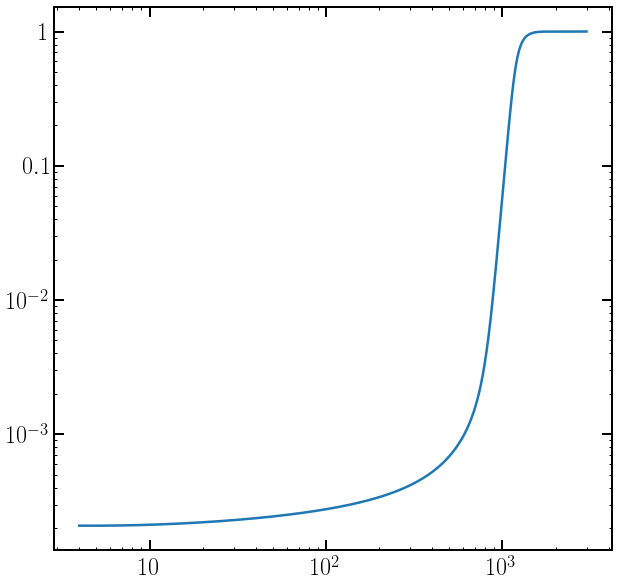

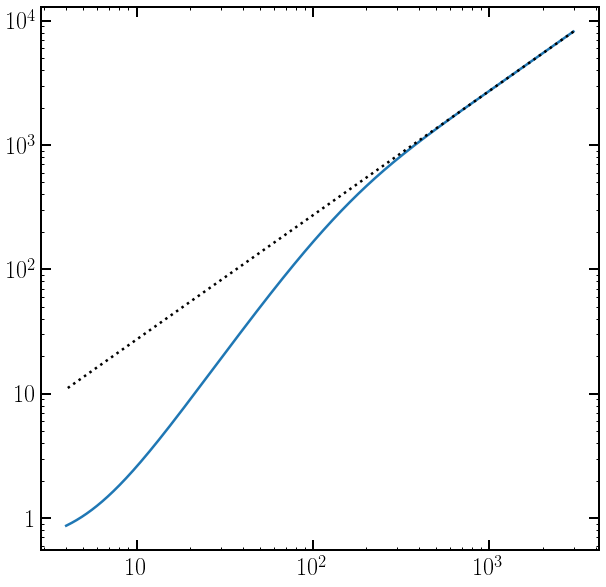

In [30]:
plt.figure()
# plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
# plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [16]:
test_tf = highengphot_tf_interp.get_tf(4, xe_std(3000))
highengphot_tf_interp.xe

array([4.53978687e-05, 2.74578156e-04, 1.65880108e-03, 9.95180187e-03,
       5.73241759e-02, 2.68941421e-01, 6.89974481e-01, 9.30861580e-01,
       9.87871565e-01, 9.97974680e-01, 9.99664650e-01])

269494554.2705443


[0.0001, 7000000000000.0, 1e-42, 10000000.0]

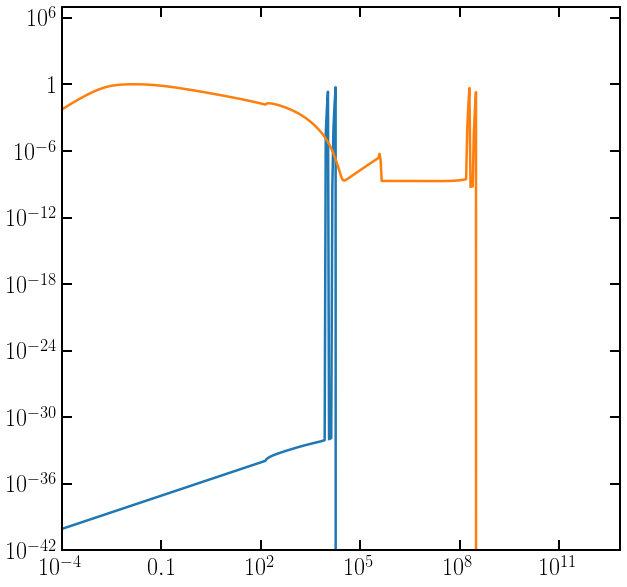

In [17]:
plt.figure()

ax = plt.gca()

print(test_tf.in_eng[375])

test_tf.plot(ax, ind=250, indtype='ind')
test_tf.plot(ax, ind=377, indtype='ind')


ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 7e12, 1e-42, 1e7])

[0.0001, 7000000000000.0, 1e-42, 10000000.0]

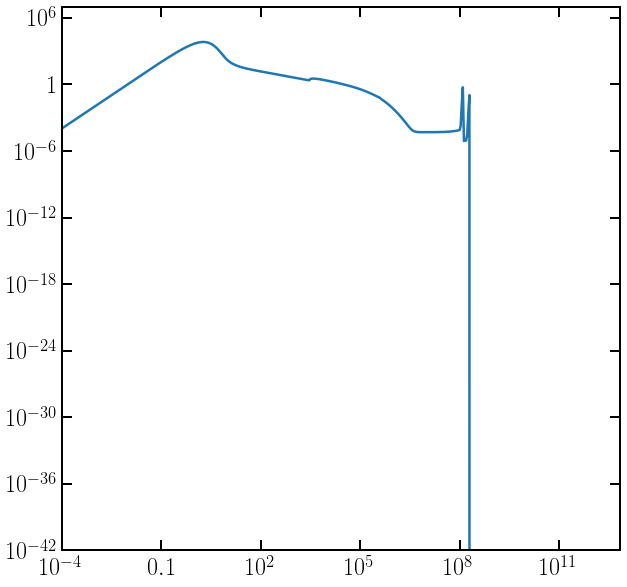

In [18]:
test_spectra = highengphot_tf_interp._grid_vals[-1,-1,:,:]

plt.figure()
ax = plt.gca()

plt.plot(highengphot_tf_interp.eng, test_spectra[370, :])

ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 7e12, 1e-42, 1e7])

[0.0001, 7000000000000.0, 1e-42, 10000000.0]

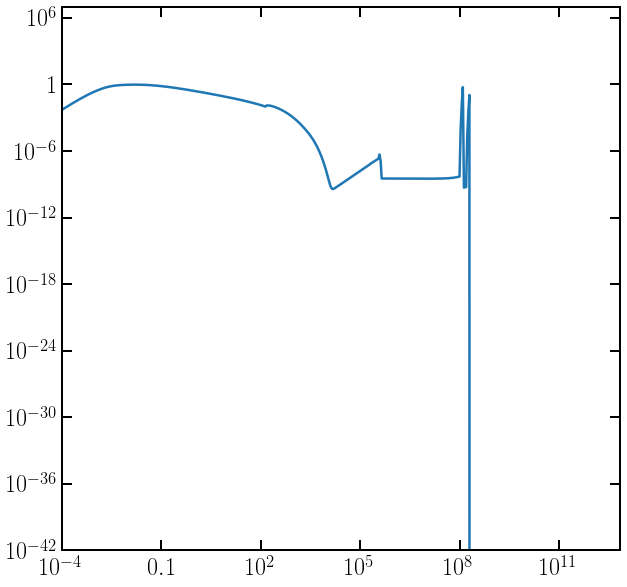

In [19]:
tf_before_interp = highengphot_tflist_arr[-1][-1]
tf_before_interp_2 = highengphot_tflist_arr[-1][0]

# print(tf_before_interp.in_eng[376])

plt.figure()
ax = plt.gca()
# tf_before_interp.plot(ax, ind=200, indtype='ind')
tf_before_interp.plot(ax, ind=370, indtype='ind')
# tf_before_interp_2.plot(ax, ind=376, indtype='ind')


ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 7e12, 1e-42, 1e7])

In [20]:
b = np.array([1, 2, 3, 4, 5, 6])
b[0:-1:2]

array([1, 3, 5])